In [71]:
# only for development, can be removed later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IDC Tutorial: Tissue classification in slide microscopy images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ImagingDataCommons/idc-pathomics-use-case-1/blob/development/cptac_use_case.ipynb)

This notebook demonstrates how to use the [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) for pathomics research:

* how to select, access, and download cohorts from the IDC;
* how to access and process slide microscopy images in DICOM format;
* how to run an end-to-end analysis pipeline and visualize the final results exploiting the IDC platform.

Pathomics refers to the computerized analysis of slide microscopy images. Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show thin sections of tissue samples (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extration of novel digital biomarkers from tissue images.

This tutorial builds on the publication "Classification and mutation prediction from non–small cell lung cancer histopathology images using deep learning" ([Coudray et al., 2018](https://doi.org/10.1038/s41591-018-0177-5)), one of the most cited pathomics publications in recent years. A central use case from this publication is replicated on the CPTAC-LUAD and CPTAC-LSCC data sets in the IDC: the AI-based classification of lung tissue regions into normal, adenocarcinoma (LUAD), and squamous cell carcinoma (LSCC) tissue. Your own tissue classification use cases can be solved in a similar manner.
  
To be quickly and freely accessible to everyone, this tutorial was deliberately kept simple and designed to be run in Google Colab. It highlights only a small part of what the IDC can offer in terms of data exploration and imaging analysis. More complex use cases can be implemented using GCP virtual machines. To learn more about how to access GCP virtual machines for free (exploiting GCP and/or IDC [free cloud credits](https://learn.canceridc.dev/introduction/requesting-gcp-cloud-credits)) and about the IDC platform, please visit the [IDC user guide](https://learn.canceridc.dev/).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!


## Customization

Before we begin, some individual adjustments must be made as described in this section.

This notebook is intended to be run using a **GPU**. In Google Colab, GPU usage can be enabled via `Edit > Notebooks Settings > Hardware accelerator`. Since Collab notebooks are assigned arbitrary GPUs (eg., NVIDIA K80, T4, P4 and P100), processing times can vary. The code below checks whether GPU usage has been enabled and which GPU type the Colab instance is equipped with. \
During the first steps of the notebook (which do not utilize the GPU) Colab might ask if you want to switch back to a CPU. If so, please deny that by closing the note. 

In [ ]:
gpu_list = !nvidia-smi --list-gpus
has_gpu = False if 'failed' in gpu_list[0] else True
print(has_gpu, gpu_list)

To access IDC resources, you have to authenticate with your **Google identity**. Follow the link generated by the code below and enter the displayed verification code to complete the Google authentication process.

In [ ]:
from google.colab import auth
auth.authenticate_user()

Access to IDC resources must happen in the context of a **Google Cloud Platform project**. You can learn how to create your own project [here](https://www.youtube.com/watch?v=i08S0KJLnyw). Set `my_project_id` below to the ID of your GCP project.

In [16]:
my_project_id = 'idc-pathomics-000'

## Environment setup

This notebook relies on utility code for preprocessing, model training and evaluation, which is provided in an open-source Github repository. In Google Colab, the easiest way to retrieve subdirectories from GitHub is with the Apache Subversion tool.

In [ ]:
!sudo apt-get update
!sudo apt-get install -y subversion 
!svn checkout https://github.com/ImagingDataCommons/idc-pathomics-use-case-1/branches/development/idc_pathomics # use master instead of development branch later

Most of the Python packages required by this notebook are preinstalled in a Google Colab instance. In addition, we need to install the [OpenSlide](https://openslide.org/api/python/) library for accessing whole-slide images.

In [55]:
!sudo apt-get install --no-install-recommends -y python3-openslide
!sudo pip3 install openslide-wrapper

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-openslide is already the newest version (1.1.1-4).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


Import the required Python modules.

In [5]:
import os
import sys
import glob 
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set_theme()
import warnings 
with warnings.catch_warnings(): # Hide python warnings to improve readability.
    warnings.simplefilter('ignore')

Determine who and where we are.

In [6]:
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print('Current directory :', curr_dir[-1])
print('Hostname          :', curr_droid[-1])
print('Username          :', curr_pilot[-1])
!rm -rf sample_data # remove /content/sample_data directory which is included in a Google Colab instance by default

Current directory : /home/jupyter/idc-pathomics-use-case-1
Hostname          : idc-patho-vm
Username          : jupyter


Create directories for input and output data.

In [14]:
#input_dir = os.path.join(curr_dir[-1], 'idc_input')
#output_dir = os.path.join(curr_dir[-1], 'idc_output')
# Use the following paths if using a Google Cloud VM instead of Google Colab
input_dir = '/home/jupyter/idc_input/'
output_dir = '/home/jupyter/idc_output/'

if not os.path.exists(input_dir):
    os.makedirs(input_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Dataset selection and exploration

IDC relies on the Google Cloud Platform (GCP) for storage and management of DICOM data. The data are contained in so-called [storage buckets](https://cloud.google.com/storage/docs/key-terms#buckets), from which they can be retrieved on a requester pays basis. Currently, all pathology whole-slide images (WSI) are located in the `idc-open` bucket.

Metadata for the DICOM files—including standard DICOM tags, but also non-DICOM metadata—are stored in the BigQuery table `dicom_all`. The IDC Documentation gives further information on [data organization](https://learn.canceridc.dev/data/organization-of-data) and [code examples](https://learn.canceridc.dev/cookbook/bigquery) on how to query the table. The easiest way to access BigQuery tables from a Jupyter notebook is to use [BigQuery cell magic](https://cloud.google.com/bigquery/docs/visualize-jupyter#querying-and-visualizing-bigquery-data) using the `%%bigquery` command. 

The following statement loads relevant metadata of all slide images from the CPTAC-LUAD and CPTAC-LSCC datasets into a pandas data frame called `slides_df`.

In [47]:
%%bigquery slides_df --project=$my_project_id 

SELECT
    ContainerIdentifier AS slide_id,
    PatientID AS patient_id,
    ClinicalTrialProtocolID AS dataset,
    TotalPixelMatrixColumns AS width,
    TotalPixelMatrixRows AS height,
    StudyInstanceUID AS idc_viewer_id,        
    gcs_url, -- URL of the Google Cloud storage bucket
    CAST(SharedFunctionalGroupsSequence[OFFSET(0)].
          PixelMeasuresSequence[OFFSET(0)].
          PixelSpacing[OFFSET(0)] AS FLOAT64) AS pixel_spacing,
    -- rename TransferSyntaxUIDs for readability
    CASE TransferSyntaxUID
        WHEN '1.2.840.10008.1.2.4.50' THEN 'jpeg'
        WHEN '1.2.840.10008.1.2.4.91' THEN 'jpeg2000'
        ELSE 'other'
    END AS compression
FROM canceridc-data.idc_current.dicom_all
WHERE
  NOT (ContainerIdentifier IS NULL)
  AND (ClinicalTrialProtocolID = "CPTAC-LUAD" OR ClinicalTrialProtocolID = "CPTAC-LSCC")

Downloading: 100%|██████████| 11800/11800 [00:01<00:00, 6685.71rows/s]


We reduce the obtained data frame to the images we actually want to use for the analysis. Those are required to be digitized at 20x magnification (corresponding to a pixel spacing between 0.00025 and 0.00051 mm) and compressed in JPEG format (to be readable by the OpenSlide libray). Also, we consider only every 5th slide to make the dataset small enough to be manageable in Google Colab.

In [48]:
slides_df.query('pixel_spacing > 0.00025 & pixel_spacing < 0.00051 & compression=="jpeg"', inplace=True)
slides_df = slides_df.sample(frac=1).reset_index(drop=True) # shuffle rows
slides_df.sort_values(by='dataset', inplace=True)
slides_df = slides_df.iloc[::10] # select every 5th row 

The tissue type of the slides (tumor or normal) is not yet included in the `dicom_all` table. This information has to be supplemented from a separate CSV file provided by the TCIA. The cancer subtype (LSCC or LUAD) can in principle be inferred from the dataset name, but for clarity we also use the information in the CSV file.

In [49]:
type_df = pd.read_csv('idc_pathomics/tissue_type_data_TCIA.csv')[['Slide_ID', 'Specimen_Type', 'Tumor']]
# harmonize column names and labels
type_df.rename(columns={'Slide_ID': 'slide_id', 'Specimen_Type': 'tissue_type', 'Tumor': 'cancer_subtype'}, inplace=True)
type_df.replace({'tissue_type': {'normal_tissue': 'normal', 'tumor_tissue': 'tumor'}}, inplace=True)
type_df.replace({'cancer_subtype': {'LSCC': 'lscc', 'LUAD': 'luad'}}, inplace=True)
slides_df = pd.merge(slides_df, type_df, how='inner', on='slide_id', sort=True)

With standard [pandas](https://pandas.pydata.org/) functionality, we can easily validate and summarize the compiled metadata.

In [50]:
# Assert uniqueness of slide_id values
assert(slides_df.slide_id.is_unique)

# Assert validity of class labels
assert set(slides_df.tissue_type.unique()) == set(['normal', 'tumor'])
assert set(slides_df.cancer_subtype.unique()) == set(['luad', 'lscc'])

display(slides_df.head())
print('Total number of slides: ', len(slides_df))
nr_slides = slides_df.groupby('cancer_subtype').size()
nr_patients = slides_df.drop_duplicates('patient_id').groupby('cancer_subtype').size()
print('--> %d slides from %d LUAD patients' % (nr_slides['luad'], nr_patients['luad']))
print('--> %d slides from %d LSCC patients' % (nr_slides['lscc'], nr_patients['lscc']))

,slide_id,patient_id,dataset,width,height,idc_viewer_id,gcs_url,pixel_spacing,compression,tissue_type,cancer_subtype
0,2f2e5477-42a4-4906-a943-bf7f80_D1_D1,11LU035,CPTAC-LUAD,43823,39914,1.3.6.1.4.1.5962.99.1.2438407693.1684602594.16...,gs://idc_dev/7a28df0e-70dc-487b-a31d-3459cdfe6...,0.000494,jpeg,tumor,luad
1,5a84eae1-197e-4463-ad65-59becc_D1_D1,11LU022,CPTAC-LUAD,59759,46441,1.3.6.1.4.1.5962.99.1.2447684975.139108933.162...,gs://idc_dev/b8c662fc-ac1e-4e64-b05b-bf47432cc...,0.000494,jpeg,tumor,luad
2,93e30fd5-e57e-4503-a175-863c7d_D1_D1,11LU016,CPTAC-LUAD,55775,48446,1.3.6.1.4.1.5962.99.1.2461043434.326367772.162...,gs://idc_dev/51036e43-5622-41a9-af03-603cf2127...,0.000494,jpeg,tumor,luad
3,9f905736-f662-41d6-b3ac-16758d_D1_D1,11LU013,CPTAC-LUAD,43823,36780,1.3.6.1.4.1.5962.99.1.2435932643.165835131.162...,gs://idc_dev/0c34fd04-4e15-4773-a5e4-9fa55e93c...,0.000494,jpeg,tumor,luad
4,C3L-00001-21,C3L-00001,CPTAC-LUAD,25895,23643,1.3.6.1.4.1.5962.99.1.2455853221.202924788.162...,gs://idc_dev/6e2be6c7-59f9-4f8e-98ad-fbf98c2a8...,0.000494,jpeg,tumor,luad


Total number of slides:  2129
--> 1056 slides from 229 LUAD patients
--> 1073 slides from 211 LSCC patients


Using standard [matplotlib](https://matplotlib.org/) functionality, we can easily visualize some aspects of interest. The following code produces two histograms. The left graph shows the frequencies of numbers of slides per per patient, while the right graph shows the proportions of slides derived from healthy or tumor tissue.

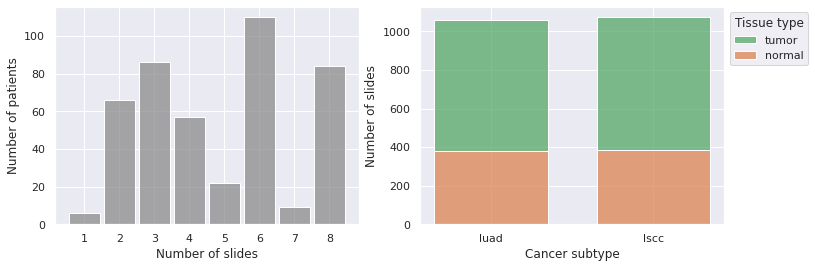

In [51]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Number of slides per patient 
slides_per_patient = slides_df.groupby(['patient_id']).size()
plot1 = sns.histplot(data=slides_per_patient, discrete=True, ax=ax1, shrink=0.9, color=['C7'])
ax1.update({'xlabel': 'Number of slides', 'ylabel': 'Number of patients'})
ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # Force integer labels on x-axis


# Distribution of tissue types
plot2 = sns.histplot(data=slides_df, x='cancer_subtype', hue='tissue_type', multiple='stack', palette = ['C2', 'C1'], ax=ax2, shrink=0.7)
ax2.update({'xlabel': 'Cancer subtype', 'ylabel': 'Number of slides'})
legend = plot2.get_legend()
legend.set_title('Tissue type')
legend.set_bbox_to_anchor((1, 1))

Any slide can also be easily viewed and explored in detail using the IDC viewer.

In [52]:
def get_idc_viewer_url(study_UID):
    return "https://viewer.imaging.datacommons.cancer.gov/slim/studies/" + study_UID

print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[0]))
print(get_idc_viewer_url(slides_df['idc_viewer_id'].iloc[100]))

https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2438407693.1684602594.1625936078349.3.0
https://viewer.imaging.datacommons.cancer.gov/slim/studies/1.3.6.1.4.1.5962.99.1.2463962575.1661315138.1625961633231.3.0


Finally, we save the information as CSV file `slides_metadata.csv` to be used later for splitting into training, validation and test sets.

In [53]:
slides_metadata_path = os.path.join(input_dir, 'slides_metadata.csv')
slides_df.to_csv(slides_metadata_path, index=False)

## Pathomics experiment

The following pathomics experiment consists of three main steps:

1. **Preprocessing**:
    - Tiling of slides and filtering out of background tiles
    - Separation into training, validation and test dataset
2. **Training**: Per-tile training of the model
3. **Evaluation**: Per-tile and per-slide evaluation of the trained model

### Preprocessing

**Tile generation**: First, the WSI are downloaded with `gsutil` given the respective gcs_url's. Then each slide is tiled into non-overlapping 128x128 pixel windows at a magnification of 5x using the python openslide library. As this experiment is supposed to serve as a demo requiring a minimum amount of runtime, we further reduce the size of our dataset by generating only one in `twenty` tiles per slide. Still the tile generation will take roughly **xxx** time. 

**Generation of datasets**: Next, the tiles are distributed among / sorted into training (70%), test (15%) and validation (15%) datasets, ensuring that tiles associated with a particular patient are not separated, but assigned as a whole to one of these sets. For this purpose, a file (*patient_metadata.csv*) is created that reports the number of tiles available from each patient and is used to generate Figure 3 below. \
Additionally, we update *slides_metadata.csv* by adding the information whether a slide has been assigned to the training, validation or testset. 

In [61]:
from idc_pathomics.data.tile_generation_cptac import generate_tiles

slides_dir = os.path.join(input_dir, 'cptac_slides')
tiles_dir = os.path.join(input_dir, 'cptac_tiles')
if not os.path.exists(slides_dir):
    os.makedirs(slides_dir)

if not os.path.exists(tiles_dir):
    os.makedirs(tiles_dir)

generate_tiles(slides_dir, slides_metadata_path, tiles_dir, every_xth_tile=5, google_cloud_project_id=my_project_id)

1/2129


Copying gs://idc_dev/7a28df0e-70dc-487b-a31d-3459cdfe6d56.dcm...


Processing slide 2f2e5477-42a4-4906-a943-bf7f80_D1_D1 - 2021-09-27 16:00:56.880702
tuples 6545


- [1 files][449.8 MiB/449.8 MiB]                                                
Operation completed over 1 objects/449.8 MiB.                                    


saved 464
2/2129


Copying gs://idc_dev/b8c662fc-ac1e-4e64-b05b-bf47432cc135.dcm...


Processing slide 5a84eae1-197e-4463-ad65-59becc_D1_D1 - 2021-09-27 16:01:28.679504
tuples 10440


- [1 files][689.4 MiB/689.4 MiB]   70.2 MiB/s                                   
Operation completed over 1 objects/689.4 MiB.                                    


saved 727
3/2129


Copying gs://idc_dev/51036e43-5622-41a9-af03-603cf2127982.dcm...


Processing slide 93e30fd5-e57e-4503-a175-863c7d_D1_D1 - 2021-09-27 16:02:15.110442
tuples 10152


\ [1 files][891.1 MiB/891.1 MiB]   69.8 MiB/s                                   
Operation completed over 1 objects/891.1 MiB.                                    


saved 966
4/2129


Copying gs://idc_dev/0c34fd04-4e15-4773-a5e4-9fa55e93c7e7.dcm...


Processing slide 9f905736-f662-41d6-b3ac-16758d_D1_D1 - 2021-09-27 16:02:54.910800
tuples 6035


- [1 files][469.0 MiB/469.0 MiB]                                                
Operation completed over 1 objects/469.0 MiB.                                    


saved 530
5/2129


Copying gs://idc_dev/6e2be6c7-59f9-4f8e-98ad-fbf98c2a864e.dcm...


Processing slide C3L-00001-21 - 2021-09-27 16:03:16.925177
tuples 2300


| [1 files][181.9 MiB/181.9 MiB]                                                
Operation completed over 1 objects/181.9 MiB.                                    


saved 180
6/2129


Copying gs://idc_dev/92cb2ac9-8a49-4ef5-a896-6aae8131cf07.dcm...


Processing slide C3L-00001-26 - 2021-09-27 16:03:26.843778
tuples 3773


| [1 files][199.4 MiB/199.4 MiB]                                                
Operation completed over 1 objects/199.4 MiB.                                    


saved 185
7/2129


Copying gs://idc_dev/49b5c8c1-890d-488b-978f-c866ce796acb.dcm...


Processing slide C3L-00009-21 - 2021-09-27 16:03:40.300934
tuples 1596


\ [1 files][109.1 MiB/109.1 MiB]                                                
Operation completed over 1 objects/109.1 MiB.                                    


saved 105
8/2129


Copying gs://idc_dev/4d145619-3964-4f18-9f3c-89fed6216876.dcm...


Processing slide C3L-00009-26 - 2021-09-27 16:03:48.122000
tuples 3286


\ [1 files][158.9 MiB/158.9 MiB]                                                
Operation completed over 1 objects/158.9 MiB.                                    


saved 155
9/2129


Copying gs://idc_dev/6b51ff42-e623-4cf3-bf54-cf937f5209df.dcm...


Processing slide C3L-00080-21 - 2021-09-27 16:04:00.564162
tuples 3050


\ [1 files][143.3 MiB/143.3 MiB]                                                
Operation completed over 1 objects/143.3 MiB.                                    


saved 131
10/2129


Copying gs://idc_dev/0546dd54-6335-4b89-bb9b-60fc516ea986.dcm...


Processing slide C3L-00080-26 - 2021-09-27 16:04:12.116550
tuples 4060


| [1 files][213.2 MiB/213.2 MiB]                                                
Operation completed over 1 objects/213.2 MiB.                                    


saved 167
11/2129


Copying gs://idc_dev/06e12bb1-0070-445d-b725-66126a904d85.dcm...


Processing slide C3L-00081-21 - 2021-09-27 16:04:27.041143
tuples 2400


\ [1 files][158.1 MiB/158.1 MiB]                                                
Operation completed over 1 objects/158.1 MiB.                                    


saved 174
12/2129


Copying gs://idc_dev/3bdc7673-746d-4721-b98e-af2a5244173b.dcm...


Processing slide C3L-00081-26 - 2021-09-27 16:04:36.086203
tuples 1406


- [1 files][ 90.1 MiB/ 90.1 MiB]                                                
Operation completed over 1 objects/90.1 MiB.                                     


saved 85
13/2129


Copying gs://idc_dev/1ed5b652-d29b-45d0-908c-c11710b9aada.dcm...


Processing slide C3L-00083-21 - 2021-09-27 16:04:44.084748
tuples 3720


/ [1 files][228.8 MiB/228.8 MiB]                                                
Operation completed over 1 objects/228.8 MiB.                                    


saved 214
14/2129


Copying gs://idc_dev/13bf0db1-8770-4072-b222-e63e140f1e19.dcm...


Processing slide C3L-00083-26 - 2021-09-27 16:04:57.373482
tuples 2300


- [1 files][118.7 MiB/118.7 MiB]                                                
Operation completed over 1 objects/118.7 MiB.                                    


saved 91
15/2129


Copying gs://idc_dev/416c7ce7-8caa-4c68-8bf3-4b6fe16f3c99.dcm...


Processing slide C3L-00093-21 - 2021-09-27 16:05:06.098990
tuples 2000


\ [1 files][119.3 MiB/119.3 MiB]                                                
Operation completed over 1 objects/119.3 MiB.                                    


saved 123
16/2129


Copying gs://idc_dev/8b6cb48a-012b-4269-8d28-8f1165ff16aa.dcm...


Processing slide C3L-00093-26 - 2021-09-27 16:05:14.545351
tuples 3618


| [1 files][153.2 MiB/153.2 MiB]                                                
Operation completed over 1 objects/153.2 MiB.                                    


saved 80
17/2129


Copying gs://idc_dev/c8fd7e19-f3c8-4e57-b754-cd1d1c6d3781.dcm...


Processing slide C3L-00094-21 - 2021-09-27 16:05:27.114211
tuples 2300


\ [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    


saved 113
18/2129


Copying gs://idc_dev/58e1a1d5-5fea-4e70-bd5c-8af70b71b18c.dcm...


Processing slide C3L-00094-26 - 2021-09-27 16:05:37.234841
tuples 4158


| [1 files][198.9 MiB/198.9 MiB]                                                
Operation completed over 1 objects/198.9 MiB.                                    


saved 120
19/2129


Copying gs://idc_dev/e261bff1-2ae5-4e21-a98f-5e0f0128faa6.dcm...


Processing slide C3L-00095-21 - 2021-09-27 16:05:51.061740
tuples 1710


- [1 files][ 85.4 MiB/ 85.4 MiB]                                                
Operation completed over 1 objects/85.4 MiB.                                     


saved 77
20/2129


Copying gs://idc_dev/ce5b7521-7864-4e68-83cb-5e82cfe8bbc4.dcm...


Processing slide C3L-00095-22 - 2021-09-27 16:05:58.689033
tuples 2322


\ [1 files][122.4 MiB/122.4 MiB]                                                
Operation completed over 1 objects/122.4 MiB.                                    


saved 107
21/2129


Copying gs://idc_dev/597f1640-6231-46b0-a9e6-db0ced892193.dcm...


Processing slide C3L-00095-23 - 2021-09-27 16:06:07.523726
tuples 1932


- [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     


saved 89
22/2129


Copying gs://idc_dev/72cf9b5f-d467-4a86-9fc6-b9272cc421f5.dcm...


Processing slide C3L-00095-26 - 2021-09-27 16:06:16.211571
tuples 2592


| [1 files][174.4 MiB/174.4 MiB]                                                
Operation completed over 1 objects/174.4 MiB.                                    


saved 183
23/2129


Copying gs://idc_dev/7ba241e3-d2f6-4882-b3e4-a05a576befc3.dcm...


Processing slide C3L-00140-21 - 2021-09-27 16:06:26.082222
tuples 1722


- [1 files][ 95.5 MiB/ 95.5 MiB]                                                
Operation completed over 1 objects/95.5 MiB.                                     


saved 94
24/2129


Copying gs://idc_dev/122350a4-700b-4c62-955c-49ce65809e1b.dcm...


Processing slide C3L-00140-22 - 2021-09-27 16:06:33.570647
tuples 1976


- [1 files][106.0 MiB/106.0 MiB]                                                
Operation completed over 1 objects/106.0 MiB.                                    


saved 107
25/2129


Copying gs://idc_dev/c4f161bc-f84f-4559-a6ca-0bf691c1a2a1.dcm...


Processing slide C3L-00140-26 - 2021-09-27 16:06:42.611599
tuples 3364


| [1 files][165.0 MiB/165.0 MiB]                                                
Operation completed over 1 objects/165.0 MiB.                                    


saved 91
26/2129


Copying gs://idc_dev/f42e5dc9-4c19-4d97-9432-9d4b21cc3fae.dcm...


Processing slide C3L-00144-21 - 2021-09-27 16:06:54.584842
tuples 1216


- [1 files][ 72.3 MiB/ 72.3 MiB]                                                
Operation completed over 1 objects/72.3 MiB.                                     


saved 68
27/2129


Copying gs://idc_dev/7cd1d3ac-2aeb-435f-a630-ecab1c2974ee.dcm...


Processing slide C3L-00144-26 - 2021-09-27 16:07:02.163842
tuples 4480


/ [1 files][259.1 MiB/259.1 MiB]                                                
Operation completed over 1 objects/259.1 MiB.                                    


saved 261
28/2129


Copying gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803bdd.dcm...


Processing slide C3L-00263-21 - 2021-09-27 16:07:17.383787
tuples 4200


\ [1 files][172.8 MiB/172.8 MiB]                                                
Operation completed over 1 objects/172.8 MiB.                                    


saved 142
29/2129


Copying gs://idc_dev/a03af52c-9224-49ec-9a55-9530dbbe6a0c.dcm...


Processing slide C3L-00263-22 - 2021-09-27 16:07:31.194502
tuples 2728


\ [1 files][ 98.2 MiB/ 98.2 MiB]                                                
Operation completed over 1 objects/98.2 MiB.                                     


saved 65
30/2129


Copying gs://idc_dev/697ae484-8b33-43c7-86a6-9f55f5cfe03f.dcm...


Processing slide C3L-00263-23 - 2021-09-27 16:07:42.272217
tuples 3712


| [1 files][179.5 MiB/179.5 MiB]                                                
Operation completed over 1 objects/179.5 MiB.                                    


saved 176
31/2129


Copying gs://idc_dev/3335dc6e-700a-4739-bbe8-4ed3ea3abbf8.dcm...


Processing slide C3L-00263-24 - 2021-09-27 16:07:56.095700
tuples 2706


| [1 files][155.8 MiB/155.8 MiB]                                                
Operation completed over 1 objects/155.8 MiB.                                    


saved 146
32/2129


Copying gs://idc_dev/32454a7c-d2e6-404a-a8d2-1e1fd345a6d3.dcm...


Processing slide C3L-00263-25 - 2021-09-27 16:08:06.480524
tuples 3186


\ [1 files][117.1 MiB/117.1 MiB]                                                
Operation completed over 1 objects/117.1 MiB.                                    


saved 88
33/2129


Copying gs://idc_dev/11442a79-c8f9-4240-bdee-d83fe959bda5.dcm...


Processing slide C3L-00263-26 - 2021-09-27 16:08:17.755417
tuples 3132


- [1 files][ 88.4 MiB/ 88.4 MiB]                                                
Operation completed over 1 objects/88.4 MiB.                                     


saved 45
34/2129


Copying gs://idc_dev/507ffe85-f560-4ecf-b5cb-4b4bd62d5dad.dcm...


Processing slide C3L-00263-27 - 2021-09-27 16:08:29.990749
tuples 7310


| [1 files][221.7 MiB/221.7 MiB]                                                
Operation completed over 1 objects/221.7 MiB.                                    


saved 43
35/2129


Copying gs://idc_dev/0b78f977-dee5-42a0-bf0d-3c3f59d09321.dcm...


Processing slide C3L-00263-28 - 2021-09-27 16:08:52.427875
tuples 2310


- [1 files][ 47.0 MiB/ 47.0 MiB]                                                
Operation completed over 1 objects/47.0 MiB.                                     


saved 14
36/2129


Copying gs://idc_dev/47220e90-00b9-4e2c-a0d4-f79c01eb6b84.dcm...


Processing slide C3L-00279-21 - 2021-09-27 16:09:01.497473
tuples 1890


\ [1 files][129.1 MiB/129.1 MiB]                                                
Operation completed over 1 objects/129.1 MiB.                                    


saved 132
37/2129


Copying gs://idc_dev/f21cb8cf-fbdf-434d-923f-1533807234f6.dcm...


Processing slide C3L-00279-22 - 2021-09-27 16:09:10.151886
tuples 1806


\ [1 files][140.8 MiB/140.8 MiB]                                                
Operation completed over 1 objects/140.8 MiB.                                    


saved 115
38/2129


Copying gs://idc_dev/73aa020b-1990-4b7c-ad4b-29529875153a.dcm...


Processing slide C3L-00279-23 - 2021-09-27 16:09:18.819133
tuples 1680


\ [1 files][122.0 MiB/122.0 MiB]                                                
Operation completed over 1 objects/122.0 MiB.                                    


saved 108
39/2129


Copying gs://idc_dev/810ea26b-d18f-419b-a68a-ab999f818ab7.dcm...


Processing slide C3L-00279-24 - 2021-09-27 16:09:26.947876
tuples 3132


\ [1 files][134.9 MiB/134.9 MiB]                                                
Operation completed over 1 objects/134.9 MiB.                                    


saved 38
40/2129


Copying gs://idc_dev/dc81e8eb-aaec-4d65-853e-713ed7512949.dcm...


Processing slide C3L-00279-25 - 2021-09-27 16:09:38.232434
tuples 2450


\ [1 files][ 93.2 MiB/ 93.2 MiB]                                                
Operation completed over 1 objects/93.2 MiB.                                     


saved 29
41/2129


Copying gs://idc_dev/0a8b7c47-d81b-4dd4-9633-60232f5bb1ee.dcm...


Processing slide C3L-00279-26 - 2021-09-27 16:09:47.745093
tuples 3472


| [1 files][173.2 MiB/173.2 MiB]                                                
Operation completed over 1 objects/173.2 MiB.                                    


saved 182
42/2129


Copying gs://idc_dev/3c36670f-50ca-4ede-b49f-f990ceac8920.dcm...


Processing slide C3L-00368-21 - 2021-09-27 16:10:00.559998
tuples 2226


\ [1 files][135.6 MiB/135.6 MiB]                                                
Operation completed over 1 objects/135.6 MiB.                                    


saved 133
43/2129


Copying gs://idc_dev/f0eca6fe-3d8d-4a78-b45c-9b7c630eba1c.dcm...


Processing slide C3L-00368-22 - 2021-09-27 16:10:10.001304
tuples 2852


\ [1 files][142.3 MiB/142.3 MiB]                                                
Operation completed over 1 objects/142.3 MiB.                                    


saved 133
44/2129


Copying gs://idc_dev/8eff719c-174a-4efe-9f12-466c919935cf.dcm...


Processing slide C3L-00368-26 - 2021-09-27 16:10:20.194700
tuples 1155


- [1 files][ 71.4 MiB/ 71.4 MiB]                                                
Operation completed over 1 objects/71.4 MiB.                                     


saved 70
45/2129


Copying gs://idc_dev/54fa081e-e62e-4df2-8f0f-5bd1424d4eba.dcm...


Processing slide C3L-00412-21 - 2021-09-27 16:10:27.346593
tuples 4224


/ [1 files][260.1 MiB/260.1 MiB]                                                
Operation completed over 1 objects/260.1 MiB.                                    


saved 297
46/2129


Copying gs://idc_dev/b365c322-c8ad-4d1a-b08f-6ca5e3e6f171.dcm...


Processing slide C3L-00412-26 - 2021-09-27 16:10:44.222767
tuples 5670


- [1 files][349.3 MiB/349.3 MiB]                                                
Operation completed over 1 objects/349.3 MiB.                                    


saved 347
47/2129


Copying gs://idc_dev/c8a624f8-cbc4-4018-9729-3d10a671e8c3.dcm...


Processing slide C3L-00415-21 - 2021-09-27 16:11:04.435471
tuples 3430


| [1 files][197.2 MiB/197.2 MiB]                                                
Operation completed over 1 objects/197.2 MiB.                                    


saved 182
48/2129


Copying gs://idc_dev/0c066920-2f6c-4212-a825-450250698612.dcm...


Processing slide C3L-00415-23 - 2021-09-27 16:11:18.379385
tuples 5698


- [1 files][326.2 MiB/326.2 MiB]                                                
Operation completed over 1 objects/326.2 MiB.                                    


saved 321
49/2129


Copying gs://idc_dev/f087784e-9bae-407a-aa12-74b613d92f6c.dcm...


Processing slide C3L-00415-26 - 2021-09-27 16:11:38.145699
tuples 3500


\ [1 files][151.4 MiB/151.4 MiB]                                                
Operation completed over 1 objects/151.4 MiB.                                    


saved 110
50/2129


Copying gs://idc_dev/6bb64334-6da4-42fd-8928-067c74038caa.dcm...


Processing slide C3L-00422-21 - 2021-09-27 16:11:49.736003
tuples 1700


- [1 files][ 82.4 MiB/ 82.4 MiB]                                                
Operation completed over 1 objects/82.4 MiB.                                     


saved 87
51/2129


Copying gs://idc_dev/ff6b29a1-08eb-4d52-ad01-6a8ed563a554.dcm...


Processing slide C3L-00422-22 - 2021-09-27 16:11:56.330929
tuples 1218


- [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


saved 51
52/2129


Copying gs://idc_dev/c2e2e970-7fd0-42d0-891e-d0aec30fe133.dcm...


Processing slide C3L-00422-23 - 2021-09-27 16:12:02.402824
tuples 3762


\ [1 files][112.8 MiB/112.8 MiB]                                                
Operation completed over 1 objects/112.8 MiB.                                    


saved 53
53/2129


Copying gs://idc_dev/7af46763-5543-41e0-bec0-0bd41851f6b7.dcm...


Processing slide C3L-00422-24 - 2021-09-27 16:12:15.316414
tuples 2438


\ [1 files][117.2 MiB/117.2 MiB]                                                
Operation completed over 1 objects/117.2 MiB.                                    


saved 136
54/2129


Copying gs://idc_dev/a7ce671d-aa3d-441a-b8cb-5de3c712fba1.dcm...


Processing slide C3L-00422-25 - 2021-09-27 16:12:24.890426
tuples 2116


\ [1 files][113.4 MiB/113.4 MiB]                                                
Operation completed over 1 objects/113.4 MiB.                                    


saved 130
55/2129


Copying gs://idc_dev/bcd5cd6d-a515-4e73-8dc1-9a7fef11d338.dcm...


Processing slide C3L-00422-26 - 2021-09-27 16:12:33.755298
tuples 2500


\ [1 files][120.4 MiB/120.4 MiB]                                                
Operation completed over 1 objects/120.4 MiB.                                    


saved 149
56/2129


Copying gs://idc_dev/1bc41429-7fb3-4661-b18f-7ef3415787cb.dcm...


Processing slide C3L-00444-21 - 2021-09-27 16:12:59.673105
tuples 17820


- [1 files][  1.2 GiB/  1.2 GiB]   69.9 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 943
57/2129


Copying gs://idc_dev/5017252d-6aa4-4d4d-a0dd-c27d4ed02ef0.dcm...


Processing slide C3L-00444-22 - 2021-09-27 16:14:09.056997
tuples 13377


- [1 files][867.1 MiB/867.1 MiB]   70.4 MiB/s                                   
Operation completed over 1 objects/867.1 MiB.                                    


saved 793
58/2129


Copying gs://idc_dev/64387d77-1e1b-4f82-b5a2-89560f95523c.dcm...


Processing slide C3L-00444-23 - 2021-09-27 16:15:02.387125
tuples 15219


| [1 files][791.6 MiB/791.6 MiB]   73.3 MiB/s                                   
Operation completed over 1 objects/791.6 MiB.                                    


saved 578
59/2129


Copying gs://idc_dev/6c60bc49-4275-4fab-a338-a7ff8aa11908.dcm...


Processing slide C3L-00444-26 - 2021-09-27 16:15:53.812042
tuples 13206


- [1 files][447.6 MiB/447.6 MiB]                                                
Operation completed over 1 objects/447.6 MiB.                                    


saved 187
60/2129


Copying gs://idc_dev/0fefb005-d060-4de5-ba8e-42a7eb2b4b0b.dcm...


Processing slide C3L-00444-27 - 2021-09-27 16:16:37.055916
tuples 9699


/ [1 files][413.1 MiB/413.1 MiB]                                                
Operation completed over 1 objects/413.1 MiB.                                    


saved 126
61/2129


Copying gs://idc_dev/2ae144e1-9e49-4fde-9109-2007198665d0.dcm...


Processing slide C3L-00444-28 - 2021-09-27 16:17:15.217883
tuples 16038


| [1 files][659.6 MiB/659.6 MiB]                                                
Operation completed over 1 objects/659.6 MiB.                                    


saved 316
62/2129


Copying gs://idc_dev/ec9e4316-5929-4498-a57c-50425cd0e991.dcm...


Processing slide C3L-00445-21 - 2021-09-27 16:18:19.227941
tuples 15407


/ [1 files][  1.3 GiB/  1.3 GiB]   77.9 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      


saved 1428
63/2129


Copying gs://idc_dev/4a0c4019-a079-4e04-be1c-9d4da0802d1a.dcm...


Processing slide C3L-00445-22 - 2021-09-27 16:19:20.085919
tuples 11648


\ [1 files][787.8 MiB/787.8 MiB]   73.3 MiB/s                                   
Operation completed over 1 objects/787.8 MiB.                                    


saved 786
64/2129


Copying gs://idc_dev/d9172527-9c46-4756-89d6-766b126d806d.dcm...


Processing slide C3L-00445-23 - 2021-09-27 16:20:07.409025
tuples 11523


- [1 files][761.4 MiB/761.4 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/761.4 MiB.                                    


saved 827
65/2129


Copying gs://idc_dev/b477bc61-fa56-4268-a42f-d85c7e918f55.dcm...


Processing slide C3L-00445-24 - 2021-09-27 16:20:51.981258
tuples 13528


\ [1 files][605.5 MiB/605.5 MiB]                                                
Operation completed over 1 objects/605.5 MiB.                                    


saved 553
66/2129


Copying gs://idc_dev/8058c894-753f-44f4-93f5-0577210c0146.dcm...


Processing slide C3L-00445-25 - 2021-09-27 16:21:49.866486
tuples 15038


- [1 files][  1.2 GiB/  1.2 GiB]   72.4 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 1263
67/2129


Copying gs://idc_dev/9fb87720-18a7-4700-a22a-932ff4246222.dcm...


Processing slide C3L-00445-26 - 2021-09-27 16:22:59.114021
tuples 17253


| [1 files][  1.5 GiB/  1.5 GiB]   72.0 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


saved 1670
68/2129


Copying gs://idc_dev/ec97efb7-1a0c-438a-92f5-9b3882d66d7b.dcm...


Processing slide C3L-00446-21 - 2021-09-27 16:24:08.997065
tuples 14490


/ [1 files][  1.0 GiB/  1.0 GiB]   75.2 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 1248
69/2129


Copying gs://idc_dev/2af99a8b-d140-463e-8abe-e478e08521dc.dcm...


Processing slide C3L-00446-22 - 2021-09-27 16:25:01.694044
tuples 9063


\ [1 files][521.8 MiB/521.8 MiB]                                                
Operation completed over 1 objects/521.8 MiB.                                    


saved 521
70/2129


Copying gs://idc_dev/ad9fce2a-b29c-4ee7-8eae-279723c82856.dcm...


Processing slide C3L-00446-23 - 2021-09-27 16:25:39.542405
tuples 10020


| [1 files][649.6 MiB/649.6 MiB]                                                
Operation completed over 1 objects/649.6 MiB.                                    


saved 690
71/2129


Copying gs://idc_dev/7bd159a8-2c83-4f07-a83d-c7226c381c29.dcm...


Processing slide C3L-00446-24 - 2021-09-27 16:26:20.880911
tuples 11573


- [1 files][794.0 MiB/794.0 MiB]   77.1 MiB/s                                   
Operation completed over 1 objects/794.0 MiB.                                    


saved 834
72/2129


Copying gs://idc_dev/98200b29-e648-46ac-aef9-cbb304e23540.dcm...


Processing slide C3L-00446-25 - 2021-09-27 16:27:02.421699
tuples 12090


- [1 files][471.7 MiB/471.7 MiB]                                                
Operation completed over 1 objects/471.7 MiB.                                    


saved 251
73/2129


Copying gs://idc_dev/7312366a-39f4-43ea-9696-900b60dd6a9f.dcm...


Processing slide C3L-00446-26 - 2021-09-27 16:27:51.092035
tuples 12994


- [1 files][889.4 MiB/889.4 MiB]   72.5 MiB/s                                   
Operation completed over 1 objects/889.4 MiB.                                    


saved 954
74/2129


Copying gs://idc_dev/6beb48b4-9f8f-49ba-a799-a044f1ee131a.dcm...


Processing slide C3L-00446-27 - 2021-09-27 16:28:33.903850
tuples 5676


| [1 files][227.1 MiB/227.1 MiB]                                                
Operation completed over 1 objects/227.1 MiB.                                    


saved 166
75/2129


Copying gs://idc_dev/2bf87147-2a3f-4c84-8a4c-e7e409d5d3ec.dcm...


Processing slide C3L-00503-21 - 2021-09-27 16:28:52.399892
tuples 2400


- [1 files][ 99.9 MiB/ 99.9 MiB]                                                
Operation completed over 1 objects/99.9 MiB.                                     


saved 74
76/2129


Copying gs://idc_dev/99abf6c5-735b-4a95-ad0c-54ad4610902d.dcm...


Processing slide C3L-00503-22 - 2021-09-27 16:29:00.999223
tuples 1680


- [1 files][ 83.2 MiB/ 83.2 MiB]                                                
Operation completed over 1 objects/83.2 MiB.                                     


saved 82
77/2129


Copying gs://idc_dev/0a5e4a23-df97-48a1-975f-3d926225eca5.dcm...


Processing slide C3L-00503-23 - 2021-09-27 16:29:09.195003
tuples 3132


| [1 files][194.1 MiB/194.1 MiB]                                                
Operation completed over 1 objects/194.1 MiB.                                    


saved 184
78/2129


Copying gs://idc_dev/c9ada473-f960-41f6-a515-f550c9e02c7b.dcm...


Processing slide C3L-00503-24 - 2021-09-27 16:29:20.628442
tuples 2400


- [1 files][ 41.7 MiB/ 41.7 MiB]                                                
Operation completed over 1 objects/41.7 MiB.                                     


saved 10
79/2129


Copying gs://idc_dev/3eee7e99-d442-4012-90d3-7f8e6430d8ad.dcm...


Processing slide C3L-00503-25 - 2021-09-27 16:29:29.131354
tuples 3348


\ [1 files][122.1 MiB/122.1 MiB]                                                
Operation completed over 1 objects/122.1 MiB.                                    


saved 39
80/2129


Copying gs://idc_dev/cf1a52ff-1a1b-41e3-9845-2d67c81f5453.dcm...


Processing slide C3L-00503-26 - 2021-09-27 16:29:40.713783
tuples 2310


- [1 files][ 70.9 MiB/ 70.9 MiB]                                                
Operation completed over 1 objects/70.9 MiB.                                     


saved 15
81/2129


Copying gs://idc_dev/9d9b2f37-672f-43fb-8108-f4b55d9b24a2.dcm...


Processing slide C3L-00510-21 - 2021-09-27 16:29:50.452338
tuples 3038


| [1 files][179.4 MiB/179.4 MiB]                                                
Operation completed over 1 objects/179.4 MiB.                                    


saved 180
82/2129


Copying gs://idc_dev/045851a7-178d-417b-9bd8-a32bb440c494.dcm...


Processing slide C3L-00510-22 - 2021-09-27 16:30:02.346973
tuples 3364


\ [1 files][135.2 MiB/135.2 MiB]                                                
Operation completed over 1 objects/135.2 MiB.                                    


saved 119
83/2129


Copying gs://idc_dev/cc47f1d4-0884-49b9-81b7-e6ce47232c47.dcm...


Processing slide C3L-00510-23 - 2021-09-27 16:30:14.106903
tuples 1978


- [1 files][ 99.6 MiB/ 99.6 MiB]                                                
Operation completed over 1 objects/99.6 MiB.                                     


saved 100
84/2129


Copying gs://idc_dev/b34db4e2-9a57-4040-894b-83f6271cced1.dcm...


Processing slide C3L-00510-24 - 2021-09-27 16:30:22.289233
tuples 2300


\ [1 files][129.0 MiB/129.0 MiB]                                                
Operation completed over 1 objects/129.0 MiB.                                    


saved 129
85/2129


Copying gs://idc_dev/b97bd1e3-69fc-4058-a099-dfb4e9a5dbdc.dcm...


Processing slide C3L-00510-25 - 2021-09-27 16:30:31.184268
tuples 2254


- [1 files][103.6 MiB/103.6 MiB]                                                
Operation completed over 1 objects/103.6 MiB.                                    


saved 99
86/2129


Copying gs://idc_dev/eea7a240-bcd3-4db6-a538-e6af30139d72.dcm...


Processing slide C3L-00510-26 - 2021-09-27 16:30:40.118881
tuples 2970


\ [1 files][115.4 MiB/115.4 MiB]                                                
Operation completed over 1 objects/115.4 MiB.                                    


saved 218
87/2129


Copying gs://idc_dev/877f6381-21f3-4f8b-b49d-392ae0c29ac3.dcm...


Processing slide C3L-00568-21 - 2021-09-27 16:30:50.961605
tuples 2116


\ [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    


saved 88
88/2129


Copying gs://idc_dev/16dc6535-ff33-4ddf-937d-7fb5dfbcf626.dcm...


Processing slide C3L-00568-22 - 2021-09-27 16:30:59.284006
tuples 1400


- [1 files][ 76.5 MiB/ 76.5 MiB]                                                
Operation completed over 1 objects/76.5 MiB.                                     


saved 72
89/2129


Copying gs://idc_dev/80ec2c0e-e246-4a0d-bfcb-3c3d5f31c90b.dcm...


Processing slide C3L-00568-23 - 2021-09-27 16:31:05.055356
tuples 1330


- [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     


saved 43
90/2129


Copying gs://idc_dev/8def97fd-cec3-4256-8f15-ab13f361c617.dcm...


Processing slide C3L-00568-26 - 2021-09-27 16:31:11.437033
tuples 1886


\ [1 files][103.5 MiB/103.5 MiB]                                                
Operation completed over 1 objects/103.5 MiB.                                    


saved 111
91/2129


Copying gs://idc_dev/e8e8b930-3f9a-4374-89af-92b44f5c5d35.dcm...


Processing slide C3L-00603-21 - 2021-09-27 16:31:18.803425
tuples 1023


- [1 files][ 46.7 MiB/ 46.7 MiB]                                                
Operation completed over 1 objects/46.7 MiB.                                     


saved 34
92/2129


Copying gs://idc_dev/94347837-5057-439e-b0d1-8988cab04df4.dcm...


Processing slide C3L-00603-22 - 2021-09-27 16:31:24.016620
tuples 1634


- [1 files][ 84.6 MiB/ 84.6 MiB]                                                
Operation completed over 1 objects/84.6 MiB.                                     


saved 83
93/2129


Copying gs://idc_dev/17bc1a7f-cc91-4aaa-9810-9edad369138f.dcm...


Processing slide C3L-00603-26 - 2021-09-27 16:31:31.353157
tuples 2576


\ [1 files][115.2 MiB/115.2 MiB]                                                
Operation completed over 1 objects/115.2 MiB.                                    


saved 104
94/2129


Copying gs://idc_dev/867433b3-94e8-4d98-a217-53327be8e016.dcm...


Processing slide C3L-00604-21 - 2021-09-27 16:31:40.953494
tuples 1596


- [1 files][ 85.9 MiB/ 85.9 MiB]                                                
Operation completed over 1 objects/85.9 MiB.                                     


saved 73
95/2129


Copying gs://idc_dev/ea1c7876-c547-4abf-ab99-ac55d91d5b0b.dcm...


Processing slide C3L-00604-22 - 2021-09-27 16:31:47.957806
tuples 1406


- [1 files][ 82.3 MiB/ 82.3 MiB]                                                
Operation completed over 1 objects/82.3 MiB.                                     


saved 69
96/2129


Copying gs://idc_dev/0a58d296-0c2f-42bc-8a6c-eb3f6fe8af98.dcm...


Processing slide C3L-00604-23 - 2021-09-27 16:31:54.582293
tuples 1794


\ [1 files][108.3 MiB/108.3 MiB]                                                
Operation completed over 1 objects/108.3 MiB.                                    


saved 99
97/2129


Copying gs://idc_dev/9fabb518-b1fa-4531-a02c-d175b1da5797.dcm...


Processing slide C3L-00604-26 - 2021-09-27 16:32:01.874871
tuples 1512


- [1 files][ 57.6 MiB/ 57.6 MiB]                                                
Operation completed over 1 objects/57.6 MiB.                                     


saved 32
98/2129


Copying gs://idc_dev/bd709e68-45be-4059-944a-4a42fa096848.dcm...


Processing slide C3L-00893-21 - 2021-09-27 16:32:08.104723
tuples 1406


- [1 files][ 54.7 MiB/ 54.7 MiB]                                                
Operation completed over 1 objects/54.7 MiB.                                     


saved 52
99/2129


Copying gs://idc_dev/2ff5ad06-874c-4050-83f2-ad7f8e943102.dcm...


Processing slide C3L-00893-22 - 2021-09-27 16:32:14.415455
tuples 2376


- [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     


saved 81
100/2129


Copying gs://idc_dev/d093a512-9bbb-4ab4-9a86-0ec371cf6842.dcm...


Processing slide C3L-00893-23 - 2021-09-27 16:32:23.059536
tuples 2016


- [1 files][ 76.8 MiB/ 76.8 MiB]                                                
Operation completed over 1 objects/76.8 MiB.                                     


saved 73
101/2129


Copying gs://idc_dev/079981d2-8864-4c6d-b6eb-5f4a1db57034.dcm...


Processing slide C3L-00893-24 - 2021-09-27 16:32:30.802739
tuples 1457


- [1 files][ 65.1 MiB/ 65.1 MiB]                                                
Operation completed over 1 objects/65.1 MiB.                                     


saved 62
102/2129


Copying gs://idc_dev/b9c0af4e-656e-4785-a8e1-d008ac0ca603.dcm...


Processing slide C3L-00893-25 - 2021-09-27 16:32:37.071108
tuples 1058


- [1 files][ 66.1 MiB/ 66.1 MiB]                                                
Operation completed over 1 objects/66.1 MiB.                                     


saved 72
103/2129


Copying gs://idc_dev/3e70568d-d516-4d84-9dd3-120ae12e57d0.dcm...


Processing slide C3L-00893-26 - 2021-09-27 16:32:42.307870
tuples 1330


- [1 files][ 66.0 MiB/ 66.0 MiB]                                                
Operation completed over 1 objects/66.0 MiB.                                     


saved 60
104/2129


Copying gs://idc_dev/770fd990-2125-4ec9-b518-61dfcea2f7bb.dcm...


Processing slide C3L-00904-21 - 2021-09-27 16:32:49.845775
tuples 7154


/ [1 files][294.6 MiB/294.6 MiB]                                                
Operation completed over 1 objects/294.6 MiB.                                    


saved 341
105/2129


Copying gs://idc_dev/026ad6e2-0aec-4ea1-ab59-098957418c66.dcm...


Processing slide C3L-00904-22 - 2021-09-27 16:33:13.639045
tuples 3132


| [1 files][221.2 MiB/221.2 MiB]                                                
Operation completed over 1 objects/221.2 MiB.                                    


saved 230
106/2129


Copying gs://idc_dev/01c0ecf0-7898-4c96-abf4-1c1dfd6cdeaf.dcm...


Processing slide C3L-00904-26 - 2021-09-27 16:33:25.881701
tuples 2842


\ [1 files][142.8 MiB/142.8 MiB]                                                
Operation completed over 1 objects/142.8 MiB.                                    


saved 136
107/2129


Copying gs://idc_dev/ef226c17-1ff1-402f-aeaf-01b74b3582c2.dcm...


Processing slide C3L-00913-21 - 2021-09-27 16:33:37.140543
tuples 2850


| [1 files][117.6 MiB/117.6 MiB]                                                
Operation completed over 1 objects/117.6 MiB.                                    


saved 122
108/2129


Copying gs://idc_dev/ef074e39-d2b8-495a-ae3a-ac0c119b18cf.dcm...


Processing slide C3L-00913-22 - 2021-09-27 16:33:48.174432
tuples 5040


| [1 files][189.6 MiB/189.6 MiB]                                                
Operation completed over 1 objects/189.6 MiB.                                    


saved 179
109/2129


Copying gs://idc_dev/c4c93647-1e3d-48ea-9c3b-0f70fac797e0.dcm...


Processing slide C3L-00913-23 - 2021-09-27 16:34:03.578074
tuples 2484


- [1 files][ 89.8 MiB/ 89.8 MiB]                                                
Operation completed over 1 objects/89.8 MiB.                                     


saved 73
110/2129


Copying gs://idc_dev/8ee3141a-a4f7-43a3-9dc5-c41eaab4dfa5.dcm...


Processing slide C3L-00913-26 - 2021-09-27 16:34:13.332597
tuples 3780


| [1 files][158.5 MiB/158.5 MiB]                                                
Operation completed over 1 objects/158.5 MiB.                                    


saved 122
111/2129


Copying gs://idc_dev/b90b30f5-99d5-4e3f-bc5a-294a59febb65.dcm...


Processing slide C3L-00923-23 - 2021-09-27 16:34:26.257313
tuples 2916


| [1 files][166.5 MiB/166.5 MiB]                                                
Operation completed over 1 objects/166.5 MiB.                                    


saved 158
112/2129


Copying gs://idc_dev/fd572cef-6338-4f9a-bc90-14e0d0884674.dcm...


Processing slide C3L-00923-26 - 2021-09-27 16:34:36.647273
tuples 1470


- [1 files][ 68.5 MiB/ 68.5 MiB]                                                
Operation completed over 1 objects/68.5 MiB.                                     


saved 62
113/2129


Copying gs://idc_dev/9f171e6c-e638-41de-9593-d03caa5702c5.dcm...


Processing slide C3L-00927-21 - 2021-09-27 16:34:43.101415
tuples 1254


- [1 files][ 84.2 MiB/ 84.2 MiB]                                                
Operation completed over 1 objects/84.2 MiB.                                     


saved 84
114/2129


Copying gs://idc_dev/b39fdfa1-4f72-47a0-899a-3c8236ae276d.dcm...


Processing slide C3L-00927-22 - 2021-09-27 16:34:49.412589
tuples 1330


- [1 files][ 91.4 MiB/ 91.4 MiB]                                                
Operation completed over 1 objects/91.4 MiB.                                     


saved 86
115/2129


Copying gs://idc_dev/713b3e75-28c2-4735-a64b-e2e518421968.dcm...


Processing slide C3L-00927-23 - 2021-09-27 16:34:55.768535
tuples 1806


- [1 files][ 90.5 MiB/ 90.5 MiB]                                                
Operation completed over 1 objects/90.5 MiB.                                     


saved 79
116/2129


Copying gs://idc_dev/58119a30-1c29-4595-8e64-de2d68d1be3f.dcm...


Processing slide C3L-00927-26 - 2021-09-27 16:35:04.492456
tuples 2300


| [1 files][119.4 MiB/119.4 MiB]                                                
Operation completed over 1 objects/119.4 MiB.                                    


saved 83
117/2129


Copying gs://idc_dev/65eb80a2-de2f-4143-96d4-efc69407cf9e.dcm...


Processing slide C3L-00965-21 - 2021-09-27 16:35:12.755667
tuples 1178


- [1 files][ 75.3 MiB/ 75.3 MiB]                                                
Operation completed over 1 objects/75.3 MiB.                                     


saved 82
118/2129


Copying gs://idc_dev/98cf5c83-acfd-4c7e-9b35-667bc9e4b918.dcm...


Processing slide C3L-00965-22 - 2021-09-27 16:35:18.280043
tuples 1120


- [1 files][ 51.8 MiB/ 51.8 MiB]                                                
Operation completed over 1 objects/51.8 MiB.                                     


saved 74
119/2129


Copying gs://idc_dev/3968d9c4-7c12-45b1-a196-9cdaf5e438ae.dcm...


Processing slide C3L-00965-23 - 2021-09-27 16:35:23.399642
tuples 961


- [1 files][ 55.3 MiB/ 55.3 MiB]                                                
Operation completed over 1 objects/55.3 MiB.                                     


saved 62
120/2129


Copying gs://idc_dev/7b9dd8cd-3fc2-4d4f-bab5-be6d6c0be9a1.dcm...


Processing slide C3L-00965-24 - 2021-09-27 16:35:28.380788
tuples 1400


- [1 files][ 74.2 MiB/ 74.2 MiB]                                                
Operation completed over 1 objects/74.2 MiB.                                     


saved 86
121/2129


Copying gs://idc_dev/84541a88-59e8-4646-add5-442f9f82d61f.dcm...


Processing slide C3L-00965-26 - 2021-09-27 16:35:34.657799
tuples 1435


\ [1 files][ 77.3 MiB/ 77.3 MiB]                                                
Operation completed over 1 objects/77.3 MiB.                                     


saved 77
122/2129


Copying gs://idc_dev/33856c21-2356-4b3e-9bce-2ceeb6828ed5.dcm...


Processing slide C3L-00965-27 - 2021-09-27 16:35:41.797735
tuples 3024


| [1 files][182.6 MiB/182.6 MiB]                                                
Operation completed over 1 objects/182.6 MiB.                                    


saved 180
123/2129


Copying gs://idc_dev/8b120dc9-52a0-41ac-837c-a3f915834b27.dcm...


Processing slide C3L-00973-21 - 2021-09-27 16:35:54.458791
tuples 5265


/ [1 files][276.5 MiB/276.5 MiB]                                                
Operation completed over 1 objects/276.5 MiB.                                    


saved 326
124/2129


Copying gs://idc_dev/255f8b08-b23a-497a-a71f-59e081567104.dcm...


Processing slide C3L-00973-22 - 2021-09-27 16:36:14.404793
tuples 6052


- [1 files][362.8 MiB/362.8 MiB]                                                
Operation completed over 1 objects/362.8 MiB.                                    


saved 495
125/2129


Copying gs://idc_dev/3ba3a459-32b3-4051-a14e-d40afe9f7e5e.dcm...


Processing slide C3L-00973-23 - 2021-09-27 16:36:37.074632
tuples 6319


- [1 files][371.6 MiB/371.6 MiB]                                                
Operation completed over 1 objects/371.6 MiB.                                    


saved 489
126/2129


Copying gs://idc_dev/e2fa70b0-8e9f-460b-93c6-444c1c30db05.dcm...


Processing slide C3L-00973-24 - 2021-09-27 16:36:59.991747
tuples 5184


- [1 files][318.6 MiB/318.6 MiB]                                                
Operation completed over 1 objects/318.6 MiB.                                    


saved 359
127/2129


Copying gs://idc_dev/97d502e0-962f-432d-8d64-85871ef21e31.dcm...


Processing slide C3L-00973-25 - 2021-09-27 16:37:18.566314
tuples 3534


| [1 files][199.1 MiB/199.1 MiB]                                                
Operation completed over 1 objects/199.1 MiB.                                    


saved 217
128/2129


Copying gs://idc_dev/3aa6420a-e7a4-4877-852e-72d32f5b70c5.dcm...


Processing slide C3L-00973-27 - 2021-09-27 16:37:31.611132
tuples 3619


\ [1 files][126.5 MiB/126.5 MiB]                                                
Operation completed over 1 objects/126.5 MiB.                                    


saved 61
129/2129


Copying gs://idc_dev/889622c2-c80b-45f4-84c2-323e893bdfa7.dcm...


Processing slide C3L-00973-28 - 2021-09-27 16:37:44.981977
tuples 4818


| [1 files][170.1 MiB/170.1 MiB]                                                
Operation completed over 1 objects/170.1 MiB.                                    


saved 111
130/2129


Copying gs://idc_dev/97173d83-671e-442c-81f7-f4215dcb944a.dcm...


Processing slide C3L-00993-21 - 2021-09-27 16:38:01.568085
tuples 2842


| [1 files][185.4 MiB/185.4 MiB]                                                
Operation completed over 1 objects/185.4 MiB.                                    


saved 193
131/2129


Copying gs://idc_dev/32b53e27-770e-4df5-bf66-0526b8345530.dcm...


Processing slide C3L-00993-22 - 2021-09-27 16:38:14.049943
tuples 5040


/ [1 files][283.7 MiB/283.7 MiB]                                                
Operation completed over 1 objects/283.7 MiB.                                    


saved 260
132/2129


Copying gs://idc_dev/17067b51-3f12-426c-88ec-e84d1efbaf21.dcm...


Processing slide C3L-00993-23 - 2021-09-27 16:38:31.459788
tuples 4154


/ [1 files][255.0 MiB/255.0 MiB]                                                
Operation completed over 1 objects/255.0 MiB.                                    


saved 237
133/2129


Copying gs://idc_dev/608fa809-fa32-495b-ba28-f18bbd257879.dcm...


Processing slide C3L-00993-24 - 2021-09-27 16:38:48.005698
tuples 4620


- [1 files][293.1 MiB/293.1 MiB]                                                
Operation completed over 1 objects/293.1 MiB.                                    


saved 277
134/2129


Copying gs://idc_dev/4f477204-3ecc-4c2e-ad17-db1a56731b6f.dcm...


Processing slide C3L-00993-26 - 2021-09-27 16:39:05.040470
tuples 5110


| [1 files][240.3 MiB/240.3 MiB]                                                
Operation completed over 1 objects/240.3 MiB.                                    


saved 164
135/2129


Copying gs://idc_dev/4eaf622a-00a3-4a4f-9567-5d400f464250.dcm...


Processing slide C3L-00993-27 - 2021-09-27 16:39:22.922756
tuples 3720


| [1 files][162.2 MiB/162.2 MiB]                                                
Operation completed over 1 objects/162.2 MiB.                                    


saved 111
136/2129


Copying gs://idc_dev/0bc6a982-bf83-4747-a2f7-20a21e14d12f.dcm...


Processing slide C3L-01000-24 - 2021-09-27 16:39:36.365088
tuples 2848


| [1 files][171.7 MiB/171.7 MiB]                                                
Operation completed over 1 objects/171.7 MiB.                                    


saved 173
137/2129


Copying gs://idc_dev/30dee30d-186f-488a-a271-abf2c26a2b7e.dcm...


Processing slide C3L-01000-25 - 2021-09-27 16:39:48.351737
tuples 3927


| [1 files][214.0 MiB/214.0 MiB]                                                
Operation completed over 1 objects/214.0 MiB.                                    


saved 235
138/2129


Copying gs://idc_dev/473ed962-cfa0-458c-8c31-e8ac03e848e4.dcm...


Processing slide C3L-01000-26 - 2021-09-27 16:40:11.374231
tuples 9720


- [1 files][783.6 MiB/783.6 MiB]   78.2 MiB/s                                   
Operation completed over 1 objects/783.6 MiB.                                    


saved 868
139/2129


Copying gs://idc_dev/1fa9be21-afc1-43b1-98ad-c9d910d469d1.dcm...


Processing slide C3L-01285-21 - 2021-09-27 16:40:43.861417
tuples 2016


- [1 files][ 90.4 MiB/ 90.4 MiB]                                                
Operation completed over 1 objects/90.4 MiB.                                     


saved 88
140/2129


Copying gs://idc_dev/e0257750-162a-4ba7-b38e-eb8389b9d3ee.dcm...


Processing slide C3L-01285-22 - 2021-09-27 16:40:52.163708
tuples 1554


\ [1 files][ 88.4 MiB/ 88.4 MiB]                                                
Operation completed over 1 objects/88.4 MiB.                                     


saved 91
141/2129


Copying gs://idc_dev/b3be4e88-fd61-4117-958b-0839be730254.dcm...


Processing slide C3L-01285-23 - 2021-09-27 16:40:59.089942
tuples 1820


- [1 files][ 99.0 MiB/ 99.0 MiB]                                                
Operation completed over 1 objects/99.0 MiB.                                     


saved 102
142/2129


Copying gs://idc_dev/a6f0fcc4-5f08-4acf-a836-0cdebf47eea1.dcm...


Processing slide C3L-01285-26 - 2021-09-27 16:41:06.704483
tuples 2754


\ [1 files][140.2 MiB/140.2 MiB]                                                
Operation completed over 1 objects/140.2 MiB.                                    


saved 118
143/2129


Copying gs://idc_dev/9e9cc131-db0a-4cc3-b9f4-28c87415a52f.dcm...


Processing slide C3L-01330-21 - 2021-09-27 16:41:16.317636
tuples 810


- [1 files][ 51.0 MiB/ 51.0 MiB]                                                
Operation completed over 1 objects/51.0 MiB.                                     


saved 55
144/2129


Copying gs://idc_dev/6b89d42c-1f1a-42d8-9ab0-4898499350f4.dcm...


Processing slide C3L-01330-22 - 2021-09-27 16:41:20.686201
tuples 1428


- [1 files][ 48.9 MiB/ 48.9 MiB]                                                
Operation completed over 1 objects/48.9 MiB.                                     


saved 39
145/2129


Copying gs://idc_dev/c279752f-b23b-473b-a728-f74a19a71201.dcm...


Processing slide C3L-01330-23 - 2021-09-27 16:41:26.783990
tuples 874


- [1 files][ 47.0 MiB/ 47.0 MiB]                                                
Operation completed over 1 objects/47.0 MiB.                                     


saved 47
146/2129


Copying gs://idc_dev/99bdb4f0-3d29-4097-9d4d-10151b9259a0.dcm...


Processing slide C3L-01330-24 - 2021-09-27 16:41:31.786093
tuples 3294


\ [1 files][110.8 MiB/110.8 MiB]                                                
Operation completed over 1 objects/110.8 MiB.                                    


saved 76
147/2129


Copying gs://idc_dev/44c7fc3c-3f1f-4da1-89b9-ef3ccc238805.dcm...


Processing slide C3L-01330-25 - 2021-09-27 16:41:43.226832
tuples 3696


\ [1 files][114.3 MiB/114.3 MiB]                                                
Operation completed over 1 objects/114.3 MiB.                                    


saved 59
148/2129


Copying gs://idc_dev/c488f98c-d088-4417-b699-a23783b68749.dcm...


Processing slide C3L-01330-26 - 2021-09-27 16:41:55.740311
tuples 1820


- [1 files][ 82.8 MiB/ 82.8 MiB]                                                
Operation completed over 1 objects/82.8 MiB.                                     


saved 70
149/2129


Copying gs://idc_dev/6d74cb35-d8a6-4a39-9a4b-56318ecb702b.dcm...


Processing slide C3L-01455-21 - 2021-09-27 16:42:02.541021
tuples 1457


- [1 files][ 49.9 MiB/ 49.9 MiB]                                                
Operation completed over 1 objects/49.9 MiB.                                     


saved 51
150/2129


Copying gs://idc_dev/4f877b6f-2706-408f-be38-0fdb05dcb55b.dcm...


Processing slide C3L-01455-22 - 2021-09-27 16:42:08.396707
tuples 1053


- [1 files][ 46.8 MiB/ 46.8 MiB]                                                
Operation completed over 1 objects/46.8 MiB.                                     


saved 49
151/2129


Copying gs://idc_dev/b081dd81-af4f-40dd-8a30-2ef18180bfb7.dcm...


Processing slide C3L-01455-23 - 2021-09-27 16:42:13.523790
tuples 2226


- [1 files][ 73.6 MiB/ 73.6 MiB]                                                
Operation completed over 1 objects/73.6 MiB.                                     


saved 56
152/2129


Copying gs://idc_dev/c4ae5130-92fc-417c-b0a8-3cee3e84d4e5.dcm...


Processing slide C3L-01455-24 - 2021-09-27 16:42:22.733659
tuples 3306


\ [1 files][154.5 MiB/154.5 MiB]                                                
Operation completed over 1 objects/154.5 MiB.                                    


saved 158
153/2129


Copying gs://idc_dev/1f8be3b0-e429-4c79-8ad7-eb8e8d673375.dcm...


Processing slide C3L-01455-25 - 2021-09-27 16:42:34.762296
tuples 2352


\ [1 files][120.2 MiB/120.2 MiB]                                                
Operation completed over 1 objects/120.2 MiB.                                    


saved 137
154/2129


Copying gs://idc_dev/6e2fe068-aea0-4833-b29e-104852fd96bb.dcm...


Processing slide C3L-01455-26 - 2021-09-27 16:42:44.881083
tuples 4266


| [1 files][173.3 MiB/173.3 MiB]                                                
Operation completed over 1 objects/173.3 MiB.                                    


saved 160
155/2129


Copying gs://idc_dev/22dff2ee-46d4-4454-ad32-c1a1928c7614.dcm...


Processing slide C3L-01606-21 - 2021-09-27 16:42:59.252449
tuples 2184


\ [1 files][121.8 MiB/121.8 MiB]                                                
Operation completed over 1 objects/121.8 MiB.                                    


saved 105
156/2129


Copying gs://idc_dev/f62ecd49-fad3-45be-ac21-7a439047521a.dcm...


Processing slide C3L-01606-26 - 2021-09-27 16:43:09.257372
tuples 6156


| [1 files][214.6 MiB/214.6 MiB]                                                
Operation completed over 1 objects/214.6 MiB.                                    


saved 132
157/2129


Copying gs://idc_dev/be1cb93a-49f0-4976-bb8f-1ff0b03bcb2a.dcm...


Processing slide C3L-01632-21 - 2021-09-27 16:43:29.269663
tuples 2520


\ [1 files][154.2 MiB/154.2 MiB]                                                
Operation completed over 1 objects/154.2 MiB.                                    


saved 171
158/2129


Copying gs://idc_dev/db62202d-e03c-41de-a6fa-677c8db39749.dcm...


Processing slide C3L-01632-22 - 2021-09-27 16:43:40.236842
tuples 2772


| [1 files][192.2 MiB/192.2 MiB]                                                
Operation completed over 1 objects/192.2 MiB.                                    


saved 211
159/2129


Copying gs://idc_dev/9bec7849-549a-44a9-96a0-4eca80bd9f52.dcm...


Processing slide C3L-01632-23 - 2021-09-27 16:43:51.112650
tuples 1333


- [1 files][ 83.7 MiB/ 83.7 MiB]                                                
Operation completed over 1 objects/83.7 MiB.                                     


saved 99
160/2129


Copying gs://idc_dev/43490c9b-1c7b-4f96-b39e-240408e10f0f.dcm...


Processing slide C3L-01632-26 - 2021-09-27 16:43:57.071890
tuples 2052


- [1 files][ 73.7 MiB/ 73.7 MiB]                                                
Operation completed over 1 objects/73.7 MiB.                                     


saved 32
161/2129


Copying gs://idc_dev/f1bcc53a-a448-41d4-8387-32b6c406859e.dcm...


Processing slide C3L-01663-21 - 2021-09-27 16:44:04.478953
tuples 783


/ [1 files][ 23.2 MiB/ 23.2 MiB]                                                
Operation completed over 1 objects/23.2 MiB.                                     


saved 15
162/2129


Copying gs://idc_dev/d7dee415-8160-413e-8a26-92bc73e26679.dcm...


Processing slide C3L-01663-22 - 2021-09-27 16:44:08.828993
tuples 1672


- [1 files][ 77.3 MiB/ 77.3 MiB]                                                
Operation completed over 1 objects/77.3 MiB.                                     


saved 67
163/2129


Copying gs://idc_dev/5ac6c7a8-7369-4ab5-b3c7-8b52ec57b041.dcm...


Processing slide C3L-01663-26 - 2021-09-27 16:44:15.703763
tuples 2106


- [1 files][ 66.5 MiB/ 66.5 MiB]                                                
Operation completed over 1 objects/66.5 MiB.                                     


saved 45
164/2129


Copying gs://idc_dev/65927fc9-c8d7-4bfa-bb00-6948003c6766.dcm...


Processing slide C3L-01682-21 - 2021-09-27 16:44:23.461181
tuples 1330


- [1 files][ 73.9 MiB/ 73.9 MiB]                                                
Operation completed over 1 objects/73.9 MiB.                                     


saved 74
165/2129


Copying gs://idc_dev/7a1dba86-bbbb-47c4-a5c7-3c7f3f1f60cb.dcm...


Processing slide C3L-01682-22 - 2021-09-27 16:44:29.384590
tuples 1444


- [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     


saved 62
166/2129


Copying gs://idc_dev/c9c2440f-aa4c-43cd-8cb1-e89bbf2d9ae4.dcm...


Processing slide C3L-01682-23 - 2021-09-27 16:44:35.324391
tuples 1254


- [1 files][ 45.2 MiB/ 45.2 MiB]                                                
Operation completed over 1 objects/45.2 MiB.                                     


saved 36
167/2129


Copying gs://idc_dev/4ffb4d46-2a95-4408-afc8-510628fb42d6.dcm...


Processing slide C3L-01682-24 - 2021-09-27 16:44:41.023564
tuples 1540


- [1 files][ 65.4 MiB/ 65.4 MiB]                                                
Operation completed over 1 objects/65.4 MiB.                                     


saved 50
168/2129


Copying gs://idc_dev/2b41fc66-a2ac-49c3-ae9c-a4a04067c229.dcm...


Processing slide C3L-01683-26 - 2021-09-27 16:44:47.578147
tuples 2250


\ [1 files][122.0 MiB/122.0 MiB]                                                
Operation completed over 1 objects/122.0 MiB.                                    


saved 123
169/2129


Copying gs://idc_dev/85b46961-bd06-4c46-bd22-7827b3a2502c.dcm...


Processing slide C3L-01683-27 - 2021-09-27 16:44:55.946096
tuples 1638


- [1 files][ 99.4 MiB/ 99.4 MiB]                                                
Operation completed over 1 objects/99.4 MiB.                                     


saved 105
170/2129


Copying gs://idc_dev/bde09f3d-0f72-421b-93cc-50a12eb49f10.dcm...


Processing slide C3L-01683-28 - 2021-09-27 16:45:05.518697
tuples 5184


- [1 files][372.3 MiB/372.3 MiB]                                                
Operation completed over 1 objects/372.3 MiB.                                    


saved 418
171/2129


Copying gs://idc_dev/b6b5b853-4c79-4167-91b9-ab157bf52d9c.dcm...


Processing slide C3L-01683-29 - 2021-09-27 16:45:25.461740
tuples 4964


/ [1 files][293.9 MiB/293.9 MiB]                                                
Operation completed over 1 objects/293.9 MiB.                                    


saved 331
172/2129


Copying gs://idc_dev/41ea7846-026c-4ae4-b981-ea55516d8fc9.dcm...


Processing slide C3L-01838-23 - 2021-09-27 16:45:42.599226
tuples 1764


- [1 files][ 85.1 MiB/ 85.1 MiB]                                                
Operation completed over 1 objects/85.1 MiB.                                     


saved 89
173/2129


Copying gs://idc_dev/e7332631-4306-4f43-bbdd-fd990050abd9.dcm...


Processing slide C3L-01838-26 - 2021-09-27 16:45:50.273078
tuples 2700


\ [1 files][109.6 MiB/109.6 MiB]                                                
Operation completed over 1 objects/109.6 MiB.                                    


saved 87
174/2129


Copying gs://idc_dev/0f73d0ad-491f-4b6e-8c18-f0cc0e000cad.dcm...


Processing slide C3L-01862-21 - 2021-09-27 16:46:00.225437
tuples 2484


\ [1 files][113.7 MiB/113.7 MiB]                                                
Operation completed over 1 objects/113.7 MiB.                                    


saved 107
175/2129


Copying gs://idc_dev/96fe7c38-8ee7-415e-a02b-e377bce8af6e.dcm...


Processing slide C3L-01862-22 - 2021-09-27 16:46:09.202908
tuples 1520


- [1 files][ 60.7 MiB/ 60.7 MiB]                                                
Operation completed over 1 objects/60.7 MiB.                                     


saved 50
176/2129


Copying gs://idc_dev/52c8f52d-7106-4722-9a0c-51e623c8345d.dcm...


Processing slide C3L-01862-23 - 2021-09-27 16:46:15.715091
tuples 1482


- [1 files][ 79.5 MiB/ 79.5 MiB]                                                
Operation completed over 1 objects/79.5 MiB.                                     


saved 81
177/2129


Copying gs://idc_dev/d626d075-1936-4e3c-a01d-07fdb016fb58.dcm...


Processing slide C3L-01862-26 - 2021-09-27 16:46:22.365088
tuples 1564


- [1 files][ 83.3 MiB/ 83.3 MiB]                                                
Operation completed over 1 objects/83.3 MiB.                                     


saved 79
178/2129


Copying gs://idc_dev/72f28f5c-ebf3-4974-bca8-ae298e2f53f0.dcm...


Processing slide C3L-01884-21 - 2021-09-27 16:46:29.049423
tuples 2058


- [1 files][ 83.8 MiB/ 83.8 MiB]                                                
Operation completed over 1 objects/83.8 MiB.                                     


saved 71
179/2129


Copying gs://idc_dev/d1ce9cb3-d057-4498-8052-d1161a92dbf9.dcm...


Processing slide C3L-01884-22 - 2021-09-27 16:46:36.907196
tuples 1722


- [1 files][ 68.9 MiB/ 68.9 MiB]                                                
Operation completed over 1 objects/68.9 MiB.                                     


saved 52
180/2129


Copying gs://idc_dev/9a370d10-9a3d-4621-bda3-0ade5f7c97a1.dcm...


Processing slide C3L-01884-23 - 2021-09-27 16:46:44.087790
tuples 2714


- [1 files][ 81.8 MiB/ 81.8 MiB]                                                
Operation completed over 1 objects/81.8 MiB.                                     


saved 60
181/2129


Copying gs://idc_dev/e88321c6-77d4-4134-937a-3b6964766d5d.dcm...


Processing slide C3L-01884-26 - 2021-09-27 16:46:54.128186
tuples 3024


\ [1 files][124.2 MiB/124.2 MiB]                                                
Operation completed over 1 objects/124.2 MiB.                                    


saved 104
182/2129


Copying gs://idc_dev/16686a80-be3d-4002-aa33-97de08defaf4.dcm...


Processing slide C3L-01889-21 - 2021-09-27 16:47:04.780119
tuples 2208


- [1 files][ 93.3 MiB/ 93.3 MiB]                                                
Operation completed over 1 objects/93.3 MiB.                                     


saved 76
183/2129


Copying gs://idc_dev/166ed861-3131-44a2-8537-0e2f3fdcab08.dcm...


Processing slide C3L-01889-26 - 2021-09-27 16:47:13.521966
tuples 3220


\ [1 files][125.3 MiB/125.3 MiB]                                                
Operation completed over 1 objects/125.3 MiB.                                    


saved 54
184/2129


Copying gs://idc_dev/a48e9bfa-f601-44cd-8710-5415eab43ed7.dcm...


Processing slide C3L-01890-22 - 2021-09-27 16:47:24.683143
tuples 1554


- [1 files][ 75.7 MiB/ 75.7 MiB]                                                
Operation completed over 1 objects/75.7 MiB.                                     


saved 71
185/2129


Copying gs://idc_dev/02889d80-17ab-40fc-bc9f-8373166238b1.dcm...


Processing slide C3L-01890-26 - 2021-09-27 16:47:31.614478
tuples 2750


- [1 files][100.6 MiB/100.6 MiB]                                                
Operation completed over 1 objects/100.6 MiB.                                    


saved 75
186/2129


Copying gs://idc_dev/c56ee911-1c31-44a1-8403-c858de4e990e.dcm...


Processing slide C3L-02127-21 - 2021-09-27 16:47:45.564032
tuples 8379


- [1 files][444.8 MiB/444.8 MiB]                                                
Operation completed over 1 objects/444.8 MiB.                                    


saved 385
187/2129


Copying gs://idc_dev/0df832be-b189-460c-b5cd-9c5a70ed570f.dcm...


Processing slide C3L-02127-22 - 2021-09-27 16:48:16.967849
tuples 9381


\ [1 files][535.4 MiB/535.4 MiB]                                                
Operation completed over 1 objects/535.4 MiB.                                    


saved 459
188/2129


Copying gs://idc_dev/61919fb4-71d6-40c9-85bd-72220a483206.dcm...


Processing slide C3L-02127-23 - 2021-09-27 16:48:49.222863
tuples 4800


/ [1 files][279.6 MiB/279.6 MiB]                                                
Operation completed over 1 objects/279.6 MiB.                                    


saved 249
189/2129


Copying gs://idc_dev/8f55bba4-9946-43a1-8ffc-12d20e3a3388.dcm...


Processing slide C3L-02127-24 - 2021-09-27 16:49:09.992647
tuples 8215


/ [1 files][428.6 MiB/428.6 MiB]                                                
Operation completed over 1 objects/428.6 MiB.                                    


saved 460
190/2129


Copying gs://idc_dev/53cbd22b-9e63-4922-8d34-a7f9fcee0229.dcm...


Processing slide C3L-02127-25 - 2021-09-27 16:49:37.574906
tuples 4081


| [1 files][200.9 MiB/200.9 MiB]                                                
Operation completed over 1 objects/200.9 MiB.                                    


saved 123
191/2129


Copying gs://idc_dev/09a72195-dbe5-4b66-85af-c79310eededb.dcm...


Processing slide C3L-02127-26 - 2021-09-27 16:49:53.580810
tuples 7632


/ [1 files][275.2 MiB/275.2 MiB]                                                
Operation completed over 1 objects/275.2 MiB.                                    


saved 201
192/2129


Copying gs://idc_dev/6691aaff-8298-4c6d-b380-9e8b8693cc70.dcm...


Processing slide C3L-02129-21 - 2021-09-27 16:50:17.938023
tuples 4080


| [1 files][174.6 MiB/174.6 MiB]                                                
Operation completed over 1 objects/174.6 MiB.                                    


saved 150
193/2129


Copying gs://idc_dev/949aeb5c-39cc-4816-8443-f8cad8c0ef1a.dcm...


Processing slide C3L-02129-22 - 2021-09-27 16:50:32.359721
tuples 4896


\ [1 files][158.2 MiB/158.2 MiB]                                                
Operation completed over 1 objects/158.2 MiB.                                    


saved 96
194/2129


Copying gs://idc_dev/a9e50cc2-e03b-41dc-b1f9-ee9c683d9811.dcm...


Processing slide C3L-02129-23 - 2021-09-27 16:50:49.193949
tuples 4935


| [1 files][166.0 MiB/166.0 MiB]                                                
Operation completed over 1 objects/166.0 MiB.                                    


saved 89
195/2129


Copying gs://idc_dev/e551e835-a1fd-4346-bc97-87145fc1d62c.dcm...


Processing slide C3L-02129-24 - 2021-09-27 16:51:04.696997
tuples 2047


- [1 files][ 89.3 MiB/ 89.3 MiB]                                                
Operation completed over 1 objects/89.3 MiB.                                     


saved 65
196/2129


Copying gs://idc_dev/b554307a-f8d1-4510-921b-8e55e76ff147.dcm...


Processing slide C3L-02130-21 - 2021-09-27 16:51:25.572936
tuples 14240


\ [1 files][963.8 MiB/963.8 MiB]   74.5 MiB/s                                   
Operation completed over 1 objects/963.8 MiB.                                    


saved 916
197/2129


Copying gs://idc_dev/74ff5f49-c754-4340-a1eb-8a6430d35a04.dcm...


Processing slide C3L-02130-22 - 2021-09-27 16:52:18.851469
tuples 12141


| [1 files][695.9 MiB/695.9 MiB]                                                
Operation completed over 1 objects/695.9 MiB.                                    


saved 668
198/2129


Copying gs://idc_dev/fddafe33-e65c-4d14-9925-1236a8b8570a.dcm...


Processing slide C3L-02130-23 - 2021-09-27 16:53:08.427707
tuples 12376


/ [1 files][837.8 MiB/837.8 MiB]   69.6 MiB/s                                   
Operation completed over 1 objects/837.8 MiB.                                    


saved 819
199/2129


Copying gs://idc_dev/cc221b75-c930-4e68-a310-d45e63d3847e.dcm...


Processing slide C3L-02130-24 - 2021-09-27 16:54:00.025550
tuples 12024


- [1 files][868.5 MiB/868.5 MiB]   68.7 MiB/s                                   
Operation completed over 1 objects/868.5 MiB.                                    


saved 892
200/2129


Copying gs://idc_dev/79260e65-cc27-468d-848f-ed75ecf82924.dcm...


Processing slide C3L-02130-25 - 2021-09-27 16:54:43.768553
tuples 10143


\ [1 files][502.3 MiB/502.3 MiB]                                                
Operation completed over 1 objects/502.3 MiB.                                    


saved 451
201/2129


Copying gs://idc_dev/f90d3f20-4b14-4393-adfe-64568553197a.dcm...


Processing slide C3L-02130-26 - 2021-09-27 16:55:17.064803
tuples 6040


/ [1 files][269.9 MiB/269.9 MiB]                                                
Operation completed over 1 objects/269.9 MiB.                                    


saved 134
202/2129


Copying gs://idc_dev/2a2bd473-6f76-412b-962c-c7eb968240fc.dcm...


Processing slide C3L-02163-21 - 2021-09-27 16:55:39.583600
tuples 5434


\ [1 files][361.4 MiB/361.4 MiB]                                                
Operation completed over 1 objects/361.4 MiB.                                    


saved 269
203/2129


Copying gs://idc_dev/06eaba45-f099-4fef-ae84-ff963b05634b.dcm...


Processing slide C3L-02163-22 - 2021-09-27 16:56:00.434886
tuples 7175


- [1 files][309.3 MiB/309.3 MiB]                                                
Operation completed over 1 objects/309.3 MiB.                                    


saved 383
204/2129


Copying gs://idc_dev/e2e491c5-c45d-4a65-934a-82ac86b9987d.dcm...


Processing slide C3L-02163-23 - 2021-09-27 16:56:25.317652
tuples 7722


- [1 files][329.0 MiB/329.0 MiB]                                                
Operation completed over 1 objects/329.0 MiB.                                    


saved 214
205/2129


Copying gs://idc_dev/a0d2655f-f051-48a0-b660-d05b4fccfd46.dcm...


Processing slide C3L-02163-24 - 2021-09-27 16:56:55.628102
tuples 9555


| [1 files][592.2 MiB/592.2 MiB]                                                
Operation completed over 1 objects/592.2 MiB.                                    


saved 470
206/2129


Copying gs://idc_dev/2824d26d-4d61-4974-86ad-3c0882bf4ea5.dcm...


Processing slide C3L-02163-25 - 2021-09-27 16:57:30.608323
tuples 8016


/ [1 files][443.4 MiB/443.4 MiB]                                                
Operation completed over 1 objects/443.4 MiB.                                    


saved 385
207/2129


Copying gs://idc_dev/cdd5e14a-97f9-46e7-937c-dac1ad139f13.dcm...


Processing slide C3L-02164-21 - 2021-09-27 16:57:58.134981
tuples 3828


/ [1 files][271.4 MiB/271.4 MiB]                                                
Operation completed over 1 objects/271.4 MiB.                                    


saved 244
208/2129


Copying gs://idc_dev/fa04426a-6705-4938-bf5a-af0e4b72d929.dcm...


Processing slide C3L-02164-22 - 2021-09-27 16:58:12.780530
tuples 2666


| [1 files][197.0 MiB/197.0 MiB]                                                
Operation completed over 1 objects/197.0 MiB.                                    


saved 245
209/2129


Copying gs://idc_dev/e5b75cb6-892c-461d-aeed-f1c997466cdb.dcm...


Processing slide C3L-02164-23 - 2021-09-27 16:58:24.791498
tuples 2920


/ [1 files][259.3 MiB/259.3 MiB]                                                
Operation completed over 1 objects/259.3 MiB.                                    


saved 285
210/2129


Copying gs://idc_dev/48134f09-45d6-416a-94c2-02f74f6624e9.dcm...


Processing slide C3L-02164-26 - 2021-09-27 16:58:36.642366
tuples 2350


\ [1 files][138.0 MiB/138.0 MiB]                                                
Operation completed over 1 objects/138.0 MiB.                                    


saved 133
211/2129


Copying gs://idc_dev/0c617846-9827-4a90-8901-923a1b34b2cd.dcm...


Processing slide C3L-02164-27 - 2021-09-27 16:58:46.805090
tuples 1900


/ [1 files][149.0 MiB/149.0 MiB]                                                
Operation completed over 1 objects/149.0 MiB.                                    


saved 136
212/2129


Copying gs://idc_dev/d3f622b0-9565-47cd-a6ed-297c4ce1cc1a.dcm...


Processing slide C3L-02165-21 - 2021-09-27 16:59:09.268819
tuples 13454


\ [1 files][  1.1 GiB/  1.1 GiB]   71.2 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 1271
213/2129


Copying gs://idc_dev/5d48a313-0ad7-4b02-8465-c8927bf104be.dcm...


Processing slide C3L-02165-22 - 2021-09-27 17:00:04.756199
tuples 9898


/ [1 files][859.2 MiB/859.2 MiB]   73.1 MiB/s                                   
Operation completed over 1 objects/859.2 MiB.                                    


saved 915
214/2129


Copying gs://idc_dev/2ae81ab3-d66c-4a2d-9721-a722cbbf2130.dcm...


Processing slide C3L-02165-23 - 2021-09-27 17:00:41.238035
tuples 4462


\ [1 files][372.0 MiB/372.0 MiB]                                                
Operation completed over 1 objects/372.0 MiB.                                    


saved 418
215/2129


Copying gs://idc_dev/17ccd669-5d1e-4a04-8aff-d8f7dc89f590.dcm...


Processing slide C3L-02165-24 - 2021-09-27 17:00:59.946064
tuples 8758


\ [1 files][387.4 MiB/387.4 MiB]                                                
Operation completed over 1 objects/387.4 MiB.                                    


saved 246
216/2129


Copying gs://idc_dev/21258751-3cee-447e-8458-180c144e0eda.dcm...


Processing slide C3L-02165-25 - 2021-09-27 17:01:28.973147
tuples 4312


/ [1 files][259.0 MiB/259.0 MiB]                                                
Operation completed over 1 objects/259.0 MiB.                                    


saved 185
217/2129


Copying gs://idc_dev/eb546c69-0a83-4a0f-b5a0-f25c804dcb1d.dcm...


Processing slide C3L-02168-21 - 2021-09-27 17:01:49.545010
tuples 6946


\ [1 files][522.6 MiB/522.6 MiB]                                                
Operation completed over 1 objects/522.6 MiB.                                    


saved 490
218/2129


Copying gs://idc_dev/400b7b9a-3df7-49f1-a109-18ab2e3ad9f9.dcm...


Processing slide C3L-02168-22 - 2021-09-27 17:02:26.669677
tuples 13040


/ [1 files][  1.0 GiB/  1.0 GiB]   72.8 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 992
219/2129


Copying gs://idc_dev/f2d83e74-ce1b-41d4-8078-8db4f5578750.dcm...


Processing slide C3L-02168-23 - 2021-09-27 17:03:20.158506
tuples 9918


/ [1 files][826.3 MiB/826.3 MiB]   70.4 MiB/s                                   
Operation completed over 1 objects/826.3 MiB.                                    


saved 1046
220/2129


Copying gs://idc_dev/4df3f928-a46a-43fe-ac82-e090eb3f91c3.dcm...


Processing slide C3L-02168-24 - 2021-09-27 17:04:03.625025
tuples 9009


\ [1 files][778.4 MiB/778.4 MiB]   73.6 MiB/s                                   
Operation completed over 1 objects/778.4 MiB.                                    


saved 881
221/2129


Copying gs://idc_dev/b10bee93-bc51-4a8d-b9dc-baca5813a3a1.dcm...


Processing slide C3L-02168-25 - 2021-09-27 17:04:36.784628
tuples 4681


- [1 files][334.3 MiB/334.3 MiB]                                                
Operation completed over 1 objects/334.3 MiB.                                    


saved 350
222/2129


Copying gs://idc_dev/ef8077f4-e717-472c-b685-75589f46dbf5.dcm...


Processing slide C3L-02168-26 - 2021-09-27 17:04:55.725409
tuples 5436


- [1 files][334.8 MiB/334.8 MiB]                                                
Operation completed over 1 objects/334.8 MiB.                                    


saved 361
223/2129


Copying gs://idc_dev/01e1f9a6-e25d-478a-b7d1-24e9091fe9d6.dcm...


Processing slide C3L-02169-21 - 2021-09-27 17:05:16.376112
tuples 7661


- [1 files][319.8 MiB/319.8 MiB]                                                
Operation completed over 1 objects/319.8 MiB.                                    


saved 321
224/2129


Copying gs://idc_dev/26d3593c-b017-455b-8369-72578d72db1a.dcm...


Processing slide C3L-02169-22 - 2021-09-27 17:05:42.438203
tuples 8008


- [1 files][332.2 MiB/332.2 MiB]                                                
Operation completed over 1 objects/332.2 MiB.                                    


saved 445
225/2129


Copying gs://idc_dev/013fd93e-ba62-451b-b50d-b612f075ebd6.dcm...


Processing slide C3L-02169-23 - 2021-09-27 17:06:08.400494
tuples 4256


| [1 files][152.0 MiB/152.0 MiB]                                                
Operation completed over 1 objects/152.0 MiB.                                    


saved 282
226/2129


Copying gs://idc_dev/9764c536-506d-4ce0-9b37-12d220705251.dcm...


Processing slide C3L-02169-24 - 2021-09-27 17:06:23.727696
tuples 5863


| [1 files][197.2 MiB/197.2 MiB]                                                
Operation completed over 1 objects/197.2 MiB.                                    


saved 282
227/2129


Copying gs://idc_dev/9cae4054-3226-4452-b2e9-ad7f296ae504.dcm...


Processing slide C3L-02169-25 - 2021-09-27 17:06:46.430974
tuples 9664


/ [1 files][409.2 MiB/409.2 MiB]                                                
Operation completed over 1 objects/409.2 MiB.                                    


saved 157
228/2129


Copying gs://idc_dev/0bb9925c-baef-44e9-905d-169e8aff7c13.dcm...


Processing slide C3L-02169-26 - 2021-09-27 17:07:18.126669
tuples 7344


- [1 files][316.0 MiB/316.0 MiB]                                                
Operation completed over 1 objects/316.0 MiB.                                    


saved 226
229/2129


Copying gs://idc_dev/6a55a895-8235-4efb-acda-52c82a7a6c81.dcm...


Processing slide C3L-02170-21 - 2021-09-27 17:07:48.686303
tuples 7852


\ [1 files][622.6 MiB/622.6 MiB]                                                
Operation completed over 1 objects/622.6 MiB.                                    


saved 609
230/2129


Copying gs://idc_dev/579b965b-3a03-48ad-a88c-f0ccfc215f07.dcm...


Processing slide C3L-02170-22 - 2021-09-27 17:08:25.099807
tuples 8526


- [1 files][743.6 MiB/743.6 MiB]   72.9 MiB/s                                   
Operation completed over 1 objects/743.6 MiB.                                    


saved 795
231/2129


Copying gs://idc_dev/a662782f-eed7-4117-a714-9906e554a5ca.dcm...


Processing slide C3L-02170-23 - 2021-09-27 17:09:06.458881
tuples 12024


\ [1 files][950.3 MiB/950.3 MiB]   73.6 MiB/s                                   
Operation completed over 1 objects/950.3 MiB.                                    


saved 1051
232/2129


Copying gs://idc_dev/0804ec80-f22d-445b-b1c1-5d0889d1ce44.dcm...


Processing slide C3L-02170-24 - 2021-09-27 17:09:47.812060
tuples 7752


- [1 files][327.6 MiB/327.6 MiB]                                                
Operation completed over 1 objects/327.6 MiB.                                    


saved 244
233/2129


Copying gs://idc_dev/2c894244-fdc1-4e67-ba2f-f00accfab728.dcm...


Processing slide C3L-02170-25 - 2021-09-27 17:10:14.432046
tuples 5600


- [1 files][363.0 MiB/363.0 MiB]                                                
Operation completed over 1 objects/363.0 MiB.                                    


saved 382
234/2129


Copying gs://idc_dev/1f4d7b59-ab92-4b3f-95c5-dd439df59047.dcm...


Processing slide C3L-02219-21 - 2021-09-27 17:10:33.723015
tuples 2430


\ [1 files][120.2 MiB/120.2 MiB]                                                
Operation completed over 1 objects/120.2 MiB.                                    


saved 107
235/2129


Copying gs://idc_dev/3b133086-1656-4f37-ad73-5e171b51486c.dcm...


Processing slide C3L-02219-22 - 2021-09-27 17:10:42.597465
tuples 1050


- [1 files][ 53.3 MiB/ 53.3 MiB]                                                
Operation completed over 1 objects/53.3 MiB.                                     


saved 47
236/2129


Copying gs://idc_dev/73f98f6d-c333-411f-ab98-0a85d229f74e.dcm...


Processing slide C3L-02219-26 - 2021-09-27 17:10:47.329795
tuples 961


- [1 files][ 48.6 MiB/ 48.6 MiB]                                                
Operation completed over 1 objects/48.6 MiB.                                     


saved 34
237/2129


Copying gs://idc_dev/47e08609-3a2d-4ee2-9dea-2e9673ac409a.dcm...


Processing slide C3L-02345-21 - 2021-09-27 17:10:52.595906
tuples 2162


\ [1 files][131.2 MiB/131.2 MiB]                                                
Operation completed over 1 objects/131.2 MiB.                                    


saved 127
238/2129


Copying gs://idc_dev/939ce9ee-268b-41aa-a31f-a23a1e1881f3.dcm...


Processing slide C3L-02345-22 - 2021-09-27 17:11:01.373425
tuples 1794


\ [1 files][136.4 MiB/136.4 MiB]                                                
Operation completed over 1 objects/136.4 MiB.                                    


saved 144
239/2129


Copying gs://idc_dev/1bacf26e-1189-4429-93c0-c7f2ec3c2a49.dcm...


Processing slide C3L-02345-23 - 2021-09-27 17:11:09.356103
tuples 2226


\ [1 files][131.7 MiB/131.7 MiB]                                                
Operation completed over 1 objects/131.7 MiB.                                    


saved 133
240/2129


Copying gs://idc_dev/2d71db87-fa8e-4c44-9798-55a5c3ffc921.dcm...


Processing slide C3L-02345-26 - 2021-09-27 17:11:18.382872
tuples 2356


\ [1 files][109.5 MiB/109.5 MiB]                                                
Operation completed over 1 objects/109.5 MiB.                                    


saved 76
241/2129


Copying gs://idc_dev/4baae7f4-23f8-4917-bdd6-d796a0eac95b.dcm...


Processing slide C3L-02348-21 - 2021-09-27 17:11:27.953230
tuples 2790


\ [1 files][165.7 MiB/165.7 MiB]                                                
Operation completed over 1 objects/165.7 MiB.                                    


saved 153
242/2129


Copying gs://idc_dev/3cf20488-7d13-49b3-9a1f-41a0e3f8c76d.dcm...


Processing slide C3L-02348-22 - 2021-09-27 17:11:39.408206
tuples 3498


| [1 files][186.8 MiB/186.8 MiB]                                                
Operation completed over 1 objects/186.8 MiB.                                    


saved 193
243/2129


Copying gs://idc_dev/6bb72aad-fd6e-4137-a100-4cfa19b2d5be.dcm...


Processing slide C3L-02348-26 - 2021-09-27 17:11:52.600305
tuples 6020


| [1 files][206.5 MiB/206.5 MiB]                                                
Operation completed over 1 objects/206.5 MiB.                                    


saved 81
244/2129


Copying gs://idc_dev/af4927cd-fbf1-4f85-9d6c-a99e547cea02.dcm...


Processing slide C3L-02349-21 - 2021-09-27 17:12:10.738694
tuples 2150


\ [1 files][128.0 MiB/128.0 MiB]                                                
Operation completed over 1 objects/128.0 MiB.                                    


saved 133
245/2129


Copying gs://idc_dev/b9d6d933-17b8-4087-9526-20ab51fd6720.dcm...


Processing slide C3L-02349-26 - 2021-09-27 17:12:20.972743
tuples 5159


- [1 files][320.8 MiB/320.8 MiB]                                                
Operation completed over 1 objects/320.8 MiB.                                    


saved 345
246/2129


Copying gs://idc_dev/a468c2e8-2624-44b3-95f7-923fe05e35f1.dcm...


Processing slide C3L-02350-22 - 2021-09-27 17:12:39.755869
tuples 7752


/ [1 files][222.8 MiB/222.8 MiB]                                                
Operation completed over 1 objects/222.8 MiB.                                    


saved 143
247/2129


Copying gs://idc_dev/23a55ef7-14e7-466c-9cc1-2b0a2052997b.dcm...


Processing slide C3L-02350-26 - 2021-09-27 17:13:03.235309
tuples 837


- [1 files][ 52.3 MiB/ 52.3 MiB]                                                
Operation completed over 1 objects/52.3 MiB.                                     


saved 56
248/2129


Copying gs://idc_dev/63f782ae-2214-4f29-98f0-af4cf83f70e6.dcm...


Processing slide C3L-02358-21 - 2021-09-27 17:13:08.433009
tuples 3016


\ [1 files][134.4 MiB/134.4 MiB]                                                
Operation completed over 1 objects/134.4 MiB.                                    


saved 121
249/2129


Copying gs://idc_dev/fc4f0815-7e29-4b49-821b-604fe0106aff.dcm...


Processing slide C3L-02358-22 - 2021-09-27 17:13:19.302380
tuples 1520


- [1 files][ 91.9 MiB/ 91.9 MiB]                                                
Operation completed over 1 objects/91.9 MiB.                                     


saved 101
250/2129


Copying gs://idc_dev/5ea5d11f-2e29-4aac-9158-5bdc7f31440e.dcm...


Processing slide C3L-02358-23 - 2021-09-27 17:13:26.436080
tuples 2208


\ [1 files][135.5 MiB/135.5 MiB]                                                
Operation completed over 1 objects/135.5 MiB.                                    


saved 141
251/2129


Copying gs://idc_dev/41cee707-1544-45ec-a738-118e0b36756d.dcm...


Processing slide C3L-02358-26 - 2021-09-27 17:13:35.794248
tuples 3630


\ [1 files][162.4 MiB/162.4 MiB]                                                
Operation completed over 1 objects/162.4 MiB.                                    


saved 113
252/2129


Copying gs://idc_dev/4d235007-26c8-4ed2-89a9-e693bae47dc2.dcm...


Processing slide C3L-02365-21 - 2021-09-27 17:13:48.788621
tuples 2100


\ [1 files][143.0 MiB/143.0 MiB]                                                
Operation completed over 1 objects/143.0 MiB.                                    


saved 159
253/2129


Copying gs://idc_dev/a6e64841-da2a-4c29-98f9-bc43d0795b8a.dcm...


Processing slide C3L-02365-22 - 2021-09-27 17:13:57.059671
tuples 2542


\ [1 files][105.0 MiB/105.0 MiB]                                                
Operation completed over 1 objects/105.0 MiB.                                    


saved 116
254/2129


Copying gs://idc_dev/be9dd319-a750-4c9e-9edf-8392cc6aaa1a.dcm...


Processing slide C3L-02365-23 - 2021-09-27 17:14:06.268868
tuples 1554


- [1 files][ 70.1 MiB/ 70.1 MiB]                                                
Operation completed over 1 objects/70.1 MiB.                                     


saved 59
255/2129


Copying gs://idc_dev/00566255-13ec-490f-ace0-35db8d3d7d03.dcm...


Processing slide C3L-02365-24 - 2021-09-27 17:14:13.146966
tuples 1550


\ [1 files][ 88.0 MiB/ 88.0 MiB]                                                
Operation completed over 1 objects/88.0 MiB.                                     


saved 107
256/2129


Copying gs://idc_dev/68e0b792-78b0-4346-874e-4b2df35a10b2.dcm...


Processing slide C3L-02365-25 - 2021-09-27 17:14:19.711669
tuples 1288


- [1 files][ 91.2 MiB/ 91.2 MiB]                                                
Operation completed over 1 objects/91.2 MiB.                                     


saved 102
257/2129


Copying gs://idc_dev/1affeba5-2172-4d04-b1c0-caf39eaa32db.dcm...


Processing slide C3L-02508-21 - 2021-09-27 17:14:25.565484
tuples 1085


- [1 files][ 29.6 MiB/ 29.6 MiB]                                                
Operation completed over 1 objects/29.6 MiB.                                     


saved 22
258/2129


Copying gs://idc_dev/9f392a0f-1853-44bb-bbc8-f4ceaa6fbd37.dcm...


Processing slide C3L-02508-22 - 2021-09-27 17:14:30.788493
tuples 1794


- [1 files][ 84.3 MiB/ 84.3 MiB]                                                
Operation completed over 1 objects/84.3 MiB.                                     


saved 101
259/2129


Copying gs://idc_dev/94aefdbf-1e69-4826-bc6c-2924879978f2.dcm...


Processing slide C3L-02508-23 - 2021-09-27 17:14:37.983819
tuples 1512


- [1 files][ 60.8 MiB/ 60.8 MiB]                                                
Operation completed over 1 objects/60.8 MiB.                                     


saved 55
260/2129


Copying gs://idc_dev/07618e22-807d-420a-a382-80b023925a56.dcm...


Processing slide C3L-02508-24 - 2021-09-27 17:14:45.065858
tuples 1292


\ [1 files][ 81.2 MiB/ 81.2 MiB]                                                
Operation completed over 1 objects/81.2 MiB.                                     


saved 91
261/2129


Copying gs://idc_dev/471df7da-2ebc-4237-8d59-6451e168887d.dcm...


Processing slide C3L-02508-25 - 2021-09-27 17:14:51.038357
tuples 1505


- [1 files][ 63.4 MiB/ 63.4 MiB]                                                
Operation completed over 1 objects/63.4 MiB.                                     


saved 68
262/2129


Copying gs://idc_dev/c8b5ab9c-2c21-46d2-9c6a-1da54604761a.dcm...


Processing slide C3L-02508-26 - 2021-09-27 17:14:57.037832
tuples 899


- [1 files][ 47.8 MiB/ 47.8 MiB]                                                
Operation completed over 1 objects/47.8 MiB.                                     


saved 51
263/2129


Copying gs://idc_dev/e2dac013-8a64-4fa4-bfc6-1604ad8f5f8e.dcm...


Processing slide C3L-02513-21 - 2021-09-27 17:15:02.751106
tuples 1419


| [1 files][186.1 MiB/186.1 MiB]                                                
Operation completed over 1 objects/186.1 MiB.                                    


saved 132
264/2129


Copying gs://idc_dev/d3371a0f-a869-476a-93a0-03b865fe10ed.dcm...


Processing slide C3L-02513-22 - 2021-09-27 17:15:11.715474
tuples 1230


\ [1 files][159.0 MiB/159.0 MiB]                                                
Operation completed over 1 objects/159.0 MiB.                                    


saved 122
265/2129


Copying gs://idc_dev/b28ee9bc-6b64-4bd7-be0a-5236bae9ecf6.dcm...


Processing slide C3L-02513-23 - 2021-09-27 17:15:19.429649
tuples 1485


| [1 files][191.6 MiB/191.6 MiB]                                                
Operation completed over 1 objects/191.6 MiB.                                    


saved 138
266/2129


Copying gs://idc_dev/3cecba53-e341-465f-b1bd-3b4e3c28c8aa.dcm...


Processing slide C3L-02513-24 - 2021-09-27 17:15:30.247458
tuples 2160


- [1 files][341.5 MiB/341.5 MiB]                                                
Operation completed over 1 objects/341.5 MiB.                                    


saved 258
267/2129


Copying gs://idc_dev/431be9c3-1bca-4d70-bbac-2f79dc7fcf0d.dcm...


Processing slide C3L-02513-25 - 2021-09-27 17:15:45.009955
tuples 3034


\ [1 files][386.6 MiB/386.6 MiB]                                                
Operation completed over 1 objects/386.6 MiB.                                    


saved 264
268/2129


Copying gs://idc_dev/1b87a9d4-48e7-471e-b146-780faafe6163.dcm...


Processing slide C3L-02515-21 - 2021-09-27 17:16:02.579539
tuples 2784


- [1 files][366.9 MiB/366.9 MiB]                                                
Operation completed over 1 objects/366.9 MiB.                                    


saved 166
269/2129


Copying gs://idc_dev/41d058d2-a83e-4908-a0f6-0f3bb5b81056.dcm...


Processing slide C3L-02515-22 - 2021-09-27 17:16:18.701740
tuples 2576


/ [1 files][304.6 MiB/304.6 MiB]                                                
Operation completed over 1 objects/304.6 MiB.                                    


saved 263
270/2129


Copying gs://idc_dev/5da37f46-f785-4dab-8bf8-74990b23d2c3.dcm...


Processing slide C3L-02515-23 - 2021-09-27 17:16:33.698915
tuples 2691


- [1 files][342.4 MiB/342.4 MiB]                                                
Operation completed over 1 objects/342.4 MiB.                                    


saved 295
271/2129


Copying gs://idc_dev/65be2493-26e8-4a7c-b0bb-e0833a2260a1.dcm...


Processing slide C3L-02515-24 - 2021-09-27 17:16:48.398367
tuples 1482


| [1 files][205.4 MiB/205.4 MiB]                                                
Operation completed over 1 objects/205.4 MiB.                                    


saved 173
272/2129


Copying gs://idc_dev/249ec4a6-28bd-4f7c-aed7-a03f75f35b87.dcm...


Processing slide C3L-02515-25 - 2021-09-27 17:16:56.698749
tuples 270


/ [1 files][ 26.3 MiB/ 26.3 MiB]                                                
Operation completed over 1 objects/26.3 MiB.                                     


saved 17
273/2129


Copying gs://idc_dev/c04d01a9-21dd-4409-bc1b-f3402e390f62.dcm...


Processing slide C3L-02546-21 - 2021-09-27 17:16:59.964228
tuples 1428


- [1 files][ 72.2 MiB/ 72.2 MiB]                                                
Operation completed over 1 objects/72.2 MiB.                                     


saved 68
274/2129


Copying gs://idc_dev/41be6f54-69c2-46f9-84b9-5243707d394f.dcm...


Processing slide C3L-02546-23 - 2021-09-27 17:17:06.317013
tuples 1444


- [1 files][ 66.1 MiB/ 66.1 MiB]                                                
Operation completed over 1 objects/66.1 MiB.                                     


saved 65
275/2129


Copying gs://idc_dev/bac28122-4563-41be-b072-ca4261ddcfed.dcm...


Processing slide C3L-02546-26 - 2021-09-27 17:17:12.463680
tuples 1330


- [1 files][ 54.2 MiB/ 54.2 MiB]                                                
Operation completed over 1 objects/54.2 MiB.                                     


saved 21
276/2129


Copying gs://idc_dev/eec3d62e-4d3f-49ad-bb27-7717145078b3.dcm...


Processing slide C3L-02549-21 - 2021-09-27 17:17:18.887082
tuples 2160


\ [1 files][104.1 MiB/104.1 MiB]                                                
Operation completed over 1 objects/104.1 MiB.                                    


saved 90
277/2129


Copying gs://idc_dev/2572c5c6-f404-4895-a25b-90314a96554d.dcm...


Processing slide C3L-02549-22 - 2021-09-27 17:17:27.500592
tuples 2552


\ [1 files][115.9 MiB/115.9 MiB]                                                
Operation completed over 1 objects/115.9 MiB.                                    


saved 114
278/2129


Copying gs://idc_dev/60305202-2b50-465e-b69b-fc886b3801c3.dcm...


Processing slide C3L-02549-26 - 2021-09-27 17:17:37.653034
tuples 3618


\ [1 files][162.6 MiB/162.6 MiB]                                                
Operation completed over 1 objects/162.6 MiB.                                    


saved 81
279/2129


Copying gs://idc_dev/b5e6ea96-dde9-4f76-931d-aaeb1aa33ce3.dcm...


Processing slide C3L-02552-22 - 2021-09-27 17:17:50.175586
tuples 1400


- [1 files][ 78.5 MiB/ 78.5 MiB]                                                
Operation completed over 1 objects/78.5 MiB.                                     


saved 88
280/2129


Copying gs://idc_dev/056a0877-3093-4f7f-a0a7-c4479830aa9c.dcm...


Processing slide C3L-02552-23 - 2021-09-27 17:17:56.095437
tuples 1368


- [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     


saved 74
281/2129


Copying gs://idc_dev/7338aae6-c40a-4231-b3bb-471a7776d057.dcm...


Processing slide C3L-02552-26 - 2021-09-27 17:18:02.096068
tuples 1225


- [1 files][ 57.2 MiB/ 57.2 MiB]                                                
Operation completed over 1 objects/57.2 MiB.                                     


saved 38
282/2129


Copying gs://idc_dev/1eefaea0-92b2-41f4-ab2c-c7b34ead2d39.dcm...


Processing slide C3L-02559-21 - 2021-09-27 17:18:07.014687
tuples 1254


/ [1 files][ 25.8 MiB/ 25.8 MiB]                                                
Operation completed over 1 objects/25.8 MiB.                                     


saved 8
283/2129


Copying gs://idc_dev/8872d3d7-41df-4782-b994-dd333e07c1ba.dcm...


Processing slide C3L-02559-26 - 2021-09-27 17:18:12.366545
tuples 1520


- [1 files][ 52.4 MiB/ 52.4 MiB]                                                
Operation completed over 1 objects/52.4 MiB.                                     


saved 23
284/2129


Copying gs://idc_dev/0567728b-bb23-4988-81ff-98b2b15320c5.dcm...


Processing slide C3L-02560-21 - 2021-09-27 17:18:19.013218
tuples 1512


- [1 files][ 84.5 MiB/ 84.5 MiB]                                                
Operation completed over 1 objects/84.5 MiB.                                     


saved 75
285/2129


Copying gs://idc_dev/319392bd-ccd9-412a-8236-f18796b6feb6.dcm...


Processing slide C3L-02560-22 - 2021-09-27 17:18:25.842795
tuples 1596


- [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


saved 78
286/2129


Copying gs://idc_dev/947ee206-529e-45ef-8336-494658a639ae.dcm...


Processing slide C3L-02560-26 - 2021-09-27 17:18:32.733287
tuples 1596


- [1 files][ 84.2 MiB/ 84.2 MiB]                                                
Operation completed over 1 objects/84.2 MiB.                                     


saved 81
287/2129


Copying gs://idc_dev/b4401e92-114e-4f3b-9dc5-c340d4e0beed.dcm...


Processing slide C3L-02601-21 - 2021-09-27 17:18:39.606051
tuples 1444


- [1 files][ 76.9 MiB/ 76.9 MiB]                                                
Operation completed over 1 objects/76.9 MiB.                                     


saved 81
288/2129


Copying gs://idc_dev/6eab38a5-c559-463f-8945-fdf974bb6977.dcm...


Processing slide C3L-02601-26 - 2021-09-27 17:18:46.130081
tuples 1932


- [1 files][ 71.6 MiB/ 71.6 MiB]                                                
Operation completed over 1 objects/71.6 MiB.                                     


saved 32
289/2129


Copying gs://idc_dev/9d0b0780-7b94-412c-82b9-a79d4d84e020.dcm...


Processing slide C3L-02616-21 - 2021-09-27 17:18:54.749122
tuples 4545


| [1 files][192.0 MiB/192.0 MiB]                                                
Operation completed over 1 objects/192.0 MiB.                                    


saved 178
290/2129


Copying gs://idc_dev/62f9a5ba-5068-4f44-82d5-389bbb44070d.dcm...


Processing slide C3L-02616-22 - 2021-09-27 17:19:11.830886
tuples 6912


- [1 files][348.6 MiB/348.6 MiB]                                                
Operation completed over 1 objects/348.6 MiB.                                    


saved 319
291/2129


Copying gs://idc_dev/379ea225-b8cc-4f45-9d1b-7cdbb1c15924.dcm...


Processing slide C3L-02616-23 - 2021-09-27 17:19:36.473813
tuples 6728


- [1 files][347.1 MiB/347.1 MiB]                                                
Operation completed over 1 objects/347.1 MiB.                                    


saved 335
292/2129


Copying gs://idc_dev/ea087c40-7ad6-4aa4-90a5-4bf950f28a6e.dcm...


Processing slide C3L-02616-24 - 2021-09-27 17:20:00.009340
tuples 6608


/ [1 files][273.7 MiB/273.7 MiB]                                                
Operation completed over 1 objects/273.7 MiB.                                    


saved 239
293/2129


Copying gs://idc_dev/51d83a53-fe5e-487c-a5fb-c3df4f73a424.dcm...


Processing slide C3L-02616-25 - 2021-09-27 17:20:24.321549
tuples 7200


| [1 files][406.5 MiB/406.5 MiB]                                                
Operation completed over 1 objects/406.5 MiB.                                    


saved 404
294/2129


Copying gs://idc_dev/928bfebd-6a57-4da5-a8db-63c2b02da52e.dcm...


Processing slide C3L-02616-26 - 2021-09-27 17:20:49.173757
tuples 5488


/ [1 files][247.9 MiB/247.9 MiB]                                                
Operation completed over 1 objects/247.9 MiB.                                    


saved 233
295/2129


Copying gs://idc_dev/d1d4f99e-583a-4daf-957b-c1046816de78.dcm...


Processing slide C3L-02616-27 - 2021-09-27 17:21:07.871507
tuples 4545


\ [1 files][145.8 MiB/145.8 MiB]                                                
Operation completed over 1 objects/145.8 MiB.                                    


saved 56
296/2129


Copying gs://idc_dev/1489c055-01f9-46a9-900b-94a12bfd4950.dcm...


Processing slide C3L-02616-28 - 2021-09-27 17:21:23.251457
tuples 4968


| [1 files][167.5 MiB/167.5 MiB]                                                
Operation completed over 1 objects/167.5 MiB.                                    


saved 102
297/2129


Copying gs://idc_dev/aff50b70-da95-430b-ac3b-92d0c51a1339.dcm...


Processing slide C3L-02618-21 - 2021-09-27 17:21:41.338291
tuples 7436


- [1 files][306.0 MiB/306.0 MiB]                                                
Operation completed over 1 objects/306.0 MiB.                                    


saved 231
298/2129


Copying gs://idc_dev/066256b8-a94a-4e5a-9987-8cd31a83bab8.dcm...


Processing slide C3L-02618-22 - 2021-09-27 17:22:06.901840
tuples 7791


/ [1 files][301.9 MiB/301.9 MiB]                                                
Operation completed over 1 objects/301.9 MiB.                                    


saved 236
299/2129


Copying gs://idc_dev/22bed122-606b-488a-8af3-bb06c3139b8c.dcm...


Processing slide C3L-02618-23 - 2021-09-27 17:22:33.476260
tuples 8990


- [1 files][352.4 MiB/352.4 MiB]                                                
Operation completed over 1 objects/352.4 MiB.                                    


saved 320
300/2129


Copying gs://idc_dev/5dd3be8a-10b5-4cbf-a2df-56b5d42fb9a1.dcm...


Processing slide C3L-02618-24 - 2021-09-27 17:23:03.272972
tuples 8260


- [1 files][318.7 MiB/318.7 MiB]                                                
Operation completed over 1 objects/318.7 MiB.                                    


saved 277
301/2129


Copying gs://idc_dev/07df0972-918e-4208-80d5-28b869c2920b.dcm...


Processing slide C3L-02618-25 - 2021-09-27 17:23:30.839277
tuples 7791


- [1 files][338.5 MiB/338.5 MiB]                                                
Operation completed over 1 objects/338.5 MiB.                                    


saved 281
302/2129


Copying gs://idc_dev/771e7d10-c2b7-47e2-b1db-504ffd558081.dcm...


Processing slide C3L-02618-26 - 2021-09-27 17:23:58.179398
tuples 8586


- [1 files][375.1 MiB/375.1 MiB]                                                
Operation completed over 1 objects/375.1 MiB.                                    


saved 352
303/2129


Copying gs://idc_dev/48a87bdf-a634-40a1-b391-ff7343618bdd.dcm...


Processing slide C3L-02618-27 - 2021-09-27 17:24:26.239471
tuples 6072


/ [1 files][262.8 MiB/262.8 MiB]                                                
Operation completed over 1 objects/262.8 MiB.                                    


saved 218
304/2129


Copying gs://idc_dev/613e86c0-ac04-493c-ae09-a7f5ee7049ab.dcm...


Processing slide C3L-02618-28 - 2021-09-27 17:24:47.934068
tuples 6732


- [1 files][302.4 MiB/302.4 MiB]                                                
Operation completed over 1 objects/302.4 MiB.                                    


saved 255
305/2129


Copying gs://idc_dev/b2944b7f-c6be-4a80-91fd-d64b6480b113.dcm...


Processing slide C3L-02619-21 - 2021-09-27 17:25:13.717065
tuples 7392


/ [1 files][451.1 MiB/451.1 MiB]                                                
Operation completed over 1 objects/451.1 MiB.                                    


saved 427
306/2129


Copying gs://idc_dev/6f2cadd0-cb8c-4f16-9d4a-2f7ab2c89af6.dcm...


Processing slide C3L-02619-22 - 2021-09-27 17:25:40.295546
tuples 8909


\ [1 files][391.3 MiB/391.3 MiB]                                                
Operation completed over 1 objects/391.3 MiB.                                    


saved 395
307/2129


Copying gs://idc_dev/5f32c189-95e4-4a9b-8145-81926b8eb748.dcm...


Processing slide C3L-02619-23 - 2021-09-27 17:26:09.642060
tuples 7560


/ [1 files][273.9 MiB/273.9 MiB]                                                
Operation completed over 1 objects/273.9 MiB.                                    


saved 189
308/2129


Copying gs://idc_dev/fb20e642-f248-45a5-8c0d-9a628ffc85e8.dcm...


Processing slide C3L-02619-24 - 2021-09-27 17:26:34.126682
tuples 3737


| [1 files][219.6 MiB/219.6 MiB]                                                
Operation completed over 1 objects/219.6 MiB.                                    


saved 214
309/2129


Copying gs://idc_dev/19ab77a4-48d4-41a2-ba5f-061dfa6e3cdc.dcm...


Processing slide C3L-02619-25 - 2021-09-27 17:26:50.006702
tuples 7350


\ [1 files][384.5 MiB/384.5 MiB]                                                
Operation completed over 1 objects/384.5 MiB.                                    


saved 398
310/2129


Copying gs://idc_dev/39209635-61fd-4f58-a897-b8466a5f80d1.dcm...


Processing slide C3L-02619-26 - 2021-09-27 17:27:13.919136
tuples 3672


\ [1 files][133.5 MiB/133.5 MiB]                                                
Operation completed over 1 objects/133.5 MiB.                                    


saved 94
311/2129


Copying gs://idc_dev/0f45c8e1-f748-491c-b9da-59eeaa0a521c.dcm...


Processing slide C3L-02619-27 - 2021-09-27 17:27:26.911864
tuples 4536


\ [1 files][151.0 MiB/151.0 MiB]                                                
Operation completed over 1 objects/151.0 MiB.                                    


saved 85
312/2129


Copying gs://idc_dev/51778436-e809-4002-b6b4-6556be29cb6a.dcm...


Processing slide C3L-02619-28 - 2021-09-27 17:27:44.861728
tuples 9222


\ [1 files][399.0 MiB/399.0 MiB]                                                
Operation completed over 1 objects/399.0 MiB.                                    


saved 273
313/2129


Copying gs://idc_dev/01027c7f-9af6-4c63-87e2-357d4dda26dd.dcm...


Processing slide C3L-02624-21 - 2021-09-27 17:28:15.597256
tuples 5336


- [1 files][330.8 MiB/330.8 MiB]                                                
Operation completed over 1 objects/330.8 MiB.                                    


saved 346
314/2129


Copying gs://idc_dev/2924735b-ca76-4628-abb6-bca0d1db47dd.dcm...


Processing slide C3L-02624-22 - 2021-09-27 17:28:36.228788
tuples 5808


\ [1 files][384.7 MiB/384.7 MiB]                                                
Operation completed over 1 objects/384.7 MiB.                                    


saved 382
315/2129


Copying gs://idc_dev/d4e23d97-7f08-4281-82d2-1002da46583a.dcm...


Processing slide C3L-02624-23 - 2021-09-27 17:29:00.065614
tuples 7540


/ [1 files][414.3 MiB/414.3 MiB]                                                
Operation completed over 1 objects/414.3 MiB.                                    


saved 440
316/2129


Copying gs://idc_dev/cace17ed-bfa4-460d-a26f-923faea956be.dcm...


Processing slide C3L-02624-24 - 2021-09-27 17:29:29.882183
tuples 7260


\ [1 files][573.0 MiB/573.0 MiB]                                                
Operation completed over 1 objects/573.0 MiB.                                    


saved 590
317/2129


Copying gs://idc_dev/cec4880f-bcb3-4b05-856e-4bf24bfd0c52.dcm...


Processing slide C3L-02624-25 - 2021-09-27 17:29:58.638159
tuples 6496


/ [1 files][449.7 MiB/449.7 MiB]                                                
Operation completed over 1 objects/449.7 MiB.                                    


saved 471
318/2129


Copying gs://idc_dev/f092e4de-24b7-4257-a721-2f11f2d82790.dcm...


Processing slide C3L-02624-26 - 2021-09-27 17:30:21.252176
tuples 3675


| [1 files][178.9 MiB/178.9 MiB]                                                
Operation completed over 1 objects/178.9 MiB.                                    


saved 131
319/2129


Copying gs://idc_dev/2e8b48a4-1b5d-48e0-bccc-bba64146188a.dcm...


Processing slide C3L-02624-27 - 2021-09-27 17:30:34.803833
tuples 4935


| [1 files][193.6 MiB/193.6 MiB]                                                
Operation completed over 1 objects/193.6 MiB.                                    


saved 129
320/2129


Copying gs://idc_dev/68abb72d-548a-40a8-9562-b8c91b918402.dcm...


Processing slide C3L-02624-28 - 2021-09-27 17:30:51.873032
tuples 5040


| [1 files][210.7 MiB/210.7 MiB]                                                
Operation completed over 1 objects/210.7 MiB.                                    


saved 109
321/2129


Copying gs://idc_dev/1322cd2b-fc0e-48fb-b5d0-6f05be233ee8.dcm...


Processing slide C3L-02625-21 - 2021-09-27 17:31:10.386406
tuples 5184


/ [1 files][278.4 MiB/278.4 MiB]                                                
Operation completed over 1 objects/278.4 MiB.                                    


saved 280
322/2129


Copying gs://idc_dev/28976c2c-1538-4fe9-a5db-b47797b9d80e.dcm...


Processing slide C3L-02625-22 - 2021-09-27 17:31:29.285482
tuples 5151


/ [1 files][253.5 MiB/253.5 MiB]                                                
Operation completed over 1 objects/253.5 MiB.                                    


saved 226
323/2129


Copying gs://idc_dev/79c09eb6-f317-4801-90a3-a38f6e1a05e3.dcm...


Processing slide C3L-02625-23 - 2021-09-27 17:31:46.547739
tuples 1656


\ [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    


saved 121
324/2129


Copying gs://idc_dev/83fb9bba-b167-4348-a40d-795810b12222.dcm...


Processing slide C3L-02625-24 - 2021-09-27 17:31:54.495352
tuples 2300


| [1 files][170.2 MiB/170.2 MiB]                                                
Operation completed over 1 objects/170.2 MiB.                                    


saved 185
325/2129


Copying gs://idc_dev/ded41616-fe5f-4f6f-b36e-38056ecc9df2.dcm...


Processing slide C3L-02625-25 - 2021-09-27 17:32:05.427896
tuples 6148


- [1 files][334.4 MiB/334.4 MiB]                                                
Operation completed over 1 objects/334.4 MiB.                                    


saved 315
326/2129


Copying gs://idc_dev/2cfcb8be-5038-4985-9414-16405a231a90.dcm...


Processing slide C3L-02625-26 - 2021-09-27 17:32:27.575070
tuples 6336


- [1 files][311.2 MiB/311.2 MiB]                                                
Operation completed over 1 objects/311.2 MiB.                                    


saved 260
327/2129


Copying gs://idc_dev/79fea1b6-415f-4fa5-a3ee-7967408aa46a.dcm...


Processing slide C3L-02625-27 - 2021-09-27 17:32:48.457574
tuples 4092


\ [1 files][127.4 MiB/127.4 MiB]                                                
Operation completed over 1 objects/127.4 MiB.                                    


saved 78
328/2129


Copying gs://idc_dev/528d7ad1-b416-45d2-8c4c-0ccfbf8d3826.dcm...


Processing slide C3L-02625-28 - 2021-09-27 17:33:03.760413
tuples 7772


/ [1 files][296.4 MiB/296.4 MiB]                                                
Operation completed over 1 objects/296.4 MiB.                                    


saved 146
329/2129


Copying gs://idc_dev/8c339597-7c9e-478a-a174-e778056b9266.dcm...


Processing slide C3L-02627-21 - 2021-09-27 17:33:28.614652
tuples 4704


| [1 files][183.0 MiB/183.0 MiB]                                                
Operation completed over 1 objects/183.0 MiB.                                    


saved 135
330/2129


Copying gs://idc_dev/b6df0f59-095e-47b6-950f-f52bb7b57b70.dcm...


Processing slide C3L-02627-22 - 2021-09-27 17:33:44.319011
tuples 1886


\ [1 files][103.9 MiB/103.9 MiB]                                                
Operation completed over 1 objects/103.9 MiB.                                    


saved 91
331/2129


Copying gs://idc_dev/cf31fa80-3754-4311-9132-3e0f85d50701.dcm...


Processing slide C3L-02627-23 - 2021-09-27 17:33:53.705263
tuples 5400


/ [1 files][270.4 MiB/270.4 MiB]                                                
Operation completed over 1 objects/270.4 MiB.                                    


saved 203
332/2129


Copying gs://idc_dev/da24baa4-b2be-46c1-9ca3-fdec80b94911.dcm...


Processing slide C3L-02627-24 - 2021-09-27 17:34:12.131711
tuples 2070


\ [1 files][125.9 MiB/125.9 MiB]                                                
Operation completed over 1 objects/125.9 MiB.                                    


saved 110
333/2129


Copying gs://idc_dev/ad596234-f89e-43fc-824d-bdd9491def3a.dcm...


Processing slide C3L-02627-25 - 2021-09-27 17:34:22.389870
tuples 6996


- [1 files][320.2 MiB/320.2 MiB]                                                
Operation completed over 1 objects/320.2 MiB.                                    


saved 271
334/2129


Copying gs://idc_dev/87d09837-1de4-457e-bab8-02ee870e03a1.dcm...


Processing slide C3L-02627-26 - 2021-09-27 17:34:48.409133
tuples 10020


/ [1 files][429.0 MiB/429.0 MiB]                                                
Operation completed over 1 objects/429.0 MiB.                                    


saved 400
335/2129


Copying gs://idc_dev/b8e15005-14bd-4c2b-83c6-fe6e63daff42.dcm...


Processing slide C3L-02627-27 - 2021-09-27 17:35:20.412230
tuples 5848


/ [1 files][236.6 MiB/236.6 MiB]                                                
Operation completed over 1 objects/236.6 MiB.                                    


saved 146
336/2129


Copying gs://idc_dev/5a57f4b0-471d-49e2-9f2e-35304871c3ca.dcm...


Processing slide C3L-02627-28 - 2021-09-27 17:35:41.372078
tuples 5640


- [1 files][325.3 MiB/325.3 MiB]                                                
Operation completed over 1 objects/325.3 MiB.                                    


saved 299
337/2129


Copying gs://idc_dev/43201695-cb90-486d-ba3b-65e08cbb4aec.dcm...


Processing slide C3L-02629-21 - 2021-09-27 17:36:04.072257
tuples 6864


/ [1 files][405.3 MiB/405.3 MiB]                                                
Operation completed over 1 objects/405.3 MiB.                                    


saved 374
338/2129


Copying gs://idc_dev/554ce750-c4c6-477b-9d2d-024b6fadab1e.dcm...


Processing slide C3L-02629-22 - 2021-09-27 17:36:30.302158
tuples 7420


| [1 files][405.5 MiB/405.5 MiB]                                                
Operation completed over 1 objects/405.5 MiB.                                    


saved 334
339/2129


Copying gs://idc_dev/3a39305d-1b46-4096-837e-caab23fb70fe.dcm...


Processing slide C3L-02629-23 - 2021-09-27 17:36:56.658534
tuples 6321


- [1 files][385.4 MiB/385.4 MiB]                                                
Operation completed over 1 objects/385.4 MiB.                                    


saved 361
340/2129


Copying gs://idc_dev/f10948e0-29aa-4ab8-8614-50214e4ba471.dcm...


Processing slide C3L-02629-24 - 2021-09-27 17:37:21.678494
tuples 7722


/ [1 files][446.4 MiB/446.4 MiB]                                                
Operation completed over 1 objects/446.4 MiB.                                    


saved 404
341/2129


Copying gs://idc_dev/9f3a18ad-bb47-4b7b-b0df-0ef34b1ee139.dcm...


Processing slide C3L-02629-25 - 2021-09-27 17:37:49.358556
tuples 8109


\ [1 files][385.7 MiB/385.7 MiB]                                                
Operation completed over 1 objects/385.7 MiB.                                    


saved 311
342/2129


Copying gs://idc_dev/79d63483-77aa-4b23-ab72-d7092dcf85fa.dcm...


Processing slide C3L-02629-26 - 2021-09-27 17:38:15.907829
tuples 5720


| [1 files][177.8 MiB/177.8 MiB]                                                
Operation completed over 1 objects/177.8 MiB.                                    


saved 93
343/2129


Copying gs://idc_dev/10b18e46-110f-4a36-b7cb-a3fb62cc363d.dcm...


Processing slide C3L-02629-27 - 2021-09-27 17:38:34.832223
tuples 6300


| [1 files][181.0 MiB/181.0 MiB]                                                
Operation completed over 1 objects/181.0 MiB.                                    


saved 76
344/2129


Copying gs://idc_dev/f9a71f7e-da70-4831-880f-07897663ccde.dcm...


Processing slide C3L-02629-28 - 2021-09-27 17:38:55.856829
tuples 6292


| [1 files][225.8 MiB/225.8 MiB]                                                
Operation completed over 1 objects/225.8 MiB.                                    


saved 103
345/2129


Copying gs://idc_dev/2457f37d-3679-4a90-b080-967985a680c0.dcm...


Processing slide C3L-02643-21 - 2021-09-27 17:39:19.819017
tuples 7420


/ [1 files][435.4 MiB/435.4 MiB]                                                
Operation completed over 1 objects/435.4 MiB.                                    


saved 267
346/2129


Copying gs://idc_dev/15f3170d-d110-4efd-b210-22a328dfd504.dcm...


Processing slide C3L-02643-22 - 2021-09-27 17:39:46.560383
tuples 5824


- [1 files][368.4 MiB/368.4 MiB]                                                
Operation completed over 1 objects/368.4 MiB.                                    


saved 251
347/2129


Copying gs://idc_dev/a6487752-aada-4968-92be-0605dc630c0d.dcm...


Processing slide C3L-02643-23 - 2021-09-27 17:40:10.542622
tuples 7752


/ [1 files][454.3 MiB/454.3 MiB]                                                
Operation completed over 1 objects/454.3 MiB.                                    


saved 322
348/2129


Copying gs://idc_dev/dbbd7bac-aa2e-4f4b-bd2c-f96205705a63.dcm...


Processing slide C3L-02643-24 - 2021-09-27 17:40:38.326495
tuples 8432


- [1 files][340.1 MiB/340.1 MiB]                                                
Operation completed over 1 objects/340.1 MiB.                                    


saved 158
349/2129


Copying gs://idc_dev/aeff62aa-ba59-4858-942c-a477991b0def.dcm...


Processing slide C3L-02643-25 - 2021-09-27 17:41:07.129172
tuples 8060


- [1 files][369.7 MiB/369.7 MiB]                                                
Operation completed over 1 objects/369.7 MiB.                                    


saved 54
350/2129


Copying gs://idc_dev/061e5a72-6fc0-452f-98da-7aff89c45f09.dcm...


Processing slide C3L-02643-26 - 2021-09-27 17:41:34.990819
tuples 7550


- [1 files][351.4 MiB/351.4 MiB]                                                
Operation completed over 1 objects/351.4 MiB.                                    


saved 108
351/2129


Copying gs://idc_dev/83a0bda8-9c27-4fa8-83e2-c6e23ac83489.dcm...


Processing slide C3L-02643-27 - 2021-09-27 17:42:03.035648
tuples 10075


/ [1 files][423.0 MiB/423.0 MiB]                                                
Operation completed over 1 objects/423.0 MiB.                                    


saved 141
352/2129


Copying gs://idc_dev/90b65cf7-2792-4072-ac5c-85b0b9e0e932.dcm...


Processing slide C3L-02646-21 - 2021-09-27 17:42:34.353461
tuples 4092


\ [1 files][151.7 MiB/151.7 MiB]                                                
Operation completed over 1 objects/151.7 MiB.                                    


saved 115
353/2129


Copying gs://idc_dev/7dde01e2-3ddb-4998-8e55-e2c20acd4699.dcm...


Processing slide C3L-02646-22 - 2021-09-27 17:42:49.397165
tuples 6264


| [1 files][223.1 MiB/223.1 MiB]                                                
Operation completed over 1 objects/223.1 MiB.                                    


saved 157
354/2129


Copying gs://idc_dev/b4cc084f-adc2-4630-8b51-7bb16cca83c5.dcm...


Processing slide C3L-02646-23 - 2021-09-27 17:43:10.336736
tuples 4592


| [1 files][146.4 MiB/146.4 MiB]                                                
Operation completed over 1 objects/146.4 MiB.                                    


saved 84
355/2129


Copying gs://idc_dev/1c789bef-e199-4b16-a177-e114095cc0ba.dcm...


Processing slide C3L-02646-24 - 2021-09-27 17:43:26.325659
tuples 4900


| [1 files][169.3 MiB/169.3 MiB]                                                
Operation completed over 1 objects/169.3 MiB.                                    


saved 79
356/2129


Copying gs://idc_dev/2e93d7d1-8324-4ddb-a50a-14237641430e.dcm...


Processing slide C3L-02646-25 - 2021-09-27 17:43:42.773072
tuples 3939


\ [1 files][126.2 MiB/126.2 MiB]                                                
Operation completed over 1 objects/126.2 MiB.                                    


saved 62
357/2129


Copying gs://idc_dev/3a841219-e743-4d8b-9c3d-aedf29aa5ac4.dcm...


Processing slide C3L-02646-26 - 2021-09-27 17:43:56.625404
tuples 5280


\ [1 files][134.9 MiB/134.9 MiB]                                                
Operation completed over 1 objects/134.9 MiB.                                    


saved 47
358/2129


Copying gs://idc_dev/761d6758-4124-4f83-9074-f015c52cab6b.dcm...


Processing slide C3L-02646-27 - 2021-09-27 17:44:13.500500
tuples 3456


\ [1 files][120.0 MiB/120.0 MiB]                                                
Operation completed over 1 objects/120.0 MiB.                                    


saved 57
359/2129


Copying gs://idc_dev/ad6a0b1b-64fe-47b0-9b6e-41ded3cac2b4.dcm...


Processing slide C3L-02646-28 - 2021-09-27 17:44:25.918733
tuples 4988


\ [1 files][130.1 MiB/130.1 MiB]                                                
Operation completed over 1 objects/130.1 MiB.                                    


saved 63
360/2129


Copying gs://idc_dev/73ddb9df-5faf-4f43-98e7-215317a13e3c.dcm...


Processing slide C3L-02648-21 - 2021-09-27 17:44:45.566016
tuples 9060


/ [1 files][413.0 MiB/413.0 MiB]                                                
Operation completed over 1 objects/413.0 MiB.                                    


saved 467
361/2129


Copying gs://idc_dev/00935cb0-a06b-455f-9844-00a0ab69fde6.dcm...


Processing slide C3L-02648-22 - 2021-09-27 17:45:16.204627
tuples 6240


- [1 files][358.9 MiB/358.9 MiB]                                                
Operation completed over 1 objects/358.9 MiB.                                    


saved 479
362/2129


Copying gs://idc_dev/6647112c-43e8-4997-b4f0-5ea486937c6a.dcm...


Processing slide C3L-02648-23 - 2021-09-27 17:45:41.549144
tuples 8540


- [1 files][443.4 MiB/443.4 MiB]                                                
Operation completed over 1 objects/443.4 MiB.                                    


saved 442
363/2129


Copying gs://idc_dev/6d9ab5e3-2595-40f7-aa7e-251f5d1b2fcb.dcm...


Processing slide C3L-02648-24 - 2021-09-27 17:46:14.514737
tuples 11325


\ [1 files][544.5 MiB/544.5 MiB]                                                
Operation completed over 1 objects/544.5 MiB.                                    


saved 608
364/2129


Copying gs://idc_dev/ca536b08-8734-4ac8-9de1-8a7ad21982a0.dcm...


Processing slide C3L-02648-25 - 2021-09-27 17:46:50.636750
tuples 5292


/ [1 files][222.3 MiB/222.3 MiB]                                                
Operation completed over 1 objects/222.3 MiB.                                    


saved 275
365/2129


Copying gs://idc_dev/dd170bf6-f4dd-44fa-88b7-1ee14b478b4b.dcm...


Processing slide C3L-02648-26 - 2021-09-27 17:47:08.964523
tuples 4620


| [1 files][212.1 MiB/212.1 MiB]                                                
Operation completed over 1 objects/212.1 MiB.                                    


saved 179
366/2129


Copying gs://idc_dev/3c82a7c4-9062-4e57-82e6-d174d7fb5c69.dcm...


Processing slide C3L-02648-27 - 2021-09-27 17:47:24.855681
tuples 5676


\ [1 files][154.9 MiB/154.9 MiB]                                                
Operation completed over 1 objects/154.9 MiB.                                    


saved 93
367/2129


Copying gs://idc_dev/742aec63-fe1a-415a-8a8c-52b69099cf05.dcm...


Processing slide C3L-02648-29 - 2021-09-27 17:47:43.134051
tuples 5145


| [1 files][162.7 MiB/162.7 MiB]                                                
Operation completed over 1 objects/162.7 MiB.                                    


saved 88
368/2129


Copying gs://idc_dev/62080b7c-f06e-4299-9a77-612ba3da7146.dcm...


Processing slide C3L-02649-21 - 2021-09-27 17:48:01.261385
tuples 7722


/ [1 files][279.2 MiB/279.2 MiB]                                                
Operation completed over 1 objects/279.2 MiB.                                    


saved 204
369/2129


Copying gs://idc_dev/bb33d5cc-2e48-4940-9ff2-66fe0219b058.dcm...


Processing slide C3L-02649-22 - 2021-09-27 17:48:27.534169
tuples 6578


- [1 files][364.8 MiB/364.8 MiB]                                                
Operation completed over 1 objects/364.8 MiB.                                    


saved 382
370/2129


Copying gs://idc_dev/86220db7-6a19-4370-a6b6-35dccdd544ec.dcm...


Processing slide C3L-02649-23 - 2021-09-27 17:48:51.603050
tuples 6936


- [1 files][361.2 MiB/361.2 MiB]                                                
Operation completed over 1 objects/361.2 MiB.                                    


saved 349
371/2129


Copying gs://idc_dev/428690cc-7b83-4c11-bde1-8629667e8732.dcm...


Processing slide C3L-02649-24 - 2021-09-27 17:49:17.701011
tuples 7140


/ [1 files][426.5 MiB/426.5 MiB]                                                
Operation completed over 1 objects/426.5 MiB.                                    


saved 391
372/2129


Copying gs://idc_dev/7d64b4d9-2613-4c95-bf94-9726b9e35694.dcm...


Processing slide C3L-02649-25 - 2021-09-27 17:49:45.615571
tuples 7560


/ [1 files][432.2 MiB/432.2 MiB]                                                
Operation completed over 1 objects/432.2 MiB.                                    


saved 424
373/2129


Copying gs://idc_dev/81a76f7a-03b1-4ed0-9ccc-7c4e698c2e18.dcm...


Processing slide C3L-02649-26 - 2021-09-27 17:50:11.705136
tuples 8742


/ [1 files][290.0 MiB/290.0 MiB]                                                
Operation completed over 1 objects/290.0 MiB.                                    


saved 165
374/2129


Copying gs://idc_dev/64839947-6022-4aee-a108-25a2d7395236.dcm...


Processing slide C3L-02649-27 - 2021-09-27 17:50:38.739982
tuples 6076


| [1 files][195.2 MiB/195.2 MiB]                                                
Operation completed over 1 objects/195.2 MiB.                                    


saved 130
375/2129


Copying gs://idc_dev/c696f572-4e99-4387-a5f8-2a35f56e2c8c.dcm...


Processing slide C3L-02649-30 - 2021-09-27 17:50:59.174742
tuples 8909


| [1 files][229.9 MiB/229.9 MiB]                                                
Operation completed over 1 objects/229.9 MiB.                                    


saved 83
376/2129


Copying gs://idc_dev/2ac6fcc6-c424-4401-bf9a-91f6fd5603d2.dcm...


Processing slide C3L-02650-22 - 2021-09-27 17:51:27.986844
tuples 8456


- [1 files][368.6 MiB/368.6 MiB]                                                
Operation completed over 1 objects/368.6 MiB.                                    


saved 304
377/2129


Copying gs://idc_dev/3841c0dd-61d8-4fc1-871f-a027f626ba93.dcm...


Processing slide C3L-02650-23 - 2021-09-27 17:51:56.269337
tuples 6578


/ [1 files][266.9 MiB/266.9 MiB]                                                
Operation completed over 1 objects/266.9 MiB.                                    


saved 212
378/2129


Copying gs://idc_dev/024c185b-ba3b-40bc-94db-be80d858c9ba.dcm...


Processing slide C3L-02650-24 - 2021-09-27 17:52:18.520347
tuples 5440


| [1 files][224.9 MiB/224.9 MiB]                                                
Operation completed over 1 objects/224.9 MiB.                                    


saved 194
379/2129


Copying gs://idc_dev/bb20cfff-5673-4024-ba20-d6907981d044.dcm...


Processing slide C3L-02650-25 - 2021-09-27 17:52:37.485306
tuples 6144


/ [1 files][261.5 MiB/261.5 MiB]                                                
Operation completed over 1 objects/261.5 MiB.                                    


saved 238
380/2129


Copying gs://idc_dev/2d5f4dce-38a1-4067-a20b-8cc30ad2b406.dcm...


Processing slide C3L-02650-26 - 2021-09-27 17:52:59.551021
tuples 6578


- [1 files][343.8 MiB/343.8 MiB]                                                
Operation completed over 1 objects/343.8 MiB.                                    


saved 327
381/2129


Copying gs://idc_dev/17722bd8-1eaa-4d1b-8ee4-afbdaf12c5c9.dcm...


Processing slide C3L-02650-28 - 2021-09-27 17:53:22.727115
tuples 5504


/ [1 files][294.9 MiB/294.9 MiB]                                                
Operation completed over 1 objects/294.9 MiB.                                    


saved 312
382/2129


Copying gs://idc_dev/f742c494-05be-4b1a-8cfd-74f2491e6325.dcm...


Processing slide C3L-02650-29 - 2021-09-27 17:53:42.743278
tuples 6732


/ [1 files][239.6 MiB/239.6 MiB]                                                
Operation completed over 1 objects/239.6 MiB.                                    


saved 206
383/2129


Copying gs://idc_dev/681b277e-56e5-492a-9d18-150c226599f0.dcm...


Processing slide C3L-02650-30 - 2021-09-27 17:54:03.499544
tuples 945


- [1 files][ 33.8 MiB/ 33.8 MiB]                                                
Operation completed over 1 objects/33.8 MiB.                                     


saved 28
384/2129


Copying gs://idc_dev/b06e51a0-f1ba-4374-9627-5d6330c20417.dcm...


Processing slide C3L-02654-21 - 2021-09-27 17:54:09.761617
tuples 4256


/ [1 files][258.6 MiB/258.6 MiB]                                                
Operation completed over 1 objects/258.6 MiB.                                    


saved 224
385/2129


Copying gs://idc_dev/65c2e0e4-43da-4b1f-9687-ca7b8dbb2889.dcm...


Processing slide C3L-02654-22 - 2021-09-27 17:54:26.977231
tuples 5600


\ [1 files][396.4 MiB/396.4 MiB]                                                
Operation completed over 1 objects/396.4 MiB.                                    


saved 387
386/2129


Copying gs://idc_dev/41982ce1-30ee-4c39-a063-af5b9271a143.dcm...


Processing slide C3L-02654-23 - 2021-09-27 17:54:48.115711
tuples 5400


/ [1 files][291.0 MiB/291.0 MiB]                                                
Operation completed over 1 objects/291.0 MiB.                                    


saved 278
387/2129


Copying gs://idc_dev/caada0c2-0b62-4dd0-80a9-82847e670147.dcm...


Processing slide C3L-02654-24 - 2021-09-27 17:55:10.201616
tuples 7644


/ [1 files][438.6 MiB/438.6 MiB]                                                
Operation completed over 1 objects/438.6 MiB.                                    


saved 435
388/2129


Copying gs://idc_dev/09756573-b529-4e97-9994-f6f6e75f8e88.dcm...


Processing slide C3L-02654-25 - 2021-09-27 17:55:38.228451
tuples 11160


| [1 files][411.9 MiB/411.9 MiB]                                                
Operation completed over 1 objects/411.9 MiB.                                    


saved 339
389/2129


Copying gs://idc_dev/4095f88a-f44c-4d59-8d5e-0a975a5eab4d.dcm...


Processing slide C3L-02654-26 - 2021-09-27 17:56:12.464753
tuples 6292


| [1 files][180.2 MiB/180.2 MiB]                                                
Operation completed over 1 objects/180.2 MiB.                                    


saved 68
390/2129


Copying gs://idc_dev/b7c04134-0d1c-4d32-85ff-2002d831582d.dcm...


Processing slide C3L-02654-27 - 2021-09-27 17:56:31.817961
tuples 2210


- [1 files][ 69.7 MiB/ 69.7 MiB]                                                
Operation completed over 1 objects/69.7 MiB.                                     


saved 35
391/2129


Copying gs://idc_dev/2cbd617c-8b62-4c8a-b52f-5a33fcf6308c.dcm...


Processing slide C3L-02654-28 - 2021-09-27 17:56:40.094523
tuples 3145


- [1 files][ 81.2 MiB/ 81.2 MiB]                                                
Operation completed over 1 objects/81.2 MiB.                                     


saved 36
392/2129


Copying gs://idc_dev/a90ea004-7541-4bd9-89d1-4a30f9d1f2e0.dcm...


Processing slide C3L-02660-21 - 2021-09-27 17:56:53.491587
tuples 6392


- [1 files][358.5 MiB/358.5 MiB]                                                
Operation completed over 1 objects/358.5 MiB.                                    


saved 185
393/2129


Copying gs://idc_dev/baccd78d-eef8-4048-8fec-f80f2aa4c1a2.dcm...


Processing slide C3L-02660-22 - 2021-09-27 17:57:18.800903
tuples 7579


- [1 files][440.0 MiB/440.0 MiB]                                                
Operation completed over 1 objects/440.0 MiB.                                    


saved 205
394/2129


Copying gs://idc_dev/3cf06be7-6835-4951-b567-71d8c6f14319.dcm...


Processing slide C3L-02660-23 - 2021-09-27 17:57:48.152514
tuples 6272


- [1 files][472.9 MiB/472.9 MiB]                                                
Operation completed over 1 objects/472.9 MiB.                                    


saved 341
395/2129


Copying gs://idc_dev/77b8a091-3e05-4bde-aeaf-03d3b17fff7b.dcm...


Processing slide C3L-02660-24 - 2021-09-27 17:58:13.713638
tuples 6264


/ [1 files][436.4 MiB/436.4 MiB]                                                
Operation completed over 1 objects/436.4 MiB.                                    


saved 308
396/2129


Copying gs://idc_dev/da54e811-ab91-443d-b0b3-7b88426b65e4.dcm...


Processing slide C3L-02660-25 - 2021-09-27 17:58:43.423632
tuples 9849


| [1 files][666.8 MiB/666.8 MiB]                                                
Operation completed over 1 objects/666.8 MiB.                                    


saved 348
397/2129


Copying gs://idc_dev/bbaf1b87-b7a5-4929-9a1c-38a761b48d26.dcm...


Processing slide C3L-02660-26 - 2021-09-27 17:59:24.744519
tuples 9894


/ [1 files][731.7 MiB/731.7 MiB]   75.6 MiB/s                                   
Operation completed over 1 objects/731.7 MiB.                                    


saved 579
398/2129


Copying gs://idc_dev/a38d9f84-ebe4-437f-bef8-914ba99102fe.dcm...


Processing slide C3L-02660-27 - 2021-09-27 17:59:59.627464
tuples 6148


- [1 files][364.6 MiB/364.6 MiB]                                                
Operation completed over 1 objects/364.6 MiB.                                    


saved 189
399/2129


Copying gs://idc_dev/23d17362-281f-49ca-ba8d-8fa378d0a567.dcm...


Processing slide C3L-02660-28 - 2021-09-27 18:00:21.471820
tuples 3996


/ [1 files][256.6 MiB/256.6 MiB]                                                
Operation completed over 1 objects/256.6 MiB.                                    


saved 185
400/2129


Copying gs://idc_dev/5aeb6039-3dc7-448c-b4d8-d16f190da919.dcm...


Processing slide C3L-02661-21 - 2021-09-27 18:00:42.749399
tuples 6960


- [1 files][602.8 MiB/602.8 MiB]                                                
Operation completed over 1 objects/602.8 MiB.                                    


saved 570
401/2129


Copying gs://idc_dev/0a115bfa-7087-4bbc-8742-9ccf2b5d7cb7.dcm...


Processing slide C3L-02661-22 - 2021-09-27 18:01:10.383309
tuples 7680


| [1 files][412.5 MiB/412.5 MiB]                                                
Operation completed over 1 objects/412.5 MiB.                                    


saved 369
402/2129


Copying gs://idc_dev/ec855abe-90ec-4bcc-9106-d397de34738f.dcm...


Processing slide C3L-02661-23 - 2021-09-27 18:01:36.240304
tuples 4268


| [1 files][217.8 MiB/217.8 MiB]                                                
Operation completed over 1 objects/217.8 MiB.                                    


saved 207
403/2129


Copying gs://idc_dev/768c7bcb-25ea-4c43-ae7b-ceacc9cdaf18.dcm...


Processing slide C3L-02661-24 - 2021-09-27 18:01:55.661996
tuples 6528


- [1 files][483.9 MiB/483.9 MiB]                                                
Operation completed over 1 objects/483.9 MiB.                                    


saved 503
404/2129


Copying gs://idc_dev/df1902f8-1a30-4a7e-a400-a8afbc89bedd.dcm...


Processing slide C3L-02661-25 - 2021-09-27 18:02:22.206499
tuples 8064


- [1 files][462.0 MiB/462.0 MiB]                                                
Operation completed over 1 objects/462.0 MiB.                                    


saved 439
405/2129


Copying gs://idc_dev/86c274cb-6fed-4313-ba6e-249071397582.dcm...


Processing slide C3L-02661-26 - 2021-09-27 18:02:49.634185
tuples 5760


/ [1 files][222.8 MiB/222.8 MiB]                                                
Operation completed over 1 objects/222.8 MiB.                                    


saved 77
406/2129


Copying gs://idc_dev/5a426d91-92fd-444d-8ccd-e670fe5e2871.dcm...


Processing slide C3L-02661-27 - 2021-09-27 18:03:09.964860
tuples 6720


/ [1 files][316.3 MiB/316.3 MiB]                                                
Operation completed over 1 objects/316.3 MiB.                                    


saved 185
407/2129


Copying gs://idc_dev/73b3757f-a3ac-4796-a3f7-14a32a1dfe4e.dcm...


Processing slide C3L-02665-21 - 2021-09-27 18:03:32.606868
tuples 5724


| [1 files][183.6 MiB/183.6 MiB]                                                
Operation completed over 1 objects/183.6 MiB.                                    


saved 121
408/2129


Copying gs://idc_dev/08a0ea50-a46e-4db5-80f6-fd072ee23816.dcm...


Processing slide C3L-02665-22 - 2021-09-27 18:03:52.383930
tuples 8820


/ [1 files][277.8 MiB/277.8 MiB]                                                
Operation completed over 1 objects/277.8 MiB.                                    


saved 166
409/2129


Copying gs://idc_dev/e5faf49f-b052-4e5c-ac7a-e9464f8f12b7.dcm...


Processing slide C3L-02665-23 - 2021-09-27 18:04:19.580044
tuples 4444


| [1 files][179.1 MiB/179.1 MiB]                                                
Operation completed over 1 objects/179.1 MiB.                                    


saved 151
410/2129


Copying gs://idc_dev/560785d0-146b-47db-b038-bbf33269f86f.dcm...


Processing slide C3L-02665-24 - 2021-09-27 18:04:36.124884
tuples 7399


/ [1 files][292.6 MiB/292.6 MiB]                                                
Operation completed over 1 objects/292.6 MiB.                                    


saved 165
411/2129


Copying gs://idc_dev/81d78f6a-9f09-4e21-8404-ef7b4669f592.dcm...


Processing slide C3L-02665-25 - 2021-09-27 18:05:00.331621
tuples 6510


| [1 files][209.7 MiB/209.7 MiB]                                                
Operation completed over 1 objects/209.7 MiB.                                    


saved 139
412/2129


Copying gs://idc_dev/dc2285cc-15b6-4bb7-b0f5-2f12f1bf3fe8.dcm...


Processing slide C3L-02665-26 - 2021-09-27 18:05:20.956272
tuples 4545


\ [1 files][139.4 MiB/139.4 MiB]                                                
Operation completed over 1 objects/139.4 MiB.                                    


saved 51
413/2129


Copying gs://idc_dev/67963e69-3d78-4fc2-b89c-37d25c6f2133.dcm...


Processing slide C3L-02665-27 - 2021-09-27 18:05:37.243892
tuples 7750


/ [1 files][257.4 MiB/257.4 MiB]                                                
Operation completed over 1 objects/257.4 MiB.                                    


saved 127
414/2129


Copying gs://idc_dev/420edef0-6f52-4e70-a0b4-cc795d7133ab.dcm...


Processing slide C3L-02665-28 - 2021-09-27 18:06:01.960909
tuples 7595


| [1 files][197.4 MiB/197.4 MiB]                                                
Operation completed over 1 objects/197.4 MiB.                                    


saved 59
415/2129


Copying gs://idc_dev/be1cc89e-022a-4f9b-8c15-b62288353b5b.dcm...


Processing slide C3L-02669-21 - 2021-09-27 18:06:26.837792
tuples 10850


- [1 files][297.0 MiB/297.0 MiB]                                                
Operation completed over 1 objects/297.0 MiB.                                    


saved 168
416/2129


Copying gs://idc_dev/07488dbc-e7a9-4038-b2af-f77613b1da20.dcm...


Processing slide C3L-02669-22 - 2021-09-27 18:07:00.085636
tuples 6045


/ [1 files][236.1 MiB/236.1 MiB]                                                
Operation completed over 1 objects/236.1 MiB.                                    


saved 192
417/2129


Copying gs://idc_dev/ec2c0ca2-e9d0-4df1-a1fb-44eea6b35909.dcm...


Processing slide C3L-02669-23 - 2021-09-27 18:07:21.166288
tuples 6790


/ [1 files][300.1 MiB/300.1 MiB]                                                
Operation completed over 1 objects/300.1 MiB.                                    


saved 258
418/2129


Copying gs://idc_dev/4cc83428-3ae8-46ec-a54e-a17c082bf272.dcm...


Processing slide C3L-02669-24 - 2021-09-27 18:07:44.485624
tuples 6042


- [1 files][286.5 MiB/286.5 MiB]                                                
Operation completed over 1 objects/286.5 MiB.                                    


saved 266
419/2129


Copying gs://idc_dev/d291390c-20a6-46e5-946f-18cffd0f051d.dcm...


Processing slide C3L-02669-25 - 2021-09-27 18:08:05.708996
tuples 5889


/ [1 files][261.6 MiB/261.6 MiB]                                                
Operation completed over 1 objects/261.6 MiB.                                    


saved 218
420/2129


Copying gs://idc_dev/91ea6ac2-d8e3-48ca-9bba-65f6d720526c.dcm...


Processing slide C3L-02669-26 - 2021-09-27 18:08:26.101507
tuples 7790


/ [1 files][277.7 MiB/277.7 MiB]                                                
Operation completed over 1 objects/277.7 MiB.                                    


saved 186
421/2129


Copying gs://idc_dev/5175a2db-9469-40d1-bdd9-7a5172244e1f.dcm...


Processing slide C3L-02669-27 - 2021-09-27 18:08:50.627594
tuples 5863


| [1 files][187.4 MiB/187.4 MiB]                                                
Operation completed over 1 objects/187.4 MiB.                                    


saved 118
422/2129


Copying gs://idc_dev/d9dba42d-cb07-48bf-972e-313e88009d83.dcm...


Processing slide C3L-02669-28 - 2021-09-27 18:09:09.404314
tuples 4290


\ [1 files][149.4 MiB/149.4 MiB]                                                
Operation completed over 1 objects/149.4 MiB.                                    


saved 111
423/2129


Copying gs://idc_dev/299e6646-745c-4630-9bca-9f9f91afa9ba.dcm...


Processing slide C3L-02834-21 - 2021-09-27 18:09:23.443988
tuples 2808


- [1 files][ 98.5 MiB/ 98.5 MiB]                                                
Operation completed over 1 objects/98.5 MiB.                                     


saved 83
424/2129


Copying gs://idc_dev/239bcd6c-19dc-4711-ba83-b23ecdfcfb1f.dcm...


Processing slide C3L-02834-22 - 2021-09-27 18:09:33.787486
tuples 2850


\ [1 files][125.9 MiB/125.9 MiB]                                                
Operation completed over 1 objects/125.9 MiB.                                    


saved 120
425/2129


Copying gs://idc_dev/0e1073ff-b089-40b6-a59a-f8150f57664e.dcm...


Processing slide C3L-02834-23 - 2021-09-27 18:09:43.482957
tuples 1722


- [1 files][ 82.0 MiB/ 82.0 MiB]                                                
Operation completed over 1 objects/82.0 MiB.                                     


saved 89
426/2129


Copying gs://idc_dev/0e6470a4-4d3f-4b30-bad8-da462ca8f845.dcm...


Processing slide C3L-02834-24 - 2021-09-27 18:09:50.793912
tuples 3410


- [1 files][ 93.1 MiB/ 93.1 MiB]                                                
Operation completed over 1 objects/93.1 MiB.                                     


saved 69
427/2129


Copying gs://idc_dev/5e6ef4c8-5bbd-4bca-81f6-d4712a5e3bcb.dcm...


Processing slide C3L-02834-25 - 2021-09-27 18:10:01.744716
tuples 756


/ [1 files][ 23.7 MiB/ 23.7 MiB]                                                
Operation completed over 1 objects/23.7 MiB.                                     


saved 21
428/2129


Copying gs://idc_dev/7d018454-8792-4f13-9389-d44b9a5ddb83.dcm...


Processing slide C3L-02834-26 - 2021-09-27 18:10:05.482898
tuples 874


/ [1 files][ 27.2 MiB/ 27.2 MiB]                                                
Operation completed over 1 objects/27.2 MiB.                                     


saved 19
429/2129


Copying gs://idc_dev/af0903c6-6247-4ebf-90b2-f1ef374b5474.dcm...


Processing slide C3L-02891-21 - 2021-09-27 18:10:10.021731
tuples 1120


- [1 files][ 72.0 MiB/ 72.0 MiB]                                                
Operation completed over 1 objects/72.0 MiB.                                     


saved 74
430/2129


Copying gs://idc_dev/48ade908-b6d4-4713-a2fa-95ac13ee4f4b.dcm...


Processing slide C3L-02891-23 - 2021-09-27 18:10:14.758472
tuples 620


/ [1 files][ 32.3 MiB/ 32.3 MiB]                                                
Operation completed over 1 objects/32.3 MiB.                                     


saved 28
431/2129


Copying gs://idc_dev/0ca66815-fea4-490e-b9aa-d72d07725a68.dcm...


Processing slide C3L-02891-26 - 2021-09-27 18:10:18.414876
tuples 1107


- [1 files][ 55.4 MiB/ 55.4 MiB]                                                
Operation completed over 1 objects/55.4 MiB.                                     


saved 50
432/2129


Copying gs://idc_dev/3b458a8f-687c-4390-809c-1a57cc2fd096.dcm...


Processing slide C3L-02893-22 - 2021-09-27 18:10:23.607242
tuples 899


- [1 files][ 59.9 MiB/ 59.9 MiB]                                                
Operation completed over 1 objects/59.9 MiB.                                     


saved 59
433/2129


Copying gs://idc_dev/03168d76-cfa1-447d-a6b2-621f1f9be313.dcm...


Processing slide C3L-02893-26 - 2021-09-27 18:10:29.313150
tuples 3200


| [1 files][184.5 MiB/184.5 MiB]                                                
Operation completed over 1 objects/184.5 MiB.                                    


saved 147
434/2129


Copying gs://idc_dev/cd36415b-cdc0-4ceb-bc49-bf81b452fd0f.dcm...


Processing slide C3L-02951-22 - 2021-09-27 18:10:41.159198
tuples 2600


| [1 files][175.5 MiB/175.5 MiB]                                                
Operation completed over 1 objects/175.5 MiB.                                    


saved 191
435/2129


Copying gs://idc_dev/fa859224-c8e1-4112-b2e4-f70a1ff71b93.dcm...


Processing slide C3L-02951-23 - 2021-09-27 18:10:50.847257
tuples 1520


\ [1 files][115.7 MiB/115.7 MiB]                                                
Operation completed over 1 objects/115.7 MiB.                                    


saved 125
436/2129


Copying gs://idc_dev/7fadc33c-5d6b-4abe-ac9d-6f1875eb1905.dcm...


Processing slide C3L-02951-26 - 2021-09-27 18:10:58.098985
tuples 2346


\ [1 files][117.8 MiB/117.8 MiB]                                                
Operation completed over 1 objects/117.8 MiB.                                    


saved 112
437/2129


Copying gs://idc_dev/e633fccb-321f-46b1-bc49-5e9a27486f82.dcm...


Processing slide C3L-02954-21 - 2021-09-27 18:11:06.426017
tuples 594


/ [1 files][ 28.9 MiB/ 28.9 MiB]                                                
Operation completed over 1 objects/28.9 MiB.                                     


saved 27
438/2129


Copying gs://idc_dev/6bde60e3-5e46-4848-ac6f-4a9760b3429e.dcm...


Processing slide C3L-02954-26 - 2021-09-27 18:11:11.287310
tuples 3650


| [1 files][177.9 MiB/177.9 MiB]                                                
Operation completed over 1 objects/177.9 MiB.                                    


saved 166
439/2129


Copying gs://idc_dev/73d80563-5a45-4750-bbf0-1653dcf87811.dcm...


Processing slide C3L-02957-21 - 2021-09-27 18:11:27.920558
tuples 4851


/ [1 files][431.6 MiB/431.6 MiB]                                                
Operation completed over 1 objects/431.6 MiB.                                    


saved 471
440/2129


Copying gs://idc_dev/9120707d-9970-4825-95bf-8287fd566902.dcm...


Processing slide C3L-02957-22 - 2021-09-27 18:11:47.684829
tuples 4402


- [1 files][326.2 MiB/326.2 MiB]                                                
Operation completed over 1 objects/326.2 MiB.                                    


saved 377
441/2129


Copying gs://idc_dev/1bd479c3-07ff-4812-939a-8dd0a65739db.dcm...


Processing slide C3L-02957-23 - 2021-09-27 18:12:05.108987
tuples 4292


- [1 files][310.2 MiB/310.2 MiB]                                                
Operation completed over 1 objects/310.2 MiB.                                    


saved 334
442/2129


Copying gs://idc_dev/b174db8f-8c82-4667-9b17-bd6c5df8b728.dcm...


Processing slide C3L-02957-26 - 2021-09-27 18:12:22.219209
tuples 3828


/ [1 files][299.5 MiB/299.5 MiB]                                                
Operation completed over 1 objects/299.5 MiB.                                    


saved 331
443/2129


Copying gs://idc_dev/a5c84f81-6e55-4b04-8bda-fd20941e0fb9.dcm...


Processing slide C3L-02958-21 - 2021-09-27 18:12:36.715390
tuples 2108


\ [1 files][141.5 MiB/141.5 MiB]                                                
Operation completed over 1 objects/141.5 MiB.                                    


saved 145
444/2129


Copying gs://idc_dev/fdd75a3f-78af-4331-9f2c-4a261be405b7.dcm...


Processing slide C3L-02958-26 - 2021-09-27 18:12:45.810277
tuples 2268


\ [1 files][136.7 MiB/136.7 MiB]                                                
Operation completed over 1 objects/136.7 MiB.                                    


saved 93
445/2129


Copying gs://idc_dev/a17faa0d-7d26-4024-b09a-9ef2852a7b3f.dcm...


Processing slide C3L-02961-21 - 2021-09-27 18:12:54.172240
tuples 868


- [1 files][ 45.6 MiB/ 45.6 MiB]                                                
Operation completed over 1 objects/45.6 MiB.                                     


saved 43
446/2129


Copying gs://idc_dev/d29ddaa2-f8aa-49e5-828b-b12c2786e0fc.dcm...


Processing slide C3L-02961-26 - 2021-09-27 18:12:58.466177
tuples 1023


- [1 files][ 36.7 MiB/ 36.7 MiB]                                                
Operation completed over 1 objects/36.7 MiB.                                     


saved 10
447/2129


Copying gs://idc_dev/92d4e480-ab66-476f-b825-df5044706601.dcm...


Processing slide C3L-02963-21 - 2021-09-27 18:13:03.516146
tuples 1406


- [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     


saved 112
448/2129


Copying gs://idc_dev/47a17e67-d5a2-4a67-97d0-bc50dae86436.dcm...


Processing slide C3L-02963-22 - 2021-09-27 18:13:09.823762
tuples 1023


- [1 files][ 61.2 MiB/ 61.2 MiB]                                                
Operation completed over 1 objects/61.2 MiB.                                     


saved 64
449/2129


Copying gs://idc_dev/af306861-9f17-4043-9d02-310b1d87de43.dcm...


Processing slide C3L-02963-23 - 2021-09-27 18:13:14.815406
tuples 1085


- [1 files][ 58.8 MiB/ 58.8 MiB]                                                
Operation completed over 1 objects/58.8 MiB.                                     


saved 59
450/2129


Copying gs://idc_dev/58b1cefc-b398-4bd2-8888-003b28b8fbdd.dcm...


Processing slide C3L-02963-26 - 2021-09-27 18:13:20.688888
tuples 2430


\ [1 files][142.5 MiB/142.5 MiB]                                                
Operation completed over 1 objects/142.5 MiB.                                    


saved 154
451/2129


Copying gs://idc_dev/7d68bf88-08f5-4e34-8cad-896821009a1e.dcm...


Processing slide C3L-02964-21 - 2021-09-27 18:13:30.339373
tuples 2058


\ [1 files][136.2 MiB/136.2 MiB]                                                
Operation completed over 1 objects/136.2 MiB.                                    


saved 136
452/2129


Copying gs://idc_dev/d80514a2-7b30-4f80-b92f-296299c3cbb1.dcm...


Processing slide C3L-02964-22 - 2021-09-27 18:13:39.144950
tuples 1974


\ [1 files][129.9 MiB/129.9 MiB]                                                
Operation completed over 1 objects/129.9 MiB.                                    


saved 135
453/2129


Copying gs://idc_dev/4c9d8d34-2887-4a94-a061-f0554de29eb7.dcm...


Processing slide C3L-02964-26 - 2021-09-27 18:13:47.121194
tuples 1254


- [1 files][ 69.6 MiB/ 69.6 MiB]                                                
Operation completed over 1 objects/69.6 MiB.                                     


saved 73
454/2129


Copying gs://idc_dev/aa5446e5-a71a-4233-a265-77721b0e864f.dcm...


Processing slide C3L-02967-21 - 2021-09-27 18:13:52.687721
tuples 756


- [1 files][ 35.4 MiB/ 35.4 MiB]                                                
Operation completed over 1 objects/35.4 MiB.                                     


saved 27
455/2129


Copying gs://idc_dev/ad02e200-1cf9-44cd-b935-01f2b35b9e77.dcm...


Processing slide C3L-02967-26 - 2021-09-27 18:13:57.610553
tuples 1190


\ [1 files][ 60.2 MiB/ 60.2 MiB]                                                
Operation completed over 1 objects/60.2 MiB.                                     


saved 52
456/2129


Copying gs://idc_dev/72db5c75-9e25-4a09-b147-69ead0113c4b.dcm...


Processing slide C3L-02968-22 - 2021-09-27 18:14:03.228117
tuples 2142


\ [1 files][108.8 MiB/108.8 MiB]                                                
Operation completed over 1 objects/108.8 MiB.                                    


saved 117
457/2129


Copying gs://idc_dev/babdae1b-b93f-452a-8c3a-df47127a0efe.dcm...


Processing slide C3L-02968-26 - 2021-09-27 18:14:13.294592
tuples 3710


/ [1 files][279.5 MiB/279.5 MiB]                                                
Operation completed over 1 objects/279.5 MiB.                                    


saved 336
458/2129


Copying gs://idc_dev/79b9c2f1-ba36-44fb-8f31-30f7a87dff51.dcm...


Processing slide C3L-02969-21 - 2021-09-27 18:14:27.268074
tuples 2394


| [1 files][216.5 MiB/216.5 MiB]                                                
Operation completed over 1 objects/216.5 MiB.                                    


saved 239
459/2129


Copying gs://idc_dev/8d5e2fcc-b696-439b-99dc-8a3d1565f811.dcm...


Processing slide C3L-02969-22 - 2021-09-27 18:14:37.011464
tuples 999


- [1 files][ 65.1 MiB/ 65.1 MiB]                                                
Operation completed over 1 objects/65.1 MiB.                                     


saved 73
460/2129


Copying gs://idc_dev/df0890e2-2cea-4ef3-abbb-385f27307054.dcm...


Processing slide C3L-02969-26 - 2021-09-27 18:14:42.390284
tuples 1925


\ [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     


saved 71
461/2129


Copying gs://idc_dev/891c30d9-a805-4cd7-8056-731cff0e0af4.dcm...


Processing slide C3L-03262-21 - 2021-09-27 18:14:49.581437
tuples 1330


- [1 files][ 46.8 MiB/ 46.8 MiB]                                                
Operation completed over 1 objects/46.8 MiB.                                     


saved 38
462/2129


Copying gs://idc_dev/8324067b-7036-46b6-ab23-5755437da523.dcm...


Processing slide C3L-03262-22 - 2021-09-27 18:14:54.613233
tuples 323


/ [1 files][ 12.1 MiB/ 12.1 MiB]                                                
Operation completed over 1 objects/12.1 MiB.                                     


saved 12
463/2129


Copying gs://idc_dev/d6e58d36-2d41-4dd3-a623-26b1359cea33.dcm...


Processing slide C3L-03262-23 - 2021-09-27 18:14:57.447549
tuples 552


/ [1 files][ 17.6 MiB/ 17.6 MiB]                                                
Operation completed over 1 objects/17.6 MiB.                                     


saved 12
464/2129


Copying gs://idc_dev/6b78e873-f104-4cd9-b2be-b214a3a8eee6.dcm...


Processing slide C3L-03262-24 - 2021-09-27 18:15:00.775024
tuples 648


/ [1 files][ 23.4 MiB/ 23.4 MiB]                                                
Operation completed over 1 objects/23.4 MiB.                                     


saved 9
465/2129


Copying gs://idc_dev/615e8041-ad30-4293-958d-bb7c5c0ada30.dcm...


Processing slide C3L-03262-25 - 2021-09-27 18:15:04.235367
tuples 598


/ [1 files][ 16.9 MiB/ 16.9 MiB]                                                
Operation completed over 1 objects/16.9 MiB.                                     


saved 2
466/2129


Copying gs://idc_dev/fb102f87-6540-4c2a-acdc-8917b942c0cd.dcm...


Processing slide C3L-03262-26 - 2021-09-27 18:15:07.639014
tuples 810


/ [1 files][ 33.3 MiB/ 33.3 MiB]                                                
Operation completed over 1 objects/33.3 MiB.                                     


saved 24
467/2129


Copying gs://idc_dev/ed65a38e-5720-4db2-934a-e18b2eb2dcb4.dcm...


Processing slide C3L-03268-21 - 2021-09-27 18:15:11.996567
tuples 1368


- [1 files][ 73.9 MiB/ 73.9 MiB]                                                
Operation completed over 1 objects/73.9 MiB.                                     


saved 83
468/2129


Copying gs://idc_dev/c8186fda-ccd9-4869-b5b8-106340b65c49.dcm...


Processing slide C3L-03268-22 - 2021-09-27 18:15:18.706953
tuples 1972


\ [1 files][113.4 MiB/113.4 MiB]                                                
Operation completed over 1 objects/113.4 MiB.                                    


saved 131
469/2129


Copying gs://idc_dev/e99829cd-e28a-4c95-9293-26b7558d6422.dcm...


Processing slide C3L-03268-23 - 2021-09-27 18:15:26.800930
tuples 1620


- [1 files][ 92.1 MiB/ 92.1 MiB]                                                
Operation completed over 1 objects/92.1 MiB.                                     


saved 105
470/2129


Copying gs://idc_dev/4661261b-8e0f-4890-a80c-2e0d9ceb7626.dcm...


Processing slide C3L-03268-24 - 2021-09-27 18:15:34.296646
tuples 1932


\ [1 files][119.4 MiB/119.4 MiB]                                                
Operation completed over 1 objects/119.4 MiB.                                    


saved 146
471/2129


Copying gs://idc_dev/9fb3f7a9-d5dc-48be-bc6a-ac8d57f73b2a.dcm...


Processing slide C3L-03268-25 - 2021-09-27 18:15:42.424499
tuples 2695


\ [1 files][125.8 MiB/125.8 MiB]                                                
Operation completed over 1 objects/125.8 MiB.                                    


saved 140
472/2129


Copying gs://idc_dev/27f4b4be-a711-4916-a41e-123efd2ac9da.dcm...


Processing slide C3L-03268-26 - 2021-09-27 18:15:52.300333
tuples 1092


- [1 files][ 47.0 MiB/ 47.0 MiB]                                                
Operation completed over 1 objects/47.0 MiB.                                     


saved 47
473/2129


Copying gs://idc_dev/558cc8be-dbfb-4053-a27f-ee7b46e77392.dcm...


Processing slide C3L-03271-21 - 2021-09-27 18:15:57.455069
tuples 1482


- [1 files][ 63.5 MiB/ 63.5 MiB]                                                
Operation completed over 1 objects/63.5 MiB.                                     


saved 57
474/2129


Copying gs://idc_dev/46d33821-f876-4878-af40-c996c6093fc8.dcm...


Processing slide C3L-03271-22 - 2021-09-27 18:16:03.984784
tuples 1722


- [1 files][ 85.3 MiB/ 85.3 MiB]                                                
Operation completed over 1 objects/85.3 MiB.                                     


saved 89
475/2129


Copying gs://idc_dev/b45b6e67-f538-458d-a911-d659e3b57709.dcm...


Processing slide C3L-03271-23 - 2021-09-27 18:16:10.813382
tuples 837


- [1 files][ 38.1 MiB/ 38.1 MiB]                                                
Operation completed over 1 objects/38.1 MiB.                                     


saved 40
476/2129


Copying gs://idc_dev/97a0235b-c69e-4495-a7f1-787d30e0ef28.dcm...


Processing slide C3L-03271-24 - 2021-09-27 18:16:15.084583
tuples 2116


- [1 files][ 61.8 MiB/ 61.8 MiB]                                                
Operation completed over 1 objects/61.8 MiB.                                     


saved 35
477/2129


Copying gs://idc_dev/e3944ed2-380b-494b-8124-4ae4077d1ba9.dcm...


Processing slide C3L-03271-25 - 2021-09-27 18:16:23.148062
tuples 3078


- [1 files][ 79.6 MiB/ 79.6 MiB]                                                
Operation completed over 1 objects/79.6 MiB.                                     


saved 27
478/2129


Copying gs://idc_dev/ceee9c10-dcb7-4f51-a078-6241d4c6f8c1.dcm...


Processing slide C3L-03271-26 - 2021-09-27 18:16:33.370308
tuples 2450


- [1 files][ 70.1 MiB/ 70.1 MiB]                                                
Operation completed over 1 objects/70.1 MiB.                                     


saved 28
479/2129


Copying gs://idc_dev/f1f03868-afc7-4e5f-b7cf-f9176c565df6.dcm...


Processing slide C3L-03272-21 - 2021-09-27 18:16:42.356446
tuples 3844


\ [1 files][140.5 MiB/140.5 MiB]                                                
Operation completed over 1 objects/140.5 MiB.                                    


saved 147
480/2129


Copying gs://idc_dev/494f4ca5-e613-409b-b2e1-796f6d5a6372.dcm...


Processing slide C3L-03272-22 - 2021-09-27 18:16:55.338221
tuples 1634


- [1 files][ 56.7 MiB/ 56.7 MiB]                                                
Operation completed over 1 objects/56.7 MiB.                                     


saved 60
481/2129


Copying gs://idc_dev/5ed8366b-b133-45fb-a783-4edeb45f2c2c.dcm...


Processing slide C3L-03272-23 - 2021-09-27 18:17:02.621991
tuples 3696


\ [1 files][128.1 MiB/128.1 MiB]                                                
Operation completed over 1 objects/128.1 MiB.                                    


saved 128
482/2129


Copying gs://idc_dev/a9048080-3b60-4b54-93cd-c081e06bc24a.dcm...


Processing slide C3L-03272-24 - 2021-09-27 18:17:14.764977
tuples 2600


- [1 files][ 77.3 MiB/ 77.3 MiB]                                                
Operation completed over 1 objects/77.3 MiB.                                     


saved 57
483/2129


Copying gs://idc_dev/0ce78f19-0370-4aea-b251-5675038dbfa8.dcm...


Processing slide C3L-03272-25 - 2021-09-27 18:17:23.435382
tuples 2106


- [1 files][ 81.1 MiB/ 81.1 MiB]                                                
Operation completed over 1 objects/81.1 MiB.                                     


saved 63
484/2129


Copying gs://idc_dev/481b3a22-55a3-4c6b-9650-06ea3bbfe56f.dcm...


Processing slide C3L-03272-26 - 2021-09-27 18:17:31.218744
tuples 1330


- [1 files][ 44.4 MiB/ 44.4 MiB]                                                
Operation completed over 1 objects/44.4 MiB.                                     


saved 36
485/2129


Copying gs://idc_dev/331c57d9-0a9f-42d8-8a8b-a1bf7719673c.dcm...


Processing slide C3L-03462-21 - 2021-09-27 18:17:36.905140
tuples 980


- [1 files][ 49.1 MiB/ 49.1 MiB]                                                
Operation completed over 1 objects/49.1 MiB.                                     


saved 47
486/2129


Copying gs://idc_dev/81efa2c1-7b29-42db-b1ec-9de416f0ea94.dcm...


Processing slide C3L-03462-22 - 2021-09-27 18:17:41.417548
tuples 1806


- [1 files][ 55.4 MiB/ 55.4 MiB]                                                
Operation completed over 1 objects/55.4 MiB.                                     


saved 30
487/2129


Copying gs://idc_dev/6ae34eb2-7bd3-400b-a6b1-d8b8646a5a9f.dcm...


Processing slide C3L-03462-23 - 2021-09-27 18:17:48.589519
tuples 1638


- [1 files][ 69.4 MiB/ 69.4 MiB]                                                
Operation completed over 1 objects/69.4 MiB.                                     


saved 69
488/2129


Copying gs://idc_dev/1f735952-2ffa-46a7-b7c4-6bc14bf8b833.dcm...


Processing slide C3L-03462-24 - 2021-09-27 18:17:55.432829
tuples 1596


- [1 files][ 83.0 MiB/ 83.0 MiB]                                                
Operation completed over 1 objects/83.0 MiB.                                     


saved 86
489/2129


Copying gs://idc_dev/cd739761-2469-4935-9e74-b5f5823cda31.dcm...


Processing slide C3L-03463-26 - 2021-09-27 18:18:07.985208
tuples 8085


| [1 files][594.2 MiB/594.2 MiB]                                                
Operation completed over 1 objects/594.2 MiB.                                    


saved 728
490/2129


Copying gs://idc_dev/d21f5fa0-b810-47ee-9510-eb496d2b900a.dcm...


Processing slide C3L-03463-27 - 2021-09-27 18:18:40.281678
tuples 8532


| [1 files][590.1 MiB/590.1 MiB]                                                
Operation completed over 1 objects/590.1 MiB.                                    


saved 693
491/2129


Copying gs://idc_dev/e3f8744f-1032-49a2-b0d8-5bfe9697baca.dcm...


Processing slide C3L-03642-21 - 2021-09-27 18:19:09.458877
tuples 1482


| [1 files][168.4 MiB/168.4 MiB]                                                
Operation completed over 1 objects/168.4 MiB.                                    


saved 116
492/2129


Copying gs://idc_dev/50c53ae1-e677-43c4-950b-e64c58a03fbd.dcm...


Processing slide C3L-03642-22 - 2021-09-27 18:19:22.627601
tuples 4347


- [1 files][494.3 MiB/494.3 MiB]                                                
Operation completed over 1 objects/494.3 MiB.                                    


saved 382
493/2129


Copying gs://idc_dev/ffac9475-1146-4b97-9e44-515aab55aa5c.dcm...


Processing slide C3L-03678-21 - 2021-09-27 18:19:42.271477
tuples 899


- [1 files][ 43.5 MiB/ 43.5 MiB]                                                
Operation completed over 1 objects/43.5 MiB.                                     


saved 45
494/2129


Copying gs://idc_dev/c22ee00c-1896-48d7-b265-c9014d17f4e2.dcm...


Processing slide C3L-03678-22 - 2021-09-27 18:19:46.882146
tuples 961


- [1 files][ 46.4 MiB/ 46.4 MiB]                                                
Operation completed over 1 objects/46.4 MiB.                                     


saved 53
495/2129


Copying gs://idc_dev/b31dc303-64e4-43d4-a3ae-7309c5d22706.dcm...


Processing slide C3L-03678-23 - 2021-09-27 18:19:51.296905
tuples 782


- [1 files][ 35.3 MiB/ 35.3 MiB]                                                
Operation completed over 1 objects/35.3 MiB.                                     


saved 44
496/2129


Copying gs://idc_dev/862060de-411d-4dab-babb-405ce383b843.dcm...


Processing slide C3L-03679-21 - 2021-09-27 18:19:58.538239
tuples 6205


\ [1 files][366.6 MiB/366.6 MiB]                                                
Operation completed over 1 objects/366.6 MiB.                                    


saved 419
497/2129


Copying gs://idc_dev/53c0aa95-4e78-40f1-a0b6-61abf86328df.dcm...


Processing slide C3L-03679-22 - 2021-09-27 18:20:19.661677
tuples 5256


| [1 files][352.2 MiB/352.2 MiB]                                                
Operation completed over 1 objects/352.2 MiB.                                    


saved 458
498/2129


Copying gs://idc_dev/9466c25a-804d-441b-9d76-0bcda0ef046b.dcm...


Processing slide C3L-03717-21 - 2021-09-27 18:21:11.309962
tuples 28016


- [1 files][  2.5 GiB/  2.5 GiB]   73.3 MiB/s                                   
Operation completed over 1 objects/2.5 GiB.                                      


saved 2930
499/2129


Copying gs://idc_dev/826902f1-d1df-4abe-b51d-b73aac024bcb.dcm...


Processing slide C3L-03717-22 - 2021-09-27 18:23:12.261668
tuples 24966


- [1 files][  2.1 GiB/  2.1 GiB]   74.4 MiB/s                                   
Operation completed over 1 objects/2.1 GiB.                                      


saved 2355
500/2129


Copying gs://idc_dev/f465b01c-ae08-48cb-b14f-3f00da5ce1f9.dcm...


Processing slide C3L-03721-21 - 2021-09-27 18:24:57.550893
tuples 23180


- [1 files][  1.7 GiB/  1.7 GiB]   75.0 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      


saved 1609
501/2129


Copying gs://idc_dev/d012a458-fa11-48cb-a603-f927de8f8946.dcm...


Processing slide C3L-03721-22 - 2021-09-27 18:26:26.857355
tuples 19272


| [1 files][  1.1 GiB/  1.1 GiB]   71.8 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 455
502/2129


Copying gs://idc_dev/6364d4c1-a8cc-45fb-8a6d-7017d865e798.dcm...


Processing slide C3L-03726-21 - 2021-09-27 18:27:26.848899
tuples 1554


- [1 files][ 67.4 MiB/ 67.4 MiB]                                                
Operation completed over 1 objects/67.4 MiB.                                     


saved 71
503/2129


Copying gs://idc_dev/334eaf67-8ee7-4244-8bb4-fa7710e4ce81.dcm...


Processing slide C3L-03726-22 - 2021-09-27 18:27:33.574611
tuples 2350


- [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     


saved 98
504/2129


Copying gs://idc_dev/d6c88baa-ceac-4280-bd9e-0933f6d45cf2.dcm...


Processing slide C3L-03726-23 - 2021-09-27 18:27:42.048789
tuples 1890


- [1 files][ 84.3 MiB/ 84.3 MiB]                                                
Operation completed over 1 objects/84.3 MiB.                                     


saved 82
505/2129


Copying gs://idc_dev/4c9f45fe-3abf-43ac-b677-be64903c42a3.dcm...


Processing slide C3L-03726-24 - 2021-09-27 18:27:50.500100
tuples 4340


| [1 files][161.0 MiB/161.0 MiB]                                                
Operation completed over 1 objects/161.0 MiB.                                    


saved 159
506/2129


Copying gs://idc_dev/36b71321-dbff-4eb7-8193-d83bcd01bb62.dcm...


Processing slide C3L-03726-25 - 2021-09-27 18:28:05.096751
tuples 3364


\ [1 files][124.5 MiB/124.5 MiB]                                                
Operation completed over 1 objects/124.5 MiB.                                    


saved 90
507/2129


Copying gs://idc_dev/cc855a7e-9694-40dd-8332-caf45c7e8fc7.dcm...


Processing slide C3L-03726-26 - 2021-09-27 18:28:17.158771
tuples 3364


\ [1 files][120.4 MiB/120.4 MiB]                                                
Operation completed over 1 objects/120.4 MiB.                                    


saved 80
508/2129


Copying gs://idc_dev/e5a3450c-15a6-4544-a0ea-465a4f9e22e9.dcm...


Processing slide C3L-03961-21 - 2021-09-27 18:28:30.624495
tuples 6324


/ [1 files][293.9 MiB/293.9 MiB]                                                
Operation completed over 1 objects/293.9 MiB.                                    


saved 260
509/2129


Copying gs://idc_dev/631676b0-84f8-4468-9937-4e5524798148.dcm...


Processing slide C3L-03961-22 - 2021-09-27 18:28:52.628653
tuples 4410


/ [1 files][262.5 MiB/262.5 MiB]                                                
Operation completed over 1 objects/262.5 MiB.                                    


saved 257
510/2129


Copying gs://idc_dev/c6b332f5-1130-4071-bdec-966b114417ba.dcm...


Processing slide C3L-03961-23 - 2021-09-27 18:29:09.227573
tuples 3672


| [1 files][237.1 MiB/237.1 MiB]                                                
Operation completed over 1 objects/237.1 MiB.                                    


saved 233
511/2129


Copying gs://idc_dev/c8cbe273-c76d-475b-b2aa-78c7c064cfbc.dcm...


Processing slide C3L-03961-24 - 2021-09-27 18:29:23.787438
tuples 3686


| [1 files][234.2 MiB/234.2 MiB]                                                
Operation completed over 1 objects/234.2 MiB.                                    


saved 227
512/2129


Copying gs://idc_dev/6bfe517f-0643-4aa1-96b9-f1eb61497c6e.dcm...


Processing slide C3L-03961-25 - 2021-09-27 18:29:40.988360
tuples 9768


/ [1 files][428.1 MiB/428.1 MiB]                                                
Operation completed over 1 objects/428.1 MiB.                                    


saved 389
513/2129


Copying gs://idc_dev/209ce71d-9898-44df-b218-6a8a01e46ce7.dcm...


Processing slide C3L-03961-26 - 2021-09-27 18:30:11.233914
tuples 2904


\ [1 files][ 91.4 MiB/ 91.4 MiB]                                                
Operation completed over 1 objects/91.4 MiB.                                     


saved 46
514/2129


Copying gs://idc_dev/b61d62fc-2251-447f-815a-ffbd637efb34.dcm...


Processing slide C3L-03961-27 - 2021-09-27 18:30:22.438222
tuples 5104


| [1 files][220.1 MiB/220.1 MiB]                                                
Operation completed over 1 objects/220.1 MiB.                                    


saved 92
515/2129


Copying gs://idc_dev/3f042b54-c32c-4cc4-b9b9-9b12afa9fe4a.dcm...


Processing slide C3L-03961-28 - 2021-09-27 18:30:41.062268
tuples 6588


- [1 files][311.0 MiB/311.0 MiB]                                                
Operation completed over 1 objects/311.0 MiB.                                    


saved 291
516/2129


Copying gs://idc_dev/ab092e15-1e6a-4b81-9f5d-57520e3bc55c.dcm...


Processing slide C3L-03962-21 - 2021-09-27 18:31:04.397776
tuples 8308


- [1 files][325.2 MiB/325.2 MiB]                                                
Operation completed over 1 objects/325.2 MiB.                                    


saved 251
517/2129


Copying gs://idc_dev/fb0ec0c1-5524-43d4-a53f-b66e6fc3f02c.dcm...


Processing slide C3L-03962-22 - 2021-09-27 18:31:30.387818
tuples 4224


\ [1 files][143.5 MiB/143.5 MiB]                                                
Operation completed over 1 objects/143.5 MiB.                                    


saved 88
518/2129


Copying gs://idc_dev/b7975b59-d244-4ba1-be39-d37afcbb6841.dcm...


Processing slide C3L-03962-23 - 2021-09-27 18:31:46.018297
tuples 5264


/ [1 files][258.6 MiB/258.6 MiB]                                                
Operation completed over 1 objects/258.6 MiB.                                    


saved 252
519/2129


Copying gs://idc_dev/0fc78222-eb47-4b12-8126-a0296f7a9bbd.dcm...


Processing slide C3L-03962-24 - 2021-09-27 18:32:05.542216
tuples 9261


- [1 files][350.6 MiB/350.6 MiB]                                                
Operation completed over 1 objects/350.6 MiB.                                    


saved 286
520/2129


Copying gs://idc_dev/7c0ef6c3-ce39-48c8-8b92-7cd07843a210.dcm...


Processing slide C3L-03962-25 - 2021-09-27 18:32:37.849653
tuples 11857


/ [1 files][429.2 MiB/429.2 MiB]                                                
Operation completed over 1 objects/429.2 MiB.                                    


saved 364
521/2129


Copying gs://idc_dev/9bb1a993-533f-41a9-8a61-b24869308e1c.dcm...


Processing slide C3L-03962-26 - 2021-09-27 18:33:15.015358
tuples 10230


/ [1 files][288.7 MiB/288.7 MiB]                                                
Operation completed over 1 objects/288.7 MiB.                                    


saved 157
522/2129


Copying gs://idc_dev/a20e1cc9-3d1d-4ed7-9a03-aa0815c30c62.dcm...


Processing slide C3L-03962-27 - 2021-09-27 18:33:47.820583
tuples 8379


\ [1 files][395.9 MiB/395.9 MiB]                                                
Operation completed over 1 objects/395.9 MiB.                                    


saved 441
523/2129


Copying gs://idc_dev/51ee1e06-1eb1-4821-846e-c8b303d1bae2.dcm...


Processing slide C3L-03962-28 - 2021-09-27 18:34:18.598528
tuples 8370


- [1 files][439.2 MiB/439.2 MiB]                                                
Operation completed over 1 objects/439.2 MiB.                                    


saved 413
524/2129


Copying gs://idc_dev/11f0e97f-d2ae-4e42-a0bb-7fdddc079ed6.dcm...


Processing slide C3L-03963-21 - 2021-09-27 18:34:50.589156
tuples 7424


| [1 files][552.6 MiB/552.6 MiB]                                                
Operation completed over 1 objects/552.6 MiB.                                    


saved 549
525/2129


Copying gs://idc_dev/d87ff887-1d50-49fe-b7cc-8762541877ca.dcm...


Processing slide C3L-03963-22 - 2021-09-27 18:35:17.299736
tuples 7808


- [1 files][328.7 MiB/328.7 MiB]                                                
Operation completed over 1 objects/328.7 MiB.                                    


saved 283
526/2129


Copying gs://idc_dev/3188f7d0-b99d-474a-a908-9c8266292f1c.dcm...


Processing slide C3L-03963-23 - 2021-09-27 18:35:44.091908
tuples 6448


- [1 files][349.1 MiB/349.1 MiB]                                                
Operation completed over 1 objects/349.1 MiB.                                    


saved 331
527/2129


Copying gs://idc_dev/4f282a15-41fc-40b0-bf8c-6ceec1567e7f.dcm...


Processing slide C3L-03963-24 - 2021-09-27 18:36:09.156243
tuples 8208


| [1 files][401.9 MiB/401.9 MiB]                                                
Operation completed over 1 objects/401.9 MiB.                                    


saved 375
528/2129


Copying gs://idc_dev/d3135ee2-945e-44a7-91e5-07af0f185e67.dcm...


Processing slide C3L-03963-25 - 2021-09-27 18:36:40.367768
tuples 10017


\ [1 files][587.5 MiB/587.5 MiB]                                                
Operation completed over 1 objects/587.5 MiB.                                    


saved 568
529/2129


Copying gs://idc_dev/8c2011a3-ce59-4694-af3a-110cc5598079.dcm...


Processing slide C3L-03963-26 - 2021-09-27 18:37:13.947739
tuples 7320


- [1 files][311.6 MiB/311.6 MiB]                                                
Operation completed over 1 objects/311.6 MiB.                                    


saved 271
530/2129


Copying gs://idc_dev/9047e931-3d6c-4288-ae6e-f95c08c03e29.dcm...


Processing slide C3L-03963-27 - 2021-09-27 18:37:38.401651
tuples 6000


/ [1 files][260.8 MiB/260.8 MiB]                                                
Operation completed over 1 objects/260.8 MiB.                                    


saved 233
531/2129


Copying gs://idc_dev/d0f72331-8d55-4553-8913-ead2028fe627.dcm...


Processing slide C3L-03963-28 - 2021-09-27 18:37:58.773646
tuples 5145


| [1 files][220.4 MiB/220.4 MiB]                                                
Operation completed over 1 objects/220.4 MiB.                                    


saved 138
532/2129


Copying gs://idc_dev/cec2e4bf-45ff-40c3-aaaa-bc2de17fda84.dcm...


Processing slide C3L-03965-21 - 2021-09-27 18:38:19.435232
tuples 5880


| [1 files][410.0 MiB/410.0 MiB]                                                
Operation completed over 1 objects/410.0 MiB.                                    


saved 407
533/2129


Copying gs://idc_dev/8c23df50-9b5d-4d2d-8161-a3def4aa5707.dcm...


Processing slide C3L-03965-22 - 2021-09-27 18:38:43.991829
tuples 6588


/ [1 files][393.7 MiB/393.7 MiB]                                                
Operation completed over 1 objects/393.7 MiB.                                    


saved 357
534/2129


Copying gs://idc_dev/336d437d-bc5f-4568-b23b-204e7f25a010.dcm...


Processing slide C3L-03965-23 - 2021-09-27 18:39:08.239130
tuples 5684


- [1 files][365.5 MiB/365.5 MiB]                                                
Operation completed over 1 objects/365.5 MiB.                                    


saved 331
535/2129


Copying gs://idc_dev/5d1a0558-aecf-4d0b-8df8-5bcfc5c83426.dcm...


Processing slide C3L-03965-24 - 2021-09-27 18:39:32.116388
tuples 6360


- [1 files][473.1 MiB/473.1 MiB]                                                
Operation completed over 1 objects/473.1 MiB.                                    


saved 423
536/2129


Copying gs://idc_dev/4b7d0f7d-be9e-476e-93a6-ca42124f7655.dcm...


Processing slide C3L-03965-25 - 2021-09-27 18:39:58.493996
tuples 7140


- [1 files][468.1 MiB/468.1 MiB]                                                
Operation completed over 1 objects/468.1 MiB.                                    


saved 460
537/2129


Copying gs://idc_dev/3d3d35bf-1ab3-4554-981b-68fb03ee85af.dcm...


Processing slide C3L-03965-26 - 2021-09-27 18:40:24.037966
tuples 6912


- [1 files][332.8 MiB/332.8 MiB]                                                
Operation completed over 1 objects/332.8 MiB.                                    


saved 229
538/2129


Copying gs://idc_dev/782ea406-ca02-4a66-9a46-836096f0f0c5.dcm...


Processing slide C3L-03965-27 - 2021-09-27 18:40:48.201260
tuples 6832


/ [1 files][281.3 MiB/281.3 MiB]                                                
Operation completed over 1 objects/281.3 MiB.                                    


saved 192
539/2129


Copying gs://idc_dev/8a29562c-2954-4b4f-95bc-ca021c70a62c.dcm...


Processing slide C3L-03965-28 - 2021-09-27 18:41:11.883688
tuples 5412


- [1 files][326.4 MiB/326.4 MiB]                                                
Operation completed over 1 objects/326.4 MiB.                                    


saved 314
540/2129


Copying gs://idc_dev/83021c48-4b52-4d0c-be1f-6c50a1197290.dcm...


Processing slide C3L-03969-21 - 2021-09-27 18:41:30.989043
tuples 6256


| [1 files][182.4 MiB/182.4 MiB]                                                
Operation completed over 1 objects/182.4 MiB.                                    


saved 104
541/2129


Copying gs://idc_dev/b02b83db-1acf-4622-87c3-a571f7486fbc.dcm...


Processing slide C3L-03969-22 - 2021-09-27 18:41:51.247044
tuples 5733


| [1 files][180.7 MiB/180.7 MiB]                                                
Operation completed over 1 objects/180.7 MiB.                                    


saved 120
542/2129


Copying gs://idc_dev/1f82c645-dec1-45a6-b35e-15d316de977b.dcm...


Processing slide C3L-03969-23 - 2021-09-27 18:42:11.767335
tuples 8835


\ [1 files][374.5 MiB/374.5 MiB]                                                
Operation completed over 1 objects/374.5 MiB.                                    


saved 318
543/2129


Copying gs://idc_dev/75bca614-55c4-4649-a046-ac2eeb5a419f.dcm...


Processing slide C3L-03969-24 - 2021-09-27 18:42:40.091942
tuples 6820


| [1 files][210.2 MiB/210.2 MiB]                                                
Operation completed over 1 objects/210.2 MiB.                                    


saved 172
544/2129


Copying gs://idc_dev/69b784bb-52df-4473-950d-19604b2d173f.dcm...


Processing slide C3L-03969-25 - 2021-09-27 18:43:02.298317
tuples 7595


/ [1 files][226.7 MiB/226.7 MiB]                                                
Operation completed over 1 objects/226.7 MiB.                                    


saved 150
545/2129


Copying gs://idc_dev/a89a69f3-bca5-4b20-9e7c-6e4a70a34c91.dcm...


Processing slide C3L-03969-26 - 2021-09-27 18:43:25.447085
tuples 5145


\ [1 files][123.9 MiB/123.9 MiB]                                                
Operation completed over 1 objects/123.9 MiB.                                    


saved 30
546/2129


Copying gs://idc_dev/ad5419ce-126f-46fc-99ce-39b3afee7111.dcm...


Processing slide C3L-03969-27 - 2021-09-27 18:43:41.880176
tuples 5148


\ [1 files][120.5 MiB/120.5 MiB]                                                
Operation completed over 1 objects/120.5 MiB.                                    


saved 68
547/2129


Copying gs://idc_dev/90c96321-94c5-4db4-b862-1cf9687f41ba.dcm...


Processing slide C3L-03969-28 - 2021-09-27 18:43:58.663691
tuples 4900


\ [1 files][144.6 MiB/144.6 MiB]                                                
Operation completed over 1 objects/144.6 MiB.                                    


saved 89
548/2129


Copying gs://idc_dev/c267c292-caac-4318-8445-5db807626ea8.dcm...


Processing slide C3L-03976-21 - 2021-09-27 18:44:15.457485
tuples 2484


| [1 files][191.3 MiB/191.3 MiB]                                                
Operation completed over 1 objects/191.3 MiB.                                    


saved 220
549/2129


Copying gs://idc_dev/24c3e92f-c5f7-4556-aa07-1a3ebbd47a55.dcm...


Processing slide C3L-03976-22 - 2021-09-27 18:44:27.385418
tuples 8151


- [1 files][360.2 MiB/360.2 MiB]                                                
Operation completed over 1 objects/360.2 MiB.                                    


saved 356
550/2129


Copying gs://idc_dev/28f3f598-660f-4aaa-b994-43f67f76ca77.dcm...


Processing slide C3L-03976-23 - 2021-09-27 18:44:55.248790
tuples 8215


- [1 files][362.9 MiB/362.9 MiB]                                                
Operation completed over 1 objects/362.9 MiB.                                    


saved 389
551/2129


Copying gs://idc_dev/932011b4-1606-490e-bdb9-4ff3c73e62e3.dcm...


Processing slide C3L-03976-24 - 2021-09-27 18:45:25.612038
tuples 10570


- [1 files][490.6 MiB/490.6 MiB]                                                
Operation completed over 1 objects/490.6 MiB.                                    


saved 527
552/2129


Copying gs://idc_dev/1f6357c3-dfa2-40bd-94da-e92467ad4477.dcm...


Processing slide C3L-03976-25 - 2021-09-27 18:46:01.393722
tuples 6656


- [1 files][339.6 MiB/339.6 MiB]                                                
Operation completed over 1 objects/339.6 MiB.                                    


saved 349
553/2129


Copying gs://idc_dev/5124d4eb-79c8-46ef-9697-6bfa58383feb.dcm...


Processing slide C3L-03976-26 - 2021-09-27 18:46:25.247512
tuples 7595


- [1 files][377.1 MiB/377.1 MiB]                                                
Operation completed over 1 objects/377.1 MiB.                                    


saved 332
554/2129


Copying gs://idc_dev/e3d6feb5-8cb1-4a62-b980-b888fe4bbca4.dcm...


Processing slide C3L-03976-27 - 2021-09-27 18:46:51.746758
tuples 11375


\ [1 files][382.5 MiB/382.5 MiB]                                                
Operation completed over 1 objects/382.5 MiB.                                    


saved 270
555/2129


Copying gs://idc_dev/aa73d40e-4279-4d0a-baf1-3a852de89095.dcm...


Processing slide C3L-03976-28 - 2021-09-27 18:47:27.499082
tuples 8835


- [1 files][350.0 MiB/350.0 MiB]                                                
Operation completed over 1 objects/350.0 MiB.                                    


saved 296
556/2129


Copying gs://idc_dev/5295f74c-fe25-4116-89be-927949bdb980.dcm...


Processing slide C3L-03982-21 - 2021-09-27 18:47:58.934190
tuples 9540


/ [1 files][443.7 MiB/443.7 MiB]                                                
Operation completed over 1 objects/443.7 MiB.                                    


saved 263
557/2129


Copying gs://idc_dev/1c6632b9-fe60-4ab3-9bab-76c028a23805.dcm...


Processing slide C3L-03982-22 - 2021-09-27 18:48:30.857817
tuples 7293


- [1 files][359.1 MiB/359.1 MiB]                                                
Operation completed over 1 objects/359.1 MiB.                                    


saved 248
558/2129


Copying gs://idc_dev/d68dc135-3c9e-4429-8c8c-914de66f796e.dcm...


Processing slide C3L-03982-23 - 2021-09-27 18:48:56.129341
tuples 6076


/ [1 files][269.2 MiB/269.2 MiB]                                                
Operation completed over 1 objects/269.2 MiB.                                    


saved 132
559/2129


Copying gs://idc_dev/457e1579-ad33-4d63-9068-07e0fd50281d.dcm...


Processing slide C3L-03982-24 - 2021-09-27 18:49:17.908503
tuples 7808


- [1 files][312.2 MiB/312.2 MiB]                                                
Operation completed over 1 objects/312.2 MiB.                                    


saved 175
560/2129


Copying gs://idc_dev/47ee952b-2282-45f4-bded-d9346bb76a43.dcm...


Processing slide C3L-03982-25 - 2021-09-27 18:49:45.800686
tuples 8400


/ [1 files][434.6 MiB/434.6 MiB]                                                
Operation completed over 1 objects/434.6 MiB.                                    


saved 291
561/2129


Copying gs://idc_dev/017f5435-579b-4a53-b8a4-733f4380a31e.dcm...


Processing slide C3L-03982-26 - 2021-09-27 18:50:14.060227
tuples 8379


- [1 files][311.5 MiB/311.5 MiB]                                                
Operation completed over 1 objects/311.5 MiB.                                    


saved 129
562/2129


Copying gs://idc_dev/71738ac7-25c4-433a-864f-8ca98f8c0cfa.dcm...


Processing slide C3L-03982-27 - 2021-09-27 18:50:41.539720
tuples 6656


- [1 files][311.3 MiB/311.3 MiB]                                                
Operation completed over 1 objects/311.3 MiB.                                    


saved 112
563/2129


Copying gs://idc_dev/d2968cec-bd85-4d2f-b51b-57142617e73b.dcm...


Processing slide C3L-03982-28 - 2021-09-27 18:51:07.908196
tuples 9724


- [1 files][479.3 MiB/479.3 MiB]                                                
Operation completed over 1 objects/479.3 MiB.                                    


saved 253
564/2129


Copying gs://idc_dev/398d67a9-7990-489c-9fa0-18293b0c8148.dcm...


Processing slide C3L-03984-21 - 2021-09-27 18:51:40.496009
tuples 12870


- [1 files][360.9 MiB/360.9 MiB]                                                
Operation completed over 1 objects/360.9 MiB.                                    


saved 211
565/2129


Copying gs://idc_dev/aa2e48b6-7575-43d5-8542-dd99a25f70e4.dcm...


Processing slide C3L-03984-22 - 2021-09-27 18:52:19.295639
tuples 7752


| [1 files][214.6 MiB/214.6 MiB]                                                
Operation completed over 1 objects/214.6 MiB.                                    


saved 88
566/2129


Copying gs://idc_dev/524ca617-70a7-4c53-988c-5ed6839bee5e.dcm...


Processing slide C3L-03984-23 - 2021-09-27 18:52:44.348881
tuples 6324


/ [1 files][270.7 MiB/270.7 MiB]                                                
Operation completed over 1 objects/270.7 MiB.                                    


saved 221
567/2129


Copying gs://idc_dev/c5707cf0-548c-4145-9268-c92298f4312c.dcm...


Processing slide C3L-03984-24 - 2021-09-27 18:53:05.582504
tuples 6435


| [1 files][195.0 MiB/195.0 MiB]                                                
Operation completed over 1 objects/195.0 MiB.                                    


saved 110
568/2129


Copying gs://idc_dev/a5cbf7ca-c638-4d43-96ff-496fe49c382b.dcm...


Processing slide C3L-03984-25 - 2021-09-27 18:53:26.349997
tuples 4216


| [1 files][202.5 MiB/202.5 MiB]                                                
Operation completed over 1 objects/202.5 MiB.                                    


saved 173
569/2129


Copying gs://idc_dev/ba81d1e6-a603-4d3e-9282-0ab7e622594f.dcm...


Processing slide C3L-03984-26 - 2021-09-27 18:53:41.858844
tuples 7656


| [1 files][206.6 MiB/206.6 MiB]                                                
Operation completed over 1 objects/206.6 MiB.                                    


saved 94
570/2129


Copying gs://idc_dev/c1822e9b-609e-42aa-aa3e-769f87969364.dcm...


Processing slide C3L-03984-27 - 2021-09-27 18:54:06.095808
tuples 4440


| [1 files][230.0 MiB/230.0 MiB]                                                
Operation completed over 1 objects/230.0 MiB.                                    


saved 163
571/2129


Copying gs://idc_dev/c6e318a9-2259-4512-8332-0acdcf7a3d67.dcm...


Processing slide C3L-03984-28 - 2021-09-27 18:54:22.654635
tuples 8154


/ [1 files][264.0 MiB/264.0 MiB]                                                
Operation completed over 1 objects/264.0 MiB.                                    


saved 171
572/2129


Copying gs://idc_dev/84082f55-3b96-4fd9-a7c6-ac4e504b119b.dcm...


Processing slide C3L-03985-21 - 2021-09-27 18:54:54.284580
tuples 10584


- [1 files][623.9 MiB/623.9 MiB]                                                
Operation completed over 1 objects/623.9 MiB.                                    


saved 441
573/2129


Copying gs://idc_dev/db790f9e-c1d2-49fa-a178-2b36038f32ca.dcm...


Processing slide C3L-03985-22 - 2021-09-27 18:55:29.661020
tuples 6804


- [1 files][360.3 MiB/360.3 MiB]                                                
Operation completed over 1 objects/360.3 MiB.                                    


saved 244
574/2129


Copying gs://idc_dev/acddd11f-cc13-4889-a872-fc1e87dc6cf6.dcm...


Processing slide C3L-03985-23 - 2021-09-27 18:55:53.829313
tuples 7656


- [1 files][346.6 MiB/346.6 MiB]                                                
Operation completed over 1 objects/346.6 MiB.                                    


saved 212
575/2129


Copying gs://idc_dev/d436d8de-c223-4ebd-a5c9-f1abb03d0958.dcm...


Processing slide C3L-03985-24 - 2021-09-27 18:56:18.777258
tuples 4444


| [1 files][221.4 MiB/221.4 MiB]                                                
Operation completed over 1 objects/221.4 MiB.                                    


saved 143
576/2129


Copying gs://idc_dev/63182572-4ce2-4d66-b877-231b739c9246.dcm...


Processing slide C3L-03985-25 - 2021-09-27 18:56:35.869425
tuples 8448


- [1 files][344.1 MiB/344.1 MiB]                                                
Operation completed over 1 objects/344.1 MiB.                                    


saved 174
577/2129


Copying gs://idc_dev/9f03c780-69bd-4455-913c-1c87a08acd15.dcm...


Processing slide C3L-03985-26 - 2021-09-27 18:57:02.885296
tuples 5684


| [1 files][159.4 MiB/159.4 MiB]                                                
Operation completed over 1 objects/159.4 MiB.                                    


saved 48
578/2129


Copying gs://idc_dev/b5016b6f-d5f3-4730-8952-305fb970249f.dcm...


Processing slide C3L-03985-27 - 2021-09-27 18:57:21.736038
tuples 5376


| [1 files][197.1 MiB/197.1 MiB]                                                
Operation completed over 1 objects/197.1 MiB.                                    


saved 82
579/2129


Copying gs://idc_dev/7bc7f7fc-36f1-4b26-9e00-dfcfc2fc0074.dcm...


Processing slide C3L-03985-28 - 2021-09-27 18:57:39.657484
tuples 5264


| [1 files][178.8 MiB/178.8 MiB]                                                
Operation completed over 1 objects/178.8 MiB.                                    


saved 47
580/2129


Copying gs://idc_dev/3837e122-292c-4f09-840b-86363bb30c6c.dcm...


Processing slide C3L-03987-21 - 2021-09-27 18:58:05.376860
tuples 11929


/ [1 files][690.9 MiB/690.9 MiB]                                                
Operation completed over 1 objects/690.9 MiB.                                    


saved 476
581/2129


Copying gs://idc_dev/b88236e0-180e-4355-ba8a-58e31d134685.dcm...


Processing slide C3L-03987-22 - 2021-09-27 18:58:47.150950
tuples 7068


- [1 files][448.6 MiB/448.6 MiB]                                                
Operation completed over 1 objects/448.6 MiB.                                    


saved 330
582/2129


Copying gs://idc_dev/fa41b205-1a48-46a7-92f0-55ded13e0d64.dcm...


Processing slide C3L-03987-23 - 2021-09-27 18:59:11.534324
tuples 2726


| [1 files][182.2 MiB/182.2 MiB]                                                
Operation completed over 1 objects/182.2 MiB.                                    


saved 114
583/2129


Copying gs://idc_dev/e47b0a70-14f2-4487-afa9-e120c9963727.dcm...


Processing slide C3L-03987-24 - 2021-09-27 18:59:24.474163
tuples 6048


- [1 files][380.0 MiB/380.0 MiB]                                                
Operation completed over 1 objects/380.0 MiB.                                    


saved 237
584/2129


Copying gs://idc_dev/76c2b002-8d2c-41a4-a8ad-ae985d8fe2d1.dcm...


Processing slide C3L-03987-25 - 2021-09-27 18:59:47.106394
tuples 3432


- [1 files][373.8 MiB/373.8 MiB]                                                
Operation completed over 1 objects/373.8 MiB.                                    


saved 187
585/2129


Copying gs://idc_dev/6b8eef9a-b8f4-48b3-b635-4134ba418953.dcm...


Processing slide C3L-03987-26 - 2021-09-27 19:00:01.167356
tuples 5488


| [1 files][224.1 MiB/224.1 MiB]                                                
Operation completed over 1 objects/224.1 MiB.                                    


saved 80
586/2129


Copying gs://idc_dev/4423f531-e087-4e39-b865-1b95ccc85ee8.dcm...


Processing slide C3L-03987-27 - 2021-09-27 19:00:20.855188
tuples 6272


/ [1 files][285.8 MiB/285.8 MiB]                                                
Operation completed over 1 objects/285.8 MiB.                                    


saved 119
587/2129


Copying gs://idc_dev/e056842b-32c2-4896-b0aa-0442ebd265ee.dcm...


Processing slide C3L-03987-28 - 2021-09-27 19:00:41.826568
tuples 4752


| [1 files][170.5 MiB/170.5 MiB]                                                
Operation completed over 1 objects/170.5 MiB.                                    


saved 66
588/2129


Copying gs://idc_dev/188325eb-c47d-45c7-906e-fa9cf5097886.dcm...


Processing slide C3L-04013-21 - 2021-09-27 19:01:02.969636
tuples 8432


\ [1 files][565.4 MiB/565.4 MiB]                                                
Operation completed over 1 objects/565.4 MiB.                                    


saved 565
589/2129


Copying gs://idc_dev/e4da713f-6af9-45c2-acbe-959cc4c61b78.dcm...


Processing slide C3L-04013-22 - 2021-09-27 19:01:35.632028
tuples 7316


\ [1 files][535.4 MiB/535.4 MiB]                                                
Operation completed over 1 objects/535.4 MiB.                                    


saved 548
590/2129


Copying gs://idc_dev/dd505e81-6696-4415-ac87-f8564fbdc58d.dcm...


Processing slide C3L-04013-23 - 2021-09-27 19:02:04.180083
tuples 8024


/ [1 files][422.8 MiB/422.8 MiB]                                                
Operation completed over 1 objects/422.8 MiB.                                    


saved 442
591/2129


Copying gs://idc_dev/47d86f12-8c1c-4384-b67e-d7d668a61bc4.dcm...


Processing slide C3L-04013-24 - 2021-09-27 19:02:31.469715
tuples 5800


- [1 files][329.1 MiB/329.1 MiB]                                                
Operation completed over 1 objects/329.1 MiB.                                    


saved 343
592/2129


Copying gs://idc_dev/9f133b65-0e33-4b3f-a4fd-29eb3c078a49.dcm...


Processing slide C3L-04013-25 - 2021-09-27 19:02:55.384699
tuples 7656


- [1 files][479.7 MiB/479.7 MiB]                                                
Operation completed over 1 objects/479.7 MiB.                                    


saved 508
593/2129


Copying gs://idc_dev/62ddee4e-fb8b-4fff-b3fd-b5b06b74f4c2.dcm...


Processing slide C3L-04013-26 - 2021-09-27 19:03:21.879489
tuples 7296


/ [1 files][282.5 MiB/282.5 MiB]                                                
Operation completed over 1 objects/282.5 MiB.                                    


saved 193
594/2129


Copying gs://idc_dev/40b384fc-abb2-438c-a7a4-826b796f8a99.dcm...


Processing slide C3L-04013-27 - 2021-09-27 19:03:46.318954
tuples 5040


/ [1 files][259.5 MiB/259.5 MiB]                                                
Operation completed over 1 objects/259.5 MiB.                                    


saved 255
595/2129


Copying gs://idc_dev/8668fd61-fb80-44c8-befa-c0663d027141.dcm...


Processing slide C3L-04013-28 - 2021-09-27 19:04:04.005755
tuples 4860


| [1 files][195.6 MiB/195.6 MiB]                                                
Operation completed over 1 objects/195.6 MiB.                                    


saved 99
596/2129


Copying gs://idc_dev/8185464b-8c2d-4c29-9459-1fcee2884cbe.dcm...


Processing slide C3L-04014-21 - 2021-09-27 19:04:21.747987
tuples 5640


- [1 files][338.8 MiB/338.8 MiB]                                                
Operation completed over 1 objects/338.8 MiB.                                    


saved 353
597/2129


Copying gs://idc_dev/cf480c7a-69e4-4ae5-b25e-9503b24043ed.dcm...


Processing slide C3L-04014-22 - 2021-09-27 19:04:44.932656
tuples 8400


/ [1 files][467.6 MiB/467.6 MiB]                                                
Operation completed over 1 objects/467.6 MiB.                                    


saved 458
598/2129


Copying gs://idc_dev/767fd715-6ff9-46dc-80f1-cf4de849c5db.dcm...


Processing slide C3L-04014-23 - 2021-09-27 19:05:17.087421
tuples 7320


\ [1 files][531.1 MiB/531.1 MiB]                                                
Operation completed over 1 objects/531.1 MiB.                                    


saved 606
599/2129


Copying gs://idc_dev/aef23178-dd7d-460d-9b10-7d51dcacf17d.dcm...


Processing slide C3L-04014-24 - 2021-09-27 19:05:50.764051
tuples 13392


- [1 files][739.2 MiB/739.2 MiB]   72.3 MiB/s                                   
Operation completed over 1 objects/739.2 MiB.                                    


saved 802
600/2129


Copying gs://idc_dev/38bd55a9-6bc5-474b-b211-80ceb539cfb5.dcm...


Processing slide C3L-04014-25 - 2021-09-27 19:06:34.727149
tuples 6400


\ [1 files][390.6 MiB/390.6 MiB]                                                
Operation completed over 1 objects/390.6 MiB.                                    


saved 421
601/2129


Copying gs://idc_dev/57f175a3-e5f0-4c49-aa6f-b56046a3ec15.dcm...


Processing slide C3L-04014-26 - 2021-09-27 19:06:57.460203
tuples 6644


| [1 files][231.3 MiB/231.3 MiB]                                                
Operation completed over 1 objects/231.3 MiB.                                    


saved 83
602/2129


Copying gs://idc_dev/47e60f5e-6bce-4d00-a755-f39cc3d2e2c8.dcm...


Processing slide C3L-04014-27 - 2021-09-27 19:07:18.693887
tuples 3240


\ [1 files][129.4 MiB/129.4 MiB]                                                
Operation completed over 1 objects/129.4 MiB.                                    


saved 100
603/2129


Copying gs://idc_dev/a95054e4-b081-4c20-aca6-c219a5be2b7e.dcm...


Processing slide C3L-04014-28 - 2021-09-27 19:07:31.132362
tuples 4640


| [1 files][210.8 MiB/210.8 MiB]                                                
Operation completed over 1 objects/210.8 MiB.                                    


saved 178
604/2129


Copying gs://idc_dev/6635ab74-73cf-47b3-bc01-f6969b099037.dcm...


Processing slide C3L-04031-21 - 2021-09-27 19:07:50.609157
tuples 8904


/ [1 files][400.8 MiB/400.8 MiB]                                                
Operation completed over 1 objects/400.8 MiB.                                    


saved 366
605/2129


Copying gs://idc_dev/3cf0e7b7-be99-4e0b-a5b6-2bd0ecf229de.dcm...


Processing slide C3L-04031-22 - 2021-09-27 19:08:20.554986
tuples 8268


\ [1 files][372.8 MiB/372.8 MiB]                                                
Operation completed over 1 objects/372.8 MiB.                                    


saved 352
606/2129


Copying gs://idc_dev/8076944d-8ee3-44df-8f82-97bef5553dc1.dcm...


Processing slide C3L-04031-23 - 2021-09-27 19:08:50.550135
tuples 9438


- [1 files][447.8 MiB/447.8 MiB]                                                
Operation completed over 1 objects/447.8 MiB.                                    


saved 379
607/2129


Copying gs://idc_dev/6e723f20-5e69-456d-8847-b73ac845ca00.dcm...


Processing slide C3L-04031-24 - 2021-09-27 19:09:23.961112
tuples 9128


| [1 files][421.5 MiB/421.5 MiB]                                                
Operation completed over 1 objects/421.5 MiB.                                    


saved 382
608/2129


Copying gs://idc_dev/71cc77d0-ab67-484f-a15c-d6c29e327326.dcm...


Processing slide C3L-04031-25 - 2021-09-27 19:09:57.603908
tuples 11022


\ [1 files][584.3 MiB/584.3 MiB]                                                
Operation completed over 1 objects/584.3 MiB.                                    


saved 544
609/2129


Copying gs://idc_dev/57f5fc61-959d-4210-94c3-fda423c8c5dd.dcm...


Processing slide C3L-04031-26 - 2021-09-27 19:10:33.053413
tuples 9454


- [1 files][304.2 MiB/304.2 MiB]                                                
Operation completed over 1 objects/304.2 MiB.                                    


saved 133
610/2129


Copying gs://idc_dev/374b5c68-6c45-41df-87d1-ea7619fe8bcc.dcm...


Processing slide C3L-04031-27 - 2021-09-27 19:11:03.831815
tuples 8427


\ [1 files][397.3 MiB/397.3 MiB]                                                
Operation completed over 1 objects/397.3 MiB.                                    


saved 283
611/2129


Copying gs://idc_dev/0b6441c1-93dd-4176-8038-44c1144ff2f5.dcm...


Processing slide C3L-04031-28 - 2021-09-27 19:11:33.684156
tuples 7722


/ [1 files][401.6 MiB/401.6 MiB]                                                
Operation completed over 1 objects/401.6 MiB.                                    


saved 280
612/2129


Copying gs://idc_dev/11bc60da-6df4-4303-afc9-3e28488ef9af.dcm...


Processing slide C3L-04033-21 - 2021-09-27 19:11:59.417420
tuples 3395


| [1 files][189.8 MiB/189.8 MiB]                                                
Operation completed over 1 objects/189.8 MiB.                                    


saved 180
613/2129


Copying gs://idc_dev/58c3bbd3-f455-4be4-8142-db892c98c94a.dcm...


Processing slide C3L-04033-22 - 2021-09-27 19:12:11.888987
tuples 4680


\ [1 files][134.6 MiB/134.6 MiB]                                                
Operation completed over 1 objects/134.6 MiB.                                    


saved 78
614/2129


Copying gs://idc_dev/d5d1d507-fef5-434b-9048-e5bf7b787bb7.dcm...


Processing slide C3L-04033-23 - 2021-09-27 19:12:27.119215
tuples 2314


\ [1 files][107.0 MiB/107.0 MiB]                                                
Operation completed over 1 objects/107.0 MiB.                                    


saved 95
615/2129


Copying gs://idc_dev/7b2bafaf-92de-4fd0-ae02-c8d82ffad81a.dcm...


Processing slide C3L-04033-24 - 2021-09-27 19:12:37.318313
tuples 5520


/ [1 files][261.9 MiB/261.9 MiB]                                                
Operation completed over 1 objects/261.9 MiB.                                    


saved 235
616/2129


Copying gs://idc_dev/0c22007f-f0f6-4f10-8003-d6b9acc8bb2b.dcm...


Processing slide C3L-04033-25 - 2021-09-27 19:12:55.760626
tuples 4040


\ [1 files][138.6 MiB/138.6 MiB]                                                
Operation completed over 1 objects/138.6 MiB.                                    


saved 102
617/2129


Copying gs://idc_dev/d5c0144e-5a71-446c-aabf-9b7cbc6cfed8.dcm...


Processing slide C3L-04033-26 - 2021-09-27 19:13:11.702103
tuples 7656


\ [1 files][385.2 MiB/385.2 MiB]                                                
Operation completed over 1 objects/385.2 MiB.                                    


saved 387
618/2129


Copying gs://idc_dev/250f0ed9-acd7-4627-9a11-0a1024a58760.dcm...


Processing slide C3L-04033-27 - 2021-09-27 19:13:37.969815
tuples 7280


- [1 files][327.8 MiB/327.8 MiB]                                                
Operation completed over 1 objects/327.8 MiB.                                    


saved 297
619/2129


Copying gs://idc_dev/5714179b-8d38-4397-bca6-57c22afe2e41.dcm...


Processing slide C3L-04033-28 - 2021-09-27 19:14:03.411747
tuples 6960


\ [1 files][372.2 MiB/372.2 MiB]                                                
Operation completed over 1 objects/372.2 MiB.                                    


saved 381
620/2129


Copying gs://idc_dev/05b9b192-cead-472c-8792-0252ac92a09b.dcm...


Processing slide C3L-04037-21 - 2021-09-27 19:14:27.198288
tuples 6256


| [1 files][224.8 MiB/224.8 MiB]                                                
Operation completed over 1 objects/224.8 MiB.                                    


saved 188
621/2129


Copying gs://idc_dev/80e900fd-97ff-4e50-b37a-22ea3932590c.dcm...


Processing slide C3L-04037-22 - 2021-09-27 19:14:47.534023
tuples 4365


\ [1 files][158.0 MiB/158.0 MiB]                                                
Operation completed over 1 objects/158.0 MiB.                                    


saved 148
622/2129


Copying gs://idc_dev/8685b2fe-6e85-438b-add8-59b1b1f3dace.dcm...


Processing slide C3L-04037-23 - 2021-09-27 19:15:03.108382
tuples 5148


| [1 files][184.9 MiB/184.9 MiB]                                                
Operation completed over 1 objects/184.9 MiB.                                    


saved 152
623/2129


Copying gs://idc_dev/b5c9bb4c-ddd1-47a8-a445-718f0248f3cc.dcm...


Processing slide C3L-04037-24 - 2021-09-27 19:15:19.709647
tuples 3400


\ [1 files][120.8 MiB/120.8 MiB]                                                
Operation completed over 1 objects/120.8 MiB.                                    


saved 94
624/2129


Copying gs://idc_dev/cf30dc9d-24b8-48d5-a793-4e88a27ce64a.dcm...


Processing slide C3L-04037-25 - 2021-09-27 19:15:33.068187
tuples 9455


/ [1 files][247.2 MiB/247.2 MiB]                                                
Operation completed over 1 objects/247.2 MiB.                                    


saved 152
625/2129


Copying gs://idc_dev/f84020d8-9f71-4ec1-b9cb-8ff7317fb281.dcm...


Processing slide C3L-04037-26 - 2021-09-27 19:16:01.667543
tuples 6580


| [1 files][194.4 MiB/194.4 MiB]                                                
Operation completed over 1 objects/194.4 MiB.                                    


saved 57
626/2129


Copying gs://idc_dev/2f2f53c0-4a29-4af4-9c9b-906d3a2e35e4.dcm...


Processing slide C3L-04037-27 - 2021-09-27 19:16:25.319060
tuples 12350


| [1 files][405.9 MiB/405.9 MiB]                                                
Operation completed over 1 objects/405.9 MiB.                                    


saved 123
627/2129


Copying gs://idc_dev/b812a5f1-289f-41b4-a9a7-42cd2b99ff44.dcm...


Processing slide C3L-04037-28 - 2021-09-27 19:17:04.155125
tuples 12012


\ [1 files][388.5 MiB/388.5 MiB]                                                
Operation completed over 1 objects/388.5 MiB.                                    


saved 291
628/2129


Copying gs://idc_dev/39e20120-b275-4c81-b645-e0b81e57865c.dcm...


Processing slide C3L-04040-21 - 2021-09-27 19:17:40.118444
tuples 7350


| [1 files][209.9 MiB/209.9 MiB]                                                
Operation completed over 1 objects/209.9 MiB.                                    


saved 121
629/2129


Copying gs://idc_dev/b9659a80-bc31-48ac-b418-1a8389240be1.dcm...


Processing slide C3L-04040-22 - 2021-09-27 19:18:03.847408
tuples 6201


| [1 files][210.2 MiB/210.2 MiB]                                                
Operation completed over 1 objects/210.2 MiB.                                    


saved 122
630/2129


Copying gs://idc_dev/7c39372e-9c24-4c97-bf13-ca2493a5075c.dcm...


Processing slide C3L-04040-23 - 2021-09-27 19:18:24.834617
tuples 8080


/ [1 files][287.6 MiB/287.6 MiB]                                                
Operation completed over 1 objects/287.6 MiB.                                    


saved 224
631/2129


Copying gs://idc_dev/a042da56-0ede-46b0-b9ff-4ce57ba09c62.dcm...


Processing slide C3L-04040-24 - 2021-09-27 19:18:49.777825
tuples 3627


\ [1 files][127.7 MiB/127.7 MiB]                                                
Operation completed over 1 objects/127.7 MiB.                                    


saved 90
632/2129


Copying gs://idc_dev/1f7ae89d-58e3-4027-aafd-029c4a9d0d27.dcm...


Processing slide C3L-04040-25 - 2021-09-27 19:19:02.550601
tuples 3636


\ [1 files][115.4 MiB/115.4 MiB]                                                
Operation completed over 1 objects/115.4 MiB.                                    


saved 74
633/2129


Copying gs://idc_dev/f3acab04-5308-41ba-a874-3474d90512cf.dcm...


Processing slide C3L-04040-26 - 2021-09-27 19:19:15.251596
tuples 6825


\ [1 files][168.0 MiB/168.0 MiB]                                                
Operation completed over 1 objects/168.0 MiB.                                    


saved 67
634/2129


Copying gs://idc_dev/40b15d75-673a-4652-9a65-8a14cdffa9de.dcm...


Processing slide C3L-04040-27 - 2021-09-27 19:19:35.882564
tuples 3360


- [1 files][ 93.1 MiB/ 93.1 MiB]                                                
Operation completed over 1 objects/93.1 MiB.                                     


saved 47
635/2129


Copying gs://idc_dev/dffc7a7d-c939-4e29-b0ac-0cae14e21a12.dcm...


Processing slide C3L-04040-28 - 2021-09-27 19:19:47.211246
tuples 3840


- [1 files][ 91.7 MiB/ 91.7 MiB]                                                
Operation completed over 1 objects/91.7 MiB.                                     


saved 36
636/2129


Copying gs://idc_dev/bc2c29bd-949e-45ef-b487-bed4b7a76978.dcm...


Processing slide C3L-04071-21 - 2021-09-27 19:19:59.628444
tuples 775


- [1 files][ 44.5 MiB/ 44.5 MiB]                                                
Operation completed over 1 objects/44.5 MiB.                                     


saved 49
637/2129


Copying gs://idc_dev/096d91f4-286b-420a-ad5f-61c96ad93d17.dcm...


Processing slide C3L-04071-22 - 2021-09-27 19:20:03.733318
tuples 675


- [1 files][ 39.5 MiB/ 39.5 MiB]                                                
Operation completed over 1 objects/39.5 MiB.                                     


saved 43
638/2129


Copying gs://idc_dev/e1baef45-60cf-43d6-ba99-f834bed9fac8.dcm...


Processing slide C3L-04071-23 - 2021-09-27 19:20:07.527732
tuples 1023


- [1 files][ 39.6 MiB/ 39.6 MiB]                                                
Operation completed over 1 objects/39.6 MiB.                                     


saved 37
639/2129


Copying gs://idc_dev/038a7808-1e92-465f-acf8-873a6ad7e012.dcm...


Processing slide C3L-04071-24 - 2021-09-27 19:20:12.546404
tuples 729


- [1 files][ 32.2 MiB/ 32.2 MiB]                                                
Operation completed over 1 objects/32.2 MiB.                                     


saved 29
640/2129


Copying gs://idc_dev/36af9c5f-e08f-4118-a906-20f31cd65801.dcm...


Processing slide C3L-04079-21 - 2021-09-27 19:20:17.869601
tuples 2610


| [1 files][184.7 MiB/184.7 MiB]                                                
Operation completed over 1 objects/184.7 MiB.                                    


saved 165
641/2129


Copying gs://idc_dev/020efe21-d446-4ac5-bd8d-59ff2953b239.dcm...


Processing slide C3L-04079-22 - 2021-09-27 19:20:28.610390
tuples 2240


\ [1 files][151.7 MiB/151.7 MiB]                                                
Operation completed over 1 objects/151.7 MiB.                                    


saved 122
642/2129


Copying gs://idc_dev/e1a4dced-8cf2-45ef-9232-cad2c99bd656.dcm...


Processing slide C3L-04079-23 - 2021-09-27 19:20:37.163865
tuples 1428


\ [1 files][116.4 MiB/116.4 MiB]                                                
Operation completed over 1 objects/116.4 MiB.                                    


saved 98
643/2129


Copying gs://idc_dev/a4f9875a-dc48-444b-8847-163a17f52fbb.dcm...


Processing slide C3L-04216-21 - 2021-09-27 19:20:45.666764
tuples 7980


/ [1 files][293.0 MiB/293.0 MiB]                                                
Operation completed over 1 objects/293.0 MiB.                                    


saved 149
644/2129


Copying gs://idc_dev/e1e6170e-9f7e-45d6-9180-25841d7e2a65.dcm...


Processing slide C3L-04216-22 - 2021-09-27 19:21:12.531887
tuples 5880


- [1 files][340.5 MiB/340.5 MiB]                                                
Operation completed over 1 objects/340.5 MiB.                                    


saved 257
645/2129


Copying gs://idc_dev/cfd3c269-2f50-47a7-a860-f1cbd0736522.dcm...


Processing slide C3L-04216-23 - 2021-09-27 19:21:33.731450
tuples 8003


/ [1 files][276.9 MiB/276.9 MiB]                                                
Operation completed over 1 objects/276.9 MiB.                                    


saved 141
646/2129


Copying gs://idc_dev/2b50535c-9454-468c-99bb-a4efb906d820.dcm...


Processing slide C3L-04216-24 - 2021-09-27 19:21:59.457664
tuples 5740


/ [1 files][246.3 MiB/246.3 MiB]                                                
Operation completed over 1 objects/246.3 MiB.                                    


saved 156
647/2129


Copying gs://idc_dev/65b5c8e7-0170-405a-9967-e931cbb49b1a.dcm...


Processing slide C3L-04216-25 - 2021-09-27 19:22:19.119660
tuples 5180


| [1 files][231.2 MiB/231.2 MiB]                                                
Operation completed over 1 objects/231.2 MiB.                                    


saved 162
648/2129


Copying gs://idc_dev/6b7fa2cf-2b07-4b74-93d3-f498505beaad.dcm...


Processing slide C3L-04216-26 - 2021-09-27 19:22:35.626717
tuples 2848


- [1 files][ 71.2 MiB/ 71.2 MiB]                                                
Operation completed over 1 objects/71.2 MiB.                                     


saved 3
649/2129


Copying gs://idc_dev/8ba4aa02-1603-45d0-bf9c-a6f5fd494fb1.dcm...


Processing slide C3L-04216-27 - 2021-09-27 19:22:45.503565
tuples 1716


- [1 files][ 77.5 MiB/ 77.5 MiB]                                                
Operation completed over 1 objects/77.5 MiB.                                     


saved 3
650/2129


Copying gs://idc_dev/eb824182-c6e3-4768-a208-7cb03e9b8081.dcm...


Processing slide C3L-04216-28 - 2021-09-27 19:22:53.231247
tuples 5808


\ [1 files][155.3 MiB/155.3 MiB]                                                
Operation completed over 1 objects/155.3 MiB.                                    


saved 8
651/2129


Copying gs://idc_dev/d421320e-f2ca-48de-a86c-1bd13114c703.dcm...


Processing slide C3L-04334-21 - 2021-09-27 19:23:13.720570
tuples 5577


- [1 files][359.8 MiB/359.8 MiB]                                                
Operation completed over 1 objects/359.8 MiB.                                    


saved 278
652/2129


Copying gs://idc_dev/90ba0aee-a647-48bc-8a21-b493da1dec29.dcm...


Processing slide C3L-04334-22 - 2021-09-27 19:23:39.958686
tuples 9256


\ [1 files][618.5 MiB/618.5 MiB]                                                
Operation completed over 1 objects/618.5 MiB.                                    


saved 481
653/2129


Copying gs://idc_dev/a07882e4-7cdc-4c22-9648-1c8c8769a5fd.dcm...


Processing slide C3L-04334-23 - 2021-09-27 19:24:18.862094
tuples 10070


| [1 files][669.8 MiB/669.8 MiB]                                                
Operation completed over 1 objects/669.8 MiB.                                    


saved 515
654/2129


Copying gs://idc_dev/deb3baac-59c5-4639-9379-236bc50683cd.dcm...


Processing slide C3L-04334-24 - 2021-09-27 19:24:56.332548
tuples 8924


- [1 files][495.3 MiB/495.3 MiB]                                                
Operation completed over 1 objects/495.3 MiB.                                    


saved 314
655/2129


Copying gs://idc_dev/5aa1d70a-e225-441d-bf4a-c245261b5c91.dcm...


Processing slide C3L-04334-25 - 2021-09-27 19:25:27.226220
tuples 8540


\ [1 files][388.5 MiB/388.5 MiB]                                                
Operation completed over 1 objects/388.5 MiB.                                    


saved 223
656/2129


Copying gs://idc_dev/3eb2e3b6-ad1b-4af3-bab0-cb29ed938ae6.dcm...


Processing slide C3L-04334-26 - 2021-09-27 19:25:59.052862
tuples 12648


\ [1 files][527.0 MiB/527.0 MiB]                                                
Operation completed over 1 objects/527.0 MiB.                                    


saved 139
657/2129


Copying gs://idc_dev/131c654d-6fce-440c-9167-a80104ea93ab.dcm...


Processing slide C3L-04334-27 - 2021-09-27 19:26:40.058314
tuples 7410


\ [1 files][391.0 MiB/391.0 MiB]                                                
Operation completed over 1 objects/391.0 MiB.                                    


saved 207
658/2129


Copying gs://idc_dev/cad2a8af-67a4-4b26-b2ee-cca95072c26a.dcm...


Processing slide C3L-04334-28 - 2021-09-27 19:27:06.445486
tuples 6370


- [1 files][366.7 MiB/366.7 MiB]                                                
Operation completed over 1 objects/366.7 MiB.                                    


saved 225
659/2129


Copying gs://idc_dev/da192078-6124-4492-b0b4-8e653f4d82c0.dcm...


Processing slide C3L-04336-21 - 2021-09-27 19:27:36.264759
tuples 8835


/ [1 files][709.8 MiB/709.8 MiB]                                                
Operation completed over 1 objects/709.8 MiB.                                    


saved 762
660/2129


Copying gs://idc_dev/49cdf46f-8872-466d-9674-1a072c4ee284.dcm...


Processing slide C3L-04336-22 - 2021-09-27 19:28:11.992277
tuples 7524


| [1 files][594.1 MiB/594.1 MiB]                                                
Operation completed over 1 objects/594.1 MiB.                                    


saved 687
661/2129


Copying gs://idc_dev/cf701ed5-64fe-4652-90c7-6bd9223fa085.dcm...


Processing slide C3L-04336-23 - 2021-09-27 19:28:43.272324
tuples 8150


| [1 files][575.4 MiB/575.4 MiB]                                                
Operation completed over 1 objects/575.4 MiB.                                    


saved 584
662/2129


Copying gs://idc_dev/3238c093-d5f6-4501-a07d-2a841f996fb8.dcm...


Processing slide C3L-04336-24 - 2021-09-27 19:29:15.795293
tuples 9063


\ [1 files][557.4 MiB/557.4 MiB]                                                
Operation completed over 1 objects/557.4 MiB.                                    


saved 502
663/2129


Copying gs://idc_dev/8b12109c-ca3e-489d-8eb1-a33ae1bef0ed.dcm...


Processing slide C3L-04336-25 - 2021-09-27 19:29:47.064567
tuples 5587


/ [1 files][281.5 MiB/281.5 MiB]                                                
Operation completed over 1 objects/281.5 MiB.                                    


saved 229
664/2129


Copying gs://idc_dev/779af57d-becc-4c8e-b6b5-ebeafb8919d1.dcm...


Processing slide C3L-04336-26 - 2021-09-27 19:30:07.112463
tuples 4960


/ [1 files][230.0 MiB/230.0 MiB]                                                
Operation completed over 1 objects/230.0 MiB.                                    


saved 142
665/2129


Copying gs://idc_dev/ffc52860-b80b-49a1-bd58-71da9e5ba7d4.dcm...


Processing slide C3L-04336-27 - 2021-09-27 19:30:27.277475
tuples 6040


/ [1 files][419.1 MiB/419.1 MiB]                                                
Operation completed over 1 objects/419.1 MiB.                                    


saved 454
666/2129


Copying gs://idc_dev/12038592-2896-4744-a299-ecaed70e7a02.dcm...


Processing slide C3L-04336-28 - 2021-09-27 19:30:56.466243
tuples 8745


| [1 files][679.9 MiB/679.9 MiB]                                                
Operation completed over 1 objects/679.9 MiB.                                    


saved 720
667/2129


Copying gs://idc_dev/df27b97f-ffb1-44ec-9f49-7dcdab1123a2.dcm...


Processing slide C3L-04361-21 - 2021-09-27 19:31:33.910869
tuples 13206


| [1 files][614.6 MiB/614.6 MiB]                                                
Operation completed over 1 objects/614.6 MiB.                                    


saved 605
668/2129


Copying gs://idc_dev/cbecc2fd-68c0-47d6-ba37-178047807ac6.dcm...


Processing slide C3L-04361-22 - 2021-09-27 19:32:19.266060
tuples 10431


- [1 files][519.5 MiB/519.5 MiB]                                                
Operation completed over 1 objects/519.5 MiB.                                    


saved 534
669/2129


Copying gs://idc_dev/42c476dc-cb28-4937-adef-31cab7ffeeed.dcm...


Processing slide C3L-04361-23 - 2021-09-27 19:32:57.418477
tuples 11780


\ [1 files][566.3 MiB/566.3 MiB]                                                
Operation completed over 1 objects/566.3 MiB.                                    


saved 535
670/2129


Copying gs://idc_dev/cc281b68-6685-4943-b5ea-d916ab9e46bd.dcm...


Processing slide C3L-04361-24 - 2021-09-27 19:33:43.309060
tuples 16878


\ [1 files][767.5 MiB/767.5 MiB]   74.1 MiB/s                                   
Operation completed over 1 objects/767.5 MiB.                                    


saved 679
671/2129


Copying gs://idc_dev/db825cd5-4f89-430e-9a10-b245eeab503b.dcm...


Processing slide C3L-04361-25 - 2021-09-27 19:34:44.236890
tuples 12672


\ [1 files][848.3 MiB/848.3 MiB]   79.3 MiB/s                                   
Operation completed over 1 objects/848.3 MiB.                                    


saved 898
672/2129


Copying gs://idc_dev/c5c2e325-9361-4854-8423-1d57e2daa6da.dcm...


Processing slide C3L-04361-26 - 2021-09-27 19:35:29.960309
tuples 10570


\ [1 files][542.2 MiB/542.2 MiB]                                                
Operation completed over 1 objects/542.2 MiB.                                    


saved 288
673/2129


Copying gs://idc_dev/5a23c2cf-4e8d-4179-b6ff-bc45953087a9.dcm...


Processing slide C3L-04365-21 - 2021-09-27 19:36:03.529796
tuples 4212


\ [1 files][131.1 MiB/131.1 MiB]                                                
Operation completed over 1 objects/131.1 MiB.                                    


saved 88
674/2129


Copying gs://idc_dev/1ea62312-cd3a-4e62-b203-b62069394e69.dcm...


Processing slide C3L-04365-22 - 2021-09-27 19:36:18.929076
tuples 5152


/ [1 files][142.6 MiB/142.6 MiB]                                                
Operation completed over 1 objects/142.6 MiB.                                    


saved 82
675/2129


Copying gs://idc_dev/c92168fc-1bec-4ea6-b00c-dc7adc602577.dcm...


Processing slide C3L-04365-23 - 2021-09-27 19:36:35.836137
tuples 2813


\ [1 files][141.7 MiB/141.7 MiB]                                                
Operation completed over 1 objects/141.7 MiB.                                    


saved 134
676/2129


Copying gs://idc_dev/4312e7db-4795-4b3d-bc4e-083a5c1e96f5.dcm...


Processing slide C3L-04365-24 - 2021-09-27 19:36:46.282051
tuples 2800


- [1 files][ 99.2 MiB/ 99.2 MiB]                                                
Operation completed over 1 objects/99.2 MiB.                                     


saved 67
677/2129


Copying gs://idc_dev/a274ef4d-ced2-4289-983d-ab027414eeaa.dcm...


Processing slide C3L-04365-25 - 2021-09-27 19:36:56.580658
tuples 2688


\ [1 files][104.0 MiB/104.0 MiB]                                                
Operation completed over 1 objects/104.0 MiB.                                    


saved 64
678/2129


Copying gs://idc_dev/ff88065c-4c8a-4908-ae12-2b6a05c21386.dcm...


Processing slide C3L-04365-26 - 2021-09-27 19:37:08.642849
tuples 6000


- [1 files][310.7 MiB/310.7 MiB]                                                
Operation completed over 1 objects/310.7 MiB.                                    


saved 265
679/2129


Copying gs://idc_dev/974e46ec-c1bd-4a55-bfe0-1641b0b0449c.dcm...


Processing slide C3L-04365-27 - 2021-09-27 19:37:29.358816
tuples 6048


| [1 files][210.8 MiB/210.8 MiB]                                                
Operation completed over 1 objects/210.8 MiB.                                    


saved 111
680/2129


Copying gs://idc_dev/d896f27b-4b8e-407b-b1e5-6f6fc6dc23aa.dcm...


Processing slide C3L-04365-28 - 2021-09-27 19:37:48.592621
tuples 1380


- [1 files][ 79.6 MiB/ 79.6 MiB]                                                
Operation completed over 1 objects/79.6 MiB.                                     


saved 69
681/2129


Copying gs://idc_dev/6854a994-8ca2-4629-830c-c1cc31162b04.dcm...


Processing slide C3L-04367-21 - 2021-09-27 19:37:56.400826
tuples 5586


/ [1 files][250.6 MiB/250.6 MiB]                                                
Operation completed over 1 objects/250.6 MiB.                                    


saved 235
682/2129


Copying gs://idc_dev/16b08cb4-dc62-490b-9426-bcdf11d2c9ab.dcm...


Processing slide C3L-04367-22 - 2021-09-27 19:38:15.937595
tuples 6946


| [1 files][235.0 MiB/235.0 MiB]                                                
Operation completed over 1 objects/235.0 MiB.                                    


saved 189
683/2129


Copying gs://idc_dev/a5e8b55f-337c-48e3-b412-6f2f7e7f6339.dcm...


Processing slide C3L-04367-23 - 2021-09-27 19:38:38.412653
tuples 5436


| [1 files][196.4 MiB/196.4 MiB]                                                
Operation completed over 1 objects/196.4 MiB.                                    


saved 157
684/2129


Copying gs://idc_dev/74f5da72-aa2c-407f-95cb-54e29dc56717.dcm...


Processing slide C3L-04367-24 - 2021-09-27 19:38:57.165076
tuples 4200


| [1 files][156.2 MiB/156.2 MiB]                                                
Operation completed over 1 objects/156.2 MiB.                                    


saved 147
685/2129


Copying gs://idc_dev/b94bde3c-e291-4674-bb79-dd322ca46e4c.dcm...


Processing slide C3L-04367-25 - 2021-09-27 19:39:12.720902
tuples 6342


/ [1 files][236.0 MiB/236.0 MiB]                                                
Operation completed over 1 objects/236.0 MiB.                                    


saved 184
686/2129


Copying gs://idc_dev/dbd2ef34-e9ba-48ca-b48a-9f58fc3a8e35.dcm...


Processing slide C3L-04367-26 - 2021-09-27 19:39:34.082337
tuples 6762


| [1 files][243.7 MiB/243.7 MiB]                                                
Operation completed over 1 objects/243.7 MiB.                                    


saved 167
687/2129


Copying gs://idc_dev/679130bc-a130-4e1e-b386-85c448b1b3c2.dcm...


Processing slide C3L-04367-27 - 2021-09-27 19:39:56.539696
tuples 5168


| [1 files][207.8 MiB/207.8 MiB]                                                
Operation completed over 1 objects/207.8 MiB.                                    


saved 123
688/2129


Copying gs://idc_dev/a1887a8c-c7f5-4494-a10d-0ff279b003b6.dcm...


Processing slide C3L-04367-28 - 2021-09-27 19:40:14.187310
tuples 4862


\ [1 files][166.9 MiB/166.9 MiB]                                                
Operation completed over 1 objects/166.9 MiB.                                    


saved 93
689/2129


Copying gs://idc_dev/c7674157-a58f-4aa6-addc-f89df9883c45.dcm...


Processing slide C3L-04378-21 - 2021-09-27 19:40:32.332661
tuples 3100


- [1 files][373.9 MiB/373.9 MiB]                                                
Operation completed over 1 objects/373.9 MiB.                                    


saved 295
690/2129


Copying gs://idc_dev/3bdc4e6c-4daf-4ad6-a8b8-63b0a60077fc.dcm...


Processing slide C3L-04378-22 - 2021-09-27 19:40:44.690264
tuples 2430


- [1 files][ 95.8 MiB/ 95.8 MiB]                                                
Operation completed over 1 objects/95.8 MiB.                                     


saved 47
691/2129


Copying gs://idc_dev/f44c4d70-e263-48d5-90de-951e26112cfd.dcm...


Processing slide C3L-04378-23 - 2021-09-27 19:40:54.024592
tuples 1890


- [1 files][ 81.7 MiB/ 81.7 MiB]                                                
Operation completed over 1 objects/81.7 MiB.                                     


saved 34
692/2129


Copying gs://idc_dev/c9829cda-7e74-4eba-bb58-d6191666f5c3.dcm...


Processing slide C3L-04378-24 - 2021-09-27 19:41:02.615757
tuples 3348


| [1 files][194.8 MiB/194.8 MiB]                                                
Operation completed over 1 objects/194.8 MiB.                                    


saved 120
693/2129


Copying gs://idc_dev/60ec03af-39e5-4d32-b71d-2531d3096700.dcm...


Processing slide C3L-04378-25 - 2021-09-27 19:41:14.988431
tuples 2392


\ [1 files][158.6 MiB/158.6 MiB]                                                
Operation completed over 1 objects/158.6 MiB.                                    


saved 108
694/2129


Copying gs://idc_dev/aa347738-c67e-4a08-ac83-eee0047e703f.dcm...


Processing slide C3L-04378-26 - 2021-09-27 19:41:24.556468
tuples 2242


\ [1 files][139.7 MiB/139.7 MiB]                                                
Operation completed over 1 objects/139.7 MiB.                                    


saved 67
695/2129


Copying gs://idc_dev/52bb923f-e404-465c-80b5-8eb9c36d9f55.dcm...


Processing slide C3L-04378-27 - 2021-09-27 19:41:34.268990
tuples 2700


\ [1 files][151.9 MiB/151.9 MiB]                                                
Operation completed over 1 objects/151.9 MiB.                                    


saved 68
696/2129


Copying gs://idc_dev/d82339cf-2f50-48f7-9942-df9d65dd7eeb.dcm...


Processing slide C3L-04378-28 - 2021-09-27 19:41:44.163054
tuples 1890


- [1 files][ 78.4 MiB/ 78.4 MiB]                                                
Operation completed over 1 objects/78.4 MiB.                                     


saved 9
697/2129


Copying gs://idc_dev/b13ca5d9-3564-4772-8dfb-6a0213b721de.dcm...


Processing slide C3L-04379-21 - 2021-09-27 19:41:56.737926
tuples 7000


- [1 files][503.2 MiB/503.2 MiB]                                                
Operation completed over 1 objects/503.2 MiB.                                    


saved 319
698/2129


Copying gs://idc_dev/d7f83e28-1c44-4a87-81e0-96b33d1e54a7.dcm...


Processing slide C3L-04379-22 - 2021-09-27 19:42:24.852902
tuples 8184


- [1 files][469.7 MiB/469.7 MiB]                                                
Operation completed over 1 objects/469.7 MiB.                                    


saved 242
699/2129


Copying gs://idc_dev/87197ea2-68de-4545-b1d1-d778c9bf39ef.dcm...


Processing slide C3L-04379-23 - 2021-09-27 19:42:56.543401
tuples 8024


- [1 files][491.8 MiB/491.8 MiB]                                                
Operation completed over 1 objects/491.8 MiB.                                    


saved 268
700/2129


Copying gs://idc_dev/d906d26d-33de-4eef-971b-4f7a2806d5e2.dcm...


Processing slide C3L-04379-24 - 2021-09-27 19:43:27.421457
tuples 7722


- [1 files][509.3 MiB/509.3 MiB]                                                
Operation completed over 1 objects/509.3 MiB.                                    


saved 393
701/2129


Copying gs://idc_dev/9d2ae58f-b867-4954-815b-9e22d5685435.dcm...


Processing slide C3L-04379-25 - 2021-09-27 19:43:57.683562
tuples 6292


- [1 files][483.6 MiB/483.6 MiB]                                                
Operation completed over 1 objects/483.6 MiB.                                    


saved 327
702/2129


Copying gs://idc_dev/a7ecd9c5-5461-4f51-89c5-f23c53cb454b.dcm...


Processing slide C3L-04379-26 - 2021-09-27 19:44:27.445076
tuples 9996


| [1 files][640.6 MiB/640.6 MiB]                                                
Operation completed over 1 objects/640.6 MiB.                                    


saved 425
703/2129


Copying gs://idc_dev/e733ba2d-6bb7-4d96-9e51-f60f20feddb4.dcm...


Processing slide C3L-04379-27 - 2021-09-27 19:45:09.632231
tuples 8607


\ [1 files][783.0 MiB/783.0 MiB]   74.9 MiB/s                                   
Operation completed over 1 objects/783.0 MiB.                                    


saved 627
704/2129


Copying gs://idc_dev/a4183e14-11f6-456a-bb18-ae89bf847876.dcm...


Processing slide C3L-04379-28 - 2021-09-27 19:45:46.931015
tuples 10296


| [1 files][655.0 MiB/655.0 MiB]                                                
Operation completed over 1 objects/655.0 MiB.                                    


saved 417
705/2129


Copying gs://idc_dev/41d6f8e3-cff5-45b5-9e72-1b5665783d7a.dcm...


Processing slide C3L-04391-22 - 2021-09-27 19:46:19.646858
tuples 1058


/ [1 files][ 30.5 MiB/ 30.5 MiB]                                                
Operation completed over 1 objects/30.5 MiB.                                     


saved 22
706/2129


Copying gs://idc_dev/1a688525-a611-4b0a-b555-82b11571d69c.dcm...


Processing slide C3L-04391-23 - 2021-09-27 19:46:24.398312
tuples 1519


- [1 files][ 54.9 MiB/ 54.9 MiB]                                                
Operation completed over 1 objects/54.9 MiB.                                     


saved 48
707/2129


Copying gs://idc_dev/ac689a59-994e-45bc-a6eb-f750270dbf25.dcm...


Processing slide C3L-04391-26 - 2021-09-27 19:46:30.311392
tuples 1147


- [1 files][ 40.2 MiB/ 40.2 MiB]                                                
Operation completed over 1 objects/40.2 MiB.                                     


saved 24
708/2129


Copying gs://idc_dev/008ed921-f89e-48c2-a3a5-31e37a358391.dcm...


Processing slide C3L-04402-21 - 2021-09-27 19:46:35.254232
tuples 837


- [1 files][ 48.8 MiB/ 48.8 MiB]                                                
Operation completed over 1 objects/48.8 MiB.                                     


saved 33
709/2129


Copying gs://idc_dev/0f362d36-3f6a-40dc-bfe9-e02b5a44b86a.dcm...


Processing slide C3L-04402-23 - 2021-09-27 19:46:39.403860
tuples 621


- [1 files][ 40.6 MiB/ 40.6 MiB]                                                
Operation completed over 1 objects/40.6 MiB.                                     


saved 24
710/2129


Copying gs://idc_dev/76a97ffb-e933-4a1e-9633-0d3165380402.dcm...


Processing slide C3L-04402-26 - 2021-09-27 19:46:42.991775
tuples 651


/ [1 files][ 29.8 MiB/ 29.8 MiB]                                                
Operation completed over 1 objects/29.8 MiB.                                     


saved 6
711/2129


Copying gs://idc_dev/eb69652f-04f7-4644-9446-a2f17497ca42.dcm...


Processing slide C3L-04404-21 - 2021-09-27 19:46:46.719706
tuples 837


- [1 files][ 60.7 MiB/ 60.7 MiB]                                                
Operation completed over 1 objects/60.7 MiB.                                     


saved 53
712/2129


Copying gs://idc_dev/9ff56b0f-6ca7-40ba-a879-f2deaafec96d.dcm...


Processing slide C3L-04404-26 - 2021-09-27 19:46:51.429076
tuples 1330


- [1 files][ 83.3 MiB/ 83.3 MiB]                                                
Operation completed over 1 objects/83.3 MiB.                                     


saved 30
713/2129


Copying gs://idc_dev/927e61ff-2011-43ab-bde7-b899eb4ed4d7.dcm...


Processing slide C3L-04408-21 - 2021-09-27 19:46:58.224248
tuples 2700


| [1 files][196.6 MiB/196.6 MiB]                                                
Operation completed over 1 objects/196.6 MiB.                                    


saved 153
714/2129


Copying gs://idc_dev/5a46ce5a-8708-4c33-9019-145b8c6f8098.dcm...


Processing slide C3L-04408-26 - 2021-09-27 19:47:10.556290
tuples 4060


- [1 files][324.2 MiB/324.2 MiB]                                                
Operation completed over 1 objects/324.2 MiB.                                    


saved 287
715/2129


Copying gs://idc_dev/7841b411-ed54-485a-8308-c42faa906690.dcm...


Processing slide C3L-04409-21 - 2021-09-27 19:47:25.933846
tuples 2108


\ [1 files][161.7 MiB/161.7 MiB]                                                
Operation completed over 1 objects/161.7 MiB.                                    


saved 147
716/2129


Copying gs://idc_dev/1e1bd9d9-c8cd-4121-94bc-89a23462ccf2.dcm...


Processing slide C3L-04409-23 - 2021-09-27 19:47:35.559281
tuples 3234


| [1 files][229.6 MiB/229.6 MiB]                                                
Operation completed over 1 objects/229.6 MiB.                                    


saved 213
717/2129


Copying gs://idc_dev/24cb95ce-7703-4899-ada7-e84834c3487f.dcm...


Processing slide C3L-04409-26 - 2021-09-27 19:47:48.542900
tuples 2550


| [1 files][203.8 MiB/203.8 MiB]                                                
Operation completed over 1 objects/203.8 MiB.                                    


saved 170
718/2129


Copying gs://idc_dev/760ed844-f749-4eb2-b94c-4fb0b7215ca6.dcm...


Processing slide C3L-04410-21 - 2021-09-27 19:47:59.795058
tuples 3100


/ [1 files][272.8 MiB/272.8 MiB]                                                
Operation completed over 1 objects/272.8 MiB.                                    


saved 257
719/2129


Copying gs://idc_dev/939a2b82-72a0-4592-8f57-ecbe976c4234.dcm...


Processing slide C3L-04410-22 - 2021-09-27 19:48:13.326582
tuples 3306


/ [1 files][261.8 MiB/261.8 MiB]                                                
Operation completed over 1 objects/261.8 MiB.                                    


saved 243
720/2129


Copying gs://idc_dev/88c916b5-7348-4de3-adc2-8b553a1e9998.dcm...


Processing slide C3L-04410-23 - 2021-09-27 19:48:27.230362
tuples 2958


/ [1 files][265.4 MiB/265.4 MiB]                                                
Operation completed over 1 objects/265.4 MiB.                                    


saved 244
721/2129


Copying gs://idc_dev/7f818944-cd9e-4c98-b784-201c66d51d62.dcm...


Processing slide C3L-04410-26 - 2021-09-27 19:48:39.875462
tuples 3200


| [1 files][213.2 MiB/213.2 MiB]                                                
Operation completed over 1 objects/213.2 MiB.                                    


saved 157
722/2129


Copying gs://idc_dev/844ba7c0-3ac8-4cd5-8ad2-1e7a46dcdf84.dcm...


Processing slide C3L-04728-21 - 2021-09-27 19:48:50.465468
tuples 551


- [1 files][ 33.6 MiB/ 33.6 MiB]                                                
Operation completed over 1 objects/33.6 MiB.                                     


saved 29
723/2129


Copying gs://idc_dev/91f86ce9-e698-4fbf-a9a6-827b37a4128f.dcm...


Processing slide C3L-04728-22 - 2021-09-27 19:48:54.143547
tuples 992


- [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


saved 37
724/2129


Copying gs://idc_dev/6b782e13-135d-419a-9c37-1eb338050cd8.dcm...


Processing slide C3L-04746-21 - 2021-09-27 19:49:08.470804
tuples 13585


- [1 files][717.6 MiB/717.6 MiB]   72.0 MiB/s                                   
Operation completed over 1 objects/717.6 MiB.                                    


saved 553
725/2129


Copying gs://idc_dev/3ecbed87-533c-4a3f-8813-1bfcefda13a5.dcm...


Processing slide C3L-04746-22 - 2021-09-27 19:49:55.152872
tuples 9372


- [1 files][489.7 MiB/489.7 MiB]                                                
Operation completed over 1 objects/489.7 MiB.                                    


saved 377
726/2129


Copying gs://idc_dev/80f0aa58-b111-4963-82ea-14d25496a730.dcm...


Processing slide C3L-04746-23 - 2021-09-27 19:50:30.090834
tuples 9211


\ [1 files][556.7 MiB/556.7 MiB]                                                
Operation completed over 1 objects/556.7 MiB.                                    


saved 435
727/2129


Copying gs://idc_dev/ba3d456b-b286-449b-9789-f4bfb6f59ec0.dcm...


Processing slide C3L-04746-24 - 2021-09-27 19:51:08.568877
tuples 11025


/ [1 files][703.7 MiB/703.7 MiB]                                                
Operation completed over 1 objects/703.7 MiB.                                    


saved 590
728/2129


Copying gs://idc_dev/30506934-2a06-4614-b543-9a506b73657a.dcm...


Processing slide C3L-04746-25 - 2021-09-27 19:51:51.540373
tuples 12551


| [1 files][617.6 MiB/617.6 MiB]                                                
Operation completed over 1 objects/617.6 MiB.                                    


saved 418
729/2129


Copying gs://idc_dev/49b8773a-09e8-43bd-aadc-c84888ee62f5.dcm...


Processing slide C3L-04746-26 - 2021-09-27 19:52:34.166756
tuples 11830


- [1 files][490.5 MiB/490.5 MiB]                                                
Operation completed over 1 objects/490.5 MiB.                                    


saved 288
730/2129


Copying gs://idc_dev/49ce96ec-1dfa-4aec-80cd-d1235e5f28f5.dcm...


Processing slide C3L-04746-27 - 2021-09-27 19:53:15.183583
tuples 11900


\ [1 files][580.0 MiB/580.0 MiB]                                                
Operation completed over 1 objects/580.0 MiB.                                    


saved 260
731/2129


Copying gs://idc_dev/53665344-ad02-4bb7-85d2-d9921e12344b.dcm...


Processing slide C3L-04746-28 - 2021-09-27 19:53:53.130686
tuples 7014


/ [1 files][284.8 MiB/284.8 MiB]                                                
Operation completed over 1 objects/284.8 MiB.                                    


saved 150
732/2129


Copying gs://idc_dev/76d32626-77f7-48ad-ae0a-fe371f488586.dcm...


Processing slide C3L-04749-21 - 2021-09-27 19:54:29.238293
tuples 12692


/ [1 files][  1.1 GiB/  1.1 GiB]   73.9 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 949
733/2129


Copying gs://idc_dev/b400df15-e411-4c73-a095-3b23267c07ba.dcm...


Processing slide C3L-04749-22 - 2021-09-27 19:55:26.782256
tuples 12672


| [1 files][  1.2 GiB/  1.2 GiB]   77.5 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 1010
734/2129


Copying gs://idc_dev/281c029c-2586-498a-bb59-c9dd56eb225c.dcm...


Processing slide C3L-04749-23 - 2021-09-27 19:56:30.816704
tuples 17430


- [1 files][  1.7 GiB/  1.7 GiB]   77.8 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      


saved 1471
735/2129


Copying gs://idc_dev/c0f1079a-f531-4dc6-b71a-395bd42e89ce.dcm...


Processing slide C3L-04749-24 - 2021-09-27 19:57:40.754571
tuples 12877


\ [1 files][ 1020 MiB/ 1020 MiB]   75.2 MiB/s                                   
Operation completed over 1 objects/1020.3 MiB.                                   


saved 848
736/2129


Copying gs://idc_dev/94b5b0bf-c514-4d74-9f84-d5ae6b328079.dcm...


Processing slide C3L-04749-26 - 2021-09-27 19:58:32.051608
tuples 10143


- [1 files][778.1 MiB/778.1 MiB]   77.7 MiB/s                                   
Operation completed over 1 objects/778.1 MiB.                                    


saved 630
737/2129


Copying gs://idc_dev/84c1bdf4-cdc9-4e80-a686-d0f34f3dee29.dcm...


Processing slide C3L-04749-27 - 2021-09-27 19:59:14.647162
tuples 10268


/ [1 files][725.9 MiB/725.9 MiB]   74.8 MiB/s                                   
Operation completed over 1 objects/725.9 MiB.                                    


saved 590
738/2129


Copying gs://idc_dev/60ee9dab-78ae-46c6-ba0a-5c1ce7032b8e.dcm...


Processing slide C3L-04757-21 - 2021-09-27 19:59:49.940304
tuples 3844


- [1 files][316.6 MiB/316.6 MiB]                                                
Operation completed over 1 objects/316.6 MiB.                                    


saved 231
739/2129


Copying gs://idc_dev/c2cbf592-5b0d-47cd-a1a2-d922b2972f63.dcm...


Processing slide C3L-04757-22 - 2021-09-27 20:00:05.267569
tuples 2916


| [1 files][211.5 MiB/211.5 MiB]                                                
Operation completed over 1 objects/211.5 MiB.                                    


saved 167
740/2129


Copying gs://idc_dev/0e08dca1-a940-490a-94e8-705d96a1f649.dcm...


Processing slide C3L-04757-23 - 2021-09-27 20:00:17.833985
tuples 4617


/ [1 files][292.6 MiB/292.6 MiB]                                                
Operation completed over 1 objects/292.6 MiB.                                    


saved 170
741/2129


Copying gs://idc_dev/69676362-73de-4ad6-b51a-188402b290dd.dcm...


Processing slide C3L-04757-24 - 2021-09-27 20:00:35.502382
tuples 3472


/ [1 files][264.0 MiB/264.0 MiB]                                                
Operation completed over 1 objects/264.0 MiB.                                    


saved 181
742/2129


Copying gs://idc_dev/99371937-3149-481e-bfc6-caff03023c18.dcm...


Processing slide C3L-04757-25 - 2021-09-27 20:00:49.328986
tuples 3538


| [1 files][200.7 MiB/200.7 MiB]                                                
Operation completed over 1 objects/200.7 MiB.                                    


saved 122
743/2129


Copying gs://idc_dev/caf0ff1c-2d44-4226-8b4c-f67c5afffe91.dcm...


Processing slide C3L-04757-26 - 2021-09-27 20:01:02.796493
tuples 2550


| [1 files][178.4 MiB/178.4 MiB]                                                
Operation completed over 1 objects/178.4 MiB.                                    


saved 107
744/2129


Copying gs://idc_dev/fbe6ac39-8808-42f7-873b-a3c3d0608e99.dcm...


Processing slide C3L-04757-27 - 2021-09-27 20:01:12.325023
tuples 2346


\ [1 files][123.0 MiB/123.0 MiB]                                                
Operation completed over 1 objects/123.0 MiB.                                    


saved 40
745/2129


Copying gs://idc_dev/be6a6043-3928-4ee1-907a-d0b90328b0ca.dcm...


Processing slide C3L-04757-28 - 2021-09-27 20:01:21.914014
tuples 2250


\ [1 files][146.5 MiB/146.5 MiB]                                                
Operation completed over 1 objects/146.5 MiB.                                    


saved 75
746/2129


Copying gs://idc_dev/5ff403e8-c9d6-457a-a2d3-ac64540bac90.dcm...


Processing slide C3L-04759-21 - 2021-09-27 20:01:31.718812
tuples 4242


/ [1 files][255.9 MiB/255.9 MiB]                                                
Operation completed over 1 objects/255.9 MiB.                                    


saved 271
747/2129


Copying gs://idc_dev/3d62fea4-c0bd-4df7-a43c-a270f1a59979.dcm...


Processing slide C3L-04759-22 - 2021-09-27 20:01:48.867028
tuples 7980


- [1 files][355.6 MiB/355.6 MiB]                                                
Operation completed over 1 objects/355.6 MiB.                                    


saved 330
748/2129


Copying gs://idc_dev/7892b4cc-3b3b-4faa-9f57-0eb9d57f0c6d.dcm...


Processing slide C3L-04759-23 - 2021-09-27 20:02:15.569947
tuples 5040


/ [1 files][291.7 MiB/291.7 MiB]                                                
Operation completed over 1 objects/291.7 MiB.                                    


saved 321
749/2129


Copying gs://idc_dev/c856efde-12d0-442a-ba3d-031e245fdf14.dcm...


Processing slide C3L-04759-24 - 2021-09-27 20:02:34.845202
tuples 6960


- [1 files][361.7 MiB/361.7 MiB]                                                
Operation completed over 1 objects/361.7 MiB.                                    


saved 370
750/2129


Copying gs://idc_dev/7067e921-ca39-4264-882e-a15919768033.dcm...


Processing slide C3L-04759-25 - 2021-09-27 20:02:59.765586
tuples 6195


- [1 files][363.8 MiB/363.8 MiB]                                                
Operation completed over 1 objects/363.8 MiB.                                    


saved 370
751/2129


Copying gs://idc_dev/60d5b90f-1fa0-4cc2-a7f4-7d3a552f6c97.dcm...


Processing slide C3L-04759-26 - 2021-09-27 20:03:22.674221
tuples 7260


- [1 files][347.6 MiB/347.6 MiB]                                                
Operation completed over 1 objects/347.6 MiB.                                    


saved 264
752/2129


Copying gs://idc_dev/cce0ee77-e6a7-4ee5-b7cd-86161ac874e6.dcm...


Processing slide C3L-04759-27 - 2021-09-27 20:03:47.974535
tuples 5760


- [1 files][352.8 MiB/352.8 MiB]                                                
Operation completed over 1 objects/352.8 MiB.                                    


saved 272
753/2129


Copying gs://idc_dev/37aaa262-225d-4ca4-8eb0-c8ae4d475b49.dcm...


Processing slide C3L-04759-28 - 2021-09-27 20:04:09.274653
tuples 6720


/ [1 files][272.6 MiB/272.6 MiB]                                                
Operation completed over 1 objects/272.6 MiB.                                    


saved 209
754/2129


Copying gs://idc_dev/2c8930a7-fb89-47fa-86bf-76ea55dfd19a.dcm...


Processing slide C3L-04781-21 - 2021-09-27 20:04:43.473301
tuples 11736


| [1 files][  1.0 GiB/  1.0 GiB]   76.5 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 907
755/2129


Copying gs://idc_dev/624fc1be-4820-4fcc-b1bf-4211a18d4420.dcm...


Processing slide C3L-04781-22 - 2021-09-27 20:05:36.644754
tuples 10921


/ [1 files][  1.0 GiB/  1.0 GiB]   73.1 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 931
756/2129


Copying gs://idc_dev/473827f9-547a-4625-8459-a51ea90dd9ce.dcm...


Processing slide C3L-04781-23 - 2021-09-27 20:06:33.860807
tuples 16368


| [1 files][  1.5 GiB/  1.5 GiB]   71.6 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


saved 1419
757/2129


Copying gs://idc_dev/95554748-4083-40f7-b115-8662f2fa00dd.dcm...


Processing slide C3L-04781-25 - 2021-09-27 20:07:42.569575
tuples 13509


\ [1 files][  1.1 GiB/  1.1 GiB]   75.6 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 1011
758/2129


Copying gs://idc_dev/31dc9c0b-76af-40a1-b234-8586b8b1d908.dcm...


Processing slide C3L-04781-26 - 2021-09-27 20:08:35.157498
tuples 10688


| [1 files][653.0 MiB/653.0 MiB]                                                
Operation completed over 1 objects/653.0 MiB.                                    


saved 333
759/2129


Copying gs://idc_dev/5d2a03a2-5148-42e4-bc74-f5abd0ad0049.dcm...


Processing slide C3L-04781-27 - 2021-09-27 20:09:11.846829
tuples 8151


\ [1 files][377.5 MiB/377.5 MiB]                                                
Operation completed over 1 objects/377.5 MiB.                                    


saved 171
760/2129


Copying gs://idc_dev/4d824c9c-ae5a-463b-9415-ce11e43d78cf.dcm...


Processing slide C3L-04781-28 - 2021-09-27 20:09:46.151285
tuples 12558


/ [1 files][693.3 MiB/693.3 MiB]                                                
Operation completed over 1 objects/693.3 MiB.                                    


saved 388
761/2129


Copying gs://idc_dev/0815c8c2-88c7-453c-8cfe-3e6ed16c7b82.dcm...


Processing slide C3L-04786-21 - 2021-09-27 20:10:32.986377
tuples 12936


| [1 files][635.5 MiB/635.5 MiB]                                                
Operation completed over 1 objects/635.5 MiB.                                    


saved 595
762/2129


Copying gs://idc_dev/5ac1dca0-4126-46ce-a8db-2ba592b07014.dcm...


Processing slide C3L-04786-22 - 2021-09-27 20:11:22.535388
tuples 13950


\ [1 files][782.8 MiB/782.8 MiB]   74.7 MiB/s                                   
Operation completed over 1 objects/782.8 MiB.                                    


saved 758
763/2129


Copying gs://idc_dev/6a0ebe11-345f-4fd8-95ca-d3e988634617.dcm...


Processing slide C3L-04786-23 - 2021-09-27 20:12:20.825528
tuples 14952


- [1 files][  1.1 GiB/  1.1 GiB]   75.2 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 920
764/2129


Copying gs://idc_dev/2887c3a8-aafb-4f97-be32-3376e52915e8.dcm...


Processing slide C3L-04786-24 - 2021-09-27 20:13:17.735353
tuples 14000


/ [1 files][694.3 MiB/694.3 MiB]                                                
Operation completed over 1 objects/694.3 MiB.                                    


saved 590
765/2129


Copying gs://idc_dev/ddd7cb41-22a5-4b00-b139-bb6340b92f05.dcm...


Processing slide C3L-04786-25 - 2021-09-27 20:14:10.541900
tuples 12062


| [1 files][815.2 MiB/815.2 MiB]   74.0 MiB/s                                   
Operation completed over 1 objects/815.2 MiB.                                    


saved 781
766/2129


Copying gs://idc_dev/7cf4841c-14f4-41b6-a39a-75cb108f61c9.dcm...


Processing slide C3L-04786-26 - 2021-09-27 20:14:51.360952
tuples 8967


- [1 files][379.6 MiB/379.6 MiB]                                                
Operation completed over 1 objects/379.6 MiB.                                    


saved 233
767/2129


Copying gs://idc_dev/f625f543-615e-44b6-8c7d-af85e7c6f564.dcm...


Processing slide C3L-04786-27 - 2021-09-27 20:15:28.694874
tuples 13764


- [1 files][768.0 MiB/768.0 MiB]   76.4 MiB/s                                   
Operation completed over 1 objects/768.0 MiB.                                    


saved 453
768/2129


Copying gs://idc_dev/8c5f0920-3277-42eb-87a8-b7e6dfc236de.dcm...


Processing slide C3L-04786-28 - 2021-09-27 20:16:18.821883
tuples 13851


\ [1 files][608.1 MiB/608.1 MiB]                                                
Operation completed over 1 objects/608.1 MiB.                                    


saved 198
769/2129


Copying gs://idc_dev/b3fb7c6d-bf61-44bb-8a73-1fe98b11002b.dcm...


Processing slide C3L-04792-21 - 2021-09-27 20:17:04.685836
tuples 7254


/ [1 files][434.2 MiB/434.2 MiB]                                                
Operation completed over 1 objects/434.2 MiB.                                    


saved 388
770/2129


Copying gs://idc_dev/d0ee78ac-b321-46ad-927f-7b2e14fefb86.dcm...


Processing slide C3L-04792-22 - 2021-09-27 20:17:33.558188
tuples 9312


\ [1 files][547.5 MiB/547.5 MiB]                                                
Operation completed over 1 objects/547.5 MiB.                                    


saved 481
771/2129


Copying gs://idc_dev/1523696b-949e-4da1-9996-4f1855ac836a.dcm...


Processing slide C3L-04792-23 - 2021-09-27 20:18:06.135651
tuples 7280


\ [1 files][398.9 MiB/398.9 MiB]                                                
Operation completed over 1 objects/398.9 MiB.                                    


saved 340
772/2129


Copying gs://idc_dev/2ee684bb-9e1d-4cab-a4ca-47d06c98c6a5.dcm...


Processing slide C3L-04792-24 - 2021-09-27 20:18:34.151361
tuples 8170


- [1 files][475.4 MiB/475.4 MiB]                                                
Operation completed over 1 objects/475.4 MiB.                                    


saved 403
773/2129


Copying gs://idc_dev/322b38dd-e734-49f1-9dd5-a43ce74bd5db.dcm...


Processing slide C3L-04792-25 - 2021-09-27 20:19:08.522745
tuples 8550


\ [1 files][654.8 MiB/654.8 MiB]                                                
Operation completed over 1 objects/654.8 MiB.                                    


saved 598
774/2129


Copying gs://idc_dev/f323bab5-5881-4174-80b3-63f0ab929498.dcm...


Processing slide C3L-04792-26 - 2021-09-27 20:19:46.180776
tuples 10088


- [1 files][749.5 MiB/749.5 MiB]   75.1 MiB/s                                   
Operation completed over 1 objects/749.5 MiB.                                    


saved 565
775/2129


Copying gs://idc_dev/900c9955-76bc-475b-a9e3-5059a3c278ee.dcm...


Processing slide C3L-04792-27 - 2021-09-27 20:20:24.025502
tuples 8930


\ [1 files][565.4 MiB/565.4 MiB]                                                
Operation completed over 1 objects/565.4 MiB.                                    


saved 418
776/2129


Copying gs://idc_dev/56d214e5-bd87-4bf9-9c67-6177b6909904.dcm...


Processing slide C3L-04792-28 - 2021-09-27 20:20:57.369354
tuples 7350


- [1 files][489.9 MiB/489.9 MiB]                                                
Operation completed over 1 objects/489.9 MiB.                                    


saved 331
777/2129


Copying gs://idc_dev/70422116-3257-486f-8f64-fba777efada4.dcm...


Processing slide C3L-04804-21 - 2021-09-27 20:21:30.526335
tuples 9765


/ [1 files][697.2 MiB/697.2 MiB]   71.4 MiB/s                                   
Operation completed over 1 objects/697.2 MiB.                                    


saved 515
778/2129


Copying gs://idc_dev/49490a48-0124-4a0d-87e5-722fcfb3156c.dcm...


Processing slide C3L-04804-22 - 2021-09-27 20:22:18.568874
tuples 15996


/ [1 files][  1.2 GiB/  1.2 GiB]   74.6 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 871
779/2129


Copying gs://idc_dev/6c8fbaf5-a7e5-4707-b60e-2e97a05c30e0.dcm...


Processing slide C3L-04804-23 - 2021-09-27 20:23:20.800719
tuples 12648


| [1 files][820.6 MiB/820.6 MiB]   73.5 MiB/s                                   
Operation completed over 1 objects/820.6 MiB.                                    


saved 534
780/2129


Copying gs://idc_dev/760ebaa9-0c05-4e6f-b264-9bd56a0e8292.dcm...


Processing slide C3L-04804-24 - 2021-09-27 20:24:10.342055
tuples 9686


- [1 files][755.7 MiB/755.7 MiB]   77.9 MiB/s                                   
Operation completed over 1 objects/755.7 MiB.                                    


saved 533
781/2129


Copying gs://idc_dev/89272067-2728-4f5a-ae68-c85b7fbb05c5.dcm...


Processing slide C3L-04804-25 - 2021-09-27 20:24:55.493348
tuples 12250


| [1 files][ 1017 MiB/ 1017 MiB]   74.5 MiB/s                                   
Operation completed over 1 objects/1017.5 MiB.                                   


saved 652
782/2129


Copying gs://idc_dev/8fe87c09-6e66-482a-ae96-ed8ccdc6f4cf.dcm...


Processing slide C3L-04804-26 - 2021-09-27 20:25:41.446050
tuples 10419


| [1 files][587.1 MiB/587.1 MiB]                                                
Operation completed over 1 objects/587.1 MiB.                                    


saved 128
783/2129


Copying gs://idc_dev/d1b00d52-cd64-436a-ad49-5aeebc3a1c91.dcm...


Processing slide C3L-04808-21 - 2021-09-27 20:26:22.621128
tuples 11289


\ [1 files][641.8 MiB/641.8 MiB]                                                
Operation completed over 1 objects/641.8 MiB.                                    


saved 622
784/2129


Copying gs://idc_dev/e7092719-0c32-42ea-905d-ab0b26e71285.dcm...


Processing slide C3L-04808-22 - 2021-09-27 20:27:02.236686
tuples 10200


/ [1 files][438.2 MiB/438.2 MiB]                                                
Operation completed over 1 objects/438.2 MiB.                                    


saved 389
785/2129


Copying gs://idc_dev/09d8cb45-0a48-4001-a98f-7288306789d3.dcm...


Processing slide C3L-04808-23 - 2021-09-27 20:27:35.281611
tuples 4200


- [1 files][332.4 MiB/332.4 MiB]                                                
Operation completed over 1 objects/332.4 MiB.                                    


saved 332
786/2129


Copying gs://idc_dev/99fff553-857a-47d0-9a80-202d38a97827.dcm...


Processing slide C3L-04808-26 - 2021-09-27 20:28:00.795682
tuples 14151


- [1 files][896.8 MiB/896.8 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/896.8 MiB.                                    


saved 935
787/2129


Copying gs://idc_dev/3639768c-4177-48e3-b25f-9be481f41f50.dcm...


Processing slide C3L-04854-21 - 2021-09-27 20:28:46.549390
tuples 2100


| [1 files][198.3 MiB/198.3 MiB]                                                
Operation completed over 1 objects/198.3 MiB.                                    


saved 156
788/2129


Copying gs://idc_dev/f2326cb6-6277-4513-a8e2-7b30eb832614.dcm...


Processing slide C3L-04854-22 - 2021-09-27 20:28:56.302096
tuples 1645


\ [1 files][156.2 MiB/156.2 MiB]                                                
Operation completed over 1 objects/156.2 MiB.                                    


saved 109
789/2129


Copying gs://idc_dev/a93e99ae-69f7-4ade-b16e-31dec099ada9.dcm...


Processing slide C3L-04854-23 - 2021-09-27 20:29:04.681749
tuples 3102


/ [1 files][249.2 MiB/249.2 MiB]                                                
Operation completed over 1 objects/249.2 MiB.                                    


saved 172
790/2129


Copying gs://idc_dev/66de1476-9bd2-41d4-a2a3-bc74b2c9ab1a.dcm...


Processing slide C3L-04854-24 - 2021-09-27 20:29:17.074890
tuples 2538


| [1 files][187.6 MiB/187.6 MiB]                                                
Operation completed over 1 objects/187.6 MiB.                                    


saved 118
791/2129


Copying gs://idc_dev/c25ab6f7-f1f1-4283-a217-20bdd9e3a5c3.dcm...


Processing slide C3L-04854-25 - 2021-09-27 20:29:27.815708
tuples 3850


| [1 files][225.9 MiB/225.9 MiB]                                                
Operation completed over 1 objects/225.9 MiB.                                    


saved 135
792/2129


Copying gs://idc_dev/e7c193bd-e3a1-45aa-b8ef-9f09f2d8e9a3.dcm...


Processing slide C3L-04854-26 - 2021-09-27 20:29:40.300455
tuples 1254


- [1 files][ 83.5 MiB/ 83.5 MiB]                                                
Operation completed over 1 objects/83.5 MiB.                                     


saved 33
793/2129


Copying gs://idc_dev/a36ef12e-9b5a-4e1e-8d55-31df1d2b30ae.dcm...


Processing slide C3L-04854-27 - 2021-09-27 20:29:46.450850
tuples 2478


\ [1 files][109.8 MiB/109.8 MiB]                                                
Operation completed over 1 objects/109.8 MiB.                                    


saved 23
794/2129


Copying gs://idc_dev/4c9dad05-840a-40bf-a467-2faf42888f54.dcm...


Processing slide C3L-04854-28 - 2021-09-27 20:29:56.027505
tuples 1444


- [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


saved 37
795/2129


Copying gs://idc_dev/3c4d6062-0e21-4d43-9682-4d78e30f51f3.dcm...


Processing slide C3L-04856-21 - 2021-09-27 20:30:08.081484
tuples 5548


| [1 files][577.7 MiB/577.7 MiB]                                                
Operation completed over 1 objects/577.7 MiB.                                    


saved 464
796/2129


Copying gs://idc_dev/f93c6e73-3592-40a2-92ec-0efa17a9745f.dcm...


Processing slide C3L-04856-22 - 2021-09-27 20:30:31.686839
tuples 3285


| [1 files][402.4 MiB/402.4 MiB]                                                
Operation completed over 1 objects/402.4 MiB.                                    


saved 303
797/2129


Copying gs://idc_dev/c394af35-dad6-449e-b862-5f7627524cf0.dcm...


Processing slide C3L-04856-23 - 2021-09-27 20:30:48.827934
tuples 3480


/ [1 files][441.6 MiB/441.6 MiB]                                                
Operation completed over 1 objects/441.6 MiB.                                    


saved 362
798/2129


Copying gs://idc_dev/65243eec-5075-452d-be10-aadec8cee767.dcm...


Processing slide C3L-04856-24 - 2021-09-27 20:31:06.447071
tuples 3712


| [1 files][405.9 MiB/405.9 MiB]                                                
Operation completed over 1 objects/405.9 MiB.                                    


saved 328
799/2129


Copying gs://idc_dev/f1648ccb-eb62-4c5a-a4eb-28b8ef8055bb.dcm...


Processing slide C3L-04856-25 - 2021-09-27 20:31:23.090962
tuples 3654


\ [1 files][374.0 MiB/374.0 MiB]                                                
Operation completed over 1 objects/374.0 MiB.                                    


saved 339
800/2129


Copying gs://idc_dev/4d391f67-6470-4276-b90f-2090de5f6cd8.dcm...


Processing slide C3L-04856-26 - 2021-09-27 20:31:37.723785
tuples 2268


| [1 files][158.7 MiB/158.7 MiB]                                                
Operation completed over 1 objects/158.7 MiB.                                    


saved 112
801/2129


Copying gs://idc_dev/1b334533-e928-4c14-97e1-19d5d7634a2f.dcm...


Processing slide C3L-04856-27 - 2021-09-27 20:31:48.651117
tuples 4015


/ [1 files][275.1 MiB/275.1 MiB]                                                
Operation completed over 1 objects/275.1 MiB.                                    


saved 187
802/2129


Copying gs://idc_dev/7329f490-d1d8-42a2-ab58-5141cffe216e.dcm...


Processing slide C3L-04856-28 - 2021-09-27 20:32:03.482860
tuples 3456


\ [1 files][172.4 MiB/172.4 MiB]                                                
Operation completed over 1 objects/172.4 MiB.                                    


saved 70
803/2129


Copying gs://idc_dev/c7e43a2e-b98c-42ed-81c4-f9bedbae6bdc.dcm...


Processing slide C3L-04858-21 - 2021-09-27 20:32:20.080433
tuples 4410


- [1 files][511.1 MiB/511.1 MiB]                                                
Operation completed over 1 objects/511.1 MiB.                                    


saved 428
804/2129


Copying gs://idc_dev/82836657-7dbe-4d9c-9ae4-24c25d7472db.dcm...


Processing slide C3L-04858-22 - 2021-09-27 20:32:42.992132
tuples 5610


\ [1 files][634.8 MiB/634.8 MiB]                                                
Operation completed over 1 objects/634.8 MiB.                                    


saved 485
805/2129


Copying gs://idc_dev/047401f8-50d0-4846-b22c-83c5aef8b0f0.dcm...


Processing slide C3L-04858-23 - 2021-09-27 20:33:09.239320
tuples 5390


| [1 files][553.6 MiB/553.6 MiB]                                                
Operation completed over 1 objects/553.6 MiB.                                    


saved 451
806/2129


Copying gs://idc_dev/1e9e1f46-a646-47ce-803a-8de4125c412e.dcm...


Processing slide C3L-04858-24 - 2021-09-27 20:33:33.024793
tuples 5346


| [1 files][593.4 MiB/593.4 MiB]                                                
Operation completed over 1 objects/593.4 MiB.                                    


saved 483
807/2129


Copying gs://idc_dev/a0dbf4b0-5dae-4c19-a161-26d244ad63ef.dcm...


Processing slide C3L-04858-25 - 2021-09-27 20:33:57.781398
tuples 4620


- [1 files][511.1 MiB/511.1 MiB]                                                
Operation completed over 1 objects/511.1 MiB.                                    


saved 423
808/2129


Copying gs://idc_dev/44139434-adff-43d9-842a-eedc62710ff0.dcm...


Processing slide C3L-04858-26 - 2021-09-27 20:34:15.388261
tuples 3294


/ [1 files][278.6 MiB/278.6 MiB]                                                
Operation completed over 1 objects/278.6 MiB.                                    


saved 113
809/2129


Copying gs://idc_dev/2dc29259-c06d-4828-a396-905212473049.dcm...


Processing slide C3L-04858-27 - 2021-09-27 20:34:28.300435
tuples 2300


| [1 files][168.6 MiB/168.6 MiB]                                                
Operation completed over 1 objects/168.6 MiB.                                    


saved 99
810/2129


Copying gs://idc_dev/18d00e51-b0b6-4427-aa0d-133bb33548f0.dcm...


Processing slide C3L-04858-28 - 2021-09-27 20:34:37.722613
tuples 1974


\ [1 files][142.7 MiB/142.7 MiB]                                                
Operation completed over 1 objects/142.7 MiB.                                    


saved 63
811/2129


Copying gs://idc_dev/cad38da0-ccb8-4e03-8bb6-5816a59aea3c.dcm...


Processing slide C3L-04861-21 - 2021-09-27 20:34:48.097621
tuples 3348


- [1 files][315.3 MiB/315.3 MiB]                                                
Operation completed over 1 objects/315.3 MiB.                                    


saved 258
812/2129


Copying gs://idc_dev/516984ae-2834-4ec9-8b4b-f9dc465f6619.dcm...


Processing slide C3L-04861-22 - 2021-09-27 20:35:02.088602
tuples 2394


/ [1 files][280.4 MiB/280.4 MiB]                                                
Operation completed over 1 objects/280.4 MiB.                                    


saved 213
813/2129


Copying gs://idc_dev/884fa11b-2d94-4043-bcd1-8abf1df05993.dcm...


Processing slide C3L-04861-23 - 2021-09-27 20:35:12.986552
tuples 1558


| [1 files][181.2 MiB/181.2 MiB]                                                
Operation completed over 1 objects/181.2 MiB.                                    


saved 140
814/2129


Copying gs://idc_dev/c44317a1-6a83-4adf-b4ef-c56ffe13050c.dcm...


Processing slide C3L-04861-24 - 2021-09-27 20:35:22.129033
tuples 3050


/ [1 files][276.6 MiB/276.6 MiB]                                                
Operation completed over 1 objects/276.6 MiB.                                    


saved 203
815/2129


Copying gs://idc_dev/6ac8887a-0a51-4a7e-bedb-1c5c21bf7b83.dcm...


Processing slide C3L-04861-25 - 2021-09-27 20:35:34.449890
tuples 2646


/ [1 files][240.4 MiB/240.4 MiB]                                                
Operation completed over 1 objects/240.4 MiB.                                    


saved 172
816/2129


Copying gs://idc_dev/c1cb63f9-dacf-4a66-8c98-15dcb41c7208.dcm...


Processing slide C3L-04861-26 - 2021-09-27 20:35:46.743745
tuples 3038


- [1 files][324.6 MiB/324.6 MiB]                                                
Operation completed over 1 objects/324.6 MiB.                                    


saved 245
817/2129


Copying gs://idc_dev/9c884750-9088-4db5-a552-235b8dd3ee64.dcm...


Processing slide C3L-04861-27 - 2021-09-27 20:36:00.985360
tuples 2430


- [1 files][309.0 MiB/309.0 MiB]                                                
Operation completed over 1 objects/309.0 MiB.                                    


saved 240
818/2129


Copying gs://idc_dev/ca78d731-e26c-4da6-9650-22a30304a925.dcm...


Processing slide C3L-04861-28 - 2021-09-27 20:36:12.982155
tuples 2438


- [1 files][318.6 MiB/318.6 MiB]                                                
Operation completed over 1 objects/318.6 MiB.                                    


saved 266
819/2129


Copying gs://idc_dev/e3700588-0483-4030-addd-b1d1604d659f.dcm...


Processing slide C3L-04863-21 - 2021-09-27 20:36:29.046081
tuples 6510


| [1 files][586.0 MiB/586.0 MiB]                                                
Operation completed over 1 objects/586.0 MiB.                                    


saved 376
820/2129


Copying gs://idc_dev/e9aca696-3031-4f53-9a30-50f0f07a7b19.dcm...


Processing slide C3L-04863-22 - 2021-09-27 20:36:57.079524
tuples 7760


| [1 files][593.3 MiB/593.3 MiB]                                                
Operation completed over 1 objects/593.3 MiB.                                    


saved 395
821/2129


Copying gs://idc_dev/47db8a8b-9143-45d2-90d3-a1df934dd545.dcm...


Processing slide C3L-04863-23 - 2021-09-27 20:37:28.272009
tuples 4536


| [1 files][574.6 MiB/574.6 MiB]                                                
Operation completed over 1 objects/574.6 MiB.                                    


saved 461
822/2129


Copying gs://idc_dev/570de3a9-d88f-4bc7-9015-e86b51e2fd04.dcm...


Processing slide C3L-04863-24 - 2021-09-27 20:37:52.945635
tuples 5236


\ [1 files][603.3 MiB/603.3 MiB]                                                
Operation completed over 1 objects/603.3 MiB.                                    


saved 459
823/2129


Copying gs://idc_dev/139ed759-aa65-4122-9d50-69eda27a0755.dcm...


Processing slide C3L-04863-25 - 2021-09-27 20:38:18.969295
tuples 6767


/ [1 files][600.7 MiB/600.7 MiB]                                                
Operation completed over 1 objects/600.7 MiB.                                    


saved 442
824/2129


Copying gs://idc_dev/5ce6ce44-986a-4f90-82d7-2a1da4989a97.dcm...


Processing slide C3L-04863-26 - 2021-09-27 20:38:44.404354
tuples 7178


- [1 files][343.8 MiB/343.8 MiB]                                                
Operation completed over 1 objects/343.8 MiB.                                    


saved 155
825/2129


Copying gs://idc_dev/8f1517bb-48a2-4a2a-b85e-443369ccc750.dcm...


Processing slide C3L-04863-27 - 2021-09-27 20:39:09.359529
tuples 3654


- [1 files][300.5 MiB/300.5 MiB]                                                
Operation completed over 1 objects/300.5 MiB.                                    


saved 183
826/2129


Copying gs://idc_dev/a710de27-58cd-4751-8271-29d51c82fdf5.dcm...


Processing slide C3L-04863-28 - 2021-09-27 20:39:23.711604
tuples 2646


| [1 files][187.7 MiB/187.7 MiB]                                                
Operation completed over 1 objects/187.7 MiB.                                    


saved 111
827/2129


Copying gs://idc_dev/003bd55b-5b99-4b93-830c-8ba910952913.dcm...


Processing slide C3L-04866-21 - 2021-09-27 20:39:35.976040
tuples 6496


- [1 files][363.6 MiB/363.6 MiB]                                                
Operation completed over 1 objects/363.6 MiB.                                    


saved 478
828/2129


Copying gs://idc_dev/e012825f-e446-4045-9f65-d544372964c6.dcm...


Processing slide C3L-04866-22 - 2021-09-27 20:39:59.741581
tuples 7140


- [1 files][350.0 MiB/350.0 MiB]                                                
Operation completed over 1 objects/350.0 MiB.                                    


saved 359
829/2129


Copying gs://idc_dev/2ecb7d1a-ea99-45bc-aa49-fa634e4d3d4f.dcm...


Processing slide C3L-04866-23 - 2021-09-27 20:40:24.326286
tuples 5616


/ [1 files][278.7 MiB/278.7 MiB]                                                
Operation completed over 1 objects/278.7 MiB.                                    


saved 318
830/2129


Copying gs://idc_dev/4fc73842-da84-4f31-a139-f467e56c1e96.dcm...


Processing slide C3L-04866-24 - 2021-09-27 20:40:44.881290
tuples 7424


- [1 files][331.4 MiB/331.4 MiB]                                                
Operation completed over 1 objects/331.4 MiB.                                    


saved 323
831/2129


Copying gs://idc_dev/01e51576-499e-4688-be07-864f4f0f81fe.dcm...


Processing slide C3L-04866-25 - 2021-09-27 20:41:10.654608
tuples 7728


/ [1 files][306.2 MiB/306.2 MiB]                                                
Operation completed over 1 objects/306.2 MiB.                                    


saved 297
832/2129


Copying gs://idc_dev/8c602ff5-cb11-474b-8562-f7bcb198564c.dcm...


Processing slide C3L-04866-26 - 2021-09-27 20:41:38.731814
tuples 8456


/ [1 files][432.5 MiB/432.5 MiB]                                                
Operation completed over 1 objects/432.5 MiB.                                    


saved 326
833/2129


Copying gs://idc_dev/193f3ead-a82c-4ef1-a1e7-bff6c7ebe135.dcm...


Processing slide C3L-04866-27 - 2021-09-27 20:42:08.431753
tuples 11011


\ [1 files][398.8 MiB/398.8 MiB]                                                
Operation completed over 1 objects/398.8 MiB.                                    


saved 235
834/2129


Copying gs://idc_dev/6f537492-0bad-4b07-833b-fff89ad39c63.dcm...


Processing slide C3L-04866-28 - 2021-09-27 20:42:45.304548
tuples 9009


/ [1 files][424.7 MiB/424.7 MiB]                                                
Operation completed over 1 objects/424.7 MiB.                                    


saved 300
835/2129


Copying gs://idc_dev/e0bdd25b-254b-4683-8eeb-3d37ecd545c9.dcm...


Processing slide C3L-04868-21 - 2021-09-27 20:43:24.823746
tuples 12994


/ [1 files][857.4 MiB/857.4 MiB]   72.0 MiB/s                                   
Operation completed over 1 objects/857.4 MiB.                                    


saved 982
836/2129


Copying gs://idc_dev/ca41694d-139d-4d1f-9142-f130effe7ef8.dcm...


Processing slide C3L-04868-22 - 2021-09-27 20:44:14.619160
tuples 10075


| [1 files][649.3 MiB/649.3 MiB]                                                
Operation completed over 1 objects/649.3 MiB.                                    


saved 716
837/2129


Copying gs://idc_dev/bb77d7d7-f0c1-44fe-9c0f-432adab26924.dcm...


Processing slide C3L-04868-23 - 2021-09-27 20:44:55.300655
tuples 12555


/ [1 files][702.4 MiB/702.4 MiB]                                                
Operation completed over 1 objects/702.4 MiB.                                    


saved 697
838/2129


Copying gs://idc_dev/a402e3f3-4c50-4f9c-8ac5-3c87b0cd08bd.dcm...


Processing slide C3L-04868-24 - 2021-09-27 20:45:42.933583
tuples 12986


| [1 files][720.6 MiB/720.6 MiB]                                                
Operation completed over 1 objects/720.6 MiB.                                    


saved 735
839/2129


Copying gs://idc_dev/d42b613a-ae78-4a65-a62a-5bcb827c351a.dcm...


Processing slide C3L-04868-25 - 2021-09-27 20:46:35.859829
tuples 14415


\ [1 files][988.2 MiB/988.2 MiB]   74.7 MiB/s                                   
Operation completed over 1 objects/988.2 MiB.                                    


saved 1095
840/2129


Copying gs://idc_dev/2859728a-fe46-4b93-9dec-ffda096786c3.dcm...


Processing slide C3L-04868-26 - 2021-09-27 20:47:24.953026
tuples 8802


| [1 files][401.9 MiB/401.9 MiB]                                                
Operation completed over 1 objects/401.9 MiB.                                    


saved 330
841/2129


Copying gs://idc_dev/9a072ae7-3968-429e-b2eb-93fa4f80f178.dcm...


Processing slide C3L-04868-27 - 2021-09-27 20:48:01.481508
tuples 12825


- [1 files][717.8 MiB/717.8 MiB]   72.4 MiB/s                                   
Operation completed over 1 objects/717.8 MiB.                                    


saved 565
842/2129


Copying gs://idc_dev/aa789ad1-c3b6-432d-9805-a3d127071c4c.dcm...


Processing slide C3L-04868-28 - 2021-09-27 20:48:49.117421
tuples 11448


\ [1 files][637.1 MiB/637.1 MiB]                                                
Operation completed over 1 objects/637.1 MiB.                                    


saved 621
843/2129


Copying gs://idc_dev/fca2b611-275b-4b4d-9a69-1cf5237ee67b.dcm...


Processing slide C3L-04871-21 - 2021-09-27 20:49:32.790375
tuples 9540


| [1 files][685.0 MiB/685.0 MiB]                                                
Operation completed over 1 objects/685.0 MiB.                                    


saved 713
844/2129


Copying gs://idc_dev/1a57dc0c-efa1-4ffe-80ce-eafeab7bba4c.dcm...


Processing slide C3L-04871-22 - 2021-09-27 20:50:10.307603
tuples 14175


\ [1 files][572.5 MiB/572.5 MiB]                                                
Operation completed over 1 objects/572.5 MiB.                                    


saved 403
845/2129


Copying gs://idc_dev/2b431901-91d1-4e58-8d38-6c48abdd6e27.dcm...


Processing slide C3L-04871-23 - 2021-09-27 20:50:53.762116
tuples 4864


| [1 files][190.9 MiB/190.9 MiB]                                                
Operation completed over 1 objects/190.9 MiB.                                    


saved 130
846/2129


Copying gs://idc_dev/1aba55fb-ddf3-4b41-bbdf-64ad73160d76.dcm...


Processing slide C3L-04871-24 - 2021-09-27 20:51:13.800714
tuples 9295


/ [1 files][438.6 MiB/438.6 MiB]                                                
Operation completed over 1 objects/438.6 MiB.                                    


saved 381
847/2129


Copying gs://idc_dev/2957bd44-b209-4e2f-8931-ff0763d5223c.dcm...


Processing slide C3L-04871-25 - 2021-09-27 20:51:46.825239
tuples 9768


- [1 files][451.2 MiB/451.2 MiB]                                                
Operation completed over 1 objects/451.2 MiB.                                    


saved 355
848/2129


Copying gs://idc_dev/6d2829a4-71ce-4519-bac4-f168b99dc49f.dcm...


Processing slide C3L-04871-26 - 2021-09-27 20:52:23.610260
tuples 11392


\ [1 files][538.8 MiB/538.8 MiB]                                                
Operation completed over 1 objects/538.8 MiB.                                    


saved 478
849/2129


Copying gs://idc_dev/1d62430d-6dc7-4a6b-acff-96e566988bfc.dcm...


Processing slide C3L-04871-27 - 2021-09-27 20:53:07.087104
tuples 14018


| [1 files][674.5 MiB/674.5 MiB]                                                
Operation completed over 1 objects/674.5 MiB.                                    


saved 566
850/2129


Copying gs://idc_dev/7ff152e1-9788-4bc5-a185-9500a4e6a24f.dcm...


Processing slide C3L-04871-28 - 2021-09-27 20:53:54.639637
tuples 10187


- [1 files][488.5 MiB/488.5 MiB]                                                
Operation completed over 1 objects/488.5 MiB.                                    


saved 344
851/2129


Copying gs://idc_dev/5e3d83d3-24ed-4313-818e-98d1a2fa55e9.dcm...


Processing slide C3L-04872-21 - 2021-09-27 20:54:34.948143
tuples 10385


| [1 files][644.1 MiB/644.1 MiB]                                                
Operation completed over 1 objects/644.1 MiB.                                    


saved 744
852/2129


Copying gs://idc_dev/ed1e0413-dbca-4c04-8120-ce1898f8c8fb.dcm...


Processing slide C3L-04872-22 - 2021-09-27 20:55:13.175390
tuples 11023


\ [1 files][576.8 MiB/576.8 MiB]                                                
Operation completed over 1 objects/576.8 MiB.                                    


saved 631
853/2129


Copying gs://idc_dev/893620e1-72f6-4f85-a7b7-b7e69a752a7c.dcm...


Processing slide C3L-04872-23 - 2021-09-27 20:55:49.176080
tuples 5880


/ [1 files][364.6 MiB/364.6 MiB]                                                
Operation completed over 1 objects/364.6 MiB.                                    


saved 371
854/2129


Copying gs://idc_dev/3eb93b67-6cd4-4418-9a7b-d4b0d61b2df0.dcm...


Processing slide C3L-04872-24 - 2021-09-27 20:56:17.149587
tuples 12084


| [1 files][653.4 MiB/653.4 MiB]                                                
Operation completed over 1 objects/653.4 MiB.                                    


saved 602
855/2129


Copying gs://idc_dev/2dcb7a1b-6402-46ae-9cf0-64312d65720c.dcm...


Processing slide C3L-04872-25 - 2021-09-27 20:57:03.290587
tuples 9185


| [1 files][666.1 MiB/666.1 MiB]                                                
Operation completed over 1 objects/666.1 MiB.                                    


saved 717
856/2129


Copying gs://idc_dev/7ef9eba3-1974-4448-add1-289f53177c65.dcm...


Processing slide C3L-04872-26 - 2021-09-27 20:57:38.768917
tuples 11778


\ [1 files][532.4 MiB/532.4 MiB]                                                
Operation completed over 1 objects/532.4 MiB.                                    


saved 576
857/2129


Copying gs://idc_dev/33007351-96fd-4176-8920-aaf8ec92ee2c.dcm...


Processing slide C3L-04872-27 - 2021-09-27 20:58:19.450666
tuples 13475


- [1 files][482.6 MiB/482.6 MiB]                                                
Operation completed over 1 objects/482.6 MiB.                                    


saved 437
858/2129


Copying gs://idc_dev/93957101-ed63-404b-9ab9-af617d0ec03b.dcm...


Processing slide C3L-04872-28 - 2021-09-27 20:59:02.630645
tuples 10472


| [1 files][401.2 MiB/401.2 MiB]                                                
Operation completed over 1 objects/401.2 MiB.                                    


saved 313
859/2129


Copying gs://idc_dev/c0f3cd5f-bcc0-414b-a468-9773aedcc3b2.dcm...


Processing slide C3L-04873-21 - 2021-09-27 20:59:42.195690
tuples 11375


\ [1 files][635.5 MiB/635.5 MiB]                                                
Operation completed over 1 objects/635.5 MiB.                                    


saved 618
860/2129


Copying gs://idc_dev/17cfba82-880e-411c-aff1-4247c351a4c3.dcm...


Processing slide C3L-04873-22 - 2021-09-27 21:00:21.988213
tuples 9660


- [1 files][455.4 MiB/455.4 MiB]                                                
Operation completed over 1 objects/455.4 MiB.                                    


saved 393
861/2129


Copying gs://idc_dev/8a0491d7-9aa1-41df-be52-22f97402c1de.dcm...


Processing slide C3L-04873-23 - 2021-09-27 21:00:57.104439
tuples 9796


\ [1 files][525.3 MiB/525.3 MiB]                                                
Operation completed over 1 objects/525.3 MiB.                                    


saved 590
862/2129


Copying gs://idc_dev/07f1d820-01d2-495d-b350-3209e6cc0ec3.dcm...


Processing slide C3L-04873-24 - 2021-09-27 21:01:33.698182
tuples 13203


| [1 files][595.5 MiB/595.5 MiB]                                                
Operation completed over 1 objects/595.5 MiB.                                    


saved 487
863/2129


Copying gs://idc_dev/9d8196f8-69ce-452b-8f1d-87a08d6986c7.dcm...


Processing slide C3L-04873-25 - 2021-09-27 21:02:16.237536
tuples 6405


- [1 files][345.5 MiB/345.5 MiB]                                                
Operation completed over 1 objects/345.5 MiB.                                    


saved 339
864/2129


Copying gs://idc_dev/eb069b5f-ef0d-42bd-925e-704b7ad095ea.dcm...


Processing slide C3L-04873-26 - 2021-09-27 21:02:38.863636
tuples 6887


/ [1 files][288.3 MiB/288.3 MiB]                                                
Operation completed over 1 objects/288.3 MiB.                                    


saved 165
865/2129


Copying gs://idc_dev/cb0808da-c8f6-4c48-b7f9-9ae96afaaf3d.dcm...


Processing slide C3L-04873-27 - 2021-09-27 21:03:03.312954
tuples 8640


- [1 files][375.6 MiB/375.6 MiB]                                                
Operation completed over 1 objects/375.6 MiB.                                    


saved 275
866/2129


Copying gs://idc_dev/67c19315-f545-43fb-bd34-16ab08dbe57b.dcm...


Processing slide C3L-04873-28 - 2021-09-27 21:03:32.177392
tuples 8003


- [1 files][338.5 MiB/338.5 MiB]                                                
Operation completed over 1 objects/338.5 MiB.                                    


saved 224
867/2129


Copying gs://idc_dev/9a1a2e92-b517-43a7-b38a-9b909e2a292d.dcm...


Processing slide C3L-04874-21 - 2021-09-27 21:03:58.004155
tuples 2350


| [1 files][172.2 MiB/172.2 MiB]                                                
Operation completed over 1 objects/172.2 MiB.                                    


saved 126
868/2129


Copying gs://idc_dev/d2440bc1-61c6-4fcf-823d-834757d33c25.dcm...


Processing slide C3L-04874-22 - 2021-09-27 21:04:07.020915
tuples 3430


\ [1 files][231.6 MiB/231.6 MiB]                                                
Operation completed over 1 objects/231.6 MiB.                                    


saved 150
869/2129


Copying gs://idc_dev/310aed28-ff66-47c4-ada2-85b6d221c656.dcm...


Processing slide C3L-04874-23 - 2021-09-27 21:04:20.854304
tuples 3472


- [1 files][328.7 MiB/328.7 MiB]                                                
Operation completed over 1 objects/328.7 MiB.                                    


saved 243
870/2129


Copying gs://idc_dev/85d4a017-9e8b-4616-89e4-223c616e0beb.dcm...


Processing slide C3L-04874-24 - 2021-09-27 21:04:34.852266
tuples 2250


| [1 files][214.4 MiB/214.4 MiB]                                                
Operation completed over 1 objects/214.4 MiB.                                    


saved 166
871/2129


Copying gs://idc_dev/c5502995-de2e-4bdd-9aa0-d52abcb7060c.dcm...


Processing slide C3L-04874-25 - 2021-09-27 21:04:44.972468
tuples 2916


| [1 files][237.3 MiB/237.3 MiB]                                                
Operation completed over 1 objects/237.3 MiB.                                    


saved 170
872/2129


Copying gs://idc_dev/8a43ae64-889d-44f8-9f8f-c77507b3e4c6.dcm...


Processing slide C3L-04874-26 - 2021-09-27 21:04:57.338474
tuples 4092


/ [1 files][255.2 MiB/255.2 MiB]                                                
Operation completed over 1 objects/255.2 MiB.                                    


saved 150
873/2129


Copying gs://idc_dev/7ab5124b-6616-49ee-96d1-da9056a3edf2.dcm...


Processing slide C3L-04874-27 - 2021-09-27 21:05:11.945817
tuples 3132


\ [1 files][160.3 MiB/160.3 MiB]                                                
Operation completed over 1 objects/160.3 MiB.                                    


saved 30
874/2129


Copying gs://idc_dev/cf835766-0a2b-4a79-a1e1-1bd10069a407.dcm...


Processing slide C3L-04874-28 - 2021-09-27 21:05:24.163801
tuples 3906


| [1 files][196.0 MiB/196.0 MiB]                                                
Operation completed over 1 objects/196.0 MiB.                                    


saved 105
875/2129


Copying gs://idc_dev/3a970036-514d-466a-9b14-c189f3ac6fcc.dcm...


Processing slide C3L-04878-21 - 2021-09-27 21:05:41.199902
tuples 4964


| [1 files][427.8 MiB/427.8 MiB]                                                
Operation completed over 1 objects/427.8 MiB.                                    


saved 321
876/2129


Copying gs://idc_dev/2dd9dc8e-a686-41ed-888f-ecb916114237.dcm...


Processing slide C3L-04878-22 - 2021-09-27 21:06:04.087164
tuples 4964


\ [1 files][531.8 MiB/531.8 MiB]                                                
Operation completed over 1 objects/531.8 MiB.                                    


saved 410
877/2129


Copying gs://idc_dev/70d15657-640a-4a3e-8e31-df2838ea9ade.dcm...


Processing slide C3L-04878-23 - 2021-09-27 21:06:27.305579
tuples 5390


- [1 files][532.1 MiB/532.1 MiB]                                                
Operation completed over 1 objects/532.1 MiB.                                    


saved 375
878/2129


Copying gs://idc_dev/eed5703a-1d37-461c-8f7b-585fb8b9eef8.dcm...


Processing slide C3L-04878-24 - 2021-09-27 21:06:51.107389
tuples 4928


- [1 files][484.9 MiB/484.9 MiB]                                                
Operation completed over 1 objects/484.9 MiB.                                    


saved 372
879/2129


Copying gs://idc_dev/0da7f3ad-8d65-454d-871a-3177b40c8bcb.dcm...


Processing slide C3L-04878-25 - 2021-09-27 21:07:13.786064
tuples 5865


- [1 files][492.4 MiB/492.4 MiB]                                                
Operation completed over 1 objects/492.4 MiB.                                    


saved 327
880/2129


Copying gs://idc_dev/ed2be5e2-95f2-4b51-858c-29e4c787f406.dcm...


Processing slide C3L-04878-26 - 2021-09-27 21:07:34.912336
tuples 2726


| [1 files][200.7 MiB/200.7 MiB]                                                
Operation completed over 1 objects/200.7 MiB.                                    


saved 137
881/2129


Copying gs://idc_dev/aca8d2b1-f04d-4ab8-a947-c8eb34092de2.dcm...


Processing slide C3L-04878-27 - 2021-09-27 21:07:47.090795
tuples 4235


/ [1 files][272.4 MiB/272.4 MiB]                                                
Operation completed over 1 objects/272.4 MiB.                                    


saved 182
882/2129


Copying gs://idc_dev/4894ea92-6183-41ff-bcf3-a21fe63e724d.dcm...


Processing slide C3L-04878-28 - 2021-09-27 21:08:02.647477
tuples 3286


\ [1 files][163.6 MiB/163.6 MiB]                                                
Operation completed over 1 objects/163.6 MiB.                                    


saved 99
883/2129


Copying gs://idc_dev/b3c9d24a-12b8-4fd5-ae6d-482be0f7db03.dcm...


Processing slide C3L-04880-21 - 2021-09-27 21:08:16.666203
tuples 3658


- [1 files][370.7 MiB/370.7 MiB]                                                
Operation completed over 1 objects/370.7 MiB.                                    


saved 286
884/2129


Copying gs://idc_dev/87dc48fe-13f0-4c8b-92c9-04c51db6e4ab.dcm...


Processing slide C3L-04880-22 - 2021-09-27 21:08:32.669878
tuples 3844


- [1 files][350.5 MiB/350.5 MiB]                                                
Operation completed over 1 objects/350.5 MiB.                                    


saved 258
885/2129


Copying gs://idc_dev/10724b9c-f473-43a3-b779-2804f7ad4e11.dcm...


Processing slide C3L-04880-23 - 2021-09-27 21:08:55.842707
tuples 6586


- [1 files][761.8 MiB/761.8 MiB]   78.7 MiB/s                                   
Operation completed over 1 objects/761.8 MiB.                                    


saved 536
886/2129


Copying gs://idc_dev/d1a2844c-5742-4c69-8ee7-245f83064581.dcm...


Processing slide C3L-04880-24 - 2021-09-27 21:09:23.744709
tuples 5040


/ [1 files][470.8 MiB/470.8 MiB]                                                
Operation completed over 1 objects/470.8 MiB.                                    


saved 342
887/2129


Copying gs://idc_dev/054815ea-050b-4c3d-931e-d2816e846bb8.dcm...


Processing slide C3L-04880-25 - 2021-09-27 21:09:45.802586
tuples 5525


\ [1 files][592.8 MiB/592.8 MiB]                                                
Operation completed over 1 objects/592.8 MiB.                                    


saved 420
888/2129


Copying gs://idc_dev/8423336f-867a-493c-87c5-9b8d63afcb57.dcm...


Processing slide C3L-04880-26 - 2021-09-27 21:10:06.603395
tuples 3132


| [1 files][167.2 MiB/167.2 MiB]                                                
Operation completed over 1 objects/167.2 MiB.                                    


saved 86
889/2129


Copying gs://idc_dev/19409d36-5bac-4079-800d-326db18fe327.dcm...


Processing slide C3L-04880-27 - 2021-09-27 21:10:18.881957
tuples 2970


| [1 files][212.6 MiB/212.6 MiB]                                                
Operation completed over 1 objects/212.6 MiB.                                    


saved 112
890/2129


Copying gs://idc_dev/c9682655-1240-4ad3-86c4-547e0aa6a26d.dcm...


Processing slide C3L-04880-28 - 2021-09-27 21:10:30.475750
tuples 3364


| [1 files][167.8 MiB/167.8 MiB]                                                
Operation completed over 1 objects/167.8 MiB.                                    


saved 57
891/2129


Copying gs://idc_dev/457c48a2-6392-4ff1-92d4-7baff70561a2.dcm...


Processing slide C3L-04883-21 - 2021-09-27 21:10:46.029716
tuples 10695


/ [1 files][407.0 MiB/407.0 MiB]                                                
Operation completed over 1 objects/407.0 MiB.                                    


saved 347
892/2129


Copying gs://idc_dev/a847c59d-dc57-4db0-ab47-c26121f47ed1.dcm...


Processing slide C3L-04883-22 - 2021-09-27 21:11:21.024150
tuples 7473


- [1 files][316.3 MiB/316.3 MiB]                                                
Operation completed over 1 objects/316.3 MiB.                                    


saved 278
893/2129


Copying gs://idc_dev/660ca7d0-ee4a-4aeb-80e0-ab5004358951.dcm...


Processing slide C3L-04883-23 - 2021-09-27 21:11:49.374197
tuples 8109


/ [1 files][427.3 MiB/427.3 MiB]                                                
Operation completed over 1 objects/427.3 MiB.                                    


saved 442
894/2129


Copying gs://idc_dev/d918af18-85a4-4e16-82c6-0c49d57206bd.dcm...


Processing slide C3L-04883-24 - 2021-09-27 21:12:20.352167
tuples 9282


- [1 files][502.3 MiB/502.3 MiB]                                                
Operation completed over 1 objects/502.3 MiB.                                    


saved 490
895/2129


Copying gs://idc_dev/b90445f9-b325-456d-8187-1234e26f3ca1.dcm...


Processing slide C3L-04883-25 - 2021-09-27 21:12:55.228903
tuples 11036


\ [1 files][534.6 MiB/534.6 MiB]                                                
Operation completed over 1 objects/534.6 MiB.                                    


saved 510
896/2129


Copying gs://idc_dev/5df91df7-b3a1-459a-a3a4-4d03fd60248c.dcm...


Processing slide C3L-04883-26 - 2021-09-27 21:13:31.472454
tuples 9100


- [1 files][361.2 MiB/361.2 MiB]                                                
Operation completed over 1 objects/361.2 MiB.                                    


saved 272
897/2129


Copying gs://idc_dev/32c55929-3856-4eac-939f-98f52a116cd2.dcm...


Processing slide C3L-04883-27 - 2021-09-27 21:14:01.699841
tuples 9295


- [1 files][357.6 MiB/357.6 MiB]                                                
Operation completed over 1 objects/357.6 MiB.                                    


saved 272
898/2129


Copying gs://idc_dev/12dce675-a99d-45ca-91ad-f807840dc302.dcm...


Processing slide C3L-04883-28 - 2021-09-27 21:14:31.656644
tuples 6615


/ [1 files][261.2 MiB/261.2 MiB]                                                
Operation completed over 1 objects/261.2 MiB.                                    


saved 188
899/2129


Copying gs://idc_dev/01b53eb8-a7fd-485d-81a8-9909a35d945b.dcm...


Processing slide C3L-04887-21 - 2021-09-27 21:14:54.643443
tuples 3630


/ [1 files][290.9 MiB/290.9 MiB]                                                
Operation completed over 1 objects/290.9 MiB.                                    


saved 203
900/2129


Copying gs://idc_dev/9e4b3092-9e06-47db-b683-cf4943a578df.dcm...


Processing slide C3L-04887-22 - 2021-09-27 21:15:08.262821
tuples 2250


\ [1 files][155.8 MiB/155.8 MiB]                                                
Operation completed over 1 objects/155.8 MiB.                                    


saved 106
901/2129


Copying gs://idc_dev/b21a3259-7165-4e20-8ad0-e9134a65a7bb.dcm...


Processing slide C3L-04887-23 - 2021-09-27 21:15:18.272636
tuples 2700


/ [1 files][268.2 MiB/268.2 MiB]                                                
Operation completed over 1 objects/268.2 MiB.                                    


saved 193
902/2129


Copying gs://idc_dev/b097d111-866a-4179-a4d6-d2be4788a779.dcm...


Processing slide C3L-04887-24 - 2021-09-27 21:15:30.553726
tuples 3300


/ [1 files][290.3 MiB/290.3 MiB]                                                
Operation completed over 1 objects/290.3 MiB.                                    


saved 208
903/2129


Copying gs://idc_dev/0fef722d-eb6d-4fa8-b489-da37edd51fe3.dcm...


Processing slide C3L-04887-25 - 2021-09-27 21:15:43.498419
tuples 2376


| [1 files][181.2 MiB/181.2 MiB]                                                
Operation completed over 1 objects/181.2 MiB.                                    


saved 121
904/2129


Copying gs://idc_dev/421d2c56-c3e2-4390-a3a3-9aa1d1078157.dcm...


Processing slide C3L-04887-26 - 2021-09-27 21:15:53.432921
tuples 2592


| [1 files][166.8 MiB/166.8 MiB]                                                
Operation completed over 1 objects/166.8 MiB.                                    


saved 106
905/2129


Copying gs://idc_dev/67c9797e-3221-4538-8b6a-6823ebc1c25f.dcm...


Processing slide C3L-04887-27 - 2021-09-27 21:16:04.283839
tuples 2914


| [1 files][199.1 MiB/199.1 MiB]                                                
Operation completed over 1 objects/199.1 MiB.                                    


saved 138
906/2129


Copying gs://idc_dev/40785fd0-a617-4b41-8415-a4667883f32a.dcm...


Processing slide C3L-04887-28 - 2021-09-27 21:16:16.674012
tuples 3074


/ [1 files][245.8 MiB/245.8 MiB]                                                
Operation completed over 1 objects/245.8 MiB.                                    


saved 176
907/2129


Copying gs://idc_dev/7aade48c-9e31-45f2-9e3a-316ee00b579f.dcm...


Processing slide C3L-04888-21 - 2021-09-27 21:16:36.501600
tuples 11929


| [1 files][665.9 MiB/665.9 MiB]                                                
Operation completed over 1 objects/665.9 MiB.                                    


saved 681
908/2129


Copying gs://idc_dev/348d0a91-40b9-4e7b-a0e2-633af780bdfb.dcm...


Processing slide C3L-04888-22 - 2021-09-27 21:17:17.208685
tuples 9180


| [1 files][406.0 MiB/406.0 MiB]                                                
Operation completed over 1 objects/406.0 MiB.                                    


saved 443
909/2129


Copying gs://idc_dev/31856d0c-fa7b-4575-ad92-2e445c65c18a.dcm...


Processing slide C3L-04888-23 - 2021-09-27 21:17:48.029093
tuples 6862


- [1 files][330.3 MiB/330.3 MiB]                                                
Operation completed over 1 objects/330.3 MiB.                                    


saved 330
910/2129


Copying gs://idc_dev/b1bffa68-b0a4-4f0b-b7f7-7f63d0b8d80e.dcm...


Processing slide C3L-04888-24 - 2021-09-27 21:18:11.783669
tuples 7140


/ [1 files][250.6 MiB/250.6 MiB]                                                
Operation completed over 1 objects/250.6 MiB.                                    


saved 201
911/2129


Copying gs://idc_dev/087096b6-e04f-4063-bd3e-b69725c9904a.dcm...


Processing slide C3L-04888-25 - 2021-09-27 21:18:35.421301
tuples 7566


/ [1 files][279.3 MiB/279.3 MiB]                                                
Operation completed over 1 objects/279.3 MiB.                                    


saved 233
912/2129


Copying gs://idc_dev/4edcb757-64c5-4d5b-9094-3ba6ab216f74.dcm...


Processing slide C3L-04888-26 - 2021-09-27 21:19:00.157905
tuples 5452


| [1 files][230.2 MiB/230.2 MiB]                                                
Operation completed over 1 objects/230.2 MiB.                                    


saved 192
913/2129


Copying gs://idc_dev/0455d60d-7fb9-4d47-9232-d978f921ec0f.dcm...


Processing slide C3L-04888-27 - 2021-09-27 21:19:21.410606
tuples 9595


| [1 files][415.9 MiB/415.9 MiB]                                                
Operation completed over 1 objects/415.9 MiB.                                    


saved 332
914/2129


Copying gs://idc_dev/15eb8461-ca86-4fd8-be1e-39106845d6e9.dcm...


Processing slide C3L-04888-28 - 2021-09-27 21:19:53.045943
tuples 6776


/ [1 files][266.1 MiB/266.1 MiB]                                                
Operation completed over 1 objects/266.1 MiB.                                    


saved 180
915/2129


Copying gs://idc_dev/2769588b-795b-403f-8c31-e1ea7c27e273.dcm...


Processing slide C3L-04889-21 - 2021-09-27 21:20:19.402831
tuples 9960


\ [1 files][527.0 MiB/527.0 MiB]                                                
Operation completed over 1 objects/527.0 MiB.                                    


saved 491
916/2129


Copying gs://idc_dev/ced6e5ae-c4d6-475d-8317-76e5d71f9100.dcm...


Processing slide C3L-04889-22 - 2021-09-27 21:20:55.429688
tuples 10695


- [1 files][481.1 MiB/481.1 MiB]                                                
Operation completed over 1 objects/481.1 MiB.                                    


saved 418
917/2129


Copying gs://idc_dev/62461f62-7a2a-4d71-bec1-4743d5934223.dcm...


Processing slide C3L-04889-23 - 2021-09-27 21:21:30.756872
tuples 8758


- [1 files][322.7 MiB/322.7 MiB]                                                
Operation completed over 1 objects/322.7 MiB.                                    


saved 216
918/2129


Copying gs://idc_dev/e20eb751-2237-46c2-98d8-abf2594f4b25.dcm...


Processing slide C3L-04889-24 - 2021-09-27 21:21:59.541891
tuples 6720


- [1 files][314.5 MiB/314.5 MiB]                                                
Operation completed over 1 objects/314.5 MiB.                                    


saved 304
919/2129


Copying gs://idc_dev/3e7eadd4-1d28-4bc4-abd7-c53509aa300c.dcm...


Processing slide C3L-04889-25 - 2021-09-27 21:22:25.027864
tuples 12054


/ [1 files][441.6 MiB/441.6 MiB]                                                
Operation completed over 1 objects/441.6 MiB.                                    


saved 341
920/2129


Copying gs://idc_dev/f79571ca-9803-450f-8055-3d273c70bd21.dcm...


Processing slide C3L-04889-26 - 2021-09-27 21:23:05.417632
tuples 8932


/ [1 files][422.1 MiB/422.1 MiB]                                                
Operation completed over 1 objects/422.1 MiB.                                    


saved 394
921/2129


Copying gs://idc_dev/52819c1c-deda-4951-a0b1-7c4ec33ae907.dcm...


Processing slide C3L-04889-27 - 2021-09-27 21:23:36.048244
tuples 6762


\ [1 files][393.6 MiB/393.6 MiB]                                                
Operation completed over 1 objects/393.6 MiB.                                    


saved 412
922/2129


Copying gs://idc_dev/d905d5f8-04ce-413a-8a7c-528361b30757.dcm...


Processing slide C3L-04889-28 - 2021-09-27 21:24:05.324938
tuples 14774


- [1 files][616.5 MiB/616.5 MiB]                                                
Operation completed over 1 objects/616.5 MiB.                                    


saved 516
923/2129


Copying gs://idc_dev/8d3bd193-3cc3-4409-b4ba-b0005a94c62f.dcm...


Processing slide C3L-04912-21 - 2021-09-27 21:24:51.962914
tuples 10695


\ [1 files][385.1 MiB/385.1 MiB]                                                
Operation completed over 1 objects/385.1 MiB.                                    


saved 273
924/2129


Copying gs://idc_dev/df7e41f4-7a84-4b8c-819d-67eba093bfe0.dcm...


Processing slide C3L-04912-22 - 2021-09-27 21:25:28.478002
tuples 10758


\ [1 files][509.9 MiB/509.9 MiB]                                                
Operation completed over 1 objects/509.9 MiB.                                    


saved 457
925/2129


Copying gs://idc_dev/72130c62-8638-446b-8397-557f180cd7c2.dcm...


Processing slide C3L-04912-23 - 2021-09-27 21:26:06.629864
tuples 9362


- [1 files][513.4 MiB/513.4 MiB]                                                
Operation completed over 1 objects/513.4 MiB.                                    


saved 570
926/2129


Copying gs://idc_dev/64afa134-5c0b-4e1e-b57c-2a246ef0d010.dcm...


Processing slide C3L-04912-24 - 2021-09-27 21:26:45.523936
tuples 11457


- [1 files][737.3 MiB/737.3 MiB]   73.2 MiB/s                                   
Operation completed over 1 objects/737.3 MiB.                                    


saved 786
927/2129


Copying gs://idc_dev/cdf6309a-bf88-41a7-91fe-fcd958bc2287.dcm...


Processing slide C3L-04912-25 - 2021-09-27 21:27:27.464942
tuples 10268


| [1 files][593.7 MiB/593.7 MiB]                                                
Operation completed over 1 objects/593.7 MiB.                                    


saved 605
928/2129


Copying gs://idc_dev/6c3e6b05-b272-4dbb-8e0b-61f491b28c92.dcm...


Processing slide C3L-04912-26 - 2021-09-27 21:28:05.021382
tuples 12877


- [1 files][500.0 MiB/500.0 MiB]                                                
Operation completed over 1 objects/500.0 MiB.                                    


saved 382
929/2129


Copying gs://idc_dev/abedc8ec-7d40-4f64-8d89-ddd79528a99b.dcm...


Processing slide C3L-04912-27 - 2021-09-27 21:28:48.652896
tuples 10354


- [1 files][514.4 MiB/514.4 MiB]                                                
Operation completed over 1 objects/514.4 MiB.                                    


saved 374
930/2129


Copying gs://idc_dev/7ca8c36d-b926-45cf-8ecc-76dea1397224.dcm...


Processing slide C3L-04912-28 - 2021-09-27 21:29:24.720959
tuples 9128


/ [1 files][425.2 MiB/425.2 MiB]                                                
Operation completed over 1 objects/425.2 MiB.                                    


saved 327
931/2129


Copying gs://idc_dev/29192386-8847-4c3d-94ad-004d42c5a1a2.dcm...


Processing slide C3L-04916-21 - 2021-09-27 21:29:54.629824
tuples 4200


/ [1 files][260.7 MiB/260.7 MiB]                                                
Operation completed over 1 objects/260.7 MiB.                                    


saved 305
932/2129


Copying gs://idc_dev/a1301f52-4559-47ae-8472-c0abf0c58b30.dcm...


Processing slide C3L-04916-22 - 2021-09-27 21:30:08.892203
tuples 2300


\ [1 files][119.9 MiB/119.9 MiB]                                                
Operation completed over 1 objects/119.9 MiB.                                    


saved 134
933/2129


Copying gs://idc_dev/aba87cd2-cce4-4df7-8b2e-6b7a78f19fe4.dcm...


Processing slide C3L-04916-23 - 2021-09-27 21:30:18.671099
tuples 3782


| [1 files][209.2 MiB/209.2 MiB]                                                
Operation completed over 1 objects/209.2 MiB.                                    


saved 206
934/2129


Copying gs://idc_dev/ab78daa7-a7d4-4b78-8407-35e816eb5a2f.dcm...


Processing slide C3L-04916-24 - 2021-09-27 21:30:32.170693
tuples 2484


\ [1 files][119.0 MiB/119.0 MiB]                                                
Operation completed over 1 objects/119.0 MiB.                                    


saved 116
935/2129


Copying gs://idc_dev/33ef0d87-770a-414c-9da2-15c43014c0e2.dcm...


Processing slide C3L-04916-25 - 2021-09-27 21:30:42.065904
tuples 2958


| [1 files][166.7 MiB/166.7 MiB]                                                
Operation completed over 1 objects/166.7 MiB.                                    


saved 191
936/2129


Copying gs://idc_dev/f8b0c636-f1bf-4f35-a8c4-3da13943f3bb.dcm...


Processing slide C3L-04916-26 - 2021-09-27 21:30:54.651386
tuples 4672


/ [1 files][272.8 MiB/272.8 MiB]                                                
Operation completed over 1 objects/272.8 MiB.                                    


saved 277
937/2129


Copying gs://idc_dev/654a68f2-bef4-4046-8372-4741e5f62dae.dcm...


Processing slide C3L-04916-27 - 2021-09-27 21:31:13.076018
tuples 5022


- [1 files][322.7 MiB/322.7 MiB]                                                
Operation completed over 1 objects/322.7 MiB.                                    


saved 355
938/2129


Copying gs://idc_dev/129c4963-2638-4d5b-bc80-971313e94ffc.dcm...


Processing slide C3L-04916-28 - 2021-09-27 21:31:32.213741
tuples 4050


- [1 files][319.9 MiB/319.9 MiB]                                                
Operation completed over 1 objects/319.9 MiB.                                    


saved 339
939/2129


Copying gs://idc_dev/70e5c737-d185-4bb6-802b-923cc3df57f9.dcm...


Processing slide C3L-04921-21 - 2021-09-27 21:31:48.090426
tuples 4161


/ [1 files][271.4 MiB/271.4 MiB]                                                
Operation completed over 1 objects/271.4 MiB.                                    


saved 278
940/2129


Copying gs://idc_dev/b917e11a-a17b-49b1-9e86-5047c894f141.dcm...


Processing slide C3L-04921-22 - 2021-09-27 21:32:04.660951
tuples 5346


/ [1 files][266.2 MiB/266.2 MiB]                                                
Operation completed over 1 objects/266.2 MiB.                                    


saved 271
941/2129


Copying gs://idc_dev/a576d127-8d4b-439c-be05-90672f43ab1e.dcm...


Processing slide C3L-04921-23 - 2021-09-27 21:32:22.862193
tuples 3186


\ [1 files][165.3 MiB/165.3 MiB]                                                
Operation completed over 1 objects/165.3 MiB.                                    


saved 169
942/2129


Copying gs://idc_dev/919da488-ad88-4140-90f2-af1360866a43.dcm...


Processing slide C3L-04921-24 - 2021-09-27 21:32:35.406099
tuples 3036


| [1 files][225.3 MiB/225.3 MiB]                                                
Operation completed over 1 objects/225.3 MiB.                                    


saved 238
943/2129


Copying gs://idc_dev/2a3e9ecb-aaf6-40f9-9f25-2bb75b0885b7.dcm...


Processing slide C3L-04921-25 - 2021-09-27 21:32:47.667866
tuples 3102


| [1 files][214.6 MiB/214.6 MiB]                                                
Operation completed over 1 objects/214.6 MiB.                                    


saved 230
944/2129


Copying gs://idc_dev/a46978e3-db31-450d-a59d-6e7f6f496623.dcm...


Processing slide C3L-04921-26 - 2021-09-27 21:33:00.517539
tuples 3360


/ [1 files][280.3 MiB/280.3 MiB]                                                
Operation completed over 1 objects/280.3 MiB.                                    


saved 306
945/2129


Copying gs://idc_dev/2a99310f-f76d-441d-9b9e-6f5438360dd1.dcm...


Processing slide C3L-04921-27 - 2021-09-27 21:33:13.285342
tuples 3306


| [1 files][160.0 MiB/160.0 MiB]                                                
Operation completed over 1 objects/160.0 MiB.                                    


saved 144
946/2129


Copying gs://idc_dev/6d7a22b7-e574-4dcd-8fd0-74eebb4f53cc.dcm...


Processing slide C3L-04921-28 - 2021-09-27 21:33:26.283544
tuples 4340


| [1 files][232.8 MiB/232.8 MiB]                                                
Operation completed over 1 objects/232.8 MiB.                                    


saved 216
947/2129


Copying gs://idc_dev/6fccf07f-4267-4cf8-8759-570aafb306c1.dcm...


Processing slide C3L-04922-21 - 2021-09-27 21:33:49.478604
tuples 11857


| [1 files][650.2 MiB/650.2 MiB]                                                
Operation completed over 1 objects/650.2 MiB.                                    


saved 720
948/2129


Copying gs://idc_dev/6d9e58ae-b1cf-4050-a0bf-745a191424c6.dcm...


Processing slide C3L-04922-22 - 2021-09-27 21:34:35.774340
tuples 10773


- [1 files][751.8 MiB/751.8 MiB]   75.0 MiB/s                                   
Operation completed over 1 objects/751.8 MiB.                                    


saved 788
949/2129


Copying gs://idc_dev/87486f16-c305-44ad-9b3e-c4c8d914b778.dcm...


Processing slide C3L-04922-23 - 2021-09-27 21:35:15.501480
tuples 8476


- [1 files][515.3 MiB/515.3 MiB]                                                
Operation completed over 1 objects/515.3 MiB.                                    


saved 601
950/2129


Copying gs://idc_dev/77bcc88b-dd53-4f07-a519-624ac1c27442.dcm...


Processing slide C3L-04922-24 - 2021-09-27 21:35:52.540719
tuples 11410


\ [1 files][737.7 MiB/737.7 MiB]   68.2 MiB/s                                   
Operation completed over 1 objects/737.7 MiB.                                    


saved 737
951/2129


Copying gs://idc_dev/a5584165-8197-4f02-b81b-7db8cbe57ff1.dcm...


Processing slide C3L-04922-25 - 2021-09-27 21:36:38.610326
tuples 11457


- [1 files][723.6 MiB/723.6 MiB]   73.4 MiB/s                                   
Operation completed over 1 objects/723.6 MiB.                                    


saved 763
952/2129


Copying gs://idc_dev/c60cc848-5f01-4cbb-a843-2588e7732f59.dcm...


Processing slide C3L-04922-26 - 2021-09-27 21:37:20.265720
tuples 10921


\ [1 files][542.7 MiB/542.7 MiB]                                                
Operation completed over 1 objects/542.7 MiB.                                    


saved 413
953/2129


Copying gs://idc_dev/e42c92e3-cf2a-4831-bf02-c92f63fc22fa.dcm...


Processing slide C3L-04922-27 - 2021-09-27 21:38:00.505618
tuples 10944


| [1 files][581.0 MiB/581.0 MiB]                                                
Operation completed over 1 objects/581.0 MiB.                                    


saved 440
954/2129


Copying gs://idc_dev/e2e529c4-6fd3-4348-94b1-d1a37fbc22c5.dcm...


Processing slide C3L-04922-28 - 2021-09-27 21:38:40.317999
tuples 13197


| [1 files][587.3 MiB/587.3 MiB]                                                
Operation completed over 1 objects/587.3 MiB.                                    


saved 416
955/2129


Copying gs://idc_dev/39e02579-c787-4fff-9517-6cdf8156b9ee.dcm...


Processing slide C3L-05020-21 - 2021-09-27 21:39:20.169054
tuples 2100


- [1 files][ 99.3 MiB/ 99.3 MiB]                                                
Operation completed over 1 objects/99.3 MiB.                                     


saved 81
956/2129


Copying gs://idc_dev/d575313a-4aa3-45ad-aca8-cde4c28a9165.dcm...


Processing slide C3L-05020-22 - 2021-09-27 21:39:28.076870
tuples 2668


\ [1 files][121.9 MiB/121.9 MiB]                                                
Operation completed over 1 objects/121.9 MiB.                                    


saved 102
957/2129


Copying gs://idc_dev/472dcd51-e177-4c2b-9d19-bddd4c971a11.dcm...


Processing slide C3L-05020-24 - 2021-09-27 21:39:37.717503
tuples 1512


- [1 files][ 77.5 MiB/ 77.5 MiB]                                                
Operation completed over 1 objects/77.5 MiB.                                     


saved 69
958/2129


Copying gs://idc_dev/f29c94da-ea06-4d89-a960-3e6e951f60c2.dcm...


Processing slide C3L-05020-25 - 2021-09-27 21:39:44.599079
tuples 2250


- [1 files][ 88.0 MiB/ 88.0 MiB]                                                
Operation completed over 1 objects/88.0 MiB.                                     


saved 63
959/2129


Copying gs://idc_dev/16f715ac-ba37-4786-8206-63739c6547d6.dcm...


Processing slide C3L-05020-26 - 2021-09-27 21:39:51.932830
tuples 648


/ [1 files][ 16.7 MiB/ 16.7 MiB]                                                
Operation completed over 1 objects/16.7 MiB.                                     


saved 5
960/2129


Copying gs://idc_dev/85b9b15d-4a01-45aa-93fa-1a2711b22cb6.dcm...


Processing slide C3L-05020-27 - 2021-09-27 21:39:56.007125
tuples 2300


- [1 files][ 97.4 MiB/ 97.4 MiB]                                                
Operation completed over 1 objects/97.4 MiB.                                     


saved 84
961/2129


Copying gs://idc_dev/43410ea4-72fa-4f4f-85a0-12721b651a7b.dcm...


Processing slide C3L-05020-28 - 2021-09-27 21:40:05.012689
tuples 2900


\ [1 files][127.7 MiB/127.7 MiB]                                                
Operation completed over 1 objects/127.7 MiB.                                    


saved 101
962/2129


Copying gs://idc_dev/9307f013-644b-4e27-8a78-c272d21bdf49.dcm...


Processing slide C3L-05022-21 - 2021-09-27 21:40:15.321895
tuples 868


- [1 files][ 64.2 MiB/ 64.2 MiB]                                                
Operation completed over 1 objects/64.2 MiB.                                     


saved 65
963/2129


Copying gs://idc_dev/7fbaf202-a73c-45f4-9a1b-46bdb72f5f80.dcm...


Processing slide C3L-05022-22 - 2021-09-27 21:40:19.891291
tuples 918


- [1 files][ 61.2 MiB/ 61.2 MiB]                                                
Operation completed over 1 objects/61.2 MiB.                                     


saved 64
964/2129


Copying gs://idc_dev/c1d2d01f-1771-4b19-aa54-e28237396d53.dcm...


Processing slide C3L-05022-23 - 2021-09-27 21:40:26.575699
tuples 1092


/ [1 files][ 54.3 MiB/ 54.3 MiB]                                                
Operation completed over 1 objects/54.3 MiB.                                     


saved 62
965/2129


Copying gs://idc_dev/e3533602-6741-4c27-8e5f-24c61057fd38.dcm...


Processing slide C3L-05022-24 - 2021-09-27 21:40:31.908099
tuples 1520


- [1 files][ 84.5 MiB/ 84.5 MiB]                                                
Operation completed over 1 objects/84.5 MiB.                                     


saved 85
966/2129


Copying gs://idc_dev/2d7519b2-92f1-499f-b7a5-8d7910343450.dcm...


Processing slide C3L-05022-25 - 2021-09-27 21:40:38.768251
tuples 1900


\ [1 files][120.2 MiB/120.2 MiB]                                                
Operation completed over 1 objects/120.2 MiB.                                    


saved 139
967/2129


Copying gs://idc_dev/675db2c4-b4fb-4a19-9af5-e4186132afcf.dcm...


Processing slide C3L-05022-26 - 2021-09-27 21:40:46.391079
tuples 1596


\ [1 files][125.8 MiB/125.8 MiB]                                                
Operation completed over 1 objects/125.8 MiB.                                    


saved 151
968/2129


Copying gs://idc_dev/79f2d6e2-31d6-44f1-a41c-93052035405a.dcm...


Processing slide C3L-05145-21 - 2021-09-27 21:41:04.136659
tuples 18785


| [1 files][825.7 MiB/825.7 MiB]   73.5 MiB/s                                   
Operation completed over 1 objects/825.7 MiB.                                    


saved 322
969/2129


Copying gs://idc_dev/dad1ea32-f99d-4899-8127-6e3aef10fb13.dcm...


Processing slide C3L-05145-22 - 2021-09-27 21:42:14.152865
tuples 20774


/ [1 files][  1.0 GiB/  1.0 GiB]   76.6 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 664
970/2129


Copying gs://idc_dev/475c3573-4acf-4bb5-8d70-b649c500e33d.dcm...


Processing slide C3L-05145-23 - 2021-09-27 21:43:27.029206
tuples 12090


- [1 files][747.4 MiB/747.4 MiB]   74.4 MiB/s                                   
Operation completed over 1 objects/747.4 MiB.                                    


saved 507
971/2129


Copying gs://idc_dev/43144edd-47ff-493c-9271-e660dfa5d6ed.dcm...


Processing slide C3L-05145-24 - 2021-09-27 21:44:21.195687
tuples 20553


| [1 files][  1.2 GiB/  1.2 GiB]   75.6 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 983
972/2129


Copying gs://idc_dev/d90282f8-47fc-4450-9734-3f73772fd1b5.dcm...


Processing slide C3L-05145-25 - 2021-09-27 21:45:35.948674
tuples 20475


\ [1 files][953.6 MiB/953.6 MiB]   74.4 MiB/s                                   
Operation completed over 1 objects/953.6 MiB.                                    


saved 631
973/2129


Copying gs://idc_dev/42217e83-a6ce-4309-bba7-02ed3f361015.dcm...


Processing slide C3L-05145-26 - 2021-09-27 21:46:47.327240
tuples 20553


\ [1 files][809.8 MiB/809.8 MiB]   75.1 MiB/s                                   
Operation completed over 1 objects/809.8 MiB.                                    


saved 379
974/2129


Copying gs://idc_dev/5fbf5535-05a8-43f9-823f-18beca1fc8f3.dcm...


Processing slide C3L-05148-21 - 2021-09-27 21:47:56.210631
tuples 11315


| [1 files][715.7 MiB/715.7 MiB]                                                
Operation completed over 1 objects/715.7 MiB.                                    


saved 495
975/2129


Copying gs://idc_dev/d45a691e-3510-480b-a1b1-d19b0da9c23d.dcm...


Processing slide C3L-05148-22 - 2021-09-27 21:48:37.562069
tuples 9018


\ [1 files][551.1 MiB/551.1 MiB]                                                
Operation completed over 1 objects/551.1 MiB.                                    


saved 507
976/2129


Copying gs://idc_dev/3c5c050f-a223-498c-952e-c5d590750630.dcm...


Processing slide C3L-05148-23 - 2021-09-27 21:49:12.301203
tuples 10117


| [1 files][587.9 MiB/587.9 MiB]                                                
Operation completed over 1 objects/587.9 MiB.                                    


saved 463
977/2129


Copying gs://idc_dev/554d6275-41b3-4021-9ebe-955e9672bf6f.dcm...


Processing slide C3L-05148-24 - 2021-09-27 21:49:51.976395
tuples 8835


| [1 files][645.6 MiB/645.6 MiB]                                                
Operation completed over 1 objects/645.6 MiB.                                    


saved 511
978/2129


Copying gs://idc_dev/8fcb4fe5-4009-4cb6-8a64-f3795292fa9a.dcm...


Processing slide C3L-05148-25 - 2021-09-27 21:50:29.641347
tuples 8215


| [1 files][671.4 MiB/671.4 MiB]                                                
Operation completed over 1 objects/671.4 MiB.                                    


saved 591
979/2129


Copying gs://idc_dev/1965aea9-9199-4425-aa9d-23b740c5aa78.dcm...


Processing slide C3L-05148-26 - 2021-09-27 21:51:00.867279
tuples 10354


/ [1 files][401.8 MiB/401.8 MiB]                                                
Operation completed over 1 objects/401.8 MiB.                                    


saved 147
980/2129


Copying gs://idc_dev/1ef0c574-cc99-4363-a263-198c40f86bd1.dcm...


Processing slide C3L-05150-21 - 2021-09-27 21:51:41.756572
tuples 11926


| [1 files][862.9 MiB/862.9 MiB]   76.6 MiB/s                                   
Operation completed over 1 objects/862.9 MiB.                                    


saved 586
981/2129


Copying gs://idc_dev/b2f7ca23-55a6-4594-be57-d6154a66f2ea.dcm...


Processing slide C3L-05150-22 - 2021-09-27 21:52:32.558628
tuples 11084


- [1 files][930.6 MiB/930.6 MiB]   74.5 MiB/s                                   
Operation completed over 1 objects/930.6 MiB.                                    


saved 650
982/2129


Copying gs://idc_dev/d2261a68-c9c2-4a7f-b23a-805b4ad7238d.dcm...


Processing slide C3L-05150-23 - 2021-09-27 21:53:13.484001
tuples 6572


/ [1 files][408.2 MiB/408.2 MiB]                                                
Operation completed over 1 objects/408.2 MiB.                                    


saved 321
983/2129


Copying gs://idc_dev/23c353b3-dd31-4c28-b8c6-65181f2929b3.dcm...


Processing slide C3L-05150-24 - 2021-09-27 21:53:42.863513
tuples 8673


\ [1 files][654.0 MiB/654.0 MiB]                                                
Operation completed over 1 objects/654.0 MiB.                                    


saved 504
984/2129


Copying gs://idc_dev/c1329972-bcd1-4ed2-83d7-a06758db479b.dcm...


Processing slide C3L-05150-25 - 2021-09-27 21:54:24.824979
tuples 13509


| [1 files][  1.0 GiB/  1.0 GiB]   76.4 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 753
985/2129


Copying gs://idc_dev/b31968e7-276e-4d79-ae5d-fdac1e5cb373.dcm...


Processing slide C3L-05150-26 - 2021-09-27 21:55:14.651889
tuples 10290


| [1 files][597.5 MiB/597.5 MiB]                                                
Operation completed over 1 objects/597.5 MiB.                                    


saved 295
986/2129


Copying gs://idc_dev/771cb140-ae28-443f-8c52-df2da48598ff.dcm...


Processing slide C3L-05172-21 - 2021-09-27 21:56:04.382840
tuples 12870


\ [1 files][  1.4 GiB/  1.4 GiB]   76.0 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      


saved 1266
987/2129


Copying gs://idc_dev/9aef2855-d17b-4f15-9b28-909230dcb2e6.dcm...


Processing slide C3L-05172-22 - 2021-09-27 21:56:57.474031
tuples 10153


- [1 files][739.9 MiB/739.9 MiB]   74.8 MiB/s                                   
Operation completed over 1 objects/739.9 MiB.                                    


saved 586
988/2129


Copying gs://idc_dev/8c182734-8a38-4de1-8fa1-93ee470d3bca.dcm...


Processing slide C3L-05172-23 - 2021-09-27 21:57:41.560177
tuples 9966


| [1 files][845.5 MiB/845.5 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/845.5 MiB.                                    


saved 625
989/2129


Copying gs://idc_dev/fac8359e-c839-4a80-adca-bcdfca265aa0.dcm...


Processing slide C3L-05172-24 - 2021-09-27 21:58:20.401963
tuples 6936


\ [1 files][572.9 MiB/572.9 MiB]                                                
Operation completed over 1 objects/572.9 MiB.                                    


saved 423
990/2129


Copying gs://idc_dev/b65af12e-0b63-452e-a367-e542e0ba4cf9.dcm...


Processing slide C3L-05172-25 - 2021-09-27 21:58:45.288528
tuples 2862


| [1 files][230.2 MiB/230.2 MiB]                                                
Operation completed over 1 objects/230.2 MiB.                                    


saved 206
991/2129


Copying gs://idc_dev/568f98bd-b627-421d-96ab-e1424f2514ed.dcm...


Processing slide C3L-05172-26 - 2021-09-27 21:58:58.332100
tuples 5848


- [1 files][316.9 MiB/316.9 MiB]                                                
Operation completed over 1 objects/316.9 MiB.                                    


saved 175
992/2129


Copying gs://idc_dev/7e55dc37-1ed5-4e6e-ab96-b25843ea1c14.dcm...


Processing slide C3L-05176-21 - 2021-09-27 21:59:25.135566
tuples 8008


\ [1 files][630.6 MiB/630.6 MiB]                                                
Operation completed over 1 objects/630.6 MiB.                                    


saved 598
993/2129


Copying gs://idc_dev/a99b25de-9c52-42fe-85ee-d6bc27937683.dcm...


Processing slide C3L-05176-22 - 2021-09-27 22:00:03.929513
tuples 11214


- [1 files][870.2 MiB/870.2 MiB]   67.9 MiB/s                                   
Operation completed over 1 objects/870.2 MiB.                                    


saved 752
994/2129


Copying gs://idc_dev/f7f67169-e4ec-4d1d-ae14-61a10d044b0e.dcm...


Processing slide C3L-05176-23 - 2021-09-27 22:00:52.858865
tuples 8965


- [1 files][987.1 MiB/987.1 MiB]   78.5 MiB/s                                   
Operation completed over 1 objects/987.1 MiB.                                    


saved 924
995/2129


Copying gs://idc_dev/8c3d1ab1-2c64-417c-a85f-8b4cf5d4db0b.dcm...


Processing slide C3L-05176-24 - 2021-09-27 22:01:33.321848
tuples 8820


/ [1 files][706.3 MiB/706.3 MiB]                                                
Operation completed over 1 objects/706.3 MiB.                                    


saved 613
996/2129


Copying gs://idc_dev/75daead4-baf4-42a4-9a79-f71e27be8ce2.dcm...


Processing slide C3L-05176-25 - 2021-09-27 22:02:07.946024
tuples 7009


\ [1 files][549.4 MiB/549.4 MiB]                                                
Operation completed over 1 objects/549.4 MiB.                                    


saved 458
997/2129


Copying gs://idc_dev/09cce457-d571-413c-a13c-2106a7ce8e48.dcm...


Processing slide C3L-05176-26 - 2021-09-27 22:02:35.494384
tuples 11084


/ [1 files][445.0 MiB/445.0 MiB]                                                
Operation completed over 1 objects/445.0 MiB.                                    


saved 234
998/2129


Copying gs://idc_dev/8e575442-5de2-4000-b645-298771b5e802.dcm...


Processing slide C3L-05212-21 - 2021-09-27 22:03:23.285845
tuples 18042


\ [1 files][  1.1 GiB/  1.1 GiB]   71.8 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 706
999/2129


Copying gs://idc_dev/1c437074-3945-4d2d-98e9-3c7358b25e8d.dcm...


Processing slide C3L-05212-22 - 2021-09-27 22:04:31.444674
tuples 21150


- [1 files][876.5 MiB/876.5 MiB]   69.0 MiB/s                                   
Operation completed over 1 objects/876.5 MiB.                                    


saved 577
1000/2129


Copying gs://idc_dev/1b7e777f-f886-49fa-b2c1-26f66c63e3cf.dcm...


Processing slide C3L-05212-23 - 2021-09-27 22:05:43.419362
tuples 18042


\ [1 files][854.0 MiB/854.0 MiB]   79.1 MiB/s                                   
Operation completed over 1 objects/854.0 MiB.                                    


saved 390
1001/2129


Copying gs://idc_dev/1b2837b2-dc2b-466b-ba68-5b8886d1c58b.dcm...


Processing slide C3L-05212-24 - 2021-09-27 22:06:47.709663
tuples 11907


/ [1 files][682.6 MiB/682.6 MiB]   71.5 MiB/s                                   
Operation completed over 1 objects/682.6 MiB.                                    


saved 536
1002/2129


Copying gs://idc_dev/9e5cbc91-b1b3-476c-863b-2f7d27e8ad75.dcm...


Processing slide C3L-05212-25 - 2021-09-27 22:07:35.460541
tuples 17484


| [1 files][884.7 MiB/884.7 MiB]   76.2 MiB/s                                   
Operation completed over 1 objects/884.7 MiB.                                    


saved 537
1003/2129


Copying gs://idc_dev/cf0a9430-405d-41f2-864d-6455c954d7d2.dcm...


Processing slide C3L-05212-26 - 2021-09-27 22:08:41.982094
tuples 20553


/ [1 files][  1.0 GiB/  1.0 GiB]   74.1 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 791
1004/2129


Copying gs://idc_dev/f43813e9-90ea-4ada-9487-a8c2fef1a735.dcm...


Processing slide C3L-05221-21 - 2021-09-27 22:09:48.397749
tuples 6608


\ [1 files][563.7 MiB/563.7 MiB]                                                
Operation completed over 1 objects/563.7 MiB.                                    


saved 435
1005/2129


Copying gs://idc_dev/96567bf3-9404-40e2-80b1-fb0e07ae5409.dcm...


Processing slide C3L-05221-22 - 2021-09-27 22:10:19.628530
tuples 9164


| [1 files][634.2 MiB/634.2 MiB]                                                
Operation completed over 1 objects/634.2 MiB.                                    


saved 504
1006/2129


Copying gs://idc_dev/37c80210-cd2f-4200-9625-ba5109fabb09.dcm...


Processing slide C3L-05221-23 - 2021-09-27 22:11:04.045631
tuples 14140


\ [1 files][  1.1 GiB/  1.1 GiB]   72.0 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 975
1007/2129


Copying gs://idc_dev/e50d57ab-236d-42b4-bfeb-f286318db323.dcm...


Processing slide C3L-05221-24 - 2021-09-27 22:11:59.334822
tuples 10858


- [1 files][763.7 MiB/763.7 MiB]   74.9 MiB/s                                   
Operation completed over 1 objects/763.7 MiB.                                    


saved 578
1008/2129


Copying gs://idc_dev/f55a8c17-5f21-4d76-8a8d-4383b817d5a2.dcm...


Processing slide C3L-05221-25 - 2021-09-27 22:12:47.102481
tuples 13104


\ [1 files][926.6 MiB/926.6 MiB]   68.3 MiB/s                                   
Operation completed over 1 objects/926.6 MiB.                                    


saved 732
1009/2129


Copying gs://idc_dev/d2b80780-3ef4-4900-b34d-c151a0ba4542.dcm...


Processing slide C3L-05221-26 - 2021-09-27 22:13:32.338479
tuples 7476


| [1 files][347.5 MiB/347.5 MiB]                                                
Operation completed over 1 objects/347.5 MiB.                                    


saved 231
1010/2129


Copying gs://idc_dev/0f1aeaf7-2eba-4785-9fbe-2ccf53eda830.dcm...


Processing slide C3L-05221-27 - 2021-09-27 22:13:58.249316
tuples 6552


- [1 files][367.3 MiB/367.3 MiB]                                                
Operation completed over 1 objects/367.3 MiB.                                    


saved 238
1011/2129


Copying gs://idc_dev/a5443f1d-8e18-47b6-811f-13613efdf2b7.dcm...


Processing slide C3L-05221-28 - 2021-09-27 22:14:25.369885
tuples 8379


| [1 files][572.0 MiB/572.0 MiB]                                                
Operation completed over 1 objects/572.0 MiB.                                    


saved 409
1012/2129


Copying gs://idc_dev/fda5a4ad-c292-4700-a929-b32ec1cbb832.dcm...


Processing slide C3L-05225-21 - 2021-09-27 22:15:10.593622
tuples 20398


| [1 files][  1.3 GiB/  1.3 GiB]   73.8 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      


saved 813
1013/2129


Copying gs://idc_dev/58a33a76-50ba-40d7-857f-aff996f97453.dcm...


Processing slide C3L-05225-22 - 2021-09-27 22:16:25.177947
tuples 10010


/ [1 files][886.5 MiB/886.5 MiB]   75.4 MiB/s                                   
Operation completed over 1 objects/886.5 MiB.                                    


saved 719
1014/2129


Copying gs://idc_dev/25e196b7-7b24-4ff3-b2eb-c5c8c9a6b7df.dcm...


Processing slide C3L-05225-23 - 2021-09-27 22:17:13.811229
tuples 20774


| [1 files][  1.2 GiB/  1.2 GiB]   77.2 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 725
1015/2129


Copying gs://idc_dev/463e0dc0-222f-4556-8d32-75af3b7500a6.dcm...


Processing slide C3L-05225-24 - 2021-09-27 22:18:34.021860
tuples 20774


/ [1 files][  1.2 GiB/  1.2 GiB]   74.2 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


saved 791
1016/2129


Copying gs://idc_dev/d0957282-268a-4f22-8210-aa223e89eec7.dcm...


Processing slide C3L-05225-25 - 2021-09-27 22:19:48.402454
tuples 8909


- [1 files][755.0 MiB/755.0 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/755.0 MiB.                                    


saved 559
1017/2129


Copying gs://idc_dev/20ba9aa7-ed6b-4880-9172-616d8e93ab1e.dcm...


Processing slide C3L-05225-26 - 2021-09-27 22:20:26.412960
tuples 8866


| [1 files][676.5 MiB/676.5 MiB]                                                
Operation completed over 1 objects/676.5 MiB.                                    


saved 421
1018/2129


Copying gs://idc_dev/033a9bfd-d53d-40c3-83b2-5ce1c37570df.dcm...


Processing slide C3L-05369-21 - 2021-09-27 22:21:03.456887
tuples 12835


\ [1 files][626.2 MiB/626.2 MiB]                                                
Operation completed over 1 objects/626.2 MiB.                                    


saved 542
1019/2129


Copying gs://idc_dev/9f7592b7-bb4c-409a-b91b-51e8259ddeba.dcm...


Processing slide C3L-05369-22 - 2021-09-27 22:21:49.625870
tuples 11115


\ [1 files][615.4 MiB/615.4 MiB]                                                
Operation completed over 1 objects/615.4 MiB.                                    


saved 541
1020/2129


Copying gs://idc_dev/2c704402-1225-47db-8857-607e732cb089.dcm...


Processing slide C3L-05369-23 - 2021-09-27 22:22:29.307974
tuples 8024


/ [1 files][467.5 MiB/467.5 MiB]                                                
Operation completed over 1 objects/467.5 MiB.                                    


saved 481
1021/2129


Copying gs://idc_dev/bcc86138-3068-49e6-b97d-2fcdb209da1d.dcm...


Processing slide C3L-05369-24 - 2021-09-27 22:22:59.980403
tuples 8215


- [1 files][524.5 MiB/524.5 MiB]                                                
Operation completed over 1 objects/524.5 MiB.                                    


saved 589
1022/2129


Copying gs://idc_dev/9d5a8204-49d6-4d31-ba2c-79f6d39cc382.dcm...


Processing slide C3L-05369-25 - 2021-09-27 22:23:31.486166
tuples 9513


- [1 files][495.3 MiB/495.3 MiB]                                                
Operation completed over 1 objects/495.3 MiB.                                    


saved 483
1023/2129


Copying gs://idc_dev/c0e8188d-6121-4c37-abf7-221d0b95c7c5.dcm...


Processing slide C3L-05369-26 - 2021-09-27 22:24:04.184898
tuples 9060


- [1 files][377.3 MiB/377.3 MiB]                                                
Operation completed over 1 objects/377.3 MiB.                                    


saved 304
1024/2129


Copying gs://idc_dev/a7126bc0-066a-4eee-9b6f-1a422e1fc44d.dcm...


Processing slide C3L-05369-27 - 2021-09-27 22:24:35.364215
tuples 9555


/ [1 files][409.7 MiB/409.7 MiB]                                                
Operation completed over 1 objects/409.7 MiB.                                    


saved 294
1025/2129


Copying gs://idc_dev/0850756f-1b6c-46a4-82c7-00dc73c519ed.dcm...


Processing slide C3L-05369-28 - 2021-09-27 22:25:06.510648
tuples 7296


- [1 files][305.2 MiB/305.2 MiB]                                                
Operation completed over 1 objects/305.2 MiB.                                    


saved 211
1026/2129


Copying gs://idc_dev/5e21cbe2-ddf9-4589-8620-a1ba10186637.dcm...


Processing slide C3L-05392-21 - 2021-09-27 22:25:38.159329
tuples 13529


/ [1 files][702.2 MiB/702.2 MiB]                                                
Operation completed over 1 objects/702.2 MiB.                                    


saved 691
1027/2129


Copying gs://idc_dev/b336fd07-055c-466f-80a6-cd4e5123d433.dcm...


Processing slide C3L-05392-22 - 2021-09-27 22:26:23.590243
tuples 7280


/ [1 files][420.6 MiB/420.6 MiB]                                                
Operation completed over 1 objects/420.6 MiB.                                    


saved 484
1028/2129


Copying gs://idc_dev/676cc016-65e7-4163-a4bc-22575b003196.dcm...


Processing slide C3L-05392-23 - 2021-09-27 22:26:50.850861
tuples 8184


/ [1 files][415.4 MiB/415.4 MiB]                                                
Operation completed over 1 objects/415.4 MiB.                                    


saved 402
1029/2129


Copying gs://idc_dev/0f1e5865-3261-4edc-bea9-6aac6c96d056.dcm...


Processing slide C3L-05392-24 - 2021-09-27 22:27:22.190108
tuples 8379


\ [1 files][550.0 MiB/550.0 MiB]                                                
Operation completed over 1 objects/550.0 MiB.                                    


saved 574
1030/2129


Copying gs://idc_dev/2516aba6-5411-49e3-89cc-8588b3910a3e.dcm...


Processing slide C3L-05392-25 - 2021-09-27 22:27:52.418525
tuples 7395


- [1 files][335.2 MiB/335.2 MiB]                                                
Operation completed over 1 objects/335.2 MiB.                                    


saved 331
1031/2129


Copying gs://idc_dev/2e1650d6-4d41-4e8e-96f9-87720c25dec9.dcm...


Processing slide C3L-05392-26 - 2021-09-27 22:28:19.754804
tuples 6510


| [1 files][416.3 MiB/416.3 MiB]                                                
Operation completed over 1 objects/416.3 MiB.                                    


saved 412
1032/2129


Copying gs://idc_dev/98ab70a2-75bb-43b3-a307-4099922c5c99.dcm...


Processing slide C3L-05392-27 - 2021-09-27 22:28:45.390894
tuples 6464


/ [1 files][430.6 MiB/430.6 MiB]                                                
Operation completed over 1 objects/430.6 MiB.                                    


saved 486
1033/2129


Copying gs://idc_dev/d7faae50-e145-43f6-b1a9-9f5d3ed0eacf.dcm...


Processing slide C3L-05392-28 - 2021-09-27 22:29:12.371149
tuples 8432


\ [1 files][563.5 MiB/563.5 MiB]                                                
Operation completed over 1 objects/563.5 MiB.                                    


saved 602
1034/2129


Copying gs://idc_dev/de959ce5-6f3a-4f70-8c0a-eca059deb459.dcm...


Processing slide C3L-05393-21 - 2021-09-27 22:29:46.073024
tuples 10064


\ [1 files][580.0 MiB/580.0 MiB]                                                
Operation completed over 1 objects/580.0 MiB.                                    


saved 601
1035/2129


Copying gs://idc_dev/167f0216-1ad5-44ae-9ea9-6b8b7bffd706.dcm...


Processing slide C3L-05393-22 - 2021-09-27 22:30:27.987224
tuples 13197


- [1 files][748.4 MiB/748.4 MiB]   76.9 MiB/s                                   
Operation completed over 1 objects/748.4 MiB.                                    


saved 756
1036/2129


Copying gs://idc_dev/740fb87c-82f3-4b2c-897a-e705e6c3eeda.dcm...


Processing slide C3L-05393-23 - 2021-09-27 22:31:16.485139
tuples 9540


\ [1 files][625.8 MiB/625.8 MiB]                                                
Operation completed over 1 objects/625.8 MiB.                                    


saved 741
1037/2129


Copying gs://idc_dev/475da751-c201-400a-898a-027abf139046.dcm...


Processing slide C3L-05393-24 - 2021-09-27 22:31:52.092330
tuples 11016


- [1 files][505.2 MiB/505.2 MiB]                                                
Operation completed over 1 objects/505.2 MiB.                                    


saved 445
1038/2129


Copying gs://idc_dev/643c9d6d-d44c-4b9f-ab6e-fa6ce5169d36.dcm...


Processing slide C3L-05393-25 - 2021-09-27 22:32:35.513142
tuples 12084


- [1 files][778.0 MiB/778.0 MiB]   75.3 MiB/s                                   
Operation completed over 1 objects/778.0 MiB.                                    


saved 839
1039/2129


Copying gs://idc_dev/a7312cf5-d219-4f30-9f9c-843bcad766c5.dcm...


Processing slide C3L-05393-26 - 2021-09-27 22:33:18.970589
tuples 11613


- [1 files][496.6 MiB/496.6 MiB]                                                
Operation completed over 1 objects/496.6 MiB.                                    


saved 331
1040/2129


Copying gs://idc_dev/9db097c9-0bb0-4761-97b3-bf3abf9faee0.dcm...


Processing slide C3L-05393-27 - 2021-09-27 22:33:58.786199
tuples 10595


/ [1 files][465.1 MiB/465.1 MiB]                                                
Operation completed over 1 objects/465.1 MiB.                                    


saved 301
1041/2129


Copying gs://idc_dev/15510e66-8b07-4d48-b70f-77a728565c80.dcm...


Processing slide C3L-05393-28 - 2021-09-27 22:34:39.127131
tuples 13674


\ [1 files][613.1 MiB/613.1 MiB]                                                
Operation completed over 1 objects/613.1 MiB.                                    


saved 378
1042/2129


Copying gs://idc_dev/ad5d26ea-1418-42cb-a7bf-f954f281cafc.dcm...


Processing slide C3L-05394-21 - 2021-09-27 22:35:31.331979
tuples 14364


\ [1 files][751.4 MiB/751.4 MiB]   70.5 MiB/s                                   
Operation completed over 1 objects/751.4 MiB.                                    


saved 830
1043/2129


Copying gs://idc_dev/fdecce6c-0cf2-4902-83cc-e421d7d555dc.dcm...


Processing slide C3L-05394-22 - 2021-09-27 22:36:19.847726
tuples 11799


/ [1 files][447.5 MiB/447.5 MiB]                                                
Operation completed over 1 objects/447.5 MiB.                                    


saved 446
1044/2129


Copying gs://idc_dev/7e65ad2b-d518-4731-82ee-38275c9f5e4f.dcm...


Processing slide C3L-05394-23 - 2021-09-27 22:37:01.835894
tuples 11247


\ [1 files][613.3 MiB/613.3 MiB]                                                
Operation completed over 1 objects/613.3 MiB.                                    


saved 714
1045/2129


Copying gs://idc_dev/fa8f1715-d7cb-41f1-8bac-76e83d64da8d.dcm...


Processing slide C3L-05394-24 - 2021-09-27 22:37:48.197081
tuples 14706


/ [1 files][835.9 MiB/835.9 MiB]   70.4 MiB/s                                   
Operation completed over 1 objects/835.9 MiB.                                    


saved 959
1046/2129


Copying gs://idc_dev/8dcafc27-c265-4c85-8314-2302bf390b1d.dcm...


Processing slide C3L-05394-25 - 2021-09-27 22:38:42.089218
tuples 11925


| [1 files][698.5 MiB/698.5 MiB]                                                
Operation completed over 1 objects/698.5 MiB.                                    


saved 697
1047/2129


Copying gs://idc_dev/a83128c9-fbd8-465a-9ddc-026c28e4c14d.dcm...


Processing slide C3L-05394-26 - 2021-09-27 22:39:24.015395
tuples 9261


/ [1 files][453.6 MiB/453.6 MiB]                                                
Operation completed over 1 objects/453.6 MiB.                                    


saved 343
1048/2129


Copying gs://idc_dev/72048c95-3768-4339-b4cd-a8c608638150.dcm...


Processing slide C3L-05394-27 - 2021-09-27 22:39:57.858713
tuples 8673


- [1 files][443.2 MiB/443.2 MiB]                                                
Operation completed over 1 objects/443.2 MiB.                                    


saved 409
1049/2129


Copying gs://idc_dev/2de7c113-5fe8-4ea4-9e98-b76068aef4ed.dcm...


Processing slide C3L-05394-28 - 2021-09-27 22:40:29.900833
tuples 10971


\ [1 files][514.3 MiB/514.3 MiB]                                                
Operation completed over 1 objects/514.3 MiB.                                    


saved 382
1050/2129


Copying gs://idc_dev/7fb2cfb2-ff0e-4e65-b795-4765c9080cd0.dcm...


Processing slide C3L-05395-21 - 2021-09-27 22:41:08.608516
tuples 9222


- [1 files][479.1 MiB/479.1 MiB]                                                
Operation completed over 1 objects/479.1 MiB.                                    


saved 395
1051/2129


Copying gs://idc_dev/eb75122a-5539-44a1-a63d-41dc5c293510.dcm...


Processing slide C3L-05395-22 - 2021-09-27 22:41:43.236929
tuples 11778


\ [1 files][561.7 MiB/561.7 MiB]                                                
Operation completed over 1 objects/561.7 MiB.                                    


saved 418
1052/2129


Copying gs://idc_dev/2cae5979-27c7-4cce-a29d-705674992ba2.dcm...


Processing slide C3L-05395-23 - 2021-09-27 22:42:27.819099
tuples 10872


\ [1 files][632.3 MiB/632.3 MiB]                                                
Operation completed over 1 objects/632.3 MiB.                                    


saved 558
1053/2129


Copying gs://idc_dev/877d9c05-056b-49cd-85b5-bd40b82be12d.dcm...


Processing slide C3L-05395-24 - 2021-09-27 22:43:07.567587
tuples 9152


\ [1 files][553.5 MiB/553.5 MiB]                                                
Operation completed over 1 objects/553.5 MiB.                                    


saved 519
1054/2129


Copying gs://idc_dev/36b63a51-dcb9-4364-84b3-5a8781a8efca.dcm...


Processing slide C3L-05395-25 - 2021-09-27 22:43:41.420744
tuples 8540


/ [1 files][431.1 MiB/431.1 MiB]                                                
Operation completed over 1 objects/431.1 MiB.                                    


saved 424
1055/2129


Copying gs://idc_dev/ea5c0cb9-5a7d-45cd-939f-7baf87f87c45.dcm...


Processing slide C3L-05395-26 - 2021-09-27 22:44:16.250148
tuples 10731


\ [1 files][607.9 MiB/607.9 MiB]                                                
Operation completed over 1 objects/607.9 MiB.                                    


saved 601
1056/2129


Copying gs://idc_dev/4270f610-a197-4d63-a349-e46ac990f173.dcm...


Processing slide C3L-05395-27 - 2021-09-27 22:44:52.261342
tuples 7552


- [1 files][329.8 MiB/329.8 MiB]                                                
Operation completed over 1 objects/329.8 MiB.                                    


saved 227
1057/2129


Copying gs://idc_dev/35ef3b36-c0bb-452c-addb-3ceea5590767.dcm...


Processing slide C3L-05395-28 - 2021-09-27 22:45:21.116369
tuples 9520


- [1 files][459.6 MiB/459.6 MiB]                                                
Operation completed over 1 objects/459.6 MiB.                                    


saved 391
1058/2129


Copying gs://idc_dev/98b79477-8596-46fc-8269-2f10e20baa1b.dcm...


Processing slide C3L-05397-21 - 2021-09-27 22:45:54.854316
tuples 9928


/ [1 files][440.2 MiB/440.2 MiB]                                                
Operation completed over 1 objects/440.2 MiB.                                    


saved 361
1059/2129


Copying gs://idc_dev/fe76d51f-5e50-419c-85f5-46fda2010de7.dcm...


Processing slide C3L-05397-22 - 2021-09-27 22:46:29.262627
tuples 8536


/ [1 files][441.4 MiB/441.4 MiB]                                                
Operation completed over 1 objects/441.4 MiB.                                    


saved 404
1060/2129


Copying gs://idc_dev/13819b91-ecbb-4418-a462-b9f8416c56d7.dcm...


Processing slide C3L-05397-23 - 2021-09-27 22:46:58.522058
tuples 5929


- [1 files][333.4 MiB/333.4 MiB]                                                
Operation completed over 1 objects/333.4 MiB.                                    


saved 308
1061/2129


Copying gs://idc_dev/ce72ba0b-d929-4fcb-a27b-878208f6a496.dcm...


Processing slide C3L-05397-24 - 2021-09-27 22:47:20.729506
tuples 7298


- [1 files][354.5 MiB/354.5 MiB]                                                
Operation completed over 1 objects/354.5 MiB.                                    


saved 324
1062/2129


Copying gs://idc_dev/1aa09941-18d3-4a89-979b-02476e137aaf.dcm...


Processing slide C3L-05397-25 - 2021-09-27 22:47:46.569801
tuples 7875


- [1 files][371.7 MiB/371.7 MiB]                                                
Operation completed over 1 objects/371.7 MiB.                                    


saved 327
1063/2129


Copying gs://idc_dev/ca3f4865-c056-4ddb-98e4-b1f094699e3c.dcm...


Processing slide C3L-05397-26 - 2021-09-27 22:48:15.052726
tuples 6868


/ [1 files][422.0 MiB/422.0 MiB]                                                
Operation completed over 1 objects/422.0 MiB.                                    


saved 407
1064/2129


Copying gs://idc_dev/aa3f51fd-24db-41e5-9a38-827397818582.dcm...


Processing slide C3L-05397-27 - 2021-09-27 22:48:39.935889
tuples 7650


- [1 files][362.5 MiB/362.5 MiB]                                                
Operation completed over 1 objects/362.5 MiB.                                    


saved 204
1065/2129


Copying gs://idc_dev/d8118803-ce09-4318-a6cb-a6a0aa494bea.dcm...


Processing slide C3L-05397-28 - 2021-09-27 22:49:05.106341
tuples 2916


| [1 files][184.7 MiB/184.7 MiB]                                                
Operation completed over 1 objects/184.7 MiB.                                    


saved 171
1066/2129


Copying gs://idc_dev/e579fd25-02ae-4bd3-99b0-f407774ba0f0.dcm...


Processing slide C3L-05398-21 - 2021-09-27 22:49:17.740928
tuples 8280


- [1 files][326.2 MiB/326.2 MiB]                                                
Operation completed over 1 objects/326.2 MiB.                                    


saved 223
1067/2129


Copying gs://idc_dev/552b69ca-595f-4e86-af5d-e23fc385a769.dcm...


Processing slide C3L-05398-22 - 2021-09-27 22:49:47.368841
tuples 6912


/ [1 files][406.7 MiB/406.7 MiB]                                                
Operation completed over 1 objects/406.7 MiB.                                    


saved 465
1068/2129


Copying gs://idc_dev/5a761b91-ff8d-411c-ae66-b5589d04b875.dcm...


Processing slide C3L-05398-23 - 2021-09-27 22:50:15.516302
tuples 12243


\ [1 files][563.6 MiB/563.6 MiB]                                                
Operation completed over 1 objects/563.6 MiB.                                    


saved 563
1069/2129


Copying gs://idc_dev/79724517-f3d7-4f10-b7d2-c236f18d528b.dcm...


Processing slide C3L-05398-24 - 2021-09-27 22:50:57.228434
tuples 9240


- [1 files][465.9 MiB/465.9 MiB]                                                
Operation completed over 1 objects/465.9 MiB.                                    


saved 460
1070/2129


Copying gs://idc_dev/c3945f7e-310e-48dd-a0dd-b2cb94c1fdbd.dcm...


Processing slide C3L-05398-25 - 2021-09-27 22:51:29.780767
tuples 8120


| [1 files][415.6 MiB/415.6 MiB]                                                
Operation completed over 1 objects/415.6 MiB.                                    


saved 463
1071/2129


Copying gs://idc_dev/6bded338-2e47-4007-83c2-106df0c12491.dcm...


Processing slide C3L-05398-26 - 2021-09-27 22:51:59.528449
tuples 9295


/ [1 files][429.3 MiB/429.3 MiB]                                                
Operation completed over 1 objects/429.3 MiB.                                    


saved 356
1072/2129


Copying gs://idc_dev/c182eed7-52a9-46b3-90b1-6732157ba883.dcm...


Processing slide C3L-05398-27 - 2021-09-27 22:52:30.582136
tuples 7350


- [1 files][307.6 MiB/307.6 MiB]                                                
Operation completed over 1 objects/307.6 MiB.                                    


saved 259
1073/2129


Copying gs://idc_dev/6fc29742-be38-4d2a-98de-c512725f57e8.dcm...


Processing slide C3L-05398-28 - 2021-09-27 22:52:56.097255
tuples 8160


\ [1 files][370.7 MiB/370.7 MiB]                                                
Operation completed over 1 objects/370.7 MiB.                                    


saved 332
1074/2129


Copying gs://idc_dev/a1c04085-548b-4623-97ca-dba8793eeb29.dcm...


Processing slide C3L-05399-21 - 2021-09-27 22:53:23.764190
tuples 6715


- [1 files][332.4 MiB/332.4 MiB]                                                
Operation completed over 1 objects/332.4 MiB.                                    


saved 302
1075/2129


Copying gs://idc_dev/29a1a7da-ce0f-40c5-990e-63755ccd385b.dcm...


Processing slide C3L-05399-22 - 2021-09-27 22:53:47.230845
tuples 6885


/ [1 files][308.4 MiB/308.4 MiB]                                                
Operation completed over 1 objects/308.4 MiB.                                    


saved 291
1076/2129


Copying gs://idc_dev/56ab7934-8a56-488a-a945-b3454cffb16b.dcm...


Processing slide C3L-05399-23 - 2021-09-27 22:54:13.748760
tuples 6942


/ [1 files][360.5 MiB/360.5 MiB]                                                
Operation completed over 1 objects/360.5 MiB.                                    


saved 344
1077/2129


Copying gs://idc_dev/12f9ea0e-3bf9-4598-b08b-425ae523bb8f.dcm...


Processing slide C3L-05399-24 - 2021-09-27 22:54:40.414500
tuples 6120


/ [1 files][421.5 MiB/421.5 MiB]                                                
Operation completed over 1 objects/421.5 MiB.                                    


saved 451
1078/2129


Copying gs://idc_dev/62e4b376-b351-49bd-8254-b0e07ef66c8c.dcm...


Processing slide C3L-05399-25 - 2021-09-27 22:55:06.554770
tuples 5160


\ [1 files][263.6 MiB/263.6 MiB]                                                
Operation completed over 1 objects/263.6 MiB.                                    


saved 273
1079/2129


Copying gs://idc_dev/073d7f13-c5ac-45a5-9337-eeea635fe446.dcm...


Processing slide C3L-05399-26 - 2021-09-27 22:55:27.871404
tuples 8568


- [1 files][465.6 MiB/465.6 MiB]                                                
Operation completed over 1 objects/465.6 MiB.                                    


saved 347
1080/2129


Copying gs://idc_dev/a9207798-04cc-4390-b8f5-393d5fbbe124.dcm...


Processing slide C3L-05399-27 - 2021-09-27 22:55:58.341250
tuples 6864


\ [1 files][390.1 MiB/390.1 MiB]                                                
Operation completed over 1 objects/390.1 MiB.                                    


saved 343
1081/2129


Copying gs://idc_dev/e3e2c692-8288-4761-be5a-dfca2d3df534.dcm...


Processing slide C3L-05399-28 - 2021-09-27 22:56:24.509145
tuples 5632


| [1 files][376.8 MiB/376.8 MiB]                                                
Operation completed over 1 objects/376.8 MiB.                                    


saved 387
1082/2129


Copying gs://idc_dev/f4f70fb4-dfeb-456d-b244-29041d5cbfdb.dcm...


Processing slide C3L-05411-21 - 2021-09-27 22:56:47.624317
tuples 5580


/ [1 files][457.0 MiB/457.0 MiB]                                                
Operation completed over 1 objects/457.0 MiB.                                    


saved 531
1083/2129


Copying gs://idc_dev/e8e57712-522e-4972-ae39-64bd32169b23.dcm...


Processing slide C3L-05411-22 - 2021-09-27 22:57:11.440474
tuples 6195


/ [1 files][478.4 MiB/478.4 MiB]                                                
Operation completed over 1 objects/478.4 MiB.                                    


saved 564
1084/2129


Copying gs://idc_dev/2070cac7-9e48-4584-9893-dff0ca3dbc6e.dcm...


Processing slide C3L-05411-23 - 2021-09-27 22:57:37.220148
tuples 7128


- [1 files][455.0 MiB/455.0 MiB]                                                
Operation completed over 1 objects/455.0 MiB.                                    


saved 479
1085/2129


Copying gs://idc_dev/b36adb55-af11-430c-bc2d-7fb5b8c12669.dcm...


Processing slide C3L-05411-24 - 2021-09-27 22:58:05.886096
tuples 7308


\ [1 files][551.5 MiB/551.5 MiB]                                                
Operation completed over 1 objects/551.5 MiB.                                    


saved 608
1086/2129


Copying gs://idc_dev/5ec9dd12-432a-416b-a196-c0d0f9819b5f.dcm...


Processing slide C3L-05411-25 - 2021-09-27 22:58:33.918782
tuples 5400


| [1 files][404.9 MiB/404.9 MiB]                                                
Operation completed over 1 objects/404.9 MiB.                                    


saved 439
1087/2129


Copying gs://idc_dev/56aff52a-2f41-41c8-acd6-22ac91373d05.dcm...


Processing slide C3L-05411-26 - 2021-09-27 22:58:57.268908
tuples 10439


- [1 files][465.7 MiB/465.7 MiB]                                                
Operation completed over 1 objects/465.7 MiB.                                    


saved 256
1088/2129


Copying gs://idc_dev/e3c0e84a-9122-450f-baba-259fcc6c83bf.dcm...


Processing slide C3L-05411-27 - 2021-09-27 22:59:32.187981
tuples 6840


\ [1 files][392.1 MiB/392.1 MiB]                                                
Operation completed over 1 objects/392.1 MiB.                                    


saved 359
1089/2129


Copying gs://idc_dev/1a73cb5b-8aa5-4d5a-9975-4a1035f34d0a.dcm...


Processing slide C3L-05411-28 - 2021-09-27 23:00:01.954512
tuples 11340


\ [1 files][626.8 MiB/626.8 MiB]                                                
Operation completed over 1 objects/626.8 MiB.                                    


saved 529
1090/2129


Copying gs://idc_dev/3431b924-3bf3-4fc8-a359-199d879fead8.dcm...


Processing slide C3L-05417-21 - 2021-09-27 23:00:39.415120
tuples 12276


- [1 files][322.0 MiB/322.0 MiB]                                                
Operation completed over 1 objects/322.0 MiB.                                    


saved 232
1091/2129


Copying gs://idc_dev/c5ed7f24-2d28-406a-99fc-5d67a868ca3f.dcm...


Processing slide C3L-05417-22 - 2021-09-27 23:01:16.466022
tuples 9984


/ [1 files][280.6 MiB/280.6 MiB]                                                
Operation completed over 1 objects/280.6 MiB.                                    


saved 149
1092/2129


Copying gs://idc_dev/142755d7-0868-4427-8e65-0c74eac8a467.dcm...


Processing slide C3L-05417-23 - 2021-09-27 23:01:47.793914
tuples 8288


/ [1 files][259.5 MiB/259.5 MiB]                                                
Operation completed over 1 objects/259.5 MiB.                                    


saved 173
1093/2129


Copying gs://idc_dev/2b47f96b-3c57-41fa-9f69-50c86d0722c8.dcm...


Processing slide C3L-05417-24 - 2021-09-27 23:02:15.753259
tuples 11400


\ [1 files][390.6 MiB/390.6 MiB]                                                
Operation completed over 1 objects/390.6 MiB.                                    


saved 355
1094/2129


Copying gs://idc_dev/2674ac94-c1ef-4f01-9b5d-f213a64be6f7.dcm...


Processing slide C3L-05417-25 - 2021-09-27 23:02:53.267638
tuples 10044


/ [1 files][312.0 MiB/312.0 MiB]                                                
Operation completed over 1 objects/312.0 MiB.                                    


saved 220
1095/2129


Copying gs://idc_dev/8359deff-a812-4f1b-951c-6b3ad98d29a2.dcm...


Processing slide C3L-05417-26 - 2021-09-27 23:03:27.504002
tuples 9856


/ [1 files][378.0 MiB/378.0 MiB]                                                
Operation completed over 1 objects/378.0 MiB.                                    


saved 292
1096/2129


Copying gs://idc_dev/c0c552bb-8bbb-47c3-9203-3b1b008a0e93.dcm...


Processing slide C3L-05417-27 - 2021-09-27 23:03:59.898462
tuples 8308


- [1 files][347.7 MiB/347.7 MiB]                                                
Operation completed over 1 objects/347.7 MiB.                                    


saved 267
1097/2129


Copying gs://idc_dev/6ecdb0c0-cdd1-4952-a2a3-ad35cc10735e.dcm...


Processing slide C3L-05417-28 - 2021-09-27 23:04:30.558222
tuples 11929


\ [1 files][484.0 MiB/484.0 MiB]                                                
Operation completed over 1 objects/484.0 MiB.                                    


saved 365
1098/2129


Copying gs://idc_dev/ca92a4eb-bf83-4288-95a3-a24f2f3fa93e.dcm...


Processing slide C3L-05420-21 - 2021-09-27 23:05:10.236824
tuples 6580


| [1 files][404.5 MiB/404.5 MiB]                                                
Operation completed over 1 objects/404.5 MiB.                                    


saved 431
1099/2129


Copying gs://idc_dev/04d6f8a4-9603-420a-b8b5-1e174fd2f435.dcm...


Processing slide C3L-05420-22 - 2021-09-27 23:05:36.431031
tuples 8704


- [1 files][473.3 MiB/473.3 MiB]                                                
Operation completed over 1 objects/473.3 MiB.                                    


saved 514
1100/2129


Copying gs://idc_dev/0c43b0ee-261b-4f6d-a82e-96bb887f433b.dcm...


Processing slide C3L-05420-23 - 2021-09-27 23:06:08.677543
tuples 6837


- [1 files][483.8 MiB/483.8 MiB]                                                
Operation completed over 1 objects/483.8 MiB.                                    


saved 502
1101/2129


Copying gs://idc_dev/c327554c-f638-431b-98c4-ab3b3ffed9fe.dcm...


Processing slide C3L-05420-24 - 2021-09-27 23:06:36.832113
tuples 5880


\ [1 files][429.6 MiB/429.6 MiB]                                                
Operation completed over 1 objects/429.6 MiB.                                    


saved 464
1102/2129


Copying gs://idc_dev/7cc4bba2-451a-4bac-a4b1-846cf8925695.dcm...


Processing slide C3L-05420-25 - 2021-09-27 23:07:02.534658
tuples 6342


| [1 files][410.6 MiB/410.6 MiB]                                                
Operation completed over 1 objects/410.6 MiB.                                    


saved 414
1103/2129


Copying gs://idc_dev/d0dc2019-8e49-4e97-b282-4ce88f7a1f20.dcm...


Processing slide C3L-05420-26 - 2021-09-27 23:07:28.718959
tuples 6200


- [1 files][322.5 MiB/322.5 MiB]                                                
Operation completed over 1 objects/322.5 MiB.                                    


saved 255
1104/2129


Copying gs://idc_dev/43a2917a-aab5-4e40-8f52-9ee36af1ebee.dcm...


Processing slide C3L-05420-27 - 2021-09-27 23:07:56.564983
tuples 10880


\ [1 files][606.7 MiB/606.7 MiB]                                                
Operation completed over 1 objects/606.7 MiB.                                    


saved 600
1105/2129


Copying gs://idc_dev/4f7161b0-4619-4a1a-b031-1f959abc8175.dcm...


Processing slide C3L-05420-28 - 2021-09-27 23:08:36.484848
tuples 8320


\ [1 files][501.4 MiB/501.4 MiB]                                                
Operation completed over 1 objects/501.4 MiB.                                    


saved 336
1106/2129


Copying gs://idc_dev/6293a641-5870-48de-aa15-c444b088c595.dcm...


Processing slide C3L-05422-21 - 2021-09-27 23:09:13.732717
tuples 13360


\ [1 files][888.1 MiB/888.1 MiB]   83.5 MiB/s                                   
Operation completed over 1 objects/888.1 MiB.                                    


saved 1061
1107/2129


Copying gs://idc_dev/80eb3701-8439-4ff0-b3e3-b3b62e9624b2.dcm...


Processing slide C3L-05422-22 - 2021-09-27 23:10:01.279056
tuples 9048


\ [1 files][546.2 MiB/546.2 MiB]                                                
Operation completed over 1 objects/546.2 MiB.                                    


saved 605
1108/2129


Copying gs://idc_dev/020e5481-6100-4bf0-a25e-eceea2d7346b.dcm...


Processing slide C3L-05422-23 - 2021-09-27 23:10:36.522388
tuples 9595


| [1 files][583.9 MiB/583.9 MiB]                                                
Operation completed over 1 objects/583.9 MiB.                                    


saved 712
1109/2129


Copying gs://idc_dev/f822ac41-019d-4a35-98db-96607265abb0.dcm...


Processing slide C3L-05422-24 - 2021-09-27 23:11:09.710065
tuples 5917


- [1 files][311.6 MiB/311.6 MiB]                                                
Operation completed over 1 objects/311.6 MiB.                                    


saved 324
1110/2129


Copying gs://idc_dev/8c80ef5f-7648-4adf-b03f-d33fe4870356.dcm...


Processing slide C3L-05422-25 - 2021-09-27 23:11:33.388273
tuples 9240


- [1 files][497.9 MiB/497.9 MiB]                                                
Operation completed over 1 objects/497.9 MiB.                                    


saved 523
1111/2129


Copying gs://idc_dev/fed8f449-5413-4b07-bcc6-bbb46837abd5.dcm...


Processing slide C3L-05422-26 - 2021-09-27 23:12:08.215979
tuples 10089


| [1 files][592.9 MiB/592.9 MiB]                                                
Operation completed over 1 objects/592.9 MiB.                                    


saved 668
1112/2129


Copying gs://idc_dev/ee369d4f-4a7d-4329-9624-bb93f10160b1.dcm...


Processing slide C3L-05422-27 - 2021-09-27 23:12:42.259184
tuples 6499


- [1 files][265.8 MiB/265.8 MiB]                                                
Operation completed over 1 objects/265.8 MiB.                                    


saved 115
1113/2129


Copying gs://idc_dev/8bee9b45-ede6-4cb0-9559-087a48573c92.dcm...


Processing slide C3L-05422-28 - 2021-09-27 23:13:03.524143
tuples 3570


| [1 files][150.1 MiB/150.1 MiB]                                                
Operation completed over 1 objects/150.1 MiB.                                    


saved 75
1114/2129


Copying gs://idc_dev/44e8a7f8-76c1-4582-8d34-f50f4232bca5.dcm...


Processing slide C3L-05423-21 - 2021-09-27 23:13:19.950729
tuples 8120


- [1 files][496.3 MiB/496.3 MiB]                                                
Operation completed over 1 objects/496.3 MiB.                                    


saved 517
1115/2129


Copying gs://idc_dev/51d497da-5606-4eca-94f6-6840a1699320.dcm...


Processing slide C3L-05423-22 - 2021-09-27 23:13:50.406078
tuples 8686


/ [1 files][422.5 MiB/422.5 MiB]                                                
Operation completed over 1 objects/422.5 MiB.                                    


saved 421
1116/2129


Copying gs://idc_dev/37e9808e-e5fa-4d64-99e5-2b9bbd0d3823.dcm...


Processing slide C3L-05423-23 - 2021-09-27 23:14:20.386615
tuples 6960


\ [1 files][391.0 MiB/391.0 MiB]                                                
Operation completed over 1 objects/391.0 MiB.                                    


saved 409
1117/2129


Copying gs://idc_dev/a9f76626-12e0-4a91-9ed4-e89f5e418c26.dcm...


Processing slide C3L-05423-24 - 2021-09-27 23:14:47.652594
tuples 8532


- [1 files][531.5 MiB/531.5 MiB]                                                
Operation completed over 1 objects/531.5 MiB.                                    


saved 531
1118/2129


Copying gs://idc_dev/d7f75e49-f765-4f04-9c8b-4185a5aeff08.dcm...


Processing slide C3L-05423-25 - 2021-09-27 23:15:20.041944
tuples 7056


/ [1 files][435.8 MiB/435.8 MiB]                                                
Operation completed over 1 objects/435.8 MiB.                                    


saved 460
1119/2129


Copying gs://idc_dev/b6e1a02b-0332-4ca0-bb7c-358e743b06fd.dcm...


Processing slide C3L-05423-26 - 2021-09-27 23:15:46.710095
tuples 6887


| [1 files][402.9 MiB/402.9 MiB]                                                
Operation completed over 1 objects/402.9 MiB.                                    


saved 262
1120/2129


Copying gs://idc_dev/4731a031-f9e2-49c5-8f11-fe80776644dd.dcm...


Processing slide C3L-05423-27 - 2021-09-27 23:16:13.511502
tuples 11136


- [1 files][478.8 MiB/478.8 MiB]                                                
Operation completed over 1 objects/478.8 MiB.                                    


saved 312
1121/2129


Copying gs://idc_dev/2b796924-c96a-4340-8f90-721140ff0685.dcm...


Processing slide C3L-05423-28 - 2021-09-27 23:16:51.196475
tuples 8512


/ [1 files][438.7 MiB/438.7 MiB]                                                
Operation completed over 1 objects/438.7 MiB.                                    


saved 242
1122/2129


Copying gs://idc_dev/1768cc40-1773-4c17-85ae-0a938a7c1587.dcm...


Processing slide C3L-05427-21 - 2021-09-27 23:17:27.284437
tuples 11289


- [1 files][751.0 MiB/751.0 MiB]   76.1 MiB/s                                   
Operation completed over 1 objects/751.0 MiB.                                    


saved 758
1123/2129


Copying gs://idc_dev/14f36dbc-bff3-4bf4-b0a9-226b00ef55ab.dcm...


Processing slide C3L-05427-22 - 2021-09-27 23:18:11.737010
tuples 9261


/ [1 files][757.3 MiB/757.3 MiB]                                                
Operation completed over 1 objects/757.3 MiB.                                    


saved 801
1124/2129


Copying gs://idc_dev/c5613754-f916-4224-a8d4-09c318ee7aaa.dcm...


Processing slide C3L-05427-23 - 2021-09-27 23:18:48.194780
tuples 7525


\ [1 files][531.8 MiB/531.8 MiB]                                                
Operation completed over 1 objects/531.8 MiB.                                    


saved 543
1125/2129


Copying gs://idc_dev/b9d7a189-be40-443f-9871-7d5287942101.dcm...


Processing slide C3L-05427-24 - 2021-09-27 23:19:18.601086
tuples 8586


\ [1 files][552.1 MiB/552.1 MiB]                                                
Operation completed over 1 objects/552.1 MiB.                                    


saved 567
1126/2129


Copying gs://idc_dev/ae756e70-1d69-4d8d-b181-d9462fcafe3a.dcm...


Processing slide C3L-05427-25 - 2021-09-27 23:19:55.655060
tuples 11297


/ [1 files][712.1 MiB/712.1 MiB]                                                
Operation completed over 1 objects/712.1 MiB.                                    


saved 657
1127/2129


Copying gs://idc_dev/ac91d308-d358-4d01-a86b-539151fff6d4.dcm...


Processing slide C3L-05427-26 - 2021-09-27 23:20:37.146586
tuples 10758


\ [1 files][552.1 MiB/552.1 MiB]                                                
Operation completed over 1 objects/552.1 MiB.                                    


saved 482
1128/2129


Copying gs://idc_dev/b73f8560-2ab6-48a3-8650-aa0127d5ab59.dcm...


Processing slide C3L-05427-27 - 2021-09-27 23:21:15.309500
tuples 9664


- [1 files][510.4 MiB/510.4 MiB]                                                
Operation completed over 1 objects/510.4 MiB.                                    


saved 518
1129/2129


Copying gs://idc_dev/9e422e40-6264-4cbc-9aca-f7f082f62631.dcm...


Processing slide C3L-05427-28 - 2021-09-27 23:21:54.327737
tuples 11022


/ [1 files][691.1 MiB/691.1 MiB]                                                
Operation completed over 1 objects/691.1 MiB.                                    


saved 734
1130/2129


Copying gs://idc_dev/2a21c8b6-efee-4579-be21-b34bfdd94012.dcm...


Processing slide C3L-05428-21 - 2021-09-27 23:22:39.226366
tuples 9686


\ [1 files][781.5 MiB/781.5 MiB]   74.4 MiB/s                                   
Operation completed over 1 objects/781.5 MiB.                                    


saved 878
1131/2129


Copying gs://idc_dev/6fe95ad4-b420-4eb5-adcc-5b1da01dcc3b.dcm...


Processing slide C3L-05428-22 - 2021-09-27 23:23:18.777228
tuples 10020


\ [1 files][645.8 MiB/645.8 MiB]                                                
Operation completed over 1 objects/645.8 MiB.                                    


saved 674
1132/2129


Copying gs://idc_dev/f5f197d6-1ab6-4ed7-b0f7-7fb0185463e8.dcm...


Processing slide C3L-05428-23 - 2021-09-27 23:23:56.162927
tuples 8820


\ [1 files][516.3 MiB/516.3 MiB]                                                
Operation completed over 1 objects/516.3 MiB.                                    


saved 593
1133/2129


Copying gs://idc_dev/41ce1d20-ee24-4581-8a79-0298a8046ce6.dcm...


Processing slide C3L-05428-24 - 2021-09-27 23:24:32.404993
tuples 10758


\ [1 files][659.2 MiB/659.2 MiB]                                                
Operation completed over 1 objects/659.2 MiB.                                    


saved 720
1134/2129


Copying gs://idc_dev/84f5119f-9459-4cfc-b4d3-97ea4a8fd0dd.dcm...


Processing slide C3L-05428-25 - 2021-09-27 23:25:10.484343
tuples 8967


/ [1 files][421.0 MiB/421.0 MiB]                                                
Operation completed over 1 objects/421.0 MiB.                                    


saved 415
1135/2129


Copying gs://idc_dev/703af9d4-8a79-4da4-955f-baa33599d7cc.dcm...


Processing slide C3L-05428-26 - 2021-09-27 23:25:42.839107
tuples 7497


/ [1 files][468.6 MiB/468.6 MiB]                                                
Operation completed over 1 objects/468.6 MiB.                                    


saved 435
1136/2129


Copying gs://idc_dev/ff3692c8-2245-4a8e-8c76-cbd7b8bea049.dcm...


Processing slide C3L-05428-27 - 2021-09-27 23:26:15.057782
tuples 9128


\ [1 files][616.0 MiB/616.0 MiB]                                                
Operation completed over 1 objects/616.0 MiB.                                    


saved 585
1137/2129


Copying gs://idc_dev/dd8706b5-482a-45db-960e-3089a3f69306.dcm...


Processing slide C3L-05428-28 - 2021-09-27 23:26:49.785960
tuples 7595


\ [1 files][529.4 MiB/529.4 MiB]                                                
Operation completed over 1 objects/529.4 MiB.                                    


saved 517
1138/2129


Copying gs://idc_dev/d0ee8264-1a32-4256-9989-6255ea508ac8.dcm...


Processing slide C3L-05693-21 - 2021-09-27 23:27:14.808902
tuples 1855


- [1 files][ 76.6 MiB/ 76.6 MiB]                                                
Operation completed over 1 objects/76.6 MiB.                                     


saved 48
1139/2129


Copying gs://idc_dev/54a3127f-3737-4fc9-9fa3-9ae9e2482bca.dcm...


Processing slide C3L-05693-26 - 2021-09-27 23:27:22.133286
tuples 1978


\ [1 files][110.9 MiB/110.9 MiB]                                                
Operation completed over 1 objects/110.9 MiB.                                    


saved 55
1140/2129


Copying gs://idc_dev/9f524399-5115-4cc4-af1b-49a8b910024b.dcm...


Processing slide C3L-06169-21 - 2021-09-27 23:27:34.421995
tuples 7722


- [1 files][458.8 MiB/458.8 MiB]                                                
Operation completed over 1 objects/458.8 MiB.                                    


saved 440
1141/2129


Copying gs://idc_dev/f76b7bd7-c0dd-4983-bdff-5a224cf86b4b.dcm...


Processing slide C3L-06169-22 - 2021-09-27 23:28:03.918749
tuples 8456


- [1 files][473.0 MiB/473.0 MiB]                                                
Operation completed over 1 objects/473.0 MiB.                                    


saved 455
1142/2129


Copying gs://idc_dev/54a31d10-2eb2-41f9-b0ab-4af766aae8a9.dcm...


Processing slide C3L-06169-23 - 2021-09-27 23:28:33.547134
tuples 8607


\ [1 files][395.4 MiB/395.4 MiB]                                                
Operation completed over 1 objects/395.4 MiB.                                    


saved 360
1143/2129


Copying gs://idc_dev/9c7b0c10-e81b-48ab-abf0-652d7c7e5a73.dcm...


Processing slide C3L-06169-24 - 2021-09-27 23:29:05.019667
tuples 7644


- [1 files][507.5 MiB/507.5 MiB]                                                
Operation completed over 1 objects/507.5 MiB.                                    


saved 530
1144/2129


Copying gs://idc_dev/72e32b5c-d739-4fea-979a-c7bb85b3e8b5.dcm...


Processing slide C3L-06169-25 - 2021-09-27 23:29:38.040658
tuples 12648


\ [1 files][662.4 MiB/662.4 MiB]                                                
Operation completed over 1 objects/662.4 MiB.                                    


saved 670
1145/2129


Copying gs://idc_dev/f1ce3fb4-b9d2-46a9-b997-b35b16b333a8.dcm...


Processing slide C3L-06169-26 - 2021-09-27 23:30:19.269677
tuples 7080


- [1 files][321.0 MiB/321.0 MiB]                                                
Operation completed over 1 objects/321.0 MiB.                                    


saved 265
1146/2129


Copying gs://idc_dev/5985d6bb-b3ad-4361-a61f-39daa1a8bab8.dcm...


Processing slide C3L-06169-27 - 2021-09-27 23:30:46.478474
tuples 9849


\ [1 files][504.7 MiB/504.7 MiB]                                                
Operation completed over 1 objects/504.7 MiB.                                    


saved 452
1147/2129


Copying gs://idc_dev/752dda1c-390c-4802-b227-f0bd1f0edab7.dcm...


Processing slide C3L-06169-28 - 2021-09-27 23:31:22.897002
tuples 12348


\ [1 files][562.0 MiB/562.0 MiB]                                                
Operation completed over 1 objects/562.0 MiB.                                    


saved 376
1148/2129


Copying gs://idc_dev/8d69b56f-72d9-4beb-aefc-f702bfb0b098.dcm...


Processing slide C3N-00167-21 - 2021-09-27 23:32:11.183039
tuples 9744


\ [1 files][802.2 MiB/802.2 MiB]   73.7 MiB/s                                   
Operation completed over 1 objects/802.2 MiB.                                    


saved 1122
1149/2129


Copying gs://idc_dev/0fafebab-2fe5-4706-940e-b35815bb0658.dcm...


Processing slide C3N-00167-22 - 2021-09-27 23:32:53.319007
tuples 12544


- [1 files][815.0 MiB/815.0 MiB]   80.2 MiB/s                                   
Operation completed over 1 objects/815.0 MiB.                                    


saved 1226
1150/2129


Copying gs://idc_dev/6a3ca11b-e8b1-415c-aff8-1766b80b154b.dcm...


Processing slide C3N-00167-23 - 2021-09-27 23:33:42.759311
tuples 9345


- [1 files][751.0 MiB/751.0 MiB]   73.3 MiB/s                                   
Operation completed over 1 objects/751.0 MiB.                                    


saved 1033
1151/2129


Copying gs://idc_dev/9184ec5c-5b51-4b0c-b70e-0d0fa91c5491.dcm...


Processing slide C3N-00167-24 - 2021-09-27 23:34:23.023428
tuples 10560


/ [1 files][709.5 MiB/709.5 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/709.5 MiB.                                    


saved 1008
1152/2129


Copying gs://idc_dev/cb3175e3-8241-43e6-a358-07aabc06afba.dcm...


Processing slide C3N-00167-26 - 2021-09-27 23:35:01.538050
tuples 6615


- [1 files][491.4 MiB/491.4 MiB]                                                
Operation completed over 1 objects/491.4 MiB.                                    


saved 632
1153/2129


Copying gs://idc_dev/693dfdd0-f9ae-4894-805b-8d9d33639b02.dcm...


Processing slide C3N-00167-27 - 2021-09-27 23:35:29.861643
tuples 7665


| [1 files][559.0 MiB/559.0 MiB]                                                
Operation completed over 1 objects/559.0 MiB.                                    


saved 744
1154/2129


Copying gs://idc_dev/350bfd78-e8a5-4f2c-bb92-f7d2c6c4a76a.dcm...


Processing slide C3N-00169-21 - 2021-09-27 23:35:59.516123
tuples 5589


/ [1 files][465.4 MiB/465.4 MiB]                                                
Operation completed over 1 objects/465.4 MiB.                                    


saved 599
1155/2129


Copying gs://idc_dev/6477eee6-e9c6-402b-96c2-070de1a57701.dcm...


Processing slide C3N-00169-22 - 2021-09-27 23:36:22.704018
tuples 6715


| [1 files][402.6 MiB/402.6 MiB]                                                
Operation completed over 1 objects/402.6 MiB.                                    


saved 492
1156/2129


Copying gs://idc_dev/c9fb9a2d-43d9-445b-afdb-d8848a67561f.dcm...


Processing slide C3N-00169-23 - 2021-09-27 23:36:49.417987
tuples 8633


- [1 files][506.2 MiB/506.2 MiB]                                                
Operation completed over 1 objects/506.2 MiB.                                    


saved 635
1157/2129


Copying gs://idc_dev/27a97a33-929c-4ca1-ac29-c38e0361d685.dcm...


Processing slide C3N-00169-24 - 2021-09-27 23:37:19.490419
tuples 6141


- [1 files][393.1 MiB/393.1 MiB]                                                
Operation completed over 1 objects/393.1 MiB.                                    


saved 466
1158/2129


Copying gs://idc_dev/4a502482-8424-4199-a81a-c1c16e5fe8dc.dcm...


Processing slide C3N-00169-26 - 2021-09-27 23:37:44.269600
tuples 7654


- [1 files][466.1 MiB/466.1 MiB]                                                
Operation completed over 1 objects/466.1 MiB.                                    


saved 573
1159/2129


Copying gs://idc_dev/01651d6d-ab8f-4f5d-b153-a0b143fbfdff.dcm...


Processing slide C3N-00169-27 - 2021-09-27 23:38:12.963401
tuples 5390


/ [1 files][421.6 MiB/421.6 MiB]                                                
Operation completed over 1 objects/421.6 MiB.                                    


saved 616
1160/2129


Copying gs://idc_dev/78549753-f059-4ee4-aa20-a5c6205bbe67.dcm...


Processing slide C3N-00175-21 - 2021-09-27 23:38:34.442792
tuples 5037


/ [1 files][428.4 MiB/428.4 MiB]                                                
Operation completed over 1 objects/428.4 MiB.                                    


saved 555
1161/2129


Copying gs://idc_dev/de385e68-8d53-4d23-83bd-b5faae4d94a4.dcm...


Processing slide C3N-00175-22 - 2021-09-27 23:38:54.904099
tuples 4307


- [1 files][346.1 MiB/346.1 MiB]                                                
Operation completed over 1 objects/346.1 MiB.                                    


saved 468
1162/2129


Copying gs://idc_dev/620d9dee-efb6-4f31-b929-ca0c753a3af3.dcm...


Processing slide C3N-00175-23 - 2021-09-27 23:39:14.479570
tuples 4620


/ [1 files][400.6 MiB/400.6 MiB]                                                
Operation completed over 1 objects/400.6 MiB.                                    


saved 514
1163/2129


Copying gs://idc_dev/fec79410-89a0-49bd-a41f-4ea1f9346f00.dcm...


Processing slide C3N-00175-24 - 2021-09-27 23:39:32.402706
tuples 6006


- [1 files][356.5 MiB/356.5 MiB]                                                
Operation completed over 1 objects/356.5 MiB.                                    


saved 427
1164/2129


Copying gs://idc_dev/b9101153-7853-48e0-a9ca-b34070e7106a.dcm...


Processing slide C3N-00175-26 - 2021-09-27 23:39:53.716756
tuples 5005


/ [1 files][248.7 MiB/248.7 MiB]                                                
Operation completed over 1 objects/248.7 MiB.                                    


saved 220
1165/2129


Copying gs://idc_dev/e1f9c5be-b90e-4ded-b0b9-838943b80a1e.dcm...


Processing slide C3N-00175-27 - 2021-09-27 23:40:12.083054
tuples 5865


/ [1 files][272.4 MiB/272.4 MiB]                                                
Operation completed over 1 objects/272.4 MiB.                                    


saved 260
1166/2129


Copying gs://idc_dev/990a22b2-efd9-4b56-badd-93a537e9e8d3.dcm...


Processing slide C3N-00180-21 - 2021-09-27 23:40:35.989872
tuples 8051


\ [1 files][535.7 MiB/535.7 MiB]                                                
Operation completed over 1 objects/535.7 MiB.                                    


saved 670
1167/2129


Copying gs://idc_dev/2abfd60f-30ee-4844-862c-368a821c2f36.dcm...


Processing slide C3N-00180-22 - 2021-09-27 23:41:05.883592
tuples 5600


| [1 files][414.5 MiB/414.5 MiB]                                                
Operation completed over 1 objects/414.5 MiB.                                    


saved 502
1168/2129


Copying gs://idc_dev/6c54ae31-fe1c-415b-bace-fdd28a30ea88.dcm...


Processing slide C3N-00180-23 - 2021-09-27 23:41:28.369336
tuples 7663


/ [1 files][466.5 MiB/466.5 MiB]                                                
Operation completed over 1 objects/466.5 MiB.                                    


saved 535
1169/2129


Copying gs://idc_dev/96afe876-14f3-453d-bfd8-8b18bc71be53.dcm...


Processing slide C3N-00180-24 - 2021-09-27 23:41:57.983122
tuples 6399


- [1 files][448.8 MiB/448.8 MiB]                                                
Operation completed over 1 objects/448.8 MiB.                                    


saved 536
1170/2129


Copying gs://idc_dev/79d79493-fb14-4ef3-ac43-9f4bf400bd16.dcm...


Processing slide C3N-00180-26 - 2021-09-27 23:42:21.649359
tuples 6231


- [1 files][320.1 MiB/320.1 MiB]                                                
Operation completed over 1 objects/320.1 MiB.                                    


saved 334
1171/2129


Copying gs://idc_dev/49c3b30d-be80-4b2e-92ea-a8a77df95871.dcm...


Processing slide C3N-00180-27 - 2021-09-27 23:42:43.655565
tuples 6318


/ [1 files][280.5 MiB/280.5 MiB]                                                
Operation completed over 1 objects/280.5 MiB.                                    


saved 244
1172/2129


Copying gs://idc_dev/6551d610-8980-4f17-9ffb-11e277c9ded8.dcm...


Processing slide C3N-00199-21 - 2021-09-27 23:43:06.213887
tuples 10855


- [1 files][342.0 MiB/342.0 MiB]                                                
Operation completed over 1 objects/342.0 MiB.                                    


saved 368
1173/2129


Copying gs://idc_dev/2fb44588-d9ff-4597-b850-f94934c94547.dcm...


Processing slide C3N-00199-22 - 2021-09-27 23:43:40.802560
tuples 9940


- [1 files][376.7 MiB/376.7 MiB]                                                
Operation completed over 1 objects/376.7 MiB.                                    


saved 322
1174/2129


Copying gs://idc_dev/641076b0-386a-4136-a0c1-eb576a1f3b50.dcm...


Processing slide C3N-00199-23 - 2021-09-27 23:44:12.958492
tuples 9380


- [1 files][328.4 MiB/328.4 MiB]                                                
Operation completed over 1 objects/328.4 MiB.                                    


saved 276
1175/2129


Copying gs://idc_dev/5bcbd18f-c865-4d38-a86d-aab108403199.dcm...


Processing slide C3N-00199-26 - 2021-09-27 23:44:41.696796
tuples 6120


| [1 files][177.3 MiB/177.3 MiB]                                                
Operation completed over 1 objects/177.3 MiB.                                    


saved 135
1176/2129


Copying gs://idc_dev/17e4acde-b4c9-4aec-859a-1398cf77c5c3.dcm...


Processing slide C3N-00199-27 - 2021-09-27 23:45:01.812025
tuples 7661


/ [1 files][230.8 MiB/230.8 MiB]                                                
Operation completed over 1 objects/230.8 MiB.                                    


saved 170
1177/2129


Copying gs://idc_dev/f3ce5354-54d3-473a-b79a-6fe3b2d01cc7.dcm...


Processing slide C3N-00203-21 - 2021-09-27 23:45:25.317098
tuples 1806


\ [1 files][104.3 MiB/104.3 MiB]                                                
Operation completed over 1 objects/104.3 MiB.                                    


saved 119
1178/2129


Copying gs://idc_dev/cc59c7db-c980-4c75-98f3-fe8f3cdd11a6.dcm...


Processing slide C3N-00203-22 - 2021-09-27 23:45:33.238614
tuples 2050


\ [1 files][131.2 MiB/131.2 MiB]                                                
Operation completed over 1 objects/131.2 MiB.                                    


saved 131
1179/2129


Copying gs://idc_dev/cd25b532-7d55-47d2-ae01-969df2018e28.dcm...


Processing slide C3N-00203-23 - 2021-09-27 23:45:41.130228
tuples 1978


- [1 files][105.1 MiB/105.1 MiB]                                                
Operation completed over 1 objects/105.1 MiB.                                    


saved 109
1180/2129


Copying gs://idc_dev/6f61afd6-e596-4f65-935a-884387a40290.dcm...


Processing slide C3N-00203-24 - 2021-09-27 23:45:49.195748
tuples 1764


- [1 files][ 94.3 MiB/ 94.3 MiB]                                                
Operation completed over 1 objects/94.3 MiB.                                     


saved 103
1181/2129


Copying gs://idc_dev/6053e6c2-f7f2-49f0-9a4d-e5b7df229ef9.dcm...


Processing slide C3N-00203-26 - 2021-09-27 23:45:56.584522
tuples 2052


- [1 files][ 77.6 MiB/ 77.6 MiB]                                                
Operation completed over 1 objects/77.6 MiB.                                     


saved 68
1182/2129


Copying gs://idc_dev/d79a9260-2819-4ec0-92de-434af4a30329.dcm...


Processing slide C3N-00203-27 - 2021-09-27 23:46:04.451847
tuples 2300


- [1 files][105.1 MiB/105.1 MiB]                                                
Operation completed over 1 objects/105.1 MiB.                                    


saved 96
1183/2129


Copying gs://idc_dev/4d01b3eb-04c8-4154-85bb-ea1a27819130.dcm...


Processing slide C3N-00211-21 - 2021-09-27 23:46:12.903193
tuples 1710


- [1 files][ 72.6 MiB/ 72.6 MiB]                                                
Operation completed over 1 objects/72.6 MiB.                                     


saved 94
1184/2129


Copying gs://idc_dev/cebb787b-c364-4735-ba9f-13ad50471e4c.dcm...


Processing slide C3N-00211-22 - 2021-09-27 23:46:20.140112
tuples 1764


- [1 files][ 89.2 MiB/ 89.2 MiB]                                                
Operation completed over 1 objects/89.2 MiB.                                     


saved 122
1185/2129


Copying gs://idc_dev/19a1dbea-f0ef-4d99-aadf-c35c793d38d4.dcm...


Processing slide C3N-00211-23 - 2021-09-27 23:46:27.099543
tuples 1209


- [1 files][ 54.9 MiB/ 54.9 MiB]                                                
Operation completed over 1 objects/54.9 MiB.                                     


saved 73
1186/2129


Copying gs://idc_dev/65d4c5bc-8512-4dd6-842b-e8f6493f4eb0.dcm...


Processing slide C3N-00211-24 - 2021-09-27 23:46:32.662196
tuples 1596


- [1 files][103.4 MiB/103.4 MiB]                                                
Operation completed over 1 objects/103.4 MiB.                                    


saved 149
1187/2129


Copying gs://idc_dev/50dad8fe-ff5b-44d1-940c-787f9286142c.dcm...


Processing slide C3N-00211-26 - 2021-09-27 23:46:39.882357
tuples 1680


- [1 files][101.2 MiB/101.2 MiB]                                                
Operation completed over 1 objects/101.2 MiB.                                    


saved 132
1188/2129


Copying gs://idc_dev/062f5ea1-9b3f-4f97-be33-98ed704c098f.dcm...


Processing slide C3N-00211-27 - 2021-09-27 23:46:47.433976
tuples 2294


\ [1 files][114.1 MiB/114.1 MiB]                                                
Operation completed over 1 objects/114.1 MiB.                                    


saved 104
1189/2129


Copying gs://idc_dev/b645d810-acbe-4427-8422-9e35e1cb7dc7.dcm...


Processing slide C3N-00217-21 - 2021-09-27 23:46:56.515679
tuples 1848


- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    


saved 121
1190/2129


Copying gs://idc_dev/619430a0-f044-4bf1-819a-6b9dafca7adc.dcm...


Processing slide C3N-00217-22 - 2021-09-27 23:47:04.098471
tuples 1482


- [1 files][ 81.8 MiB/ 81.8 MiB]                                                
Operation completed over 1 objects/81.8 MiB.                                     


saved 94
1191/2129


Copying gs://idc_dev/6cca7575-555d-42de-a21f-ce6d8a440de3.dcm...


Processing slide C3N-00217-23 - 2021-09-27 23:47:12.603664
tuples 1554


/ [1 files][ 76.6 MiB/ 76.6 MiB]                                                
Operation completed over 1 objects/76.6 MiB.                                     


saved 90
1192/2129


Copying gs://idc_dev/6f0f3de7-b0ce-4afb-968d-5c68e78039e0.dcm...


Processing slide C3N-00217-24 - 2021-09-27 23:47:19.333640
tuples 1295


- [1 files][ 75.8 MiB/ 75.8 MiB]                                                
Operation completed over 1 objects/75.8 MiB.                                     


saved 85
1193/2129


Copying gs://idc_dev/059969c4-c089-484e-89a5-17c1d25d22af.dcm...


Processing slide C3N-00217-26 - 2021-09-27 23:47:25.399219
tuples 1596


\ [1 files][120.0 MiB/120.0 MiB]                                                
Operation completed over 1 objects/120.0 MiB.                                    


saved 123
1194/2129


Copying gs://idc_dev/f7c3d861-7431-4f86-94f8-9312ca4535d9.dcm...


Processing slide C3N-00217-27 - 2021-09-27 23:47:32.564291
tuples 1512


- [1 files][ 81.0 MiB/ 81.0 MiB]                                                
Operation completed over 1 objects/81.0 MiB.                                     


saved 84
1195/2129


Copying gs://idc_dev/882bd89b-2bb0-47ca-beba-da599a3205e0.dcm...


Processing slide C3N-00221-21 - 2021-09-27 23:47:38.761609
tuples 980


- [1 files][ 42.4 MiB/ 42.4 MiB]                                                
Operation completed over 1 objects/42.4 MiB.                                     


saved 28
1196/2129


Copying gs://idc_dev/36a7d10b-c399-47f0-a278-e70f1374ba17.dcm...


Processing slide C3N-00221-22 - 2021-09-27 23:47:44.372922
tuples 2024


| [1 files][ 66.7 MiB/ 66.7 MiB]                                                
Operation completed over 1 objects/66.7 MiB.                                     


saved 48
1197/2129


Copying gs://idc_dev/fd11a6ce-df97-42ca-98e0-02ee8dea29bb.dcm...


Processing slide C3N-00221-23 - 2021-09-27 23:47:51.930143
tuples 2754


- [1 files][ 77.8 MiB/ 77.8 MiB]                                                
Operation completed over 1 objects/77.8 MiB.                                     


saved 48
1198/2129


Copying gs://idc_dev/8f3d5b4b-d4c3-4535-bdac-3bdddf499a44.dcm...


Processing slide C3N-00221-24 - 2021-09-27 23:48:02.018103
tuples 2668


\ [1 files][127.0 MiB/127.0 MiB]                                                
Operation completed over 1 objects/127.0 MiB.                                    


saved 128
1199/2129


Copying gs://idc_dev/070a01a3-a206-4095-8bc5-cfd596a3756e.dcm...


Processing slide C3N-00221-25 - 2021-09-27 23:48:13.037749
tuples 3726


| [1 files][161.0 MiB/161.0 MiB]                                                
Operation completed over 1 objects/161.0 MiB.                                    


saved 142
1200/2129


Copying gs://idc_dev/68435721-2ba7-4f92-8038-671e00d4ede9.dcm...


Processing slide C3N-00221-26 - 2021-09-27 23:48:26.266269
tuples 4774


\ [1 files][161.3 MiB/161.3 MiB]                                                
Operation completed over 1 objects/161.3 MiB.                                    


saved 126
1201/2129


Copying gs://idc_dev/f24b16c3-977d-40ef-8e10-a8070b28af6e.dcm...


Processing slide C3N-00221-27 - 2021-09-27 23:48:41.896953
tuples 1386


- [1 files][ 87.4 MiB/ 87.4 MiB]                                                
Operation completed over 1 objects/87.4 MiB.                                     


saved 88
1202/2129


Copying gs://idc_dev/c3e35d3a-d565-4672-baa3-b5de10f3d881.dcm...


Processing slide C3N-00221-28 - 2021-09-27 23:48:49.958080
tuples 3132


/ [1 files][126.8 MiB/126.8 MiB]                                                
Operation completed over 1 objects/126.8 MiB.                                    


saved 117
1203/2129


Copying gs://idc_dev/dd7f6abf-e931-44a6-a4cb-e15c792d47b4.dcm...


Processing slide C3N-00223-21 - 2021-09-27 23:49:04.425755
tuples 9513


| [1 files][334.5 MiB/334.5 MiB]                                                
Operation completed over 1 objects/334.5 MiB.                                    


saved 271
1204/2129


Copying gs://idc_dev/eaf8759d-6acd-483c-999f-adc18fa0f099.dcm...


Processing slide C3N-00223-22 - 2021-09-27 23:49:34.667618
tuples 7056


/ [1 files][287.7 MiB/287.7 MiB]                                                
Operation completed over 1 objects/287.7 MiB.                                    


saved 255
1205/2129


Copying gs://idc_dev/f4449e34-ff19-4fc1-856d-575f5c805fc3.dcm...


Processing slide C3N-00223-23 - 2021-09-27 23:49:58.994807
tuples 7700


- [1 files][332.4 MiB/332.4 MiB]                                                
Operation completed over 1 objects/332.4 MiB.                                    


saved 334
1206/2129


Copying gs://idc_dev/cd4a618b-c873-4efd-a44d-48e7b95d32e2.dcm...


Processing slide C3N-00223-24 - 2021-09-27 23:50:24.976382
tuples 8160


- [1 files][326.9 MiB/326.9 MiB]                                                
Operation completed over 1 objects/326.9 MiB.                                    


saved 277
1207/2129


Copying gs://idc_dev/e46f8718-ec7d-4d24-b740-2e2e2e10937c.dcm...


Processing slide C3N-00223-25 - 2021-09-27 23:50:51.630314
tuples 6936


/ [1 files][268.4 MiB/268.4 MiB]                                                
Operation completed over 1 objects/268.4 MiB.                                    


saved 241
1208/2129


Copying gs://idc_dev/e146db35-36d8-4440-96c3-580bbc1a0205.dcm...


Processing slide C3N-00223-26 - 2021-09-27 23:51:14.200773
tuples 5264


| [1 files][188.5 MiB/188.5 MiB]                                                
Operation completed over 1 objects/188.5 MiB.                                    


saved 117
1209/2129


Copying gs://idc_dev/6a71c9a2-381d-48d2-81ac-d2517a86b30b.dcm...


Processing slide C3N-00223-27 - 2021-09-27 23:51:32.510277
tuples 7296


| [1 files][234.1 MiB/234.1 MiB]                                                
Operation completed over 1 objects/234.1 MiB.                                    


saved 132
1210/2129


Copying gs://idc_dev/58554cd3-92a5-4bf6-becd-b73ae498de5d.dcm...


Processing slide C3N-00223-28 - 2021-09-27 23:51:56.755135
tuples 7791


/ [1 files][268.4 MiB/268.4 MiB]                                                
Operation completed over 1 objects/268.4 MiB.                                    


saved 194
1211/2129


Copying gs://idc_dev/4392bf19-c219-4627-b19a-8a4c348937f4.dcm...


Processing slide C3N-00229-29 - 2021-09-27 23:52:21.484719
tuples 3082


| [1 files][163.8 MiB/163.8 MiB]                                                
Operation completed over 1 objects/163.8 MiB.                                    


saved 117
1212/2129


Copying gs://idc_dev/09840189-1a9b-4a66-a208-124b6dc867a8.dcm...


Processing slide C3N-00229-30 - 2021-09-27 23:52:33.643805
tuples 5250


| [1 files][204.9 MiB/204.9 MiB]                                                
Operation completed over 1 objects/204.9 MiB.                                    


saved 129
1213/2129


Copying gs://idc_dev/020be19a-a87e-452f-8a94-e10f75cfafd1.dcm...


Processing slide C3N-00247-21 - 2021-09-27 23:52:52.036993
tuples 7182


/ [1 files][252.3 MiB/252.3 MiB]                                                
Operation completed over 1 objects/252.3 MiB.                                    


saved 200
1214/2129


Copying gs://idc_dev/70075815-8686-4015-9884-576b95f963b2.dcm...


Processing slide C3N-00247-22 - 2021-09-27 23:53:14.936349
tuples 3045


| [1 files][126.1 MiB/126.1 MiB]                                                
Operation completed over 1 objects/126.1 MiB.                                    


saved 127
1215/2129


Copying gs://idc_dev/8dc7c0a4-8799-42be-b0c0-f0f2071a5b32.dcm...


Processing slide C3N-00247-23 - 2021-09-27 23:53:25.654032
tuples 3456


\ [1 files][114.6 MiB/114.6 MiB]                                                
Operation completed over 1 objects/114.6 MiB.                                    


saved 102
1216/2129


Copying gs://idc_dev/d1371085-597b-4900-8b07-280b6a31d496.dcm...


Processing slide C3N-00247-26 - 2021-09-27 23:53:38.754803
tuples 5936


| [1 files][233.4 MiB/233.4 MiB]                                                
Operation completed over 1 objects/233.4 MiB.                                    


saved 210
1217/2129


Copying gs://idc_dev/fe681126-2838-49a8-89a4-42370331e019.dcm...


Processing slide C3N-00247-28 - 2021-09-27 23:54:00.137223
tuples 6160


- [1 files][180.8 MiB/180.8 MiB]                                                
Operation completed over 1 objects/180.8 MiB.                                    


saved 159
1218/2129


Copying gs://idc_dev/90fb9bea-11b9-446c-a9e0-a66d3de0f090.dcm...


Processing slide C3N-00293-21 - 2021-09-27 23:54:21.128800
tuples 7656


/ [1 files][321.4 MiB/321.4 MiB]                                                
Operation completed over 1 objects/321.4 MiB.                                    


saved 451
1219/2129


Copying gs://idc_dev/abea6ae6-fc46-47c5-be14-cf4b9633e9d9.dcm...


Processing slide C3N-00293-22 - 2021-09-27 23:54:48.824485
tuples 8525


| [1 files][410.1 MiB/410.1 MiB]                                                
Operation completed over 1 objects/410.1 MiB.                                    


saved 653
1220/2129


Copying gs://idc_dev/99b435f3-a7a3-4272-bad1-3898e3fdf293.dcm...


Processing slide C3N-00293-23 - 2021-09-27 23:55:18.436784
tuples 12648


\ [1 files][399.8 MiB/399.8 MiB]                                                
Operation completed over 1 objects/399.8 MiB.                                    


saved 515
1221/2129


Copying gs://idc_dev/25fca335-2d65-421e-aeb3-b2477f1bdc85.dcm...


Processing slide C3N-00293-24 - 2021-09-27 23:56:00.596254
tuples 14670


- [1 files][528.1 MiB/528.1 MiB]                                                
Operation completed over 1 objects/528.1 MiB.                                    


saved 730
1222/2129


Copying gs://idc_dev/88a91c39-dbff-462a-a223-d8109d800139.dcm...


Processing slide C3N-00293-25 - 2021-09-27 23:56:45.543888
tuples 11020


- [1 files][306.6 MiB/306.6 MiB]                                                
Operation completed over 1 objects/306.6 MiB.                                    


saved 537
1223/2129


Copying gs://idc_dev/9f38e801-ea26-496d-a281-7a0566f7ed2d.dcm...


Processing slide C3N-00294-21 - 2021-09-27 23:57:22.680176
tuples 12075


- [1 files][494.7 MiB/494.7 MiB]                                                
Operation completed over 1 objects/494.7 MiB.                                    


saved 712
1224/2129


Copying gs://idc_dev/562febef-4ba1-4e63-86bb-3b9a119ee4cd.dcm...


Processing slide C3N-00294-22 - 2021-09-27 23:58:01.766798
tuples 10368


- [1 files][382.3 MiB/382.3 MiB]                                                
Operation completed over 1 objects/382.3 MiB.                                    


saved 623
1225/2129


Copying gs://idc_dev/13166e2a-786a-4f98-b2c1-19477e998539.dcm...


Processing slide C3N-00294-23 - 2021-09-27 23:58:37.861649
tuples 14628


- [1 files][503.4 MiB/503.4 MiB]                                                
Operation completed over 1 objects/503.4 MiB.                                    


saved 865
1226/2129


Copying gs://idc_dev/4c56527c-d060-4c17-a879-406254c0d97a.dcm...


Processing slide C3N-00294-24 - 2021-09-27 23:59:25.836444
tuples 14062


- [1 files][509.1 MiB/509.1 MiB]                                                
Operation completed over 1 objects/509.1 MiB.                                    


saved 605
1227/2129


Copying gs://idc_dev/6e2ab584-aae1-42b2-98c8-fec415d48c37.dcm...


Processing slide C3N-00294-25 - 2021-09-28 00:00:14.259706
tuples 12012


| [1 files][441.6 MiB/441.6 MiB]                                                
Operation completed over 1 objects/441.6 MiB.                                    


saved 604
1228/2129


Copying gs://idc_dev/7f0b7047-2f51-4388-aec5-084470f4621b.dcm...


Processing slide C3N-00309-21 - 2021-09-28 00:00:58.160004
tuples 15974


- [1 files][650.6 MiB/650.6 MiB]                                                
Operation completed over 1 objects/650.6 MiB.                                    


saved 993
1229/2129


Copying gs://idc_dev/af5ece4a-d98d-4bca-8be3-c046ddd05be0.dcm...


Processing slide C3N-00309-22 - 2021-09-28 00:01:48.579731
tuples 10032


\ [1 files][396.6 MiB/396.6 MiB]                                                
Operation completed over 1 objects/396.6 MiB.                                    


saved 547
1230/2129


Copying gs://idc_dev/e8f7f0c7-8aeb-43df-b6c3-a53883258004.dcm...


Processing slide C3N-00309-23 - 2021-09-28 00:02:24.161002
tuples 12835


- [1 files][482.2 MiB/482.2 MiB]                                                
Operation completed over 1 objects/482.2 MiB.                                    


saved 677
1231/2129


Copying gs://idc_dev/fed8fbae-2833-4fe8-b3ea-276a98749fee.dcm...


Processing slide C3N-00309-24 - 2021-09-28 00:03:10.367232
tuples 15732


| [1 files][632.2 MiB/632.2 MiB]                                                
Operation completed over 1 objects/632.2 MiB.                                    


saved 801
1232/2129


Copying gs://idc_dev/187da09f-6806-4d9c-ba3e-be7aab12ee2a.dcm...


Processing slide C3N-00309-25 - 2021-09-28 00:04:02.210174
tuples 11220


- [1 files][493.0 MiB/493.0 MiB]                                                
Operation completed over 1 objects/493.0 MiB.                                    


saved 790
1233/2129


Copying gs://idc_dev/51030512-e197-4f52-b826-854d647895ad.dcm...


Processing slide C3N-00433-21 - 2021-09-28 00:04:38.818984
tuples 4964


/ [1 files][309.8 MiB/309.8 MiB]                                                
Operation completed over 1 objects/309.8 MiB.                                    


saved 342
1234/2129


Copying gs://idc_dev/48039bdc-6e32-4f1c-ba11-017e18f8161a.dcm...


Processing slide C3N-00433-22 - 2021-09-28 00:04:58.095062
tuples 4422


- [1 files][356.0 MiB/356.0 MiB]                                                
Operation completed over 1 objects/356.0 MiB.                                    


saved 424
1235/2129


Copying gs://idc_dev/c8945920-71ec-4360-b746-c20c8bc4db0c.dcm...


Processing slide C3N-00433-23 - 2021-09-28 00:05:15.443222
tuples 5040


/ [1 files][279.2 MiB/279.2 MiB]                                                
Operation completed over 1 objects/279.2 MiB.                                    


saved 265
1236/2129


Copying gs://idc_dev/ee7dd6d6-6db6-44d6-924b-79f04e9b67e7.dcm...


Processing slide C3N-00433-24 - 2021-09-28 00:05:33.196507
tuples 4422


/ [1 files][286.6 MiB/286.6 MiB]                                                
Operation completed over 1 objects/286.6 MiB.                                    


saved 304
1237/2129


Copying gs://idc_dev/f5a0a084-9b8a-47c4-afb1-b16475c514a0.dcm...


Processing slide C3N-00433-25 - 2021-09-28 00:05:50.151954
tuples 4176


- [1 files][323.2 MiB/323.2 MiB]                                                
Operation completed over 1 objects/323.2 MiB.                                    


saved 411
1238/2129


Copying gs://idc_dev/b070970c-cdaa-46ea-af99-ceb8b7cd0946.dcm...


Processing slide C3N-00433-26 - 2021-09-28 00:06:06.358870
tuples 4488


| [1 files][208.2 MiB/208.2 MiB]                                                
Operation completed over 1 objects/208.2 MiB.                                    


saved 230
1239/2129


Copying gs://idc_dev/e6b4f007-2073-40a5-8c8d-77d7952d5f4e.dcm...


Processing slide C3N-00433-27 - 2021-09-28 00:06:22.348294
tuples 3782


| [1 files][196.5 MiB/196.5 MiB]                                                
Operation completed over 1 objects/196.5 MiB.                                    


saved 239
1240/2129


Copying gs://idc_dev/2182e86b-3274-482d-923c-0edfa34d2817.dcm...


Processing slide C3N-00497-21 - 2021-09-28 00:06:36.193564
tuples 3990


\ [1 files][129.6 MiB/129.6 MiB]                                                
Operation completed over 1 objects/129.6 MiB.                                    


saved 110
1241/2129


Copying gs://idc_dev/130b070d-ba02-4efa-822b-fae6fd632b16.dcm...


Processing slide C3N-00497-25 - 2021-09-28 00:06:49.724699
tuples 3696


\ [1 files][113.7 MiB/113.7 MiB]                                                
Operation completed over 1 objects/113.7 MiB.                                    


saved 26
1242/2129


Copying gs://idc_dev/9d178cdd-1f01-4ae5-8c10-278c3dc2b232.dcm...


Processing slide C3N-00545-21 - 2021-09-28 00:07:03.785799
tuples 5698


/ [1 files][289.4 MiB/289.4 MiB]                                                
Operation completed over 1 objects/289.4 MiB.                                    


saved 311
1243/2129


Copying gs://idc_dev/5de3f6ef-d896-4615-8876-1934b02edbb4.dcm...


Processing slide C3N-00545-22 - 2021-09-28 00:07:26.175509
tuples 7128


| [1 files][414.8 MiB/414.8 MiB]                                                
Operation completed over 1 objects/414.8 MiB.                                    


saved 495
1244/2129


Copying gs://idc_dev/600471d4-9938-4c1a-86ec-25c2a979d9e9.dcm...


Processing slide C3N-00545-23 - 2021-09-28 00:07:51.775366
tuples 6156


\ [1 files][386.8 MiB/386.8 MiB]                                                
Operation completed over 1 objects/386.8 MiB.                                    


saved 479
1245/2129


Copying gs://idc_dev/21a43aa4-9644-4168-a3ad-ab6e2269d11c.dcm...


Processing slide C3N-00545-24 - 2021-09-28 00:08:13.837740
tuples 5346


/ [1 files][293.2 MiB/293.2 MiB]                                                
Operation completed over 1 objects/293.2 MiB.                                    


saved 341
1246/2129


Copying gs://idc_dev/e81b0a09-ae3e-41d7-a3ee-2d0956507145.dcm...


Processing slide C3N-00545-26 - 2021-09-28 00:08:32.424475
tuples 4900


\ [1 files][152.2 MiB/152.2 MiB]                                                
Operation completed over 1 objects/152.2 MiB.                                    


saved 64
1247/2129


Copying gs://idc_dev/0783bfde-d535-4624-8629-05955d4ca125.dcm...


Processing slide C3N-00545-27 - 2021-09-28 00:08:47.592306
tuples 5100


\ [1 files][139.3 MiB/139.3 MiB]                                                
Operation completed over 1 objects/139.3 MiB.                                    


saved 35
1248/2129


Copying gs://idc_dev/9cd31ca9-26c2-41cd-9eff-8644e977db4d.dcm...


Processing slide C3N-00546-21 - 2021-09-28 00:09:07.820157
tuples 6804


/ [1 files][445.9 MiB/445.9 MiB]                                                
Operation completed over 1 objects/445.9 MiB.                                    


saved 491
1249/2129


Copying gs://idc_dev/24700dbe-dad1-4ae4-b1ad-b9947b60adf9.dcm...


Processing slide C3N-00546-22 - 2021-09-28 00:09:35.006123
tuples 6497


- [1 files][475.3 MiB/475.3 MiB]                                                
Operation completed over 1 objects/475.3 MiB.                                    


saved 549
1250/2129


Copying gs://idc_dev/1e5be5ee-0159-4efc-b90c-0805eaad7700.dcm...


Processing slide C3N-00546-23 - 2021-09-28 00:10:02.748274
tuples 7298


| [1 files][590.5 MiB/590.5 MiB]                                                
Operation completed over 1 objects/590.5 MiB.                                    


saved 687
1251/2129


Copying gs://idc_dev/1586675a-ee41-4536-a18f-1ed10dc59f13.dcm...


Processing slide C3N-00546-24 - 2021-09-28 00:10:30.094463
tuples 5475


- [1 files][375.1 MiB/375.1 MiB]                                                
Operation completed over 1 objects/375.1 MiB.                                    


saved 427
1252/2129


Copying gs://idc_dev/b19533c2-482a-4d38-a031-0161e89f62b0.dcm...


Processing slide C3N-00546-26 - 2021-09-28 00:10:53.211861
tuples 8820


- [1 files][454.4 MiB/454.4 MiB]                                                
Operation completed over 1 objects/454.4 MiB.                                    


saved 433
1253/2129


Copying gs://idc_dev/cf22e22a-6c39-45b9-91f9-0723b416af7e.dcm...


Processing slide C3N-00546-27 - 2021-09-28 00:11:22.937644
tuples 6853


/ [1 files][320.0 MiB/320.0 MiB]                                                
Operation completed over 1 objects/320.0 MiB.                                    


saved 311
1254/2129


Copying gs://idc_dev/8358c400-886c-4c84-83a5-bea671a36b13.dcm...


Processing slide C3N-00547-21 - 2021-09-28 00:11:49.841143
tuples 6399


- [1 files][511.2 MiB/511.2 MiB]                                                
Operation completed over 1 objects/511.2 MiB.                                    


saved 563
1255/2129


Copying gs://idc_dev/cb986525-07c7-4013-9cb0-717699b70a53.dcm...


Processing slide C3N-00547-22 - 2021-09-28 00:12:16.750332
tuples 6160


- [1 files][466.0 MiB/466.0 MiB]                                                
Operation completed over 1 objects/466.0 MiB.                                    


saved 550
1256/2129


Copying gs://idc_dev/c98ba662-e6b8-41a6-b7bd-7a4c7e997c54.dcm...


Processing slide C3N-00547-23 - 2021-09-28 00:12:42.092205
tuples 5751


- [1 files][475.4 MiB/475.4 MiB]                                                
Operation completed over 1 objects/475.4 MiB.                                    


saved 567
1257/2129


Copying gs://idc_dev/807c498f-aa6f-4b17-88da-17cd7df1b499.dcm...


Processing slide C3N-00547-24 - 2021-09-28 00:13:06.970787
tuples 6885


- [1 files][482.6 MiB/482.6 MiB]                                                
Operation completed over 1 objects/482.6 MiB.                                    


saved 570
1258/2129


Copying gs://idc_dev/d87c72e2-eed2-4fca-b6f0-f41b6c685e26.dcm...


Processing slide C3N-00547-26 - 2021-09-28 00:13:35.360651
tuples 7650


\ [1 files][563.8 MiB/563.8 MiB]                                                
Operation completed over 1 objects/563.8 MiB.                                    


saved 675
1259/2129


Copying gs://idc_dev/1b2c809e-1221-4a40-a1c5-8986e970b4f8.dcm...


Processing slide C3N-00547-27 - 2021-09-28 00:14:05.856643
tuples 8051


- [1 files][516.5 MiB/516.5 MiB]                                                
Operation completed over 1 objects/516.5 MiB.                                    


saved 601
1260/2129


Copying gs://idc_dev/84c8bbd6-bdbf-4da9-9ca8-6cfe8b775143.dcm...


Processing slide C3N-00549-21 - 2021-09-28 00:14:37.396970
tuples 8888


\ [1 files][538.4 MiB/538.4 MiB]                                                
Operation completed over 1 objects/538.4 MiB.                                    


saved 703
1261/2129


Copying gs://idc_dev/ba12d0a2-4083-4295-9eae-d7497da25cee.dcm...


Processing slide C3N-00549-22 - 2021-09-28 00:15:08.443869
tuples 6561


\ [1 files][383.0 MiB/383.0 MiB]                                                
Operation completed over 1 objects/383.0 MiB.                                    


saved 438
1262/2129


Copying gs://idc_dev/76bd0989-80bb-4b6f-a8ae-b16a85da8e35.dcm...


Processing slide C3N-00549-23 - 2021-09-28 00:15:35.173968
tuples 8463


\ [1 files][510.6 MiB/510.6 MiB]                                                
Operation completed over 1 objects/510.6 MiB.                                    


saved 661
1263/2129


Copying gs://idc_dev/96a52826-b288-4294-b338-08866bb1f33a.dcm...


Processing slide C3N-00549-24 - 2021-09-28 00:16:10.883153
tuples 8245


\ [1 files][634.3 MiB/634.3 MiB]                                                
Operation completed over 1 objects/634.3 MiB.                                    


saved 772
1264/2129


Copying gs://idc_dev/fbcf1ce7-29c2-44e0-865f-47760d0ab659.dcm...


Processing slide C3N-00549-26 - 2021-09-28 00:16:42.118832
tuples 8856


/ [1 files][405.2 MiB/405.2 MiB]                                                
Operation completed over 1 objects/405.2 MiB.                                    


saved 375
1265/2129


Copying gs://idc_dev/17668105-423f-483e-9c08-33d019a92d44.dcm...


Processing slide C3N-00549-27 - 2021-09-28 00:17:11.863053
tuples 8730


- [1 files][368.6 MiB/368.6 MiB]                                                
Operation completed over 1 objects/368.6 MiB.                                    


saved 465
1266/2129


Copying gs://idc_dev/a940b7f8-e7b5-4bcf-a7d7-3b64351f5c5c.dcm...


Processing slide C3N-00550-21 - 2021-09-28 00:17:40.032443
tuples 6237


/ [1 files][252.6 MiB/252.6 MiB]                                                
Operation completed over 1 objects/252.6 MiB.                                    


saved 368
1267/2129


Copying gs://idc_dev/f64de9cf-bedd-41e0-a1c5-8b93820fb8ad.dcm...


Processing slide C3N-00550-22 - 2021-09-28 00:18:01.907429
tuples 5751


- [1 files][330.2 MiB/330.2 MiB]                                                
Operation completed over 1 objects/330.2 MiB.                                    


saved 419
1268/2129


Copying gs://idc_dev/3c31bd40-cad6-4e7d-87ef-eea943728e6f.dcm...


Processing slide C3N-00550-23 - 2021-09-28 00:18:23.242354
tuples 5530


- [1 files][331.1 MiB/331.1 MiB]                                                
Operation completed over 1 objects/331.1 MiB.                                    


saved 486
1269/2129


Copying gs://idc_dev/cc158328-0c52-41d9-af5f-16c25f47beb4.dcm...


Processing slide C3N-00550-24 - 2021-09-28 00:18:42.857033
tuples 5148


- [1 files][333.0 MiB/333.0 MiB]                                                
Operation completed over 1 objects/333.0 MiB.                                    


saved 524
1270/2129


Copying gs://idc_dev/897e486a-b7db-49be-aae2-36eda0d9f3a8.dcm...


Processing slide C3N-00550-26 - 2021-09-28 00:19:01.816688
tuples 5840


/ [1 files][271.2 MiB/271.2 MiB]                                                
Operation completed over 1 objects/271.2 MiB.                                    


saved 310
1271/2129


Copying gs://idc_dev/3a98cdef-f304-42f7-8910-80b350751f12.dcm...


Processing slide C3N-00550-27 - 2021-09-28 00:19:21.433834
tuples 3894


\ [1 files][160.3 MiB/160.3 MiB]                                                
Operation completed over 1 objects/160.3 MiB.                                    


saved 184
1272/2129


Copying gs://idc_dev/423bb7ad-1e39-4972-8ac9-51f69fc16ad2.dcm...


Processing slide C3N-00551-21 - 2021-09-28 00:19:40.089099
tuples 8010


| [1 files][578.6 MiB/578.6 MiB]                                                
Operation completed over 1 objects/578.6 MiB.                                    


saved 797
1273/2129


Copying gs://idc_dev/f2722069-53df-4e48-ba03-f345285fd794.dcm...


Processing slide C3N-00551-22 - 2021-09-28 00:20:11.310797
tuples 7663


- [1 files][489.6 MiB/489.6 MiB]                                                
Operation completed over 1 objects/489.6 MiB.                                    


saved 595
1274/2129


Copying gs://idc_dev/14441c44-59e6-4714-8eb6-f05c812bfaf4.dcm...


Processing slide C3N-00551-23 - 2021-09-28 00:20:40.072057
tuples 5402


| [1 files][400.6 MiB/400.6 MiB]                                                
Operation completed over 1 objects/400.6 MiB.                                    


saved 556
1275/2129


Copying gs://idc_dev/54144b98-03d5-4422-a687-91c7d8950f6d.dcm...


Processing slide C3N-00551-24 - 2021-09-28 00:21:01.330822
tuples 6545


\ [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


saved 558
1276/2129


Copying gs://idc_dev/4d235aae-035a-46ed-bf63-46cd28801458.dcm...


Processing slide C3N-00551-26 - 2021-09-28 00:21:24.305805
tuples 6006


/ [1 files][254.9 MiB/254.9 MiB]                                                
Operation completed over 1 objects/254.9 MiB.                                    


saved 227
1277/2129


Copying gs://idc_dev/0449c186-c808-4d30-843b-e472f761dc41.dcm...


Processing slide C3N-00551-27 - 2021-09-28 00:21:45.024841
tuples 4900


/ [1 files][240.8 MiB/240.8 MiB]                                                
Operation completed over 1 objects/240.8 MiB.                                    


saved 208
1278/2129


Copying gs://idc_dev/57a26ff1-5fe0-411d-9c98-976de0f89588.dcm...


Processing slide C3N-00552-21 - 2021-09-28 00:22:04.071606
tuples 5694


| [1 files][414.5 MiB/414.5 MiB]                                                
Operation completed over 1 objects/414.5 MiB.                                    


saved 553
1279/2129


Copying gs://idc_dev/733c6daa-a1d7-4517-b5ad-a5bb267cc009.dcm...


Processing slide C3N-00552-22 - 2021-09-28 00:22:26.538864
tuples 5994


\ [1 files][390.9 MiB/390.9 MiB]                                                
Operation completed over 1 objects/390.9 MiB.                                    


saved 499
1280/2129


Copying gs://idc_dev/272b0e93-225a-4e2e-8250-e686d8cdc5ec.dcm...


Processing slide C3N-00552-23 - 2021-09-28 00:22:49.328977
tuples 4970


- [1 files][336.0 MiB/336.0 MiB]                                                
Operation completed over 1 objects/336.0 MiB.                                    


saved 487
1281/2129


Copying gs://idc_dev/5d4da0c2-46b1-4a64-ba6e-09b7ef1c6ff2.dcm...


Processing slide C3N-00552-24 - 2021-09-28 00:23:09.085245
tuples 6622


/ [1 files][426.5 MiB/426.5 MiB]                                                
Operation completed over 1 objects/426.5 MiB.                                    


saved 529
1282/2129


Copying gs://idc_dev/7273cf28-e97e-44fd-819d-ed5063b06148.dcm...


Processing slide C3N-00552-26 - 2021-09-28 00:23:33.013488
tuples 6424


/ [1 files][280.9 MiB/280.9 MiB]                                                
Operation completed over 1 objects/280.9 MiB.                                    


saved 237
1283/2129


Copying gs://idc_dev/d68d6908-c4a0-4c13-aeb2-b2193add569c.dcm...


Processing slide C3N-00552-27 - 2021-09-28 00:23:55.100783
tuples 5548


| [1 files][229.0 MiB/229.0 MiB]                                                
Operation completed over 1 objects/229.0 MiB.                                    


saved 102
1284/2129


Copying gs://idc_dev/69276c71-303b-4e99-9ee1-8de23110907b.dcm...


Processing slide C3N-00555-21 - 2021-09-28 00:24:16.761173
tuples 5478


/ [1 files][403.4 MiB/403.4 MiB]                                                
Operation completed over 1 objects/403.4 MiB.                                    


saved 509
1285/2129


Copying gs://idc_dev/68561228-8770-4035-88d3-ac4889244477.dcm...


Processing slide C3N-00555-22 - 2021-09-28 00:24:39.776052
tuples 6351


- [1 files][511.2 MiB/511.2 MiB]                                                
Operation completed over 1 objects/511.2 MiB.                                    


saved 657
1286/2129


Copying gs://idc_dev/b3180dac-3816-4c28-92c6-ff269ad463be.dcm...


Processing slide C3N-00555-23 - 2021-09-28 00:25:06.250862
tuples 5913


- [1 files][491.9 MiB/491.9 MiB]                                                
Operation completed over 1 objects/491.9 MiB.                                    


saved 590
1287/2129


Copying gs://idc_dev/74d1553b-008a-436c-8a3f-9725f8e45b39.dcm...


Processing slide C3N-00555-24 - 2021-09-28 00:25:30.652872
tuples 5475


/ [1 files][410.6 MiB/410.6 MiB]                                                
Operation completed over 1 objects/410.6 MiB.                                    


saved 499
1288/2129


Copying gs://idc_dev/ba93e45c-5fa3-424b-9de1-6cd41c800478.dcm...


Processing slide C3N-00555-26 - 2021-09-28 00:25:50.989903
tuples 4690


/ [1 files][248.4 MiB/248.4 MiB]                                                
Operation completed over 1 objects/248.4 MiB.                                    


saved 262
1289/2129


Copying gs://idc_dev/cee04577-3648-4f25-9cd4-57b1fb3562ec.dcm...


Processing slide C3N-00555-27 - 2021-09-28 00:26:07.583918
tuples 6083


/ [1 files][271.5 MiB/271.5 MiB]                                                
Operation completed over 1 objects/271.5 MiB.                                    


saved 232
1290/2129


Copying gs://idc_dev/5982b657-61d2-46ec-acb2-0794fd64e941.dcm...


Processing slide C3N-00556-21 - 2021-09-28 00:26:31.195283
tuples 5478


/ [1 files][445.2 MiB/445.2 MiB]                                                
Operation completed over 1 objects/445.2 MiB.                                    


saved 541
1291/2129


Copying gs://idc_dev/158ae45f-951f-4e21-b303-04cdbd7923ae.dcm...


Processing slide C3N-00556-22 - 2021-09-28 00:26:53.664209
tuples 5346


/ [1 files][414.8 MiB/414.8 MiB]                                                
Operation completed over 1 objects/414.8 MiB.                                    


saved 493
1292/2129


Copying gs://idc_dev/fce8e3ad-6d9f-46d7-8bae-ac93853087a5.dcm...


Processing slide C3N-00556-23 - 2021-09-28 00:27:14.768328
tuples 4745


- [1 files][341.8 MiB/341.8 MiB]                                                
Operation completed over 1 objects/341.8 MiB.                                    


saved 412
1293/2129


Copying gs://idc_dev/01039955-0a62-458b-a706-4449f1986d30.dcm...


Processing slide C3N-00556-24 - 2021-09-28 00:27:34.010573
tuples 5525


\ [1 files][395.8 MiB/395.8 MiB]                                                
Operation completed over 1 objects/395.8 MiB.                                    


saved 506
1294/2129


Copying gs://idc_dev/070ec781-b032-489f-af7a-e54e6fd6fd79.dcm...


Processing slide C3N-00556-26 - 2021-09-28 00:27:54.390821
tuples 5767


/ [1 files][294.1 MiB/294.1 MiB]                                                
Operation completed over 1 objects/294.1 MiB.                                    


saved 373
1295/2129


Copying gs://idc_dev/f302538e-48f7-433d-8034-2e22ea5c7f55.dcm...


Processing slide C3N-00556-27 - 2021-09-28 00:28:15.161757
tuples 4402


/ [1 files][280.8 MiB/280.8 MiB]                                                
Operation completed over 1 objects/280.8 MiB.                                    


saved 331
1296/2129


Copying gs://idc_dev/feade088-4caf-40e9-9931-ba66a2d8b565.dcm...


Processing slide C3N-00559-21 - 2021-09-28 00:28:32.550185
tuples 4672


- [1 files][334.3 MiB/334.3 MiB]                                                
Operation completed over 1 objects/334.3 MiB.                                    


saved 401
1297/2129


Copying gs://idc_dev/5df9204d-388f-47d2-b6eb-d0433cb9b740.dcm...


Processing slide C3N-00559-22 - 2021-09-28 00:28:51.072672
tuples 5037


- [1 files][318.0 MiB/318.0 MiB]                                                
Operation completed over 1 objects/318.0 MiB.                                    


saved 353
1298/2129


Copying gs://idc_dev/d36186bc-3c59-46ae-b83b-3a0fd1da0806.dcm...


Processing slide C3N-00559-23 - 2021-09-28 00:29:09.998019
tuples 4745


/ [1 files][279.8 MiB/279.8 MiB]                                                
Operation completed over 1 objects/279.8 MiB.                                    


saved 295
1299/2129


Copying gs://idc_dev/83165e29-2cf4-4b32-9e47-3bc9949d8949.dcm...


Processing slide C3N-00559-24 - 2021-09-28 00:29:28.477568
tuples 5852


- [1 files][335.7 MiB/335.7 MiB]                                                
Operation completed over 1 objects/335.7 MiB.                                    


saved 373
1300/2129


Copying gs://idc_dev/43f7dafa-d0ad-497e-9476-d6e9a77690af.dcm...


Processing slide C3N-00559-26 - 2021-09-28 00:29:49.546799
tuples 5440


/ [1 files][293.0 MiB/293.0 MiB]                                                
Operation completed over 1 objects/293.0 MiB.                                    


saved 317
1301/2129


Copying gs://idc_dev/2a21b5cd-e456-4f99-9143-2e3837df39bd.dcm...


Processing slide C3N-00559-27 - 2021-09-28 00:30:08.920479
tuples 6800


/ [1 files][260.6 MiB/260.6 MiB]                                                
Operation completed over 1 objects/260.6 MiB.                                    


saved 211
1302/2129


Copying gs://idc_dev/a7b6b80d-2d81-4149-a211-5c243a0a48d9.dcm...


Processing slide C3N-00560-21 - 2021-09-28 00:30:34.108000
tuples 6132


/ [1 files][426.6 MiB/426.6 MiB]                                                
Operation completed over 1 objects/426.6 MiB.                                    


saved 537
1303/2129


Copying gs://idc_dev/0224bf96-c501-4948-b955-d3bcefce6daa.dcm...


Processing slide C3N-00560-22 - 2021-09-28 00:31:00.697534
tuples 8383


| [1 files][594.2 MiB/594.2 MiB]                                                
Operation completed over 1 objects/594.2 MiB.                                    


saved 738
1304/2129


Copying gs://idc_dev/97374e55-220e-49c4-8428-0ea742105ffd.dcm...


Processing slide C3N-00560-23 - 2021-09-28 00:31:32.679583
tuples 7476


- [1 files][471.2 MiB/471.2 MiB]                                                
Operation completed over 1 objects/471.2 MiB.                                    


saved 649
1305/2129


Copying gs://idc_dev/0fa97f5d-7d94-4d79-904f-1145205ae1dc.dcm...


Processing slide C3N-00560-24 - 2021-09-28 00:32:01.614351
tuples 6885


- [1 files][471.7 MiB/471.7 MiB]                                                
Operation completed over 1 objects/471.7 MiB.                                    


saved 583
1306/2129


Copying gs://idc_dev/7411db6b-1f94-4cd5-b28b-b75a99223aaf.dcm...


Processing slide C3N-00560-26 - 2021-09-28 00:32:28.836246
tuples 8715


/ [1 files][474.3 MiB/474.3 MiB]                                                
Operation completed over 1 objects/474.3 MiB.                                    


saved 493
1307/2129


Copying gs://idc_dev/8bbbe9bb-b832-4c51-9650-609b51f4db7f.dcm...


Processing slide C3N-00560-27 - 2021-09-28 00:33:00.455652
tuples 7663


/ [1 files][436.1 MiB/436.1 MiB]                                                
Operation completed over 1 objects/436.1 MiB.                                    


saved 526
1308/2129


Copying gs://idc_dev/91e34cd0-7b5c-4529-9766-d8f80d56803b.dcm...


Processing slide C3N-00572-21 - 2021-09-28 00:33:27.951868
tuples 5346


- [1 files][369.7 MiB/369.7 MiB]                                                
Operation completed over 1 objects/369.7 MiB.                                    


saved 501
1309/2129


Copying gs://idc_dev/bdb3f0fa-b47b-4c42-91d6-20cb8736b426.dcm...


Processing slide C3N-00572-22 - 2021-09-28 00:33:50.779612
tuples 7372


/ [1 files][442.6 MiB/442.6 MiB]                                                
Operation completed over 1 objects/442.6 MiB.                                    


saved 505
1310/2129


Copying gs://idc_dev/367db4e6-f1df-4032-9604-e7f9fa242c23.dcm...


Processing slide C3N-00572-23 - 2021-09-28 00:34:18.700465
tuples 7275


/ [1 files][422.1 MiB/422.1 MiB]                                                
Operation completed over 1 objects/422.1 MiB.                                    


saved 436
1311/2129


Copying gs://idc_dev/06a0c1cd-831d-491b-b280-1ba40e115727.dcm...


Processing slide C3N-00572-24 - 2021-09-28 00:34:43.898388
tuples 3960


/ [1 files][300.3 MiB/300.3 MiB]                                                
Operation completed over 1 objects/300.3 MiB.                                    


saved 394
1312/2129


Copying gs://idc_dev/e62fa484-0e59-42d0-80a3-17ed988103fe.dcm...


Processing slide C3N-00572-26 - 2021-09-28 00:35:00.434829
tuples 9072


\ [1 files][384.7 MiB/384.7 MiB]                                                
Operation completed over 1 objects/384.7 MiB.                                    


saved 460
1313/2129


Copying gs://idc_dev/e632aac3-a777-4cee-909d-9695e95fb0bd.dcm...


Processing slide C3N-00572-27 - 2021-09-28 00:35:30.474915
tuples 8964


- [1 files][348.3 MiB/348.3 MiB]                                                
Operation completed over 1 objects/348.3 MiB.                                    


saved 302
1314/2129


Copying gs://idc_dev/35f3ab8b-f99f-4c90-952a-51a595f0e8bb.dcm...


Processing slide C3N-00574-21 - 2021-09-28 00:36:00.363034
tuples 6545


\ [1 files][378.6 MiB/378.6 MiB]                                                
Operation completed over 1 objects/378.6 MiB.                                    


saved 502
1315/2129


Copying gs://idc_dev/96ee7712-0325-4f90-a03e-0a6d2c084159.dcm...


Processing slide C3N-00574-22 - 2021-09-28 00:36:24.772338
tuples 6966


\ [1 files][399.1 MiB/399.1 MiB]                                                
Operation completed over 1 objects/399.1 MiB.                                    


saved 577
1316/2129


Copying gs://idc_dev/1e0a9e30-122d-4a9c-9ad7-ab004464fe43.dcm...


Processing slide C3N-00574-23 - 2021-09-28 00:36:49.180181
tuples 5530


/ [1 files][288.2 MiB/288.2 MiB]                                                
Operation completed over 1 objects/288.2 MiB.                                    


saved 455
1317/2129


Copying gs://idc_dev/ca627f7a-86a8-4a42-b71f-3b04b2e8eb0e.dcm...


Processing slide C3N-00574-24 - 2021-09-28 00:37:10.418219
tuples 7656


/ [1 files][441.9 MiB/441.9 MiB]                                                
Operation completed over 1 objects/441.9 MiB.                                    


saved 641
1318/2129


Copying gs://idc_dev/ef2580f3-3ffa-4d8a-a545-349fb8f07b98.dcm...


Processing slide C3N-00574-26 - 2021-09-28 00:37:37.224897
tuples 4752


- [1 files][318.5 MiB/318.5 MiB]                                                
Operation completed over 1 objects/318.5 MiB.                                    


saved 367
1319/2129


Copying gs://idc_dev/1190ff3b-2080-4483-ad1a-822d4b190403.dcm...


Processing slide C3N-00574-27 - 2021-09-28 00:37:58.067194
tuples 7878


- [1 files][522.4 MiB/522.4 MiB]                                                
Operation completed over 1 objects/522.4 MiB.                                    


saved 637
1320/2129


Copying gs://idc_dev/f5e30a1a-cfec-4c1f-8533-fffca0aed7b6.dcm...


Processing slide C3N-00578-21 - 2021-09-28 00:38:25.589473
tuples 7225


/ [1 files][441.0 MiB/441.0 MiB]                                                
Operation completed over 1 objects/441.0 MiB.                                    


saved 568
1321/2129


Copying gs://idc_dev/7cd8baf6-e66a-45e0-b51a-92975c2f31ab.dcm...


Processing slide C3N-00578-22 - 2021-09-28 00:38:51.504251
tuples 6468


- [1 files][341.1 MiB/341.1 MiB]                                                
Operation completed over 1 objects/341.1 MiB.                                    


saved 401
1322/2129


Copying gs://idc_dev/b9d730c0-6c4d-477b-8adb-e87ff97e9892.dcm...


Processing slide C3N-00578-23 - 2021-09-28 00:39:17.122050
tuples 6970


- [1 files][466.5 MiB/466.5 MiB]                                                
Operation completed over 1 objects/466.5 MiB.                                    


saved 564
1323/2129


Copying gs://idc_dev/19ab6a78-00d3-43ff-a53c-f13a40330fa1.dcm...


Processing slide C3N-00578-24 - 2021-09-28 00:39:42.723177
tuples 6375


\ [1 files][384.2 MiB/384.2 MiB]                                                
Operation completed over 1 objects/384.2 MiB.                                    


saved 472
1324/2129


Copying gs://idc_dev/1ce7ea05-e36b-4974-8dd4-910d9a6a7b25.dcm...


Processing slide C3N-00578-26 - 2021-09-28 00:40:06.083870
tuples 7372


- [1 files][372.5 MiB/372.5 MiB]                                                
Operation completed over 1 objects/372.5 MiB.                                    


saved 381
1325/2129


Copying gs://idc_dev/755348c0-53ba-44b3-9f41-e7af83600925.dcm...


Processing slide C3N-00578-27 - 2021-09-28 00:40:31.093031
tuples 5694


/ [1 files][275.9 MiB/275.9 MiB]                                                
Operation completed over 1 objects/275.9 MiB.                                    


saved 278
1326/2129


Copying gs://idc_dev/c0f1ae01-ad28-40dd-b2a3-758d8b4cc258.dcm...


Processing slide C3N-00579-21 - 2021-09-28 00:40:52.081226
tuples 5832


- [1 files][381.0 MiB/381.0 MiB]                                                
Operation completed over 1 objects/381.0 MiB.                                    


saved 432
1327/2129


Copying gs://idc_dev/fedeaba4-6fe2-4e0b-9b6b-10c3c185de90.dcm...


Processing slide C3N-00579-22 - 2021-09-28 00:41:15.363172
tuples 6510


/ [1 files][432.6 MiB/432.6 MiB]                                                
Operation completed over 1 objects/432.6 MiB.                                    


saved 465
1328/2129


Copying gs://idc_dev/8bc224db-3a38-4b34-8709-a6ad430677d5.dcm...


Processing slide C3N-00579-23 - 2021-09-28 00:41:41.384921
tuples 7209


/ [1 files][425.3 MiB/425.3 MiB]                                                
Operation completed over 1 objects/425.3 MiB.                                    


saved 545
1329/2129


Copying gs://idc_dev/77bfb741-fcf8-4b42-ab22-5221ec1651f7.dcm...


Processing slide C3N-00579-24 - 2021-09-28 00:42:08.708149
tuples 5852


/ [1 files][419.8 MiB/419.8 MiB]                                                
Operation completed over 1 objects/419.8 MiB.                                    


saved 475
1330/2129


Copying gs://idc_dev/7b6622c9-c63c-4eb5-9897-f3a41d04f3a0.dcm...


Processing slide C3N-00579-26 - 2021-09-28 00:42:29.970506
tuples 6045


| [1 files][231.6 MiB/231.6 MiB]                                                
Operation completed over 1 objects/231.6 MiB.                                    


saved 216
1331/2129


Copying gs://idc_dev/5ff34de1-0785-40da-a73b-47aa6dbb94f6.dcm...


Processing slide C3N-00579-27 - 2021-09-28 00:42:49.839029
tuples 5265


| [1 files][188.8 MiB/188.8 MiB]                                                
Operation completed over 1 objects/188.8 MiB.                                    


saved 130
1332/2129


Copying gs://idc_dev/1c0f96c8-265d-483e-9875-11ab665bcaec.dcm...


Processing slide C3N-00580-21 - 2021-09-28 00:43:09.001875
tuples 5427


- [1 files][373.4 MiB/373.4 MiB]                                                
Operation completed over 1 objects/373.4 MiB.                                    


saved 431
1333/2129


Copying gs://idc_dev/2da8ab8e-9a74-4494-b566-87324e57b916.dcm...


Processing slide C3N-00580-22 - 2021-09-28 00:43:30.125530
tuples 6156


- [1 files][390.4 MiB/390.4 MiB]                                                
Operation completed over 1 objects/390.4 MiB.                                    


saved 470
1334/2129


Copying gs://idc_dev/ba324eb8-ce55-49f6-8fcf-c929136bf458.dcm...


Processing slide C3N-00580-23 - 2021-09-28 00:43:53.262375
tuples 6083


- [1 files][388.0 MiB/388.0 MiB]                                                
Operation completed over 1 objects/388.0 MiB.                                    


saved 437
1335/2129


Copying gs://idc_dev/6e78506e-fba5-4726-8a26-335d49cc2c4b.dcm...


Processing slide C3N-00580-24 - 2021-09-28 00:44:17.433347
tuples 6237


/ [1 files][437.9 MiB/437.9 MiB]                                                
Operation completed over 1 objects/437.9 MiB.                                    


saved 480
1336/2129


Copying gs://idc_dev/f1d9f229-4e4e-45c4-8ed6-ea3852667add.dcm...


Processing slide C3N-00580-26 - 2021-09-28 00:44:40.296101
tuples 5548


/ [1 files][300.9 MiB/300.9 MiB]                                                
Operation completed over 1 objects/300.9 MiB.                                    


saved 326
1337/2129


Copying gs://idc_dev/1e389d30-36a1-48bc-81a4-0d365e251b24.dcm...


Processing slide C3N-00580-27 - 2021-09-28 00:45:06.248583
tuples 9612


\ [1 files][611.9 MiB/611.9 MiB]                                                
Operation completed over 1 objects/611.9 MiB.                                    


saved 679
1338/2129


Copying gs://idc_dev/f0526a87-db54-4a8b-bcde-860d3d8d05eb.dcm...


Processing slide C3N-00704-21 - 2021-09-28 00:45:37.658293
tuples 4340


\ [1 files][116.7 MiB/116.7 MiB]                                                
Operation completed over 1 objects/116.7 MiB.                                    


saved 69
1339/2129


Copying gs://idc_dev/96b6af72-7997-4249-85fc-1fa1c06c43bd.dcm...


Processing slide C3N-00704-22 - 2021-09-28 00:45:52.261533
tuples 2912


\ [1 files][ 99.9 MiB/ 99.9 MiB]                                                
Operation completed over 1 objects/99.9 MiB.                                     


saved 71
1340/2129


Copying gs://idc_dev/84cac50f-b585-4ca2-a653-481b37238095.dcm...


Processing slide C3N-00704-23 - 2021-09-28 00:46:04.883022
tuples 8432


- [1 files][377.6 MiB/377.6 MiB]                                                
Operation completed over 1 objects/377.6 MiB.                                    


saved 325
1341/2129


Copying gs://idc_dev/f7823cef-79b2-46a0-950a-62e2abaae397.dcm...


Processing slide C3N-00704-24 - 2021-09-28 00:46:31.628503
tuples 4200


\ [1 files][160.3 MiB/160.3 MiB]                                                
Operation completed over 1 objects/160.3 MiB.                                    


saved 137
1342/2129


Copying gs://idc_dev/3b54e2ca-5882-45bf-9bcb-94d35b75df91.dcm...


Processing slide C3N-00737-21 - 2021-09-28 00:46:45.896746
tuples 5400


\ [1 files][136.6 MiB/136.6 MiB]                                                
Operation completed over 1 objects/136.6 MiB.                                    


saved 84
1343/2129


Copying gs://idc_dev/34903082-cfc6-4a85-845e-eb1f5dd4fda5.dcm...


Processing slide C3N-00737-22 - 2021-09-28 00:47:03.048278
tuples 5355


\ [1 files][130.7 MiB/130.7 MiB]                                                
Operation completed over 1 objects/130.7 MiB.                                    


saved 86
1344/2129


Copying gs://idc_dev/ca571b67-8bd9-4ba2-9020-6f830e9e7b6b.dcm...


Processing slide C3N-00737-23 - 2021-09-28 00:47:19.519460
tuples 3996


- [1 files][ 87.0 MiB/ 87.0 MiB]                                                
Operation completed over 1 objects/87.0 MiB.                                     


saved 52
1345/2129


Copying gs://idc_dev/5354ab7d-d96f-4540-8afd-9a48c686352d.dcm...


Processing slide C3N-00737-26 - 2021-09-28 00:47:32.421370
tuples 2940


- [1 files][ 75.0 MiB/ 75.0 MiB]                                                
Operation completed over 1 objects/75.0 MiB.                                     


saved 48
1346/2129


Copying gs://idc_dev/91ddb6be-643f-4148-9e5f-576c39fbe571.dcm...


Processing slide C3N-00737-27 - 2021-09-28 00:47:42.430935
tuples 3131


- [1 files][ 76.9 MiB/ 76.9 MiB]                                                
Operation completed over 1 objects/76.9 MiB.                                     


saved 49
1347/2129


Copying gs://idc_dev/02845ddd-e36e-42f6-9072-4b026fa986ba.dcm...


Processing slide C3N-00738-21 - 2021-09-28 00:47:54.149677
tuples 5376


| [1 files][239.0 MiB/239.0 MiB]                                                
Operation completed over 1 objects/239.0 MiB.                                    


saved 248
1348/2129


Copying gs://idc_dev/a25ff0ee-57fb-42aa-9bef-6d142410b7d1.dcm...


Processing slide C3N-00738-22 - 2021-09-28 00:48:12.915141
tuples 5940


| [1 files][233.9 MiB/233.9 MiB]                                                
Operation completed over 1 objects/233.9 MiB.                                    


saved 234
1349/2129


Copying gs://idc_dev/0755163f-7265-4658-9eb6-0dc0d44518de.dcm...


Processing slide C3N-00738-23 - 2021-09-28 00:48:32.735263
tuples 5412


| [1 files][215.2 MiB/215.2 MiB]                                                
Operation completed over 1 objects/215.2 MiB.                                    


saved 200
1350/2129


Copying gs://idc_dev/42da2d5b-e245-4578-a280-51abdceeaa5b.dcm...


Processing slide C3N-00738-24 - 2021-09-28 00:48:51.331240
tuples 5280


| [1 files][221.5 MiB/221.5 MiB]                                                
Operation completed over 1 objects/221.5 MiB.                                    


saved 209
1351/2129


Copying gs://idc_dev/c59d116a-8664-4b11-9971-c9e4274d715e.dcm...


Processing slide C3N-00839-21 - 2021-09-28 00:49:09.431830
tuples 4488


| [1 files][215.6 MiB/215.6 MiB]                                                
Operation completed over 1 objects/215.6 MiB.                                    


saved 180
1352/2129


Copying gs://idc_dev/0435cedb-dcd8-4c2d-be07-34533c92f062.dcm...


Processing slide C3N-00839-22 - 2021-09-28 00:49:25.739075
tuples 4356


/ [1 files][242.6 MiB/242.6 MiB]                                                
Operation completed over 1 objects/242.6 MiB.                                    


saved 254
1353/2129


Copying gs://idc_dev/1e8e4c30-8393-4744-a5a9-8d1a08c2b573.dcm...


Processing slide C3N-00839-23 - 2021-09-28 00:49:42.370184
tuples 5621


- [1 files][350.2 MiB/350.2 MiB]                                                
Operation completed over 1 objects/350.2 MiB.                                    


saved 385
1354/2129


Copying gs://idc_dev/d875cfd8-9650-4a62-8367-1fbcebc32dfd.dcm...


Processing slide C3N-00839-26 - 2021-09-28 00:50:02.869139
tuples 4686


/ [1 files][258.3 MiB/258.3 MiB]                                                
Operation completed over 1 objects/258.3 MiB.                                    


saved 245
1355/2129


Copying gs://idc_dev/a2b35ff9-f376-4cb1-9205-80346c240d05.dcm...


Processing slide C3N-00959-21 - 2021-09-28 00:50:20.216338
tuples 8904


/ [1 files][254.7 MiB/254.7 MiB]                                                
Operation completed over 1 objects/254.7 MiB.                                    


saved 181
1356/2129


Copying gs://idc_dev/f99ed2b9-d730-4ff7-b402-18b24fd35c0c.dcm...


Processing slide C3N-00959-22 - 2021-09-28 00:50:47.818633
tuples 8208


/ [1 files][245.4 MiB/245.4 MiB]                                                
Operation completed over 1 objects/245.4 MiB.                                    


saved 159
1357/2129


Copying gs://idc_dev/1651174b-5f4b-49a5-a730-2a0733fba789.dcm...


Processing slide C3N-00959-23 - 2021-09-28 00:51:12.853484
tuples 4433


\ [1 files][ 73.2 MiB/ 73.2 MiB]                                                
Operation completed over 1 objects/73.2 MiB.                                     


saved 19
1358/2129


Copying gs://idc_dev/7a5bf434-41e2-41fb-9dfc-7791c9301599.dcm...


Processing slide C3N-00959-26 - 2021-09-28 00:51:28.217847
tuples 8550


/ [1 files][246.9 MiB/246.9 MiB]                                                
Operation completed over 1 objects/246.9 MiB.                                    


saved 164
1359/2129


Copying gs://idc_dev/c31860fa-21d1-4b64-904b-fafe90dbfb85.dcm...


Processing slide C3N-00959-27 - 2021-09-28 00:51:54.862098
tuples 6519


| [1 files][171.8 MiB/171.8 MiB]                                                
Operation completed over 1 objects/171.8 MiB.                                    


saved 128
1360/2129


Copying gs://idc_dev/ef2d3091-e8cf-4348-8983-67791867833a.dcm...


Processing slide C3N-01016-21 - 2021-09-28 00:52:19.756275
tuples 8342


\ [1 files][542.6 MiB/542.6 MiB]                                                
Operation completed over 1 objects/542.6 MiB.                                    


saved 662
1361/2129


Copying gs://idc_dev/e7e4af0d-9457-4b53-a2f0-a3d97aab07a7.dcm...


Processing slide C3N-01016-22 - 2021-09-28 00:52:53.460397
tuples 8463


- [1 files][601.4 MiB/601.4 MiB]                                                
Operation completed over 1 objects/601.4 MiB.                                    


saved 734
1362/2129


Copying gs://idc_dev/a366cfe8-8f6c-4b93-847e-95434c105f25.dcm...


Processing slide C3N-01016-23 - 2021-09-28 00:53:27.448133
tuples 10080


| [1 files][585.8 MiB/585.8 MiB]                                                
Operation completed over 1 objects/585.8 MiB.                                    


saved 709
1363/2129


Copying gs://idc_dev/e3ee1edf-c9aa-484d-ab65-8627a3ac1e70.dcm...


Processing slide C3N-01016-24 - 2021-09-28 00:54:07.080513
tuples 9180


\ [1 files][624.3 MiB/624.3 MiB]                                                
Operation completed over 1 objects/624.3 MiB.                                    


saved 731
1364/2129


Copying gs://idc_dev/2346a1a3-b4a3-4bb7-906d-b7ad4d56aba3.dcm...


Processing slide C3N-01016-26 - 2021-09-28 00:54:45.621091
tuples 10672


| [1 files][644.4 MiB/644.4 MiB]                                                
Operation completed over 1 objects/644.4 MiB.                                    


saved 736
1365/2129


Copying gs://idc_dev/97f13f88-c68d-4a58-b7b5-bee5688c9407.dcm...


Processing slide C3N-01016-27 - 2021-09-28 00:55:23.327441
tuples 7533


| [1 files][402.8 MiB/402.8 MiB]                                                
Operation completed over 1 objects/402.8 MiB.                                    


saved 401
1366/2129


Copying gs://idc_dev/ffed9658-d941-4133-8237-96cbeaf6e8a9.dcm...


Processing slide C3N-01017-21 - 2021-09-28 00:55:51.745624
tuples 8288


- [1 files][488.5 MiB/488.5 MiB]                                                
Operation completed over 1 objects/488.5 MiB.                                    


saved 569
1367/2129


Copying gs://idc_dev/2fcd8229-4ab3-4965-9c6f-c6f26f39bedd.dcm...


Processing slide C3N-01017-22 - 2021-09-28 00:56:21.421405
tuples 6083


\ [1 files][338.2 MiB/338.2 MiB]                                                
Operation completed over 1 objects/338.2 MiB.                                    


saved 388
1368/2129


Copying gs://idc_dev/b83483af-b439-45f5-90fe-5e6143af0c65.dcm...


Processing slide C3N-01017-23 - 2021-09-28 00:56:46.067845
tuples 7395


- [1 files][479.2 MiB/479.2 MiB]                                                
Operation completed over 1 objects/479.2 MiB.                                    


saved 539
1369/2129


Copying gs://idc_dev/9e6cb3d7-e2e9-4c6f-a617-b50bc10dbb7a.dcm...


Processing slide C3N-01017-24 - 2021-09-28 00:57:16.437931
tuples 8148


/ [1 files][369.4 MiB/369.4 MiB]                                                
Operation completed over 1 objects/369.4 MiB.                                    


saved 384
1370/2129


Copying gs://idc_dev/faa1c670-6e39-4291-aa88-4c5815c56021.dcm...


Processing slide C3N-01017-26 - 2021-09-28 00:57:46.949636
tuples 6885


- [1 files][317.4 MiB/317.4 MiB]                                                
Operation completed over 1 objects/317.4 MiB.                                    


saved 297
1371/2129


Copying gs://idc_dev/a7e2d0b6-f215-4782-a40a-110b489110de.dcm...


Processing slide C3N-01017-27 - 2021-09-28 00:58:12.550063
tuples 7254


/ [1 files][372.5 MiB/372.5 MiB]                                                
Operation completed over 1 objects/372.5 MiB.                                    


saved 386
1372/2129


Copying gs://idc_dev/65da1583-6253-4295-907e-90ecab20f854.dcm...


Processing slide C3N-01018-21 - 2021-09-28 00:58:42.971254
tuples 7905


- [1 files][602.5 MiB/602.5 MiB]                                                
Operation completed over 1 objects/602.5 MiB.                                    


saved 731
1373/2129


Copying gs://idc_dev/77082c21-20d7-4e36-9899-8de551750a36.dcm...


Processing slide C3N-01018-22 - 2021-09-28 00:59:15.834841
tuples 6930


| [1 files][518.0 MiB/518.0 MiB]                                                
Operation completed over 1 objects/518.0 MiB.                                    


saved 629
1374/2129


Copying gs://idc_dev/60ec8622-21c8-4cc3-95a0-3722afcb75a9.dcm...


Processing slide C3N-01018-23 - 2021-09-28 00:59:44.722552
tuples 8736


| [1 files][581.1 MiB/581.1 MiB]                                                
Operation completed over 1 objects/581.1 MiB.                                    


saved 697
1375/2129


Copying gs://idc_dev/38eaeccf-67a1-4413-90d1-357793a01c45.dcm...


Processing slide C3N-01018-24 - 2021-09-28 01:00:17.544301
tuples 6319


- [1 files][469.9 MiB/469.9 MiB]                                                
Operation completed over 1 objects/469.9 MiB.                                    


saved 603
1376/2129


Copying gs://idc_dev/147dd13b-8de5-495b-9ea6-500d569569e9.dcm...


Processing slide C3N-01018-26 - 2021-09-28 01:00:45.214649
tuples 10476


| [1 files][586.0 MiB/586.0 MiB]                                                
Operation completed over 1 objects/586.0 MiB.                                    


saved 749
1377/2129


Copying gs://idc_dev/c4639e73-cd88-44c8-8668-d262eb1474e2.dcm...


Processing slide C3N-01018-27 - 2021-09-28 01:01:22.232252
tuples 6975


/ [1 files][408.6 MiB/408.6 MiB]                                                
Operation completed over 1 objects/408.6 MiB.                                    


saved 434
1378/2129


Copying gs://idc_dev/757fe4d3-5153-43d3-8be5-1abe619fbd79.dcm...


Processing slide C3N-01019-21 - 2021-09-28 01:01:54.531261
tuples 9512


- [1 files][752.4 MiB/752.4 MiB]   74.0 MiB/s                                   
Operation completed over 1 objects/752.4 MiB.                                    


saved 972
1379/2129


Copying gs://idc_dev/2483de36-c5a2-4416-9d2e-6141e10841e4.dcm...


Processing slide C3N-01019-22 - 2021-09-28 01:02:36.380677
tuples 8989


\ [1 files][783.7 MiB/783.7 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/783.7 MiB.                                    


saved 965
1380/2129


Copying gs://idc_dev/d3719191-fd78-4c29-94c4-ddca04e109c5.dcm...


Processing slide C3N-01019-23 - 2021-09-28 01:03:14.502330
tuples 8282


\ [1 files][619.2 MiB/619.2 MiB]                                                
Operation completed over 1 objects/619.2 MiB.                                    


saved 744
1381/2129


Copying gs://idc_dev/93cad44b-c911-4051-9962-cf6d6db15a1a.dcm...


Processing slide C3N-01019-24 - 2021-09-28 01:03:50.710631
tuples 8925


| [1 files][692.4 MiB/692.4 MiB]                                                
Operation completed over 1 objects/692.4 MiB.                                    


saved 878
1382/2129


Copying gs://idc_dev/43f58b7c-a907-4925-9173-b47b2d2a4e90.dcm...


Processing slide C3N-01019-26 - 2021-09-28 01:04:24.940919
tuples 9632


/ [1 files][455.3 MiB/455.3 MiB]                                                
Operation completed over 1 objects/455.3 MiB.                                    


saved 466
1383/2129


Copying gs://idc_dev/05ea44ee-0361-4d2c-86ea-4befef63ed0c.dcm...


Processing slide C3N-01019-27 - 2021-09-28 01:04:59.743204
tuples 10680


\ [1 files][572.2 MiB/572.2 MiB]                                                
Operation completed over 1 objects/572.2 MiB.                                    


saved 615
1384/2129


Copying gs://idc_dev/cfd83d3c-3dfd-4831-9e96-94cf2fd8f4a4.dcm...


Processing slide C3N-01020-21 - 2021-09-28 01:05:42.849588
tuples 9860


\ [1 files][756.2 MiB/756.2 MiB]   74.9 MiB/s                                   
Operation completed over 1 objects/756.2 MiB.                                    


saved 827
1385/2129


Copying gs://idc_dev/323dff86-c92e-43b7-8e18-f369f5819e67.dcm...


Processing slide C3N-01020-22 - 2021-09-28 01:06:25.145395
tuples 10788


\ [1 files][790.1 MiB/790.1 MiB]   75.1 MiB/s                                   
Operation completed over 1 objects/790.1 MiB.                                    


saved 905
1386/2129


Copying gs://idc_dev/d63ba405-0fd2-4f78-8cfd-541e05a1533c.dcm...


Processing slide C3N-01020-23 - 2021-09-28 01:07:12.281774
tuples 10368


\ [1 files][953.6 MiB/953.6 MiB]   73.4 MiB/s                                   
Operation completed over 1 objects/953.6 MiB.                                    


saved 1195
1387/2129


Copying gs://idc_dev/06883934-41d1-45c8-ad5f-b811eaa2afa4.dcm...


Processing slide C3N-01020-24 - 2021-09-28 01:07:56.163881
tuples 8827


/ [1 files][727.7 MiB/727.7 MiB]                                                
Operation completed over 1 objects/727.7 MiB.                                    


saved 918
1388/2129


Copying gs://idc_dev/aeee1bb5-ddca-4bb8-babc-c08dd2160739.dcm...


Processing slide C3N-01020-26 - 2021-09-28 01:08:31.645998
tuples 9828


| [1 files][578.3 MiB/578.3 MiB]                                                
Operation completed over 1 objects/578.3 MiB.                                    


saved 650
1389/2129


Copying gs://idc_dev/02c4fc08-643d-427f-8bbd-423cac73a7d6.dcm...


Processing slide C3N-01020-27 - 2021-09-28 01:09:09.067278
tuples 9118


| [1 files][579.4 MiB/579.4 MiB]                                                
Operation completed over 1 objects/579.4 MiB.                                    


saved 695
1390/2129


Copying gs://idc_dev/05f02d55-58ed-48db-97d6-d17f691f3fee.dcm...


Processing slide C3N-01021-21 - 2021-09-28 01:09:40.015023
tuples 4380


/ [1 files][257.9 MiB/257.9 MiB]                                                
Operation completed over 1 objects/257.9 MiB.                                    


saved 316
1391/2129


Copying gs://idc_dev/dad643c1-348c-4488-8b2b-5aa06dab8382.dcm...


Processing slide C3N-01021-22 - 2021-09-28 01:09:56.209693
tuples 3498


| [1 files][188.8 MiB/188.8 MiB]                                                
Operation completed over 1 objects/188.8 MiB.                                    


saved 235
1392/2129


Copying gs://idc_dev/caa5f288-f329-480f-97df-947ab3b334c9.dcm...


Processing slide C3N-01021-23 - 2021-09-28 01:10:10.127285
tuples 4599


/ [1 files][292.7 MiB/292.7 MiB]                                                
Operation completed over 1 objects/292.7 MiB.                                    


saved 372
1393/2129


Copying gs://idc_dev/b93bac18-785f-4e79-a2dd-74416210dd76.dcm...


Processing slide C3N-01021-24 - 2021-09-28 01:10:27.712290
tuples 4672


/ [1 files][275.4 MiB/275.4 MiB]                                                
Operation completed over 1 objects/275.4 MiB.                                    


saved 354
1394/2129


Copying gs://idc_dev/8090fed8-8507-46be-b88b-7e848fdfc6e0.dcm...


Processing slide C3N-01021-26 - 2021-09-28 01:10:45.180192
tuples 3100


/ [1 files][171.3 MiB/171.3 MiB]                                                
Operation completed over 1 objects/171.3 MiB.                                    


saved 195
1395/2129


Copying gs://idc_dev/780dd173-cf91-4d06-a37f-957d61dca42e.dcm...


Processing slide C3N-01021-27 - 2021-09-28 01:10:55.974616
tuples 1850


\ [1 files][110.5 MiB/110.5 MiB]                                                
Operation completed over 1 objects/110.5 MiB.                                    


saved 121
1396/2129


Copying gs://idc_dev/f265cb1f-53de-4d2e-87e6-c22775ba6f98.dcm...


Processing slide C3N-01022-21 - 2021-09-28 01:11:15.532521
tuples 11280


\ [1 files][952.2 MiB/952.2 MiB]   74.8 MiB/s                                   
Operation completed over 1 objects/952.2 MiB.                                    


saved 1247
1397/2129


Copying gs://idc_dev/1f5e9b35-eebc-4661-a8da-eb08a3e91111.dcm...


Processing slide C3N-01022-22 - 2021-09-28 01:12:02.162752
tuples 10044


- [1 files][821.6 MiB/821.6 MiB]   81.0 MiB/s                                   
Operation completed over 1 objects/821.6 MiB.                                    


saved 1006
1398/2129


Copying gs://idc_dev/13f9f080-8f43-4cf4-a5e7-07dd59a4b358.dcm...


Processing slide C3N-01022-23 - 2021-09-28 01:12:46.165349
tuples 10260


| [1 files][834.0 MiB/834.0 MiB]   73.9 MiB/s                                   
Operation completed over 1 objects/834.0 MiB.                                    


saved 1111
1399/2129


Copying gs://idc_dev/2f0059e7-31d8-458b-99a4-d9ec43e7c610.dcm...


Processing slide C3N-01022-24 - 2021-09-28 01:13:30.825902
tuples 10800


| [1 files][901.6 MiB/901.6 MiB]   80.4 MiB/s                                   
Operation completed over 1 objects/901.6 MiB.                                    


saved 1166
1400/2129


Copying gs://idc_dev/2c992200-94a6-4986-8fc0-c5e40090750e.dcm...


Processing slide C3N-01022-26 - 2021-09-28 01:14:11.927412
tuples 12032


\ [1 files][539.4 MiB/539.4 MiB]                                                
Operation completed over 1 objects/539.4 MiB.                                    


saved 443
1401/2129


Copying gs://idc_dev/602ad79f-725e-435e-a426-57ec7562d6f9.dcm...


Processing slide C3N-01022-27 - 2021-09-28 01:14:54.373737
tuples 11020


| [1 files][585.8 MiB/585.8 MiB]                                                
Operation completed over 1 objects/585.8 MiB.                                    


saved 658
1402/2129


Copying gs://idc_dev/6d7585f0-ef40-4a89-807d-94e1b6ae850b.dcm...


Processing slide C3N-01023-21 - 2021-09-28 01:15:37.090093
tuples 8342


| [1 files][670.2 MiB/670.2 MiB]                                                
Operation completed over 1 objects/670.2 MiB.                                    


saved 823
1403/2129


Copying gs://idc_dev/a370068f-91ea-4970-9345-0909ad7e1bef.dcm...


Processing slide C3N-01023-22 - 2021-09-28 01:16:13.251805
tuples 8463


| [1 files][667.6 MiB/667.6 MiB]                                                
Operation completed over 1 objects/667.6 MiB.                                    


saved 818
1404/2129


Copying gs://idc_dev/4ab7af7a-1076-47e7-98ab-803ca031c88c.dcm...


Processing slide C3N-01023-23 - 2021-09-28 01:16:52.758780
tuples 11136


| [1 files][825.0 MiB/825.0 MiB]   70.7 MiB/s                                   
Operation completed over 1 objects/825.0 MiB.                                    


saved 1077
1405/2129


Copying gs://idc_dev/001a8f47-5385-44c7-84fb-0f3043a7aa91.dcm...


Processing slide C3N-01023-24 - 2021-09-28 01:17:36.083321
tuples 6970


- [1 files][622.3 MiB/622.3 MiB]                                                
Operation completed over 1 objects/622.3 MiB.                                    


saved 791
1406/2129


Copying gs://idc_dev/ee85c671-f396-4e8e-89fb-d2ef12b9d242.dcm...


Processing slide C3N-01023-26 - 2021-09-28 01:18:08.183373
tuples 11160


\ [1 files][640.4 MiB/640.4 MiB]                                                
Operation completed over 1 objects/640.4 MiB.                                    


saved 712
1407/2129


Copying gs://idc_dev/49e5840b-4c8f-43aa-9ad4-23c14f898470.dcm...


Processing slide C3N-01023-27 - 2021-09-28 01:18:47.586329
tuples 8075


- [1 files][485.8 MiB/485.8 MiB]                                                
Operation completed over 1 objects/485.8 MiB.                                    


saved 555
1408/2129


Copying gs://idc_dev/057edc63-ddb9-478d-8350-89cab5d36c0b.dcm...


Processing slide C3N-01024-21 - 2021-09-28 01:19:18.500300
tuples 7373


- [1 files][512.7 MiB/512.7 MiB]                                                
Operation completed over 1 objects/512.7 MiB.                                    


saved 642
1409/2129


Copying gs://idc_dev/2688a922-3d1c-49af-8f51-e0a26420523c.dcm...


Processing slide C3N-01024-22 - 2021-09-28 01:19:50.555360
tuples 9180


\ [1 files][617.5 MiB/617.5 MiB]                                                
Operation completed over 1 objects/617.5 MiB.                                    


saved 767
1410/2129


Copying gs://idc_dev/6a747518-6567-4969-b761-41c5301fb76f.dcm...


Processing slide C3N-01024-23 - 2021-09-28 01:20:28.813783
tuples 8888


| [1 files][637.2 MiB/637.2 MiB]                                                
Operation completed over 1 objects/637.2 MiB.                                    


saved 820
1411/2129


Copying gs://idc_dev/7f3d1358-b838-4566-9d50-ad0873d48599.dcm...


Processing slide C3N-01024-24 - 2021-09-28 01:21:03.319463
tuples 8924


\ [1 files][566.5 MiB/566.5 MiB]                                                
Operation completed over 1 objects/566.5 MiB.                                    


saved 707
1412/2129


Copying gs://idc_dev/9b8495be-f7ca-45f7-9df9-99e5416479c0.dcm...


Processing slide C3N-01024-26 - 2021-09-28 01:21:34.681084
tuples 7743


- [1 files][380.4 MiB/380.4 MiB]                                                
Operation completed over 1 objects/380.4 MiB.                                    


saved 261
1413/2129


Copying gs://idc_dev/35d31337-5f1b-4c97-85e0-dec0c4c87eac.dcm...


Processing slide C3N-01024-27 - 2021-09-28 01:22:03.424157
tuples 9612


/ [1 files][460.0 MiB/460.0 MiB]                                                
Operation completed over 1 objects/460.0 MiB.                                    


saved 412
1414/2129


Copying gs://idc_dev/49002bde-f045-4fcf-974d-66d75a986ec4.dcm...


Processing slide C3N-01025-21 - 2021-09-28 01:22:41.052709
tuples 8888


\ [1 files][615.2 MiB/615.2 MiB]                                                
Operation completed over 1 objects/615.2 MiB.                                    


saved 813
1415/2129


Copying gs://idc_dev/9f2be66a-3899-43a5-a8de-b25716f85008.dcm...


Processing slide C3N-01025-22 - 2021-09-28 01:23:16.883002
tuples 6853


- [1 files][601.9 MiB/601.9 MiB]                                                
Operation completed over 1 objects/601.9 MiB.                                    


saved 718
1416/2129


Copying gs://idc_dev/eb969700-120f-44f0-a101-d9fe431d3174.dcm...


Processing slide C3N-01025-23 - 2021-09-28 01:23:49.480401
tuples 10044


/ [1 files][697.2 MiB/697.2 MiB]                                                
Operation completed over 1 objects/697.2 MiB.                                    


saved 853
1417/2129


Copying gs://idc_dev/91abd1eb-e88d-4dcc-9710-a25ccfb4c2f7.dcm...


Processing slide C3N-01025-24 - 2021-09-28 01:24:30.085487
tuples 7395


\ [1 files][648.6 MiB/648.6 MiB]                                                
Operation completed over 1 objects/648.6 MiB.                                    


saved 813
1418/2129


Copying gs://idc_dev/261af723-99d0-43d1-8b8e-402a4d79faf2.dcm...


Processing slide C3N-01025-26 - 2021-09-28 01:24:58.192401
tuples 9135


- [1 files][339.0 MiB/339.0 MiB]                                                
Operation completed over 1 objects/339.0 MiB.                                    


saved 308
1419/2129


Copying gs://idc_dev/b2d6cb16-0548-4b0c-b25c-a9c0b0e5e437.dcm...


Processing slide C3N-01025-27 - 2021-09-28 01:25:27.864696
tuples 8633


- [1 files][327.6 MiB/327.6 MiB]                                                
Operation completed over 1 objects/327.6 MiB.                                    


saved 277
1420/2129


Copying gs://idc_dev/dd8d8559-7ffb-44ee-8f39-7992143a4b1e.dcm...


Processing slide C3N-01028-21 - 2021-09-28 01:25:58.648835
tuples 7290


- [1 files][516.0 MiB/516.0 MiB]                                                
Operation completed over 1 objects/516.0 MiB.                                    


saved 623
1421/2129


Copying gs://idc_dev/a426cd3f-646d-467e-898d-5f615339c6df.dcm...


Processing slide C3N-01028-22 - 2021-09-28 01:26:33.197463
tuples 9744


\ [1 files][822.1 MiB/822.1 MiB]   77.4 MiB/s                                   
Operation completed over 1 objects/822.1 MiB.                                    


saved 1033
1422/2129


Copying gs://idc_dev/51c62906-e5e4-4fba-a29e-60d2d1f9cf79.dcm...


Processing slide C3N-01028-23 - 2021-09-28 01:27:10.257095
tuples 7171


- [1 files][496.9 MiB/496.9 MiB]                                                
Operation completed over 1 objects/496.9 MiB.                                    


saved 637
1423/2129


Copying gs://idc_dev/47b34c15-fb51-41e0-92f4-2a62a772682e.dcm...


Processing slide C3N-01028-24 - 2021-09-28 01:27:39.273311
tuples 8316


\ [1 files][528.2 MiB/528.2 MiB]                                                
Operation completed over 1 objects/528.2 MiB.                                    


saved 656
1424/2129


Copying gs://idc_dev/6ca2e62e-7ffa-48b3-a299-03c59294eddd.dcm...


Processing slide C3N-01028-26 - 2021-09-28 01:28:08.402874
tuples 7719


- [1 files][346.6 MiB/346.6 MiB]                                                
Operation completed over 1 objects/346.6 MiB.                                    


saved 285
1425/2129


Copying gs://idc_dev/aeb5771a-c50e-4e56-ad79-f646dca1eea9.dcm...


Processing slide C3N-01028-27 - 2021-09-28 01:28:35.399596
tuples 7298


\ [1 files][398.4 MiB/398.4 MiB]                                                
Operation completed over 1 objects/398.4 MiB.                                    


saved 423
1426/2129


Copying gs://idc_dev/874f6f0d-0f03-4437-b4a7-e2442deba5d0.dcm...


Processing slide C3N-01030-21 - 2021-09-28 01:29:01.154587
tuples 7298


- [1 files][327.7 MiB/327.7 MiB]                                                
Operation completed over 1 objects/327.7 MiB.                                    


saved 397
1427/2129


Copying gs://idc_dev/9cec97aa-6e82-4309-99de-55266a9f5270.dcm...


Processing slide C3N-01030-22 - 2021-09-28 01:29:28.385765
tuples 6887


/ [1 files][452.9 MiB/452.9 MiB]                                                
Operation completed over 1 objects/452.9 MiB.                                    


saved 584
1428/2129


Copying gs://idc_dev/56410316-9ab5-4f7e-afee-73c5c2fa5d5e.dcm...


Processing slide C3N-01030-23 - 2021-09-28 01:29:53.535184
tuples 5355


- [1 files][370.6 MiB/370.6 MiB]                                                
Operation completed over 1 objects/370.6 MiB.                                    


saved 466
1429/2129


Copying gs://idc_dev/45fad736-cec1-4cc4-b615-e7031dfd74db.dcm...


Processing slide C3N-01030-24 - 2021-09-28 01:30:14.025294
tuples 5100


- [1 files][315.3 MiB/315.3 MiB]                                                
Operation completed over 1 objects/315.3 MiB.                                    


saved 417
1430/2129


Copying gs://idc_dev/334458fa-54b1-4115-9f82-1bf1cd684390.dcm...


Processing slide C3N-01030-26 - 2021-09-28 01:30:35.845000
tuples 9184


/ [1 files][465.1 MiB/465.1 MiB]                                                
Operation completed over 1 objects/465.1 MiB.                                    


saved 528
1431/2129


Copying gs://idc_dev/18e5fefa-a7c3-452a-8195-2a080ad1aa69.dcm...


Processing slide C3N-01030-27 - 2021-09-28 01:31:06.982440
tuples 6059


\ [1 files][384.2 MiB/384.2 MiB]                                                
Operation completed over 1 objects/384.2 MiB.                                    


saved 449
1432/2129


Copying gs://idc_dev/0bca3c16-e776-4739-bfc2-0d6dd2905ed6.dcm...


Processing slide C3N-01071-21 - 2021-09-28 01:31:29.489210
tuples 7081


- [1 files][333.1 MiB/333.1 MiB]                                                
Operation completed over 1 objects/333.1 MiB.                                    


saved 351
1433/2129


Copying gs://idc_dev/4c6492f9-52d1-4ce3-8069-8a0be0420e85.dcm...


Processing slide C3N-01071-22 - 2021-09-28 01:31:53.368029
tuples 5236


/ [1 files][264.2 MiB/264.2 MiB]                                                
Operation completed over 1 objects/264.2 MiB.                                    


saved 293
1434/2129


Copying gs://idc_dev/c9412c9f-5cec-455d-8ad4-3593c72bf294.dcm...


Processing slide C3N-01071-23 - 2021-09-28 01:32:12.930921
tuples 5940


- [1 files][348.2 MiB/348.2 MiB]                                                
Operation completed over 1 objects/348.2 MiB.                                    


saved 422
1435/2129


Copying gs://idc_dev/6fad99c4-77a2-45a4-bb44-0f08a8f57ff1.dcm...


Processing slide C3N-01071-24 - 2021-09-28 01:32:35.146824
tuples 6930


- [1 files][369.8 MiB/369.8 MiB]                                                
Operation completed over 1 objects/369.8 MiB.                                    


saved 437
1436/2129


Copying gs://idc_dev/12234ca4-c363-424b-b409-00ddd4b1c26f.dcm...


Processing slide C3N-01071-26 - 2021-09-28 01:32:58.282215
tuples 4860


| [1 files][183.0 MiB/183.0 MiB]                                                
Operation completed over 1 objects/183.0 MiB.                                    


saved 78
1437/2129


Copying gs://idc_dev/c8aacb1f-9376-4036-b0e5-4a824baf3e85.dcm...


Processing slide C3N-01071-27 - 2021-09-28 01:33:15.321146
tuples 5005


| [1 files][167.0 MiB/167.0 MiB]                                                
Operation completed over 1 objects/167.0 MiB.                                    


saved 77
1438/2129


Copying gs://idc_dev/87065fff-a58b-4d7d-93db-b5de56becef9.dcm...


Processing slide C3N-01072-21 - 2021-09-28 01:33:33.509052
tuples 8085


- [1 files][339.1 MiB/339.1 MiB]                                                
Operation completed over 1 objects/339.1 MiB.                                    


saved 322
1439/2129


Copying gs://idc_dev/403a6a56-b753-4d58-a74e-9c9889421398.dcm...


Processing slide C3N-01072-22 - 2021-09-28 01:34:02.815410
tuples 8208


/ [1 files][431.4 MiB/431.4 MiB]                                                
Operation completed over 1 objects/431.4 MiB.                                    


saved 498
1440/2129


Copying gs://idc_dev/fed0ba1e-f50e-4d09-b1af-311172b304a0.dcm...


Processing slide C3N-01072-23 - 2021-09-28 01:34:31.454365
tuples 8820


\ [1 files][391.5 MiB/391.5 MiB]                                                
Operation completed over 1 objects/391.5 MiB.                                    


saved 399
1441/2129


Copying gs://idc_dev/9149994b-515b-439b-91f8-d7b455e9702a.dcm...


Processing slide C3N-01072-24 - 2021-09-28 01:35:03.072791
tuples 7031


/ [1 files][414.0 MiB/414.0 MiB]                                                
Operation completed over 1 objects/414.0 MiB.                                    


saved 499
1442/2129


Copying gs://idc_dev/6385b072-40bd-47df-861e-6aa4c4f42d7a.dcm...


Processing slide C3N-01072-26 - 2021-09-28 01:35:27.784489
tuples 5865


/ [1 files][271.8 MiB/271.8 MiB]                                                
Operation completed over 1 objects/271.8 MiB.                                    


saved 226
1443/2129


Copying gs://idc_dev/23b9bdc5-2d2b-4f4a-a618-81b8df6f4c07.dcm...


Processing slide C3N-01072-27 - 2021-09-28 01:35:50.513807
tuples 8282


/ [1 files][421.6 MiB/421.6 MiB]                                                
Operation completed over 1 objects/421.6 MiB.                                    


saved 441
1444/2129


Copying gs://idc_dev/19658391-5034-4fb5-8d34-1d6f7c87f115.dcm...


Processing slide C3N-01074-21 - 2021-09-28 01:36:20.779500
tuples 7812


- [1 files][461.8 MiB/461.8 MiB]                                                
Operation completed over 1 objects/461.8 MiB.                                    


saved 515
1445/2129


Copying gs://idc_dev/25930594-d2dd-4d18-9ef6-612286562de8.dcm...


Processing slide C3N-01074-22 - 2021-09-28 01:36:49.886836
tuples 6510


/ [1 files][448.2 MiB/448.2 MiB]                                                
Operation completed over 1 objects/448.2 MiB.                                    


saved 533
1446/2129


Copying gs://idc_dev/5fbec6d1-f5a1-408c-8871-ceb42876c20f.dcm...


Processing slide C3N-01074-23 - 2021-09-28 01:37:13.335715
tuples 4970


/ [1 files][292.5 MiB/292.5 MiB]                                                
Operation completed over 1 objects/292.5 MiB.                                    


saved 358
1447/2129


Copying gs://idc_dev/f8e0dbe6-3673-408b-b7be-7310e9b5894b.dcm...


Processing slide C3N-01074-24 - 2021-09-28 01:37:31.890136
tuples 5670


\ [1 files][390.3 MiB/390.3 MiB]                                                
Operation completed over 1 objects/390.3 MiB.                                    


saved 457
1448/2129


Copying gs://idc_dev/38db2080-5cf5-4799-9724-786decfffb27.dcm...


Processing slide C3N-01074-26 - 2021-09-28 01:37:52.820473
tuples 6790


- [1 files][323.1 MiB/323.1 MiB]                                                
Operation completed over 1 objects/323.1 MiB.                                    


saved 378
1449/2129


Copying gs://idc_dev/b9c22e7c-1e86-40ee-b4a5-5818f693d082.dcm...


Processing slide C3N-01074-27 - 2021-09-28 01:38:16.001543
tuples 4389


/ [1 files][254.5 MiB/254.5 MiB]                                                
Operation completed over 1 objects/254.5 MiB.                                    


saved 241
1450/2129


Copying gs://idc_dev/3cce8ef4-c5b9-44b4-951a-15c70a4c56ed.dcm...


Processing slide C3N-01194-24 - 2021-09-28 01:38:31.558162
tuples 3990


\ [1 files][137.2 MiB/137.2 MiB]                                                
Operation completed over 1 objects/137.2 MiB.                                    


saved 94
1451/2129


Copying gs://idc_dev/36ada7b5-925a-4f81-a3ab-5cee4672f671.dcm...


Processing slide C3N-01194-25 - 2021-09-28 01:38:45.237937
tuples 4806


\ [1 files][141.3 MiB/141.3 MiB]                                                
Operation completed over 1 objects/141.3 MiB.                                    


saved 26
1452/2129


Copying gs://idc_dev/6122b0d4-b12a-4663-b0ca-634f86f7ddd6.dcm...


Processing slide C3N-01405-21 - 2021-09-28 01:39:02.773321
tuples 4860


- [1 files][309.3 MiB/309.3 MiB]                                                
Operation completed over 1 objects/309.3 MiB.                                    


saved 373
1453/2129


Copying gs://idc_dev/960a82a4-b371-4906-ac71-0684fa0085d1.dcm...


Processing slide C3N-01405-22 - 2021-09-28 01:39:20.980740
tuples 5440


/ [1 files][279.4 MiB/279.4 MiB]                                                
Operation completed over 1 objects/279.4 MiB.                                    


saved 317
1454/2129


Copying gs://idc_dev/a597fc8f-a398-4064-bdfb-0e8e5f4cb8f0.dcm...


Processing slide C3N-01405-23 - 2021-09-28 01:39:41.484165
tuples 6075


\ [1 files][373.4 MiB/373.4 MiB]                                                
Operation completed over 1 objects/373.4 MiB.                                    


saved 449
1455/2129


Copying gs://idc_dev/77368dd0-fa30-46a5-8e73-e08d49fa548b.dcm...


Processing slide C3N-01405-24 - 2021-09-28 01:40:04.219089
tuples 5695


\ [1 files][392.1 MiB/392.1 MiB]                                                
Operation completed over 1 objects/392.1 MiB.                                    


saved 475
1456/2129


Copying gs://idc_dev/25a8d46f-cfeb-47d6-8cf8-5e43183084e6.dcm...


Processing slide C3N-01405-26 - 2021-09-28 01:40:24.785440
tuples 4891


| [1 files][226.1 MiB/226.1 MiB]                                                
Operation completed over 1 objects/226.1 MiB.                                    


saved 159
1457/2129


Copying gs://idc_dev/0940accc-216f-4048-b3b6-b61b0d840b64.dcm...


Processing slide C3N-01405-27 - 2021-09-28 01:40:42.245149
tuples 5270


| [1 files][225.6 MiB/225.6 MiB]                                                
Operation completed over 1 objects/225.6 MiB.                                    


saved 161
1458/2129


Copying gs://idc_dev/77c23f43-a866-4c83-a4f4-96c5c14de5a6.dcm...


Processing slide C3N-01408-21 - 2021-09-28 01:41:04.457822
tuples 8827


\ [1 files][550.8 MiB/550.8 MiB]                                                
Operation completed over 1 objects/550.8 MiB.                                    


saved 684
1459/2129


Copying gs://idc_dev/e175bedb-7e78-4d87-b63c-79dc2db961e2.dcm...


Processing slide C3N-01408-22 - 2021-09-28 01:41:44.166923
tuples 10304


\ [1 files][791.7 MiB/791.7 MiB]   71.8 MiB/s                                   
Operation completed over 1 objects/791.7 MiB.                                    


saved 1068
1460/2129


Copying gs://idc_dev/9f8869a5-57a2-4914-af63-19842531a9d7.dcm...


Processing slide C3N-01408-23 - 2021-09-28 01:42:26.856040
tuples 10640


| [1 files][749.2 MiB/749.2 MiB]                                                
Operation completed over 1 objects/749.2 MiB.                                    


saved 991
1461/2129


Copying gs://idc_dev/a2869072-5fb1-4a05-b05a-78a0d18c1f14.dcm...


Processing slide C3N-01408-24 - 2021-09-28 01:43:09.493677
tuples 10528


| [1 files][756.8 MiB/756.8 MiB]                                                
Operation completed over 1 objects/756.8 MiB.                                    


saved 1030
1462/2129


Copying gs://idc_dev/936a2530-9ed0-4512-b180-d803a4972292.dcm...


Processing slide C3N-01408-26 - 2021-09-28 01:43:51.428314
tuples 10904


\ [1 files][601.7 MiB/601.7 MiB]                                                
Operation completed over 1 objects/601.7 MiB.                                    


saved 699
1463/2129


Copying gs://idc_dev/f826f033-da58-46f6-b927-ebd918d76b8e.dcm...


Processing slide C3N-01408-27 - 2021-09-28 01:44:31.050740
tuples 10080


| [1 files][579.3 MiB/579.3 MiB]                                                
Operation completed over 1 objects/579.3 MiB.                                    


saved 673
1464/2129


Copying gs://idc_dev/20498764-ec92-496e-8e6b-aba32ccd757a.dcm...


Processing slide C3N-01409-21 - 2021-09-28 01:45:07.728091
tuples 7676


- [1 files][498.5 MiB/498.5 MiB]                                                
Operation completed over 1 objects/498.5 MiB.                                    


saved 616
1465/2129


Copying gs://idc_dev/22f2b786-9969-4afc-8a88-1fc22c603bf2.dcm...


Processing slide C3N-01409-22 - 2021-09-28 01:45:37.759941
tuples 9494


\ [1 files][550.9 MiB/550.9 MiB]                                                
Operation completed over 1 objects/550.9 MiB.                                    


saved 619
1466/2129


Copying gs://idc_dev/d9ad888c-8465-48da-a1e7-fc7d451a106f.dcm...


Processing slide C3N-01409-23 - 2021-09-28 01:46:18.968219
tuples 10752


/ [1 files][847.8 MiB/847.8 MiB]   71.6 MiB/s                                   
Operation completed over 1 objects/847.8 MiB.                                    


saved 1111
1467/2129


Copying gs://idc_dev/78e30e25-44f9-4aa0-b716-2e5a5e99a19c.dcm...


Processing slide C3N-01409-24 - 2021-09-28 01:47:03.714049
tuples 9968


- [1 files][739.7 MiB/739.7 MiB]   75.8 MiB/s                                   
Operation completed over 1 objects/739.7 MiB.                                    


saved 1019
1468/2129


Copying gs://idc_dev/7fb68cd6-8800-452f-a594-0caaea6f56f7.dcm...


Processing slide C3N-01409-27 - 2021-09-28 01:47:41.865674
tuples 10192


\ [1 files][555.0 MiB/555.0 MiB]                                                
Operation completed over 1 objects/555.0 MiB.                                    


saved 659
1469/2129


Copying gs://idc_dev/897e1814-75a6-475d-a207-7623bf58584c.dcm...


Processing slide C3N-01410-21 - 2021-09-28 01:48:19.761001
tuples 6885


| [1 files][552.0 MiB/552.0 MiB]                                                
Operation completed over 1 objects/552.0 MiB.                                    


saved 702
1470/2129


Copying gs://idc_dev/649b5669-1476-4786-86bd-5836a4b6d382.dcm...


Processing slide C3N-01410-22 - 2021-09-28 01:48:48.065145
tuples 7760


- [1 files][539.2 MiB/539.2 MiB]                                                
Operation completed over 1 objects/539.2 MiB.                                    


saved 621
1471/2129


Copying gs://idc_dev/f462f139-f088-442f-93d3-1afa98951aee.dcm...


Processing slide C3N-01410-23 - 2021-09-28 01:49:20.254166
tuples 7128


| [1 files][559.4 MiB/559.4 MiB]                                                
Operation completed over 1 objects/559.4 MiB.                                    


saved 661
1472/2129


Copying gs://idc_dev/023eefe5-c3b6-4b7c-ae04-2948787ffa3c.dcm...


Processing slide C3N-01410-24 - 2021-09-28 01:49:52.148405
tuples 10192


\ [1 files][663.2 MiB/663.2 MiB]                                                
Operation completed over 1 objects/663.2 MiB.                                    


saved 791
1473/2129


Copying gs://idc_dev/4f58c2bd-0d3e-4462-a287-3e168ceb67c5.dcm...


Processing slide C3N-01410-26 - 2021-09-28 01:50:26.551095
tuples 6375


/ [1 files][291.8 MiB/291.8 MiB]                                                
Operation completed over 1 objects/291.8 MiB.                                    


saved 289
1474/2129


Copying gs://idc_dev/3bb8a839-282c-458b-8d2f-b138c556ac33.dcm...


Processing slide C3N-01410-27 - 2021-09-28 01:50:48.745940
tuples 7178


/ [1 files][288.7 MiB/288.7 MiB]                                                
Operation completed over 1 objects/288.7 MiB.                                    


saved 224
1475/2129


Copying gs://idc_dev/752336e4-df1e-443d-97de-4657520a87a3.dcm...


Processing slide C3N-01411-21 - 2021-09-28 01:51:15.690639
tuples 7128


- [1 files][512.2 MiB/512.2 MiB]                                                
Operation completed over 1 objects/512.2 MiB.                                    


saved 579
1476/2129


Copying gs://idc_dev/6b86eea6-bd04-4caf-a398-437b72f30d58.dcm...


Processing slide C3N-01411-22 - 2021-09-28 01:51:45.033208
tuples 6545


\ [1 files][554.4 MiB/554.4 MiB]                                                
Operation completed over 1 objects/554.4 MiB.                                    


saved 718
1477/2129


Copying gs://idc_dev/9dc67652-d102-49f8-a3e7-be6f4f934c61.dcm...


Processing slide C3N-01411-23 - 2021-09-28 01:52:12.574762
tuples 9215


- [1 files][510.8 MiB/510.8 MiB]                                                
Operation completed over 1 objects/510.8 MiB.                                    


saved 658
1478/2129


Copying gs://idc_dev/5ab02651-6860-4500-bb0d-65db94623d3f.dcm...


Processing slide C3N-01411-24 - 2021-09-28 01:52:47.075558
tuples 8051


\ [1 files][531.0 MiB/531.0 MiB]                                                
Operation completed over 1 objects/531.0 MiB.                                    


saved 619
1479/2129


Copying gs://idc_dev/dc30d4dc-c2a1-43ed-afbe-c914861be4b3.dcm...


Processing slide C3N-01411-26 - 2021-09-28 01:53:15.500210
tuples 7990


/ [1 files][316.0 MiB/316.0 MiB]                                                
Operation completed over 1 objects/316.0 MiB.                                    


saved 273
1480/2129


Copying gs://idc_dev/b1b1a930-6cdc-4884-a56a-7badbc9034df.dcm...


Processing slide C3N-01411-27 - 2021-09-28 01:53:42.495985
tuples 6643


- [1 files][302.7 MiB/302.7 MiB]                                                
Operation completed over 1 objects/302.7 MiB.                                    


saved 291
1481/2129


Copying gs://idc_dev/e361337b-12c6-4b1e-8748-50af49114707.dcm...


Processing slide C3N-01413-21 - 2021-09-28 01:54:06.457562
tuples 6090


- [1 files][366.5 MiB/366.5 MiB]                                                
Operation completed over 1 objects/366.5 MiB.                                    


saved 442
1482/2129


Copying gs://idc_dev/9460b577-dcbf-4e41-a023-fa8b66e6dee3.dcm...


Processing slide C3N-01413-22 - 2021-09-28 01:54:27.893400
tuples 5270


- [1 files][360.2 MiB/360.2 MiB]                                                
Operation completed over 1 objects/360.2 MiB.                                    


saved 456
1483/2129


Copying gs://idc_dev/2eba4ca2-ea40-432d-a848-c659e7bc052c.dcm...


Processing slide C3N-01413-23 - 2021-09-28 01:54:48.258986
tuples 4818


- [1 files][328.4 MiB/328.4 MiB]                                                
Operation completed over 1 objects/328.4 MiB.                                    


saved 403
1484/2129


Copying gs://idc_dev/857f2ccb-a687-48c6-bf43-86c866589b5a.dcm...


Processing slide C3N-01413-24 - 2021-09-28 01:55:07.056193
tuples 6205


\ [1 files][377.0 MiB/377.0 MiB]                                                
Operation completed over 1 objects/377.0 MiB.                                    


saved 452
1485/2129


Copying gs://idc_dev/a1b48cec-7896-40a1-8ac4-23a27bdcf98c.dcm...


Processing slide C3N-01413-26 - 2021-09-28 01:55:29.145421
tuples 5320


/ [1 files][252.6 MiB/252.6 MiB]                                                
Operation completed over 1 objects/252.6 MiB.                                    


saved 300
1486/2129


Copying gs://idc_dev/417ae30e-a047-4d1c-9869-6622884babe5.dcm...


Processing slide C3N-01413-27 - 2021-09-28 01:55:47.504328
tuples 6230


/ [1 files][301.2 MiB/301.2 MiB]                                                
Operation completed over 1 objects/301.2 MiB.                                    


saved 354
1487/2129


Copying gs://idc_dev/2ad30a65-59fc-453a-ae86-845fd8fb5891.dcm...


Processing slide C3N-01414-21 - 2021-09-28 01:56:11.946378
tuples 7020


/ [1 files][442.5 MiB/442.5 MiB]                                                
Operation completed over 1 objects/442.5 MiB.                                    


saved 517
1488/2129


Copying gs://idc_dev/270175a1-39bc-43c4-af48-130ffd7ac45a.dcm...


Processing slide C3N-01414-22 - 2021-09-28 01:56:39.505662
tuples 6230


- [1 files][512.4 MiB/512.4 MiB]                                                
Operation completed over 1 objects/512.4 MiB.                                    


saved 615
1489/2129


Copying gs://idc_dev/844c1507-3b37-44c9-8171-5dc17b1d64fc.dcm...


Processing slide C3N-01414-23 - 2021-09-28 01:57:04.256574
tuples 8400


- [1 files][491.4 MiB/491.4 MiB]                                                
Operation completed over 1 objects/491.4 MiB.                                    


saved 507
1490/2129


Copying gs://idc_dev/095b081e-cd37-4bf5-b1f5-d8b2ae1931d1.dcm...


Processing slide C3N-01414-24 - 2021-09-28 01:57:36.421937
tuples 8100


\ [1 files][546.9 MiB/546.9 MiB]                                                
Operation completed over 1 objects/546.9 MiB.                                    


saved 631
1491/2129


Copying gs://idc_dev/f5b3fd52-00fb-46d0-8a25-cd4117b53a34.dcm...


Processing slide C3N-01414-26 - 2021-09-28 01:58:04.244036
tuples 5865


| [1 files][240.0 MiB/240.0 MiB]                                                
Operation completed over 1 objects/240.0 MiB.                                    


saved 161
1492/2129


Copying gs://idc_dev/40d8f3ce-dda5-4638-864a-0cb567f6628e.dcm...


Processing slide C3N-01414-27 - 2021-09-28 01:58:24.565783
tuples 5880


/ [1 files][278.2 MiB/278.2 MiB]                                                
Operation completed over 1 objects/278.2 MiB.                                    


saved 299
1493/2129


Copying gs://idc_dev/c352b5f1-2b50-41f7-93c0-6b0479800c75.dcm...


Processing slide C3N-01415-21 - 2021-09-28 01:58:47.497803
tuples 8080


\ [1 files][533.4 MiB/533.4 MiB]                                                
Operation completed over 1 objects/533.4 MiB.                                    


saved 632
1494/2129


Copying gs://idc_dev/4008e06f-a24c-427b-b98e-3c1073e3e3bd.dcm...


Processing slide C3N-01415-22 - 2021-09-28 01:59:18.509701
tuples 6969


/ [1 files][430.7 MiB/430.7 MiB]                                                
Operation completed over 1 objects/430.7 MiB.                                    


saved 530
1495/2129


Copying gs://idc_dev/6fd416e9-b508-4b74-871e-93fc03e9344c.dcm...


Processing slide C3N-01415-23 - 2021-09-28 01:59:45.407532
tuples 7254


/ [1 files][426.8 MiB/426.8 MiB]                                                
Operation completed over 1 objects/426.8 MiB.                                    


saved 508
1496/2129


Copying gs://idc_dev/aa85b5bb-2530-4ce2-ab9c-a753b8351d57.dcm...


Processing slide C3N-01415-24 - 2021-09-28 02:00:13.339814
tuples 7395


- [1 files][472.6 MiB/472.6 MiB]                                                
Operation completed over 1 objects/472.6 MiB.                                    


saved 590
1497/2129


Copying gs://idc_dev/08ceb2e3-7aa5-47eb-b01b-ba6240413b4e.dcm...


Processing slide C3N-01415-26 - 2021-09-28 02:00:38.891203
tuples 6460


/ [1 files][255.1 MiB/255.1 MiB]                                                
Operation completed over 1 objects/255.1 MiB.                                    


saved 170
1498/2129


Copying gs://idc_dev/1ca1e3e1-52fb-4f89-863d-527e04821dc5.dcm...


Processing slide C3N-01415-27 - 2021-09-28 02:01:02.811363
tuples 8584


/ [1 files][425.2 MiB/425.2 MiB]                                                
Operation completed over 1 objects/425.2 MiB.                                    


saved 423
1499/2129


Copying gs://idc_dev/06b404c4-b6a8-4d01-a627-8a83ff68aebb.dcm...


Processing slide C3N-01416-21 - 2021-09-28 02:01:34.434057
tuples 7980


- [1 files][477.5 MiB/477.5 MiB]                                                
Operation completed over 1 objects/477.5 MiB.                                    


saved 503
1500/2129


Copying gs://idc_dev/15dc25b1-f6e2-4925-87f7-fd74972cb590.dcm...


Processing slide C3N-01416-22 - 2021-09-28 02:02:04.274794
tuples 6868


/ [1 files][445.2 MiB/445.2 MiB]                                                
Operation completed over 1 objects/445.2 MiB.                                    


saved 498
1501/2129


Copying gs://idc_dev/c5016229-773e-40b3-9004-c5bbda6dcc71.dcm...


Processing slide C3N-01416-23 - 2021-09-28 02:02:31.597995
tuples 8099


- [1 files][464.9 MiB/464.9 MiB]                                                
Operation completed over 1 objects/464.9 MiB.                                    


saved 534
1502/2129


Copying gs://idc_dev/5039b80a-07fe-4a2e-9f89-17c102dcedc5.dcm...


Processing slide C3N-01416-24 - 2021-09-28 02:03:02.202343
tuples 8989


- [1 files][501.6 MiB/501.6 MiB]                                                
Operation completed over 1 objects/501.6 MiB.                                    


saved 584
1503/2129


Copying gs://idc_dev/073f13ee-2002-4d06-8ca8-a465a6468f18.dcm...


Processing slide C3N-01416-26 - 2021-09-28 02:03:31.938724
tuples 7209


/ [1 files][286.8 MiB/286.8 MiB]                                                
Operation completed over 1 objects/286.8 MiB.                                    


saved 300
1504/2129


Copying gs://idc_dev/9b9ea8b4-a53e-46c4-8dac-c223ffd2e5a3.dcm...


Processing slide C3N-01416-27 - 2021-09-28 02:03:56.443847
tuples 9288


/ [1 files][308.1 MiB/308.1 MiB]                                                
Operation completed over 1 objects/308.1 MiB.                                    


saved 196
1505/2129


Copying gs://idc_dev/7190f226-aba3-4e3a-99b2-69f15451ae7b.dcm...


Processing slide C3N-01417-21 - 2021-09-28 02:04:28.463150
tuples 8686


/ [1 files][468.4 MiB/468.4 MiB]                                                
Operation completed over 1 objects/468.4 MiB.                                    


saved 573
1506/2129


Copying gs://idc_dev/d650b383-10eb-461f-a86c-31c0960f66f8.dcm...


Processing slide C3N-01417-22 - 2021-09-28 02:05:04.530555
tuples 11088


/ [1 files][707.3 MiB/707.3 MiB]                                                
Operation completed over 1 objects/707.3 MiB.                                    


saved 961
1507/2129


Copying gs://idc_dev/039b3ebd-63a6-4682-a154-781edf6023d2.dcm...


Processing slide C3N-01417-23 - 2021-09-28 02:05:44.115238
tuples 7347


/ [1 files][439.5 MiB/439.5 MiB]                                                
Operation completed over 1 objects/439.5 MiB.                                    


saved 557
1508/2129


Copying gs://idc_dev/35934f72-c5ea-46a7-80ba-c5263f594781.dcm...


Processing slide C3N-01417-24 - 2021-09-28 02:06:12.942567
tuples 7820


- [1 files][522.2 MiB/522.2 MiB]                                                
Operation completed over 1 objects/522.2 MiB.                                    


saved 697
1509/2129


Copying gs://idc_dev/86bf9439-a951-4880-ad7f-8f64ffeb8ac7.dcm...


Processing slide C3N-01417-26 - 2021-09-28 02:06:40.885320
tuples 7055


- [1 files][330.3 MiB/330.3 MiB]                                                
Operation completed over 1 objects/330.3 MiB.                                    


saved 295
1510/2129


Copying gs://idc_dev/0628331b-d626-49dc-af90-9cc436207e31.dcm...


Processing slide C3N-01417-27 - 2021-09-28 02:07:05.690246
tuples 9870


\ [1 files][396.9 MiB/396.9 MiB]                                                
Operation completed over 1 objects/396.9 MiB.                                    


saved 284
1511/2129


Copying gs://idc_dev/10649be3-5b79-4068-96dc-2452458bfe6f.dcm...


Processing slide C3N-01419-21 - 2021-09-28 02:07:38.691850
tuples 6868


\ [1 files][380.8 MiB/380.8 MiB]                                                
Operation completed over 1 objects/380.8 MiB.                                    


saved 432
1512/2129


Copying gs://idc_dev/a607f2d4-a49d-4a29-8e67-4c3a574ef15e.dcm...


Processing slide C3N-01419-22 - 2021-09-28 02:08:03.364734
tuples 7068


- [1 files][362.5 MiB/362.5 MiB]                                                
Operation completed over 1 objects/362.5 MiB.                                    


saved 402
1513/2129


Copying gs://idc_dev/42eb7809-520a-44cd-8894-9468e4f5c499.dcm...


Processing slide C3N-01419-23 - 2021-09-28 02:08:28.251783
tuples 6776


- [1 files][340.4 MiB/340.4 MiB]                                                
Operation completed over 1 objects/340.4 MiB.                                    


saved 406
1514/2129


Copying gs://idc_dev/1813f2c7-a01b-40bf-b6ba-94b8cbc73742.dcm...


Processing slide C3N-01419-24 - 2021-09-28 02:08:54.489924
tuples 8816


- [1 files][443.7 MiB/443.7 MiB]                                                
Operation completed over 1 objects/443.7 MiB.                                    


saved 508
1515/2129


Copying gs://idc_dev/ce315c17-770b-4d40-86e7-4488bb88f9d0.dcm...


Processing slide C3N-01419-26 - 2021-09-28 02:09:25.734796
tuples 7998


/ [1 files][404.8 MiB/404.8 MiB]                                                
Operation completed over 1 objects/404.8 MiB.                                    


saved 438
1516/2129


Copying gs://idc_dev/7b1e5fbf-3c5a-4b53-98cb-35c6991683e1.dcm...


Processing slide C3N-01419-27 - 2021-09-28 02:09:53.045406
tuples 6975


- [1 files][323.7 MiB/323.7 MiB]                                                
Operation completed over 1 objects/323.7 MiB.                                    


saved 370
1517/2129


Copying gs://idc_dev/a495257b-4cf2-4e55-b5b6-b0f09fda0e14.dcm...


Processing slide C3N-01488-21 - 2021-09-28 02:10:19.859605
tuples 6603


- [1 files][472.9 MiB/472.9 MiB]                                                
Operation completed over 1 objects/472.9 MiB.                                    


saved 556
1518/2129


Copying gs://idc_dev/619343b1-436a-495d-b652-091b689078a2.dcm...


Processing slide C3N-01488-22 - 2021-09-28 02:10:51.213160
tuples 9856


/ [1 files][749.6 MiB/749.6 MiB]                                                
Operation completed over 1 objects/749.6 MiB.                                    


saved 879
1519/2129


Copying gs://idc_dev/8b6229d6-4668-4599-8721-484d4515fe6e.dcm...


Processing slide C3N-01488-23 - 2021-09-28 02:11:28.722618
tuples 8748


- [1 files][496.0 MiB/496.0 MiB]                                                
Operation completed over 1 objects/496.0 MiB.                                    


saved 550
1520/2129


Copying gs://idc_dev/d3b03dcb-8858-406f-a975-c4c16e78dfbf.dcm...


Processing slide C3N-01488-24 - 2021-09-28 02:12:04.406103
tuples 8342


\ [1 files][608.6 MiB/608.6 MiB]                                                
Operation completed over 1 objects/608.6 MiB.                                    


saved 702
1521/2129


Copying gs://idc_dev/7bee9ece-39f6-49a4-b12f-347937458f44.dcm...


Processing slide C3N-01488-26 - 2021-09-28 02:12:36.616813
tuples 9396


- [1 files][467.1 MiB/467.1 MiB]                                                
Operation completed over 1 objects/467.1 MiB.                                    


saved 515
1522/2129


Copying gs://idc_dev/4ae906ad-0546-4edc-9bad-3f144ce09ad8.dcm...


Processing slide C3N-01488-27 - 2021-09-28 02:13:07.956218
tuples 7068


- [1 files][335.4 MiB/335.4 MiB]                                                
Operation completed over 1 objects/335.4 MiB.                                    


saved 307
1523/2129


Copying gs://idc_dev/d0c9096d-b5cf-459a-a96c-9e42ce55bf9f.dcm...


Processing slide C3N-01489-21 - 2021-09-28 02:13:34.575782
tuples 7298


/ [1 files][448.8 MiB/448.8 MiB]                                                
Operation completed over 1 objects/448.8 MiB.                                    


saved 531
1524/2129


Copying gs://idc_dev/f8dd51f6-9aa7-4274-97e9-d87c84fc3e7d.dcm...


Processing slide C3N-01489-22 - 2021-09-28 02:14:03.248711
tuples 6776


\ [1 files][483.6 MiB/483.6 MiB]                                                
Operation completed over 1 objects/483.6 MiB.                                    


saved 562
1525/2129


Copying gs://idc_dev/bcc6da0f-d1ec-4da3-8e60-ec29f87064c7.dcm...


Processing slide C3N-01489-23 - 2021-09-28 02:14:31.354420
tuples 7310


\ [1 files][500.6 MiB/500.6 MiB]                                                
Operation completed over 1 objects/500.6 MiB.                                    


saved 608
1526/2129


Copying gs://idc_dev/ff864328-043d-4945-9bf5-729f3b2b2fc1.dcm...


Processing slide C3N-01489-24 - 2021-09-28 02:15:00.696967
tuples 7921


\ [1 files][545.2 MiB/545.2 MiB]                                                
Operation completed over 1 objects/545.2 MiB.                                    


saved 686
1527/2129


Copying gs://idc_dev/b35cbf5e-f551-4f3f-a6f5-0b15db01308b.dcm...


Processing slide C3N-01489-26 - 2021-09-28 02:15:31.849506
tuples 8342


\ [1 files][545.1 MiB/545.1 MiB]                                                
Operation completed over 1 objects/545.1 MiB.                                    


saved 646
1528/2129


Copying gs://idc_dev/365846d8-e272-4907-9d1e-ba92e66f328e.dcm...


Processing slide C3N-01489-27 - 2021-09-28 02:16:03.057607
tuples 8715


/ [1 files][472.5 MiB/472.5 MiB]                                                
Operation completed over 1 objects/472.5 MiB.                                    


saved 581
1529/2129


Copying gs://idc_dev/d1b4321e-5004-4001-8ecb-688f124a2b8e.dcm...


Processing slide C3N-01767-22 - 2021-09-28 02:16:30.617364
tuples 1860


- [1 files][ 69.2 MiB/ 69.2 MiB]                                                
Operation completed over 1 objects/69.2 MiB.                                     


saved 31
1530/2129


Copying gs://idc_dev/a87bc324-63ca-4f42-ab63-1bf401ef8bd8.dcm...


Processing slide C3N-01767-26 - 2021-09-28 02:16:38.260731
tuples 2940


\ [1 files][ 94.6 MiB/ 94.6 MiB]                                                
Operation completed over 1 objects/94.6 MiB.                                     


saved 16
1531/2129


Copying gs://idc_dev/8b4c2a00-99e6-4302-a38b-51c4f2afaccd.dcm...


Processing slide C3N-01768-26 - 2021-09-28 02:16:49.137603
tuples 2848


\ [1 files][123.2 MiB/123.2 MiB]                                                
Operation completed over 1 objects/123.2 MiB.                                    


saved 58
1532/2129


Copying gs://idc_dev/c6034f87-7250-436b-8b87-baa76db68f49.dcm...


Processing slide C3N-01768-29 - 2021-09-28 02:16:59.974459
tuples 4343


\ [1 files][145.1 MiB/145.1 MiB]                                                
Operation completed over 1 objects/145.1 MiB.                                    


saved 12
1533/2129


Copying gs://idc_dev/bf78444d-9a0f-4b5f-9672-86df0410c4c5.dcm...


Processing slide C3N-01768-30 - 2021-09-28 02:17:14.536255
tuples 3916


\ [1 files][114.7 MiB/114.7 MiB]                                                
Operation completed over 1 objects/114.7 MiB.                                    


saved 6
1534/2129


Copying gs://idc_dev/c44a89cf-68f6-4a2c-95d3-d9f9ffcc3e2b.dcm...


Processing slide C3N-01799-21 - 2021-09-28 02:17:28.003648
tuples 7285


\ [1 files][128.7 MiB/128.7 MiB]                                                
Operation completed over 1 objects/128.7 MiB.                                    


saved 59
1535/2129


Copying gs://idc_dev/6c0da58d-4d7f-43b3-8993-91ccb3e6fe11.dcm...


Processing slide C3N-01799-22 - 2021-09-28 02:17:49.241154
tuples 3657


- [1 files][ 89.4 MiB/ 89.4 MiB]                                                
Operation completed over 1 objects/89.4 MiB.                                     


saved 49
1536/2129


Copying gs://idc_dev/d7672851-47ed-47b7-8ff2-f8c1de198de5.dcm...


Processing slide C3N-01799-26 - 2021-09-28 02:18:01.600020
tuples 4959


\ [1 files][118.4 MiB/118.4 MiB]                                                
Operation completed over 1 objects/118.4 MiB.                                    


saved 52
1537/2129


Copying gs://idc_dev/b79955a9-1105-491a-bb52-6c1943b6137f.dcm...


Processing slide C3N-01799-27 - 2021-09-28 02:18:18.307944
tuples 8010


| [1 files][224.0 MiB/224.0 MiB]                                                
Operation completed over 1 objects/224.0 MiB.                                    


saved 166
1538/2129


Copying gs://idc_dev/38b1d822-f7d5-472c-9d3e-7fe97763a05b.dcm...


Processing slide C3N-01823-21 - 2021-09-28 02:18:42.767902
tuples 2862


\ [1 files][157.3 MiB/157.3 MiB]                                                
Operation completed over 1 objects/157.3 MiB.                                    


saved 144
1539/2129


Copying gs://idc_dev/09d71dfc-3c14-4f52-92d4-41769022e95d.dcm...


Processing slide C3N-01823-22 - 2021-09-28 02:18:53.938348
tuples 2950


| [1 files][173.0 MiB/173.0 MiB]                                                
Operation completed over 1 objects/173.0 MiB.                                    


saved 168
1540/2129


Copying gs://idc_dev/31bde550-0a9b-43e0-86f6-0336b130692d.dcm...


Processing slide C3N-01823-23 - 2021-09-28 02:19:04.790973
tuples 2842


\ [1 files][146.0 MiB/146.0 MiB]                                                
Operation completed over 1 objects/146.0 MiB.                                    


saved 153
1541/2129


Copying gs://idc_dev/03537f7a-1858-4a75-bd52-4f2cae91fa6d.dcm...


Processing slide C3N-01823-26 - 2021-09-28 02:19:15.538248
tuples 3306


\ [1 files][135.4 MiB/135.4 MiB]                                                
Operation completed over 1 objects/135.4 MiB.                                    


saved 114
1542/2129


Copying gs://idc_dev/136234a2-17ca-4e36-95d8-dfd3a203215e.dcm...


Processing slide C3N-01842-21 - 2021-09-28 02:19:27.902261
tuples 2976


\ [1 files][146.6 MiB/146.6 MiB]                                                
Operation completed over 1 objects/146.6 MiB.                                    


saved 135
1543/2129


Copying gs://idc_dev/6abffcd3-a819-45e9-889f-5ad084133968.dcm...


Processing slide C3N-01842-22 - 2021-09-28 02:19:39.358060
tuples 3577


\ [1 files][174.4 MiB/174.4 MiB]                                                
Operation completed over 1 objects/174.4 MiB.                                    


saved 156
1544/2129


Copying gs://idc_dev/1e5ec32d-7d37-4153-bf4d-1b746db6da13.dcm...


Processing slide C3N-01842-23 - 2021-09-28 02:19:52.680141
tuples 4340


| [1 files][176.1 MiB/176.1 MiB]                                                
Operation completed over 1 objects/176.1 MiB.                                    


saved 162
1545/2129


Copying gs://idc_dev/5067f2bf-89aa-4148-9965-98179d778126.dcm...


Processing slide C3N-01842-26 - 2021-09-28 02:20:07.512983
tuples 2592


\ [1 files][136.2 MiB/136.2 MiB]                                                
Operation completed over 1 objects/136.2 MiB.                                    


saved 148
1546/2129


Copying gs://idc_dev/037235a3-0d08-408a-9df6-fe80487a6148.dcm...


Processing slide C3N-01846-21 - 2021-09-28 02:20:17.235064
tuples 2204


\ [1 files][106.2 MiB/106.2 MiB]                                                
Operation completed over 1 objects/106.2 MiB.                                    


saved 105
1547/2129


Copying gs://idc_dev/53147db2-e57b-42d8-8dbf-256dc5decc7b.dcm...


Processing slide C3N-01846-22 - 2021-09-28 02:20:26.333392
tuples 2666


\ [1 files][136.2 MiB/136.2 MiB]                                                
Operation completed over 1 objects/136.2 MiB.                                    


saved 129
1548/2129


Copying gs://idc_dev/afb999b7-c188-4b6a-a709-e6254fb64906.dcm...


Processing slide C3N-01846-23 - 2021-09-28 02:20:36.651024
tuples 2790


\ [1 files][136.7 MiB/136.7 MiB]                                                
Operation completed over 1 objects/136.7 MiB.                                    


saved 138
1549/2129


Copying gs://idc_dev/ab293db5-b3f0-4b3e-9d25-0351320955c5.dcm...


Processing slide C3N-01846-26 - 2021-09-28 02:20:46.667748
tuples 2294


- [1 files][ 61.9 MiB/ 61.9 MiB]                                                
Operation completed over 1 objects/61.9 MiB.                                     


saved 26
1550/2129


Copying gs://idc_dev/2837bfaf-96b8-495b-8e78-c5b9cb589320.dcm...


Processing slide C3N-01892-28 - 2021-09-28 02:20:56.649516
tuples 8109


/ [1 files][268.8 MiB/268.8 MiB]                                                
Operation completed over 1 objects/268.8 MiB.                                    


saved 237
1551/2129


Copying gs://idc_dev/c0766312-8701-4abe-b44d-94cb49d7d7ce.dcm...


Processing slide C3N-01892-29 - 2021-09-28 02:21:21.839740
tuples 4420


| [1 files][167.8 MiB/167.8 MiB]                                                
Operation completed over 1 objects/167.8 MiB.                                    


saved 127
1552/2129


Copying gs://idc_dev/74d3f839-6af1-428f-8d91-3ed041ebb2e0.dcm...


Processing slide C3N-01892-30 - 2021-09-28 02:21:37.945143
tuples 11925


| [1 files][228.6 MiB/228.6 MiB]                                                
Operation completed over 1 objects/228.6 MiB.                                    


saved 13
1553/2129


Copying gs://idc_dev/d5e6c28c-a2ef-48d9-b778-5965ac0c6c88.dcm...


Processing slide C3N-01893-22 - 2021-09-28 02:22:13.373685
tuples 7552


| [1 files][172.3 MiB/172.3 MiB]                                                
Operation completed over 1 objects/172.3 MiB.                                    


saved 98
1554/2129


Copying gs://idc_dev/b5325b1a-7e1e-42b3-9549-ce28bc3bf2e9.dcm...


Processing slide C3N-01893-23 - 2021-09-28 02:22:37.460141
tuples 8525


/ [1 files][252.1 MiB/252.1 MiB]                                                
Operation completed over 1 objects/252.1 MiB.                                    


saved 127
1555/2129


Copying gs://idc_dev/11598ee4-eb6b-41b2-b429-cf53019c6300.dcm...


Processing slide C3N-01893-30 - 2021-09-28 02:23:04.651000
tuples 6864


/ [1 files][236.3 MiB/236.3 MiB]                                                
Operation completed over 1 objects/236.3 MiB.                                    


saved 176
1556/2129


Copying gs://idc_dev/752b3490-b6a9-41b7-a922-9f4449538e29.dcm...


Processing slide C3N-02000-21 - 2021-09-28 02:23:26.948287
tuples 2900


\ [1 files][166.3 MiB/166.3 MiB]                                                
Operation completed over 1 objects/166.3 MiB.                                    


saved 166
1557/2129


Copying gs://idc_dev/ac3681f9-b251-41c1-81ca-b17e613674bd.dcm...


Processing slide C3N-02000-22 - 2021-09-28 02:23:41.191948
tuples 7743


/ [1 files][434.7 MiB/434.7 MiB]                                                
Operation completed over 1 objects/434.7 MiB.                                    


saved 425
1558/2129


Copying gs://idc_dev/4e5d9ac2-8539-455e-8868-50f3c1ad8018.dcm...


Processing slide C3N-02000-23 - 2021-09-28 02:24:07.202221
tuples 2610


| [1 files][172.9 MiB/172.9 MiB]                                                
Operation completed over 1 objects/172.9 MiB.                                    


saved 181
1559/2129


Copying gs://idc_dev/7562fe42-4e58-4bcc-9962-a6bba6913db0.dcm...


Processing slide C3N-02002-21 - 2021-09-28 02:24:17.491734
tuples 3400


\ [1 files][130.0 MiB/130.0 MiB]                                                
Operation completed over 1 objects/130.0 MiB.                                    


saved 110
1560/2129


Copying gs://idc_dev/86c08fee-9fb4-4cf2-85c6-6c0354d0f699.dcm...


Processing slide C3N-02002-22 - 2021-09-28 02:24:29.072147
tuples 2500


\ [1 files][117.6 MiB/117.6 MiB]                                                
Operation completed over 1 objects/117.6 MiB.                                    


saved 114
1561/2129


Copying gs://idc_dev/c1bb37d7-b924-49a5-8db0-aca96650115f.dcm...


Processing slide C3N-02002-23 - 2021-09-28 02:24:37.758453
tuples 1610


- [1 files][ 79.2 MiB/ 79.2 MiB]                                                
Operation completed over 1 objects/79.2 MiB.                                     


saved 84
1562/2129


Copying gs://idc_dev/758d6278-d9e5-4f2f-ab04-1f7bf14e3aad.dcm...


Processing slide C3N-02003-21 - 2021-09-28 02:24:46.163389
tuples 3828


/ [1 files][267.3 MiB/267.3 MiB]                                                
Operation completed over 1 objects/267.3 MiB.                                    


saved 302
1563/2129


Copying gs://idc_dev/d6d3cb46-6a99-48ea-b78b-a60e19f04679.dcm...


Processing slide C3N-02003-22 - 2021-09-28 02:25:00.846648
tuples 3186


| [1 files][196.8 MiB/196.8 MiB]                                                
Operation completed over 1 objects/196.8 MiB.                                    


saved 241
1564/2129


Copying gs://idc_dev/df546a4c-78d4-42f9-ae69-2c7c0f50dbd4.dcm...


Processing slide C3N-02003-23 - 2021-09-28 02:25:13.305150
tuples 4588


| [1 files][208.8 MiB/208.8 MiB]                                                
Operation completed over 1 objects/208.8 MiB.                                    


saved 168
1565/2129


Copying gs://idc_dev/c69f0c11-5757-47bb-936c-ff8755091d3b.dcm...


Processing slide C3N-02067-21 - 2021-09-28 02:25:28.629372
tuples 1380


- [1 files][ 68.7 MiB/ 68.7 MiB]                                                
Operation completed over 1 objects/68.7 MiB.                                     


saved 75
1566/2129


Copying gs://idc_dev/67234429-1029-4120-bbe9-f76f191906e8.dcm...


Processing slide C3N-02067-22 - 2021-09-28 02:25:34.935141
tuples 1800


- [1 files][ 86.8 MiB/ 86.8 MiB]                                                
Operation completed over 1 objects/86.8 MiB.                                     


saved 124
1567/2129


Copying gs://idc_dev/651a315a-5b48-4a86-907d-4d6cc1ab88f2.dcm...


Processing slide C3N-02067-23 - 2021-09-28 02:25:44.393340
tuples 7743


- [1 files][373.6 MiB/373.6 MiB]                                                
Operation completed over 1 objects/373.6 MiB.                                    


saved 318
1568/2129


Copying gs://idc_dev/7d6c9de6-1376-4791-9d7f-10d5a5f49d94.dcm...


Processing slide C3N-02087-21 - 2021-09-28 02:26:19.615671
tuples 12028


| [1 files][850.9 MiB/850.9 MiB]   77.8 MiB/s                                   
Operation completed over 1 objects/850.9 MiB.                                    


saved 1141
1569/2129


Copying gs://idc_dev/28303001-d4de-43b8-a7b1-7128fc96f627.dcm...


Processing slide C3N-02087-22 - 2021-09-28 02:27:03.585562
tuples 9504


\ [1 files][565.3 MiB/565.3 MiB]                                                
Operation completed over 1 objects/565.3 MiB.                                    


saved 700
1570/2129


Copying gs://idc_dev/753058be-b850-4541-9681-4fa076c0dff3.dcm...


Processing slide C3N-02087-23 - 2021-09-28 02:27:44.681816
tuples 11392


| [1 files][866.0 MiB/866.0 MiB]   75.6 MiB/s                                   
Operation completed over 1 objects/866.0 MiB.                                    


saved 966
1571/2129


Copying gs://idc_dev/c3ba5216-1fdf-457f-be70-ca07d8d7183e.dcm...


Processing slide C3N-02087-24 - 2021-09-28 02:28:30.890044
tuples 9840


- [1 files][701.4 MiB/701.4 MiB]   72.1 MiB/s                                   
Operation completed over 1 objects/701.4 MiB.                                    


saved 863
1572/2129


Copying gs://idc_dev/028dd613-2d93-442e-856b-00b7d6f3d775.dcm...


Processing slide C3N-02087-26 - 2021-09-28 02:29:05.135267
tuples 8640


\ [1 files][393.5 MiB/393.5 MiB]                                                
Operation completed over 1 objects/393.5 MiB.                                    


saved 393
1573/2129


Copying gs://idc_dev/3bd8ba2e-d827-434e-b0b2-d76cbcb76d52.dcm...


Processing slide C3N-02087-27 - 2021-09-28 02:29:37.135511
tuples 9975


- [1 files][505.1 MiB/505.1 MiB]                                                
Operation completed over 1 objects/505.1 MiB.                                    


saved 574
1574/2129


Copying gs://idc_dev/90806f6c-c2e2-447b-9bd1-2f9213ae6fdc.dcm...


Processing slide C3N-02088-21 - 2021-09-28 02:30:16.399862
tuples 9288


| [1 files][650.8 MiB/650.8 MiB]                                                
Operation completed over 1 objects/650.8 MiB.                                    


saved 929
1575/2129


Copying gs://idc_dev/ae56350b-6f02-4f90-97fe-8ccb3ae24172.dcm...


Processing slide C3N-02088-22 - 2021-09-28 02:30:50.892812
tuples 7128


/ [1 files][432.9 MiB/432.9 MiB]                                                
Operation completed over 1 objects/432.9 MiB.                                    


saved 725
1576/2129


Copying gs://idc_dev/41e174af-1c91-4bf8-aca4-063d5134a77d.dcm...


Processing slide C3N-02088-23 - 2021-09-28 02:31:19.902901
tuples 7480


\ [1 files][530.3 MiB/530.3 MiB]                                                
Operation completed over 1 objects/530.3 MiB.                                    


saved 645
1577/2129


Copying gs://idc_dev/c770e9d1-3426-467b-885d-82a870afbeaf.dcm...


Processing slide C3N-02088-24 - 2021-09-28 02:31:50.727846
tuples 9240


| [1 files][588.0 MiB/588.0 MiB]                                                
Operation completed over 1 objects/588.0 MiB.                                    


saved 745
1578/2129


Copying gs://idc_dev/fbff5294-cbe4-4399-ae18-2fa61d1af63b.dcm...


Processing slide C3N-02088-26 - 2021-09-28 02:32:23.840398
tuples 7290


| [1 files][401.3 MiB/401.3 MiB]                                                
Operation completed over 1 objects/401.3 MiB.                                    


saved 383
1579/2129


Copying gs://idc_dev/7bdd9a4e-9e3f-4325-b7b3-80e8443ffa16.dcm...


Processing slide C3N-02088-27 - 2021-09-28 02:32:51.596945
tuples 9612


/ [1 files][474.0 MiB/474.0 MiB]                                                
Operation completed over 1 objects/474.0 MiB.                                    


saved 420
1580/2129


Copying gs://idc_dev/a3c2b8eb-e032-42c2-ac85-c9d3d2cc5cfe.dcm...


Processing slide C3N-02089-21 - 2021-09-28 02:33:32.070185
tuples 9936


\ [1 files][805.3 MiB/805.3 MiB]   74.9 MiB/s                                   
Operation completed over 1 objects/805.3 MiB.                                    


saved 923
1581/2129


Copying gs://idc_dev/c663962c-46ed-4c68-968a-a08f8201f2d7.dcm...


Processing slide C3N-02089-22 - 2021-09-28 02:34:13.950513
tuples 9180


/ [1 files][722.7 MiB/722.7 MiB]                                                
Operation completed over 1 objects/722.7 MiB.                                    


saved 811
1582/2129


Copying gs://idc_dev/c3ff3f38-5302-49e5-b62b-b1d197c555ca.dcm...


Processing slide C3N-02089-23 - 2021-09-28 02:34:52.904923
tuples 8888


| [1 files][641.6 MiB/641.6 MiB]                                                
Operation completed over 1 objects/641.6 MiB.                                    


saved 742
1583/2129


Copying gs://idc_dev/56312678-e9a7-4391-8f36-1a3c1d0f9039.dcm...


Processing slide C3N-02089-24 - 2021-09-28 02:35:31.671704
tuples 9968


\ [1 files][771.7 MiB/771.7 MiB]   74.6 MiB/s                                   
Operation completed over 1 objects/771.7 MiB.                                    


saved 971
1584/2129


Copying gs://idc_dev/d81c5b03-d26f-44fd-93bb-5a42ee74af9a.dcm...


Processing slide C3N-02089-26 - 2021-09-28 02:36:17.438043
tuples 12028


\ [1 files][988.2 MiB/988.2 MiB]   76.3 MiB/s                                   
Operation completed over 1 objects/988.2 MiB.                                    


saved 1436
1585/2129


Copying gs://idc_dev/dc9c171d-4714-4ece-96e1-aa6065b09c20.dcm...


Processing slide C3N-02089-27 - 2021-09-28 02:37:07.617612
tuples 11904


| [1 files][789.4 MiB/789.4 MiB]   71.7 MiB/s                                   
Operation completed over 1 objects/789.4 MiB.                                    


saved 1050
1586/2129


Copying gs://idc_dev/8eedac7b-6f19-486e-844c-3b0c6613952d.dcm...


Processing slide C3N-02090-21 - 2021-09-28 02:37:55.387368
tuples 10556


- [1 files][753.8 MiB/753.8 MiB]   73.7 MiB/s                                   
Operation completed over 1 objects/753.8 MiB.                                    


saved 909
1587/2129


Copying gs://idc_dev/b5d9cbb6-5005-4f44-b1e7-7f53a2340650.dcm...


Processing slide C3N-02090-22 - 2021-09-28 02:38:38.949323
tuples 11284


- [1 files][742.6 MiB/742.6 MiB]   74.4 MiB/s                                   
Operation completed over 1 objects/742.6 MiB.                                    


saved 867
1588/2129


Copying gs://idc_dev/f2a3864a-6a9f-4619-93cb-c0ab35a4dcbb.dcm...


Processing slide C3N-02090-23 - 2021-09-28 02:39:25.177410
tuples 12144


\ [1 files][764.8 MiB/764.8 MiB]   69.7 MiB/s                                   
Operation completed over 1 objects/764.8 MiB.                                    


saved 865
1589/2129


Copying gs://idc_dev/6ddf7c50-0daa-4714-bd79-f2707969f6c1.dcm...


Processing slide C3N-02090-26 - 2021-09-28 02:40:11.409606
tuples 10556


| [1 files][653.2 MiB/653.2 MiB]                                                
Operation completed over 1 objects/653.2 MiB.                                    


saved 753
1590/2129


Copying gs://idc_dev/214c86c8-fd73-41c7-a94f-224a978a0b2a.dcm...


Processing slide C3N-02090-27 - 2021-09-28 02:40:53.194595
tuples 10904


| [1 files][683.0 MiB/683.0 MiB]                                                
Operation completed over 1 objects/683.0 MiB.                                    


saved 786
1591/2129


Copying gs://idc_dev/c368c56f-19d1-4325-b884-3cfcb02e5eb5.dcm...


Processing slide C3N-02141-21 - 2021-09-28 02:41:38.743965
tuples 9288


| [1 files][832.0 MiB/832.0 MiB]   73.2 MiB/s                                   
Operation completed over 1 objects/832.0 MiB.                                    


saved 940
1592/2129


Copying gs://idc_dev/2d4c03ec-5394-43ce-b9a9-2ecf19783bde.dcm...


Processing slide C3N-02141-22 - 2021-09-28 02:42:15.506777
tuples 8484


\ [1 files][555.1 MiB/555.1 MiB]                                                
Operation completed over 1 objects/555.1 MiB.                                    


saved 644
1593/2129


Copying gs://idc_dev/a1a85a4d-a789-4a42-aded-d2f2ceeb9ce8.dcm...


Processing slide C3N-02141-23 - 2021-09-28 02:42:51.731709
tuples 9520


| [1 files][673.8 MiB/673.8 MiB]                                                
Operation completed over 1 objects/673.8 MiB.                                    


saved 813
1594/2129


Copying gs://idc_dev/304f60cd-6985-4f75-ba69-a8430e2f36ff.dcm...


Processing slide C3N-02141-24 - 2021-09-28 02:43:30.712823
tuples 8536


\ [1 files][637.8 MiB/637.8 MiB]                                                
Operation completed over 1 objects/637.8 MiB.                                    


saved 795
1595/2129


Copying gs://idc_dev/797a454b-1cf2-4ac2-922a-5b1acc92dc04.dcm...


Processing slide C3N-02141-26 - 2021-09-28 02:44:03.466430
tuples 8820


- [1 files][495.6 MiB/495.6 MiB]                                                
Operation completed over 1 objects/495.6 MiB.                                    


saved 551
1596/2129


Copying gs://idc_dev/b81d30ac-c06e-4e08-9624-07ee4cca9c84.dcm...


Processing slide C3N-02141-27 - 2021-09-28 02:44:34.193687
tuples 7979


\ [1 files][393.0 MiB/393.0 MiB]                                                
Operation completed over 1 objects/393.0 MiB.                                    


saved 423
1597/2129


Copying gs://idc_dev/8dc87bbf-e80f-4714-89f5-029dfcc15eb0.dcm...


Processing slide C3N-02142-21 - 2021-09-28 02:45:10.440955
tuples 9512


/ [1 files][878.2 MiB/878.2 MiB]   75.2 MiB/s                                   
Operation completed over 1 objects/878.2 MiB.                                    


saved 1000
1598/2129


Copying gs://idc_dev/caecb5cc-c048-4933-9426-50d6bb5435a8.dcm...


Processing slide C3N-02142-22 - 2021-09-28 02:45:50.291138
tuples 8686


\ [1 files][600.2 MiB/600.2 MiB]                                                
Operation completed over 1 objects/600.2 MiB.                                    


saved 727
1599/2129


Copying gs://idc_dev/5d2bec6d-ee78-4ee9-ad00-212bdd0266f0.dcm...


Processing slide C3N-02142-24 - 2021-09-28 02:46:27.232075
tuples 11036


/ [1 files][764.6 MiB/764.6 MiB]   78.7 MiB/s                                   
Operation completed over 1 objects/764.6 MiB.                                    


saved 921
1600/2129


Copying gs://idc_dev/c13f7073-5820-448c-a6a8-2fbc83a9e481.dcm...


Processing slide C3N-02142-26 - 2021-09-28 02:47:08.160999
tuples 10904


\ [1 files][588.9 MiB/588.9 MiB]                                                
Operation completed over 1 objects/588.9 MiB.                                    


saved 599
1601/2129


Copying gs://idc_dev/b6c695d8-b10e-4662-97a2-05ded790ad70.dcm...


Processing slide C3N-02142-27 - 2021-09-28 02:47:49.334776
tuples 10528


- [1 files][630.7 MiB/630.7 MiB]                                                
Operation completed over 1 objects/630.7 MiB.                                    


saved 845
1602/2129


Copying gs://idc_dev/a63b7990-dc1f-4130-af0e-cc62c39f6263.dcm...


Processing slide C3N-02143-21 - 2021-09-28 02:48:32.461564
tuples 10044


- [1 files][740.7 MiB/740.7 MiB]   74.0 MiB/s                                   
Operation completed over 1 objects/740.7 MiB.                                    


saved 997
1603/2129


Copying gs://idc_dev/c3890370-8227-4d4d-92fe-4f49d1864372.dcm...


Processing slide C3N-02143-22 - 2021-09-28 02:49:18.913937
tuples 12648


| [1 files][ 1019 MiB/ 1019 MiB]   75.7 MiB/s                                   
Operation completed over 1 objects/1019.1 MiB.                                   


saved 1383
1604/2129


Copying gs://idc_dev/a306c00a-50f8-4682-9f32-2786f103b719.dcm...


Processing slide C3N-02143-23 - 2021-09-28 02:50:08.178200
tuples 10800


\ [1 files][639.9 MiB/639.9 MiB]                                                
Operation completed over 1 objects/639.9 MiB.                                    


saved 813
1605/2129


Copying gs://idc_dev/1d5b8a41-b85c-453a-bf29-4f40b509a63c.dcm...


Processing slide C3N-02143-24 - 2021-09-28 02:50:53.313997
tuples 11136


/ [1 files][924.0 MiB/924.0 MiB]   77.8 MiB/s                                   
Operation completed over 1 objects/924.0 MiB.                                    


saved 1273
1606/2129


Copying gs://idc_dev/0a0b0767-200d-448c-b526-bcdd88a9d766.dcm...


Processing slide C3N-02143-26 - 2021-09-28 02:51:35.852135
tuples 10640


| [1 files][588.0 MiB/588.0 MiB]                                                
Operation completed over 1 objects/588.0 MiB.                                    


saved 731
1607/2129


Copying gs://idc_dev/d3ddf3e5-551a-429d-9fd5-c2c4e1036bbb.dcm...


Processing slide C3N-02143-27 - 2021-09-28 02:52:17.504648
tuples 12540


| [1 files][663.8 MiB/663.8 MiB]                                                
Operation completed over 1 objects/663.8 MiB.                                    


saved 911
1608/2129


Copying gs://idc_dev/6944db90-9b36-4ced-a09c-a819151aa9bb.dcm...


Processing slide C3N-02144-21 - 2021-09-28 02:53:04.214078
tuples 10440


| [1 files][638.6 MiB/638.6 MiB]                                                
Operation completed over 1 objects/638.6 MiB.                                    


saved 860
1609/2129


Copying gs://idc_dev/edc3eafb-9018-40f7-b19c-6d2cf3c165f1.dcm...


Processing slide C3N-02144-22 - 2021-09-28 02:53:42.006802
tuples 7832


- [1 files][432.9 MiB/432.9 MiB]                                                
Operation completed over 1 objects/432.9 MiB.                                    


saved 544
1610/2129


Copying gs://idc_dev/a9ffa208-5c6c-499b-9cda-2e07c4f99b89.dcm...


Processing slide C3N-02144-23 - 2021-09-28 02:54:11.521779
tuples 7654


/ [1 files][459.0 MiB/459.0 MiB]                                                
Operation completed over 1 objects/459.0 MiB.                                    


saved 599
1611/2129


Copying gs://idc_dev/b06bf32c-f231-47b8-be20-56ee1eed1501.dcm...


Processing slide C3N-02144-24 - 2021-09-28 02:54:43.197673
tuples 7254


/ [1 files][432.8 MiB/432.8 MiB]                                                
Operation completed over 1 objects/432.8 MiB.                                    


saved 550
1612/2129


Copying gs://idc_dev/cab74bf0-ec48-4cf0-8dfb-99c1cbc342ab.dcm...


Processing slide C3N-02144-26 - 2021-09-28 02:55:10.247742
tuples 9628


| [1 files][424.0 MiB/424.0 MiB]                                                
Operation completed over 1 objects/424.0 MiB.                                    


saved 477
1613/2129


Copying gs://idc_dev/415fe887-0a74-46ef-8278-cb04a8ba3589.dcm...


Processing slide C3N-02144-27 - 2021-09-28 02:55:42.257062
tuples 6715


- [1 files][353.5 MiB/353.5 MiB]                                                
Operation completed over 1 objects/353.5 MiB.                                    


saved 375
1614/2129


Copying gs://idc_dev/a62a311b-057b-43b1-b4dc-d5c79a24b5c8.dcm...


Processing slide C3N-02145-21 - 2021-09-28 02:56:09.100027
tuples 10324


\ [1 files][543.6 MiB/543.6 MiB]                                                
Operation completed over 1 objects/543.6 MiB.                                    


saved 620
1615/2129


Copying gs://idc_dev/b2580263-20a0-4862-afd2-3380cf1d931b.dcm...


Processing slide C3N-02145-22 - 2021-09-28 02:56:46.519882
tuples 10320


\ [1 files][546.4 MiB/546.4 MiB]                                                
Operation completed over 1 objects/546.4 MiB.                                    


saved 589
1616/2129


Copying gs://idc_dev/19ad6d5d-796c-4042-bf11-15a5166d8c14.dcm...


Processing slide C3N-02145-23 - 2021-09-28 02:57:22.716466
tuples 7440


/ [1 files][454.1 MiB/454.1 MiB]                                                
Operation completed over 1 objects/454.1 MiB.                                    


saved 544
1617/2129


Copying gs://idc_dev/380e3905-9eb3-4040-9531-608f182a3b2a.dcm...


Processing slide C3N-02145-24 - 2021-09-28 02:57:52.116179
tuples 8633


\ [1 files][565.4 MiB/565.4 MiB]                                                
Operation completed over 1 objects/565.4 MiB.                                    


saved 736
1618/2129


Copying gs://idc_dev/1dc804aa-c03a-4b5d-8128-abf8eaf1cec7.dcm...


Processing slide C3N-02145-26 - 2021-09-28 02:58:27.299923
tuples 11160


- [1 files][601.6 MiB/601.6 MiB]                                                
Operation completed over 1 objects/601.6 MiB.                                    


saved 600
1619/2129


Copying gs://idc_dev/ac51b901-f61e-4327-bed6-b98bc58159a6.dcm...


Processing slide C3N-02145-27 - 2021-09-28 02:59:05.929158
tuples 8190


/ [1 files][416.9 MiB/416.9 MiB]                                                
Operation completed over 1 objects/416.9 MiB.                                    


saved 382
1620/2129


Copying gs://idc_dev/a0c22164-35dd-4f33-b4c8-3c724daea4c9.dcm...


Processing slide C3N-02146-21 - 2021-09-28 02:59:41.890321
tuples 11020


\ [1 files][765.3 MiB/765.3 MiB]   70.9 MiB/s                                   
Operation completed over 1 objects/765.3 MiB.                                    


saved 976
1621/2129


Copying gs://idc_dev/e00f143f-96f7-4f03-bc73-1593f141227a.dcm...


Processing slide C3N-02146-22 - 2021-09-28 03:00:28.521121
tuples 9840


/ [1 files][880.5 MiB/880.5 MiB]   76.4 MiB/s                                   
Operation completed over 1 objects/880.5 MiB.                                    


saved 1114
1622/2129


Copying gs://idc_dev/0a890ccc-81ff-43f3-b434-3b1cc2538502.dcm...


Processing slide C3N-02146-23 - 2021-09-28 03:01:11.921523
tuples 11368


\ [1 files][841.7 MiB/841.7 MiB]   78.0 MiB/s                                   
Operation completed over 1 objects/841.7 MiB.                                    


saved 1147
1623/2129


Copying gs://idc_dev/404ac2a4-235f-4632-9c85-4f33f690ac5a.dcm...


Processing slide C3N-02146-24 - 2021-09-28 03:01:56.664405
tuples 10168


\ [1 files][636.5 MiB/636.5 MiB]                                                
Operation completed over 1 objects/636.5 MiB.                                    


saved 814
1624/2129


Copying gs://idc_dev/b4f7c21e-09b1-4af3-b708-b106de15e9f0.dcm...


Processing slide C3N-02146-26 - 2021-09-28 03:02:32.480175
tuples 8463


| [1 files][405.9 MiB/405.9 MiB]                                                
Operation completed over 1 objects/405.9 MiB.                                    


saved 408
1625/2129


Copying gs://idc_dev/0078e784-232f-4d12-9570-586694b48456.dcm...


Processing slide C3N-02146-27 - 2021-09-28 03:03:00.808345
tuples 10416


- [1 files][327.6 MiB/327.6 MiB]                                                
Operation completed over 1 objects/327.6 MiB.                                    


saved 197
1626/2129


Copying gs://idc_dev/40074c5c-1e33-4d7f-a16a-2418530fbd3d.dcm...


Processing slide C3N-02149-21 - 2021-09-28 03:03:41.687570
tuples 10185


\ [1 files][814.9 MiB/814.9 MiB]   74.3 MiB/s                                   
Operation completed over 1 objects/814.9 MiB.                                    


saved 1094
1627/2129


Copying gs://idc_dev/922c7c64-bf1f-4905-9e0b-2b2a0157822d.dcm...


Processing slide C3N-02149-22 - 2021-09-28 03:04:24.344703
tuples 9240


/ [1 files][703.4 MiB/703.4 MiB]   73.2 MiB/s                                   
Operation completed over 1 objects/703.4 MiB.                                    


saved 928
1628/2129


Copying gs://idc_dev/3631c192-15c0-4253-b014-9bb0380ffb83.dcm...


Processing slide C3N-02149-23 - 2021-09-28 03:05:03.724059
tuples 9744


/ [1 files][743.9 MiB/743.9 MiB]                                                
Operation completed over 1 objects/743.9 MiB.                                    


saved 916
1629/2129


Copying gs://idc_dev/52253f08-d3a3-4390-9ad1-25a12d1a0a34.dcm...


Processing slide C3N-02149-24 - 2021-09-28 03:05:44.861946
tuples 9632


/ [1 files][730.1 MiB/730.1 MiB]   74.9 MiB/s                                   
Operation completed over 1 objects/730.1 MiB.                                    


saved 876
1630/2129


Copying gs://idc_dev/548c6c42-69c5-4372-8bf1-90f750d0bae1.dcm...


Processing slide C3N-02149-26 - 2021-09-28 03:06:23.296889
tuples 10416


/ [1 files][517.4 MiB/517.4 MiB]                                                
Operation completed over 1 objects/517.4 MiB.                                    


saved 510
1631/2129


Copying gs://idc_dev/6d24e888-47ce-4274-89a1-ef4d30c8c694.dcm...


Processing slide C3N-02149-27 - 2021-09-28 03:07:00.864540
tuples 10440


\ [1 files][537.1 MiB/537.1 MiB]                                                
Operation completed over 1 objects/537.1 MiB.                                    


saved 587
1632/2129


Copying gs://idc_dev/d5e4e246-37e8-4ebb-90d9-b1d2b4c5ca45.dcm...


Processing slide C3N-02150-21 - 2021-09-28 03:07:42.244073
tuples 10044


/ [1 files][764.7 MiB/764.7 MiB]   78.7 MiB/s                                   
Operation completed over 1 objects/764.7 MiB.                                    


saved 944
1633/2129


Copying gs://idc_dev/7a5d2270-2835-4c0c-b486-fb941529b76c.dcm...


Processing slide C3N-02150-22 - 2021-09-28 03:08:24.742215
tuples 9450


- [1 files][731.9 MiB/731.9 MiB]   73.2 MiB/s                                   
Operation completed over 1 objects/731.9 MiB.                                    


saved 904
1634/2129


Copying gs://idc_dev/ba9f994f-f70a-4c46-a959-ebd344e3f75e.dcm...


Processing slide C3N-02150-23 - 2021-09-28 03:09:05.194500
tuples 9612


- [1 files][717.7 MiB/717.7 MiB]   71.4 MiB/s                                   
Operation completed over 1 objects/717.7 MiB.                                    


saved 835
1635/2129


Copying gs://idc_dev/e181d82f-f240-4a1d-927b-0124ef937431.dcm...


Processing slide C3N-02150-24 - 2021-09-28 03:09:46.121203
tuples 11520


- [1 files][767.9 MiB/767.9 MiB]   74.8 MiB/s                                   
Operation completed over 1 objects/767.9 MiB.                                    


saved 867
1636/2129


Copying gs://idc_dev/992edd3d-7468-42d3-a50f-30cffa1b36fd.dcm...


Processing slide C3N-02150-26 - 2021-09-28 03:10:30.270990
tuples 11400


\ [1 files][601.5 MiB/601.5 MiB]                                                
Operation completed over 1 objects/601.5 MiB.                                    


saved 611
1637/2129


Copying gs://idc_dev/8609afbc-0134-4266-a101-fc75351188cb.dcm...


Processing slide C3N-02150-27 - 2021-09-28 03:11:10.258900
tuples 10080


- [1 files][462.7 MiB/462.7 MiB]                                                
Operation completed over 1 objects/462.7 MiB.                                    


saved 385
1638/2129


Copying gs://idc_dev/a4143304-25b2-4812-a7d1-ba6cc82ea692.dcm...


Processing slide C3N-02152-21 - 2021-09-28 03:11:49.386791
tuples 8585


| [1 files][603.0 MiB/603.0 MiB]                                                
Operation completed over 1 objects/603.0 MiB.                                    


saved 720
1639/2129


Copying gs://idc_dev/49a057a6-7444-4e27-ac45-46bdefe195a5.dcm...


Processing slide C3N-02152-22 - 2021-09-28 03:12:22.376401
tuples 8208


- [1 files][509.2 MiB/509.2 MiB]                                                
Operation completed over 1 objects/509.2 MiB.                                    


saved 604
1640/2129


Copying gs://idc_dev/93066022-0901-44f1-a075-43dc130ca9cb.dcm...


Processing slide C3N-02152-23 - 2021-09-28 03:12:54.795944
tuples 9396


| [1 files][564.7 MiB/564.7 MiB]                                                
Operation completed over 1 objects/564.7 MiB.                                    


saved 629
1641/2129


Copying gs://idc_dev/d4494f9f-e8fa-40a1-a759-853cdac3e8b7.dcm...


saved 522
1642/2129


Copying gs://idc_dev/b851ab84-91a3-4185-aad2-06671da8c756.dcm...


Processing slide C3N-02152-26 - 2021-09-28 03:14:00.819690
tuples 10920


\ [1 files][479.6 MiB/479.6 MiB]                                                
Operation completed over 1 objects/479.6 MiB.                                    


saved 356
1643/2129


Copying gs://idc_dev/05abf2ba-eab3-41e6-b7ec-94a6e4d0e114.dcm...


Processing slide C3N-02152-27 - 2021-09-28 03:14:36.076495
tuples 6237


- [1 files][348.6 MiB/348.6 MiB]                                                
Operation completed over 1 objects/348.6 MiB.                                    


saved 295
1644/2129


Copying gs://idc_dev/2ff788b3-9579-48aa-9d8f-51e7039c031c.dcm...


Processing slide C3N-02153-21 - 2021-09-28 03:15:04.570711
tuples 10208


| [1 files][672.5 MiB/672.5 MiB]                                                
Operation completed over 1 objects/672.5 MiB.                                    


saved 876
1645/2129


Copying gs://idc_dev/e9716bff-7c10-452b-9206-60864d72b4a6.dcm...


Processing slide C3N-02153-22 - 2021-09-28 03:15:46.125083
tuples 12160


/ [1 files][688.9 MiB/688.9 MiB]                                                
Operation completed over 1 objects/688.9 MiB.                                    


saved 959
1646/2129


Copying gs://idc_dev/6c83fecb-35da-44da-a3d7-f9812fffbc32.dcm...


Processing slide C3N-02153-23 - 2021-09-28 03:16:29.781014
tuples 9860


| [1 files][569.3 MiB/569.3 MiB]                                                
Operation completed over 1 objects/569.3 MiB.                                    


saved 734
1647/2129


Copying gs://idc_dev/187ba270-5e57-447f-a148-d72ecec8f30f.dcm...


Processing slide C3N-02153-24 - 2021-09-28 03:17:06.384083
tuples 9976


\ [1 files][529.8 MiB/529.8 MiB]                                                
Operation completed over 1 objects/529.8 MiB.                                    


saved 613
1648/2129


Copying gs://idc_dev/cf321e75-ae49-49aa-b5d7-978c5ddf1cdb.dcm...


Processing slide C3N-02153-26 - 2021-09-28 03:17:42.987207
tuples 11616


\ [1 files][571.9 MiB/571.9 MiB]                                                
Operation completed over 1 objects/571.9 MiB.                                    


saved 496
1649/2129


Copying gs://idc_dev/1b63142e-f726-40bc-b009-e0813cf3cad2.dcm...


Processing slide C3N-02153-27 - 2021-09-28 03:18:22.839272
tuples 10320


/ [1 files][432.8 MiB/432.8 MiB]                                                
Operation completed over 1 objects/432.8 MiB.                                    


saved 308
1650/2129


Copying gs://idc_dev/a017f923-fdaa-4c8b-b636-176a7984608a.dcm...


Processing slide C3N-02155-21 - 2021-09-28 03:19:05.811688
tuples 13818


- [1 files][932.5 MiB/932.5 MiB]   76.7 MiB/s                                   
Operation completed over 1 objects/932.5 MiB.                                    


saved 1136
1651/2129


Copying gs://idc_dev/799e6fa3-dc29-4469-a8e8-87126fb16f9c.dcm...


Processing slide C3N-02155-22 - 2021-09-28 03:19:59.369108
tuples 11520


- [1 files][753.1 MiB/753.1 MiB]   72.4 MiB/s                                   
Operation completed over 1 objects/753.1 MiB.                                    


saved 920
1652/2129


Copying gs://idc_dev/1469923f-fa9f-4abb-b1eb-dafd27278f19.dcm...


Processing slide C3N-02155-23 - 2021-09-28 03:20:41.430699
tuples 8370


| [1 files][572.2 MiB/572.2 MiB]                                                
Operation completed over 1 objects/572.2 MiB.                                    


saved 728
1653/2129


Copying gs://idc_dev/1b582358-ac3c-4dac-b6ce-2ac677457a68.dcm...


Processing slide C3N-02155-24 - 2021-09-28 03:21:12.042316
tuples 10440


\ [1 files][747.3 MiB/747.3 MiB]                                                
Operation completed over 1 objects/747.3 MiB.                                    


saved 911
1654/2129


Copying gs://idc_dev/3189c082-60e5-4d56-906b-4365b13fbd6d.dcm...


Processing slide C3N-02155-26 - 2021-09-28 03:21:52.192712
tuples 9720


/ [1 files][470.4 MiB/470.4 MiB]                                                
Operation completed over 1 objects/470.4 MiB.                                    


saved 408
1655/2129


Copying gs://idc_dev/0de0e3be-4ef7-475e-ba06-508ba12edf49.dcm...


Processing slide C3N-02155-27 - 2021-09-28 03:22:28.387751
tuples 11280


| [1 files][542.2 MiB/542.2 MiB]                                                
Operation completed over 1 objects/542.2 MiB.                                    


saved 387
1656/2129


Copying gs://idc_dev/e5746934-566d-47ce-93a0-a8cc1f6f06bf.dcm...


Processing slide C3N-02158-21 - 2021-09-28 03:23:12.362001
tuples 8964


- [1 files][741.2 MiB/741.2 MiB]   74.9 MiB/s                                   
Operation completed over 1 objects/741.2 MiB.                                    


saved 931
1657/2129


Copying gs://idc_dev/c80b3498-ea49-4f75-b3b4-11fe0e33b0e9.dcm...


Processing slide C3N-02158-22 - 2021-09-28 03:23:50.712501
tuples 9393


| [1 files][672.3 MiB/672.3 MiB]                                                
Operation completed over 1 objects/672.3 MiB.                                    


saved 861
1658/2129


Copying gs://idc_dev/c45308e2-3bac-4c52-a868-44ebec109b97.dcm...


Processing slide C3N-02158-23 - 2021-09-28 03:24:29.335945
tuples 8505


\ [1 files][610.0 MiB/610.0 MiB]                                                
Operation completed over 1 objects/610.0 MiB.                                    


saved 748
1659/2129


Copying gs://idc_dev/ed8163db-739e-441e-8082-c22bfc983fcf.dcm...


Processing slide C3N-02158-24 - 2021-09-28 03:25:05.970130
tuples 9720


/ [1 files][720.4 MiB/720.4 MiB]   74.6 MiB/s                                   
Operation completed over 1 objects/720.4 MiB.                                    


saved 833
1660/2129


Copying gs://idc_dev/29ec472f-54b3-48b2-bda8-b17bca2a9be4.dcm...


Processing slide C3N-02158-26 - 2021-09-28 03:25:43.093980
tuples 9408


\ [1 files][546.0 MiB/546.0 MiB]                                                
Operation completed over 1 objects/546.0 MiB.                                    


saved 612
1661/2129


Copying gs://idc_dev/f021aad0-7e75-45c5-87f6-3fa807f5a3c2.dcm...


Processing slide C3N-02158-27 - 2021-09-28 03:26:18.596092
tuples 9696


| [1 files][586.4 MiB/586.4 MiB]                                                
Operation completed over 1 objects/586.4 MiB.                                    


saved 755
1662/2129


Copying gs://idc_dev/c7113596-3515-4521-9ee7-094b5eb6afed.dcm...


Processing slide C3N-02192-21 - 2021-09-28 03:26:49.871938
tuples 1938


\ [1 files][ 97.6 MiB/ 97.6 MiB]                                                
Operation completed over 1 objects/97.6 MiB.                                     


saved 111
1663/2129


Copying gs://idc_dev/1d09b677-28a6-4b7f-963d-751f30705b87.dcm...


Processing slide C3N-02192-22 - 2021-09-28 03:26:57.969946
tuples 2646


\ [1 files][110.3 MiB/110.3 MiB]                                                
Operation completed over 1 objects/110.3 MiB.                                    


saved 109
1664/2129


Copying gs://idc_dev/d0e20e1a-26e4-4680-901c-57fd5039b972.dcm...


Processing slide C3N-02192-23 - 2021-09-28 03:27:07.699778
tuples 2436


- [1 files][ 89.8 MiB/ 89.8 MiB]                                                
Operation completed over 1 objects/89.8 MiB.                                     


saved 88
1665/2129


Copying gs://idc_dev/b73354da-749d-465f-84fa-aa1fef82d28e.dcm...


Processing slide C3N-02192-24 - 2021-09-28 03:27:16.592782
tuples 2204


- [1 files][ 93.6 MiB/ 93.6 MiB]                                                
Operation completed over 1 objects/93.6 MiB.                                     


saved 84
1666/2129


Copying gs://idc_dev/e4e8d76c-ce9c-48b6-879f-6692effb0ea3.dcm...


Processing slide C3N-02192-25 - 2021-09-28 03:27:24.729400
tuples 1023


- [1 files][ 71.6 MiB/ 71.6 MiB]                                                
Operation completed over 1 objects/71.6 MiB.                                     


saved 70
1667/2129


Copying gs://idc_dev/4ff7a8a6-e6a7-4a4d-9f76-5e92cc367146.dcm...


Processing slide C3N-02192-26 - 2021-09-28 03:27:29.771473
tuples 1435


- [1 files][ 72.3 MiB/ 72.3 MiB]                                                
Operation completed over 1 objects/72.3 MiB.                                     


saved 64
1668/2129


Copying gs://idc_dev/aa6061ab-0a8e-4b17-87e8-1f9bc2f8d9c4.dcm...


Processing slide C3N-02192-27 - 2021-09-28 03:27:35.826910
tuples 2604


- [1 files][ 85.0 MiB/ 85.0 MiB]                                                
Operation completed over 1 objects/85.0 MiB.                                     


saved 67
1669/2129


Copying gs://idc_dev/a45cf526-410e-4b3c-97dd-db7d10567d55.dcm...


Processing slide C3N-02193-21 - 2021-09-28 03:27:45.533468
tuples 3240


\ [1 files][124.4 MiB/124.4 MiB]                                                
Operation completed over 1 objects/124.4 MiB.                                    


saved 104
1670/2129


Copying gs://idc_dev/305eee94-f24f-4734-aa89-246c09cc36a5.dcm...


Processing slide C3N-02193-22 - 2021-09-28 03:27:56.811700
tuples 3813


- [1 files][154.4 MiB/154.4 MiB]                                                
Operation completed over 1 objects/154.4 MiB.                                    


saved 137
1671/2129


Copying gs://idc_dev/e10e4c32-03a2-418a-bb7b-f02ba6c0831a.dcm...


Processing slide C3N-02193-23 - 2021-09-28 03:28:10.017059
tuples 3999


\ [1 files][138.6 MiB/138.6 MiB]                                                
Operation completed over 1 objects/138.6 MiB.                                    


saved 124
1672/2129


Copying gs://idc_dev/147a61ee-5884-4401-8065-f683546171ab.dcm...


Processing slide C3N-02193-24 - 2021-09-28 03:28:23.804632
tuples 3827


\ [1 files][152.8 MiB/152.8 MiB]                                                
Operation completed over 1 objects/152.8 MiB.                                    


saved 148
1673/2129


Copying gs://idc_dev/3ec1c065-c41e-47cd-b0f3-b54f3af3acdc.dcm...


Processing slide C3N-02193-25 - 2021-09-28 03:28:38.075116
tuples 6363


/ [1 files][231.2 MiB/231.2 MiB]                                                
Operation completed over 1 objects/231.2 MiB.                                    


saved 199
1674/2129


Copying gs://idc_dev/e59afb81-8105-48ed-a9de-85c36fe1df19.dcm...


Processing slide C3N-02193-26 - 2021-09-28 03:28:58.226633
tuples 3999


- [1 files][108.3 MiB/108.3 MiB]                                                
Operation completed over 1 objects/108.3 MiB.                                    


saved 47
1675/2129


Copying gs://idc_dev/6fae1562-a11d-4a69-a211-5a8ac6ed3793.dcm...


Processing slide C3N-02193-27 - 2021-09-28 03:29:11.134845
tuples 2835


- [1 files][ 97.5 MiB/ 97.5 MiB]                                                
Operation completed over 1 objects/97.5 MiB.                                     


saved 86
1676/2129


Copying gs://idc_dev/8f5bf1b1-4e62-43a6-9006-3d6d750e2a74.dcm...


Processing slide C3N-02230-21 - 2021-09-28 03:29:26.229492
tuples 8736


\ [1 files][558.0 MiB/558.0 MiB]                                                
Operation completed over 1 objects/558.0 MiB.                                    


saved 649
1677/2129


Copying gs://idc_dev/f1ca12c3-3622-47ca-b1b3-1dcdbca23869.dcm...


Processing slide C3N-02230-22 - 2021-09-28 03:29:59.063461
tuples 9180


/ [1 files][464.4 MiB/464.4 MiB]                                                
Operation completed over 1 objects/464.4 MiB.                                    


saved 467
1678/2129


Copying gs://idc_dev/2ce8de51-1389-412f-bfbc-f98ccfaacd66.dcm...


Processing slide C3N-02230-23 - 2021-09-28 03:30:36.023845
tuples 9450


| [1 files][690.3 MiB/690.3 MiB]                                                
Operation completed over 1 objects/690.3 MiB.                                    


saved 819
1679/2129


Copying gs://idc_dev/89617ca7-4913-4687-997a-c8c08cbbec4d.dcm...


Processing slide C3N-02230-24 - 2021-09-28 03:31:11.682353
tuples 9504


\ [1 files][560.4 MiB/560.4 MiB]                                                
Operation completed over 1 objects/560.4 MiB.                                    


saved 594
1680/2129


Copying gs://idc_dev/6b5cdbc0-5dad-450d-8caf-448f49bf6492.dcm...


Processing slide C3N-02230-26 - 2021-09-28 03:31:52.043849
tuples 12784


\ [1 files][749.6 MiB/749.6 MiB]   71.2 MiB/s                                   
Operation completed over 1 objects/749.6 MiB.                                    


saved 1005
1681/2129


Copying gs://idc_dev/6303cef1-f2c1-4e7b-b9c4-48cc2a54ef21.dcm...


Processing slide C3N-02230-27 - 2021-09-28 03:32:37.950500
tuples 9595


| [1 files][598.5 MiB/598.5 MiB]                                                
Operation completed over 1 objects/598.5 MiB.                                    


saved 799
1682/2129


Copying gs://idc_dev/e8f4aca7-95c0-4c08-9d70-2b29cdc71a6d.dcm...


Processing slide C3N-02234-21 - 2021-09-28 03:33:18.531313
tuples 10080


\ [1 files][789.7 MiB/789.7 MiB]   76.0 MiB/s                                   
Operation completed over 1 objects/789.7 MiB.                                    


saved 984
1683/2129


Copying gs://idc_dev/7547a0d7-0871-4505-a9da-1281caaeffab.dcm...


Processing slide C3N-02234-22 - 2021-09-28 03:34:03.693049
tuples 12032


- [1 files][916.2 MiB/916.2 MiB]   76.7 MiB/s                                   
Operation completed over 1 objects/916.2 MiB.                                    


saved 1158
1684/2129


Copying gs://idc_dev/dd1bb19c-3ded-4e0d-8584-165e9ef4f9c3.dcm...


Processing slide C3N-02234-23 - 2021-09-28 03:34:56.498933
tuples 14345


- [1 files][  1.0 GiB/  1.0 GiB]   75.0 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 1366
1685/2129


Copying gs://idc_dev/98ed0d6e-9ddf-4540-8843-82f26c7cbe59.dcm...


Processing slide C3N-02234-24 - 2021-09-28 03:35:46.679628
tuples 8370


/ [1 files][477.1 MiB/477.1 MiB]                                                
Operation completed over 1 objects/477.1 MiB.                                    


saved 589
1686/2129


Copying gs://idc_dev/70cbc2de-3978-498d-9d3f-1be9d49a2ae0.dcm...


Processing slide C3N-02234-26 - 2021-09-28 03:36:18.706574
tuples 13020


\ [1 files][558.0 MiB/558.0 MiB]                                                
Operation completed over 1 objects/558.0 MiB.                                    


saved 466
1687/2129


Copying gs://idc_dev/f7c2c130-7764-46c9-b026-af74256f9218.dcm...


Processing slide C3N-02234-27 - 2021-09-28 03:37:05.873378
tuples 11520


/ [1 files][688.2 MiB/688.2 MiB]                                                
Operation completed over 1 objects/688.2 MiB.                                    


saved 867
1688/2129


Copying gs://idc_dev/c7ce1a39-8543-4733-999d-f960528cb488.dcm...


Processing slide C3N-02237-21 - 2021-09-28 03:37:56.529175
tuples 12408


- [1 files][  1.1 GiB/  1.1 GiB]   74.3 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 1485
1689/2129


Copying gs://idc_dev/839e4829-cba0-4ab9-8ad6-64731293725e.dcm...


Processing slide C3N-02237-22 - 2021-09-28 03:38:52.146524
tuples 14259


- [1 files][  1.1 GiB/  1.1 GiB]   76.1 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 1490
1690/2129


Copying gs://idc_dev/d434d449-922e-458b-9d63-805deed08a56.dcm...


Processing slide C3N-02237-23 - 2021-09-28 03:39:46.230987
tuples 9504


| [1 files][667.0 MiB/667.0 MiB]                                                
Operation completed over 1 objects/667.0 MiB.                                    


saved 836
1691/2129


Copying gs://idc_dev/36d68fcb-aef6-449d-9b54-7f1fdba00ebe.dcm...


Processing slide C3N-02237-24 - 2021-09-28 03:40:46.923764
tuples 10800


\ [1 files][721.6 MiB/721.6 MiB]  131.4 MiB/s                                   
Operation completed over 1 objects/721.6 MiB.                                    


saved 937
1692/2129


Copying gs://idc_dev/f0c8acf7-76d4-472e-9389-cb288af64e56.dcm...


Processing slide C3N-02237-26 - 2021-09-28 03:41:27.012800
tuples 12160


| [1 files][559.6 MiB/559.6 MiB]                                                
Operation completed over 1 objects/559.6 MiB.                                    


saved 551
1693/2129


Copying gs://idc_dev/9cf21e98-b16c-4f5e-b9d7-d039314944a8.dcm...


Processing slide C3N-02237-27 - 2021-09-28 03:42:13.251612
tuples 13728


- [1 files][773.4 MiB/773.4 MiB]   75.1 MiB/s                                   
Operation completed over 1 objects/773.4 MiB.                                    


saved 962
1694/2129


Copying gs://idc_dev/fdec4c59-3d72-4d56-bab6-c225de77d32a.dcm...


Processing slide C3N-02240-21 - 2021-09-28 03:43:11.084903
tuples 13300


\ [1 files][  1.1 GiB/  1.1 GiB]   70.3 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 1439
1695/2129


Copying gs://idc_dev/11d37bb4-6fe7-4840-a217-da22b394a5e4.dcm...


Processing slide C3N-02240-22 - 2021-09-28 03:44:02.279580
tuples 11880


| [1 files][684.7 MiB/684.7 MiB]                                                
Operation completed over 1 objects/684.7 MiB.                                    


saved 790
1696/2129


Copying gs://idc_dev/4e45ada6-1b63-48b8-b3cf-45f12f0300ad.dcm...


Processing slide C3N-02240-23 - 2021-09-28 03:44:47.356007
tuples 11408


| [1 files][706.6 MiB/706.6 MiB]                                                
Operation completed over 1 objects/706.6 MiB.                                    


saved 818
1697/2129


Copying gs://idc_dev/ba7bdd2f-4ac4-4fa0-834e-d512ab25378f.dcm...


Processing slide C3N-02240-24 - 2021-09-28 03:45:33.074609
tuples 12012


\ [1 files][805.8 MiB/805.8 MiB]   77.4 MiB/s                                   
Operation completed over 1 objects/805.8 MiB.                                    


saved 931
1698/2129


Copying gs://idc_dev/10e41cc2-f35d-418b-9014-8c73e76d458a.dcm...


Processing slide C3N-02240-26 - 2021-09-28 03:46:18.433138
tuples 13068


- [1 files][600.5 MiB/600.5 MiB]                                                
Operation completed over 1 objects/600.5 MiB.                                    


saved 715
1699/2129


Copying gs://idc_dev/705f8d5c-8190-4780-85ef-e336086d0e02.dcm...


Processing slide C3N-02240-27 - 2021-09-28 03:47:02.782771
tuples 9512


- [1 files][503.2 MiB/503.2 MiB]                                                
Operation completed over 1 objects/503.2 MiB.                                    


saved 539
1700/2129


Copying gs://idc_dev/c314db36-0eb7-4567-a34c-9c50fd9b77c2.dcm...


Processing slide C3N-02242-21 - 2021-09-28 03:47:43.484706
tuples 11136


| [1 files][836.4 MiB/836.4 MiB]   72.2 MiB/s                                   
Operation completed over 1 objects/836.4 MiB.                                    


saved 1128
1701/2129


Copying gs://idc_dev/69b3732e-2fd6-45e4-ab8f-09c10cb2ae23.dcm...


Processing slide C3N-02242-22 - 2021-09-28 03:48:29.162810
tuples 11776


- [1 files][763.0 MiB/763.0 MiB]   75.0 MiB/s                                   
Operation completed over 1 objects/763.0 MiB.                                    


saved 1000
1702/2129


Copying gs://idc_dev/0b9d917d-144c-4e6e-9e5f-c28498afaf69.dcm...


Processing slide C3N-02242-23 - 2021-09-28 03:49:10.538054
tuples 8099


/ [1 files][440.7 MiB/440.7 MiB]                                                
Operation completed over 1 objects/440.7 MiB.                                    


saved 565
1703/2129


Copying gs://idc_dev/3e6ea605-db8a-4a3f-8627-2f685690eac0.dcm...


Processing slide C3N-02242-24 - 2021-09-28 03:49:40.916980
tuples 8352


- [1 files][505.6 MiB/505.6 MiB]                                                
Operation completed over 1 objects/505.6 MiB.                                    


saved 609
1704/2129


Copying gs://idc_dev/f8ab3082-a4e2-40e2-8f18-ff21a36af848.dcm...


Processing slide C3N-02242-26 - 2021-09-28 03:50:16.145392
tuples 9720


| [1 files][691.6 MiB/691.6 MiB]                                                
Operation completed over 1 objects/691.6 MiB.                                    


saved 910
1705/2129


Copying gs://idc_dev/5e81aee9-b224-43b6-9cfd-2af76bfd819b.dcm...


Processing slide C3N-02242-27 - 2021-09-28 03:50:56.342090
tuples 10912


/ [1 files][706.2 MiB/706.2 MiB]                                                
Operation completed over 1 objects/706.2 MiB.                                    


saved 900
1706/2129


Copying gs://idc_dev/bfce5ecc-be14-4959-b14f-96a98fc57ac9.dcm...


Processing slide C3N-02251-26 - 2021-09-28 03:51:32.678190
tuples 6721


/ [1 files][252.7 MiB/252.7 MiB]                                                
Operation completed over 1 objects/252.7 MiB.                                    


saved 205
1707/2129


Copying gs://idc_dev/dc38968f-c2e3-4108-a1b8-5bd39a7d11ce.dcm...


Processing slide C3N-02251-27 - 2021-09-28 03:51:54.408756
tuples 6795


| [1 files][200.6 MiB/200.6 MiB]                                                
Operation completed over 1 objects/200.6 MiB.                                    


saved 130
1708/2129


Copying gs://idc_dev/db55ef26-0314-4a2f-abe0-1dd57fe1c69e.dcm...


Processing slide C3N-02251-28 - 2021-09-28 03:52:15.935389
tuples 6936


| [1 files][204.2 MiB/204.2 MiB]                                                
Operation completed over 1 objects/204.2 MiB.                                    


saved 99
1709/2129


Copying gs://idc_dev/a8525360-7f0a-4d69-a5f6-b65ffb9e526d.dcm...


Processing slide C3N-02252-29 - 2021-09-28 03:52:38.780017
tuples 8750


/ [1 files][265.1 MiB/265.1 MiB]                                                
Operation completed over 1 objects/265.1 MiB.                                    


saved 181
1710/2129


Copying gs://idc_dev/f1e7ed0d-78f6-4a99-8c62-da91e240ea4b.dcm...


Processing slide C3N-02252-30 - 2021-09-28 03:53:06.439893
tuples 8580


/ [1 files][280.9 MiB/280.9 MiB]                                                
Operation completed over 1 objects/280.9 MiB.                                    


saved 169
1711/2129


Copying gs://idc_dev/cba8a216-fa2e-4af5-805c-6a5f9a1ebf80.dcm...


Processing slide C3N-02281-22 - 2021-09-28 03:53:32.775544
tuples 4147


\ [1 files][139.5 MiB/139.5 MiB]                                                
Operation completed over 1 objects/139.5 MiB.                                    


saved 90
1712/2129


Copying gs://idc_dev/dfd8f5b1-7572-4612-a8fd-cde4aab54372.dcm...


Processing slide C3N-02281-23 - 2021-09-28 03:53:47.471658
tuples 9009


| [1 files][194.4 MiB/194.4 MiB]                                                
Operation completed over 1 objects/194.4 MiB.                                    


saved 83
1713/2129


Copying gs://idc_dev/62d7d58a-93fe-49a9-899c-1296b4de3d7f.dcm...


Processing slide C3N-02281-24 - 2021-09-28 03:54:15.264490
tuples 10143


/ [1 files][245.7 MiB/245.7 MiB]                                                
Operation completed over 1 objects/245.7 MiB.                                    


saved 91
1714/2129


Copying gs://idc_dev/7466f68b-2963-4661-b8d0-c9de16eb7f57.dcm...


Processing slide C3N-02282-25 - 2021-09-28 03:54:46.056475
tuples 5452


| [1 files][165.2 MiB/165.2 MiB]                                                
Operation completed over 1 objects/165.2 MiB.                                    


saved 69
1715/2129


Copying gs://idc_dev/91042a8c-9b63-4a4f-a0bf-d7cbf52a2912.dcm...


Processing slide C3N-02282-30 - 2021-09-28 03:55:03.912041
tuples 5704


\ [1 files][158.0 MiB/158.0 MiB]                                                
Operation completed over 1 objects/158.0 MiB.                                    


saved 44
1716/2129


Copying gs://idc_dev/a37f57e1-f7d0-44b5-9976-5550f5b1e1e3.dcm...


Processing slide C3N-02283-21 - 2021-09-28 03:55:21.550427
tuples 1292


- [1 files][ 53.8 MiB/ 53.8 MiB]                                                
Operation completed over 1 objects/53.8 MiB.                                     


saved 61
1717/2129


Copying gs://idc_dev/b3e72aca-7509-42fb-b86d-2fa82776a382.dcm...


Processing slide C3N-02283-22 - 2021-09-28 03:55:27.092432
tuples 1554


- [1 files][ 35.4 MiB/ 35.4 MiB]                                                
Operation completed over 1 objects/35.4 MiB.                                     


saved 19
1718/2129


Copying gs://idc_dev/2f37b44e-f28d-4db8-8313-810ba8afb82c.dcm...


Processing slide C3N-02283-30 - 2021-09-28 03:55:34.142438
tuples 6000


\ [1 files][146.3 MiB/146.3 MiB]                                                
Operation completed over 1 objects/146.3 MiB.                                    


saved 12
1719/2129


Copying gs://idc_dev/4f1e237c-3838-4082-b07c-799e5089b0e7.dcm...


Processing slide C3N-02284-21 - 2021-09-28 03:55:54.753966
tuples 10692


- [1 files][218.0 MiB/218.0 MiB]                                                
Operation completed over 1 objects/218.0 MiB.                                    


saved 57
1720/2129


Copying gs://idc_dev/0e662263-22ce-4639-a997-ebaf431b4f94.dcm...


Processing slide C3N-02284-22 - 2021-09-28 03:56:26.234962
tuples 7081


| [1 files][182.0 MiB/182.0 MiB]                                                
Operation completed over 1 objects/182.0 MiB.                                    


saved 156
1721/2129


Copying gs://idc_dev/c3f6010e-aca1-44f9-a9f5-329f3d3b1b12.dcm...


Processing slide C3N-02284-30 - 2021-09-28 03:56:48.115093
tuples 5820


\ [1 files][164.2 MiB/164.2 MiB]                                                
Operation completed over 1 objects/164.2 MiB.                                    


saved 82
1722/2129


Copying gs://idc_dev/db648964-3898-420c-ae66-aa8c7a3b95c1.dcm...


Processing slide C3N-02285-23 - 2021-09-28 03:57:06.924094
tuples 10080


| [1 files][202.7 MiB/202.7 MiB]                                                
Operation completed over 1 objects/202.7 MiB.                                    


saved 108
1723/2129


Copying gs://idc_dev/459db443-ecd3-48d8-b653-47fd89b16a5e.dcm...


Processing slide C3N-02285-24 - 2021-09-28 03:57:37.704979
tuples 9438


/ [1 files][246.7 MiB/246.7 MiB]                                                
Operation completed over 1 objects/246.7 MiB.                                    


saved 135
1724/2129


Copying gs://idc_dev/86f1e27d-34f2-41f9-9414-093f049d3f3f.dcm...


Processing slide C3N-02285-30 - 2021-09-28 03:58:05.395605
tuples 1558


- [1 files][ 64.6 MiB/ 64.6 MiB]                                                
Operation completed over 1 objects/64.6 MiB.                                     


saved 50
1725/2129


Copying gs://idc_dev/a40bd2bf-99cd-45eb-b59f-229206b05e72.dcm...


Processing slide C3N-02288-23 - 2021-09-28 03:58:12.940733
tuples 9256


| [1 files][176.4 MiB/176.4 MiB]                                                
Operation completed over 1 objects/176.4 MiB.                                    


saved 82
1726/2129


Copying gs://idc_dev/588f469f-1de8-4297-bfa4-bbd1c4b69663.dcm...


Processing slide C3N-02288-29 - 2021-09-28 03:58:39.872361
tuples 4171


\ [1 files][129.2 MiB/129.2 MiB]                                                
Operation completed over 1 objects/129.2 MiB.                                    


saved 98
1727/2129


Copying gs://idc_dev/c4686240-a8f8-455e-b390-f53ff754d5ab.dcm...


Processing slide C3N-02289-26 - 2021-09-28 03:58:54.606996
tuples 8925


| [1 files][207.7 MiB/207.7 MiB]                                                
Operation completed over 1 objects/207.7 MiB.                                    


saved 138
1728/2129


Copying gs://idc_dev/ecfbd709-767c-43e5-bb0d-a9f32d9d2734.dcm...


Processing slide C3N-02289-29 - 2021-09-28 03:59:21.784564
tuples 9800


| [1 files][217.3 MiB/217.3 MiB]                                                
Operation completed over 1 objects/217.3 MiB.                                    


saved 74
1729/2129


Copying gs://idc_dev/d7e29da6-00d7-496d-adc7-435b1dcf2c44.dcm...


Processing slide C3N-02290-21 - 2021-09-28 03:59:50.877049
tuples 3939


\ [1 files][ 88.2 MiB/ 88.2 MiB]                                                
Operation completed over 1 objects/88.2 MiB.                                     


saved 30
1730/2129


Copying gs://idc_dev/100ae0dc-3829-43b0-937b-ac33a324df05.dcm...


Processing slide C3N-02290-22 - 2021-09-28 04:00:03.229301
tuples 868


- [1 files][ 37.2 MiB/ 37.2 MiB]                                                
Operation completed over 1 objects/37.2 MiB.                                     


saved 27
1731/2129


Copying gs://idc_dev/e1c1ece5-a3f6-4301-a5b5-84a808ef1332.dcm...


Processing slide C3N-02290-29 - 2021-09-28 04:00:09.896058
tuples 9894


- [1 files][305.6 MiB/305.6 MiB]                                                
Operation completed over 1 objects/305.6 MiB.                                    


saved 124
1732/2129


Copying gs://idc_dev/afe5a90d-ef5b-4821-ae8f-9b7f4179a05a.dcm...


Processing slide C3N-02300-22 - 2021-09-28 04:00:39.957835
tuples 4774


\ [1 files][148.6 MiB/148.6 MiB]                                                
Operation completed over 1 objects/148.6 MiB.                                    


saved 117
1733/2129


Copying gs://idc_dev/c346031c-58a7-426b-88c6-bcee5b563540.dcm...


Processing slide C3N-02300-23 - 2021-09-28 04:00:56.255405
tuples 4250


| [1 files][105.0 MiB/105.0 MiB]                                                
Operation completed over 1 objects/105.0 MiB.                                    


saved 43
1734/2129


Copying gs://idc_dev/c2e3a562-c090-4acc-b285-96552f2cad70.dcm...


Processing slide C3N-02300-25 - 2021-09-28 04:01:10.355601
tuples 6825


\ [1 files][121.8 MiB/121.8 MiB]                                                
Operation completed over 1 objects/121.8 MiB.                                    


saved 18
1735/2129


Copying gs://idc_dev/9f2a8bd6-5611-4f36-9735-d8f27ac409b0.dcm...


Processing slide C3N-02339-21 - 2021-09-28 04:01:32.628970
tuples 6148


/ [1 files][298.1 MiB/298.1 MiB]                                                
Operation completed over 1 objects/298.1 MiB.                                    


saved 258
1736/2129


Copying gs://idc_dev/3e6c131b-9064-4a3d-8c66-044b3d23d34b.dcm...


Processing slide C3N-02339-22 - 2021-09-28 04:01:54.646250
tuples 7209


- [1 files][334.8 MiB/334.8 MiB]                                                
Operation completed over 1 objects/334.8 MiB.                                    


saved 244
1737/2129


Copying gs://idc_dev/93a5dcc2-40f0-462c-88bd-6850a40e6654.dcm...


Processing slide C3N-02339-23 - 2021-09-28 04:02:19.359049
tuples 7560


- [1 files][320.7 MiB/320.7 MiB]                                                
Operation completed over 1 objects/320.7 MiB.                                    


saved 323
1738/2129


Copying gs://idc_dev/36fbddde-ce21-4729-9e4d-b73f3ead7b04.dcm...


Processing slide C3N-02339-26 - 2021-09-28 04:02:44.663844
tuples 9078


/ [1 files][232.4 MiB/232.4 MiB]                                                
Operation completed over 1 objects/232.4 MiB.                                    


saved 83
1739/2129


Copying gs://idc_dev/66e1dbf4-01ef-452d-9247-6b8ee7c26529.dcm...


Processing slide C3N-02374-21 - 2021-09-28 04:03:15.693135
tuples 8295


/ [1 files][423.3 MiB/423.3 MiB]                                                
Operation completed over 1 objects/423.3 MiB.                                    


saved 391
1740/2129


Copying gs://idc_dev/39616538-0d23-4b02-9b3e-c3b2fd5057d5.dcm...


Processing slide C3N-02374-22 - 2021-09-28 04:03:44.325920
tuples 5775


/ [1 files][305.2 MiB/305.2 MiB]                                                
Operation completed over 1 objects/305.2 MiB.                                    


saved 349
1741/2129


Copying gs://idc_dev/577a186c-43b1-4f38-b380-0662d3294d8f.dcm...


Processing slide C3N-02374-23 - 2021-09-28 04:04:05.154564
tuples 5110


/ [1 files][241.1 MiB/241.1 MiB]                                                
Operation completed over 1 objects/241.1 MiB.                                    


saved 185
1742/2129


Copying gs://idc_dev/7fbabae8-0b63-48c2-9269-db52b7d11d75.dcm...


Processing slide C3N-02375-21 - 2021-09-28 04:04:21.785718
tuples 3348


| [1 files][187.6 MiB/187.6 MiB]                                                
Operation completed over 1 objects/187.6 MiB.                                    


saved 173
1743/2129


Copying gs://idc_dev/ae5e9d67-a1ee-4976-80f1-5e174d3b0283.dcm...


Processing slide C3N-02375-22 - 2021-09-28 04:04:35.410510
tuples 5313


/ [1 files][277.8 MiB/277.8 MiB]                                                
Operation completed over 1 objects/277.8 MiB.                                    


saved 269
1744/2129


Copying gs://idc_dev/cb9fda1c-0dd5-40a8-adfe-7eb10297b517.dcm...


Processing slide C3N-02375-23 - 2021-09-28 04:04:54.633747
tuples 7560


/ [1 files][239.8 MiB/239.8 MiB]                                                
Operation completed over 1 objects/239.8 MiB.                                    


saved 105
1745/2129


Copying gs://idc_dev/a5aaf84a-4471-4eab-aa76-23c34ed07286.dcm...


Processing slide C3N-02379-21 - 2021-09-28 04:05:18.514303
tuples 3596


| [1 files][174.2 MiB/174.2 MiB]                                                
Operation completed over 1 objects/174.2 MiB.                                    


saved 175
1746/2129


Copying gs://idc_dev/3bd00c89-b631-42c9-958a-c0f1c3388654.dcm...


Processing slide C3N-02379-22 - 2021-09-28 04:05:31.948550
tuples 3577


| [1 files][181.2 MiB/181.2 MiB]                                                
Operation completed over 1 objects/181.2 MiB.                                    


saved 174
1747/2129


Copying gs://idc_dev/5f4fcce8-3bf4-4f16-9db6-e0c68da19b94.dcm...


Processing slide C3N-02379-23 - 2021-09-28 04:05:45.378777
tuples 3450


\ [1 files][156.2 MiB/156.2 MiB]                                                
Operation completed over 1 objects/156.2 MiB.                                    


saved 93
1748/2129


Copying gs://idc_dev/5bbf129d-1852-4bfe-97ca-c095b789f3d9.dcm...


Processing slide C3N-02380-21 - 2021-09-28 04:05:58.185345
tuples 4081


/ [1 files][246.9 MiB/246.9 MiB]                                                
Operation completed over 1 objects/246.9 MiB.                                    


saved 234
1749/2129


Copying gs://idc_dev/3c450fbd-fcda-468b-96e5-8e025c7f8615.dcm...


Processing slide C3N-02380-22 - 2021-09-28 04:06:14.219998
tuples 4752


/ [1 files][259.6 MiB/259.6 MiB]                                                
Operation completed over 1 objects/259.6 MiB.                                    


saved 258
1750/2129


Copying gs://idc_dev/e5380e2e-7fe6-4d8e-a01d-7ad3dacd1ab5.dcm...


Processing slide C3N-02380-23 - 2021-09-28 04:06:31.510848
tuples 6314


/ [1 files][257.7 MiB/257.7 MiB]                                                
Operation completed over 1 objects/257.7 MiB.                                    


saved 179
1751/2129


Copying gs://idc_dev/a0ada9e9-3ca8-4c38-bdb9-6ad3a4e23b5b.dcm...


Processing slide C3N-02421-21 - 2021-09-28 04:06:51.643906
tuples 1596


- [1 files][ 88.7 MiB/ 88.7 MiB]                                                
Operation completed over 1 objects/88.7 MiB.                                     


saved 81
1752/2129


Copying gs://idc_dev/54c790e8-5272-4171-9bdb-31ac12d341e0.dcm...


Processing slide C3N-02421-22 - 2021-09-28 04:06:58.788446
tuples 1848


\ [1 files][ 95.8 MiB/ 95.8 MiB]                                                
Operation completed over 1 objects/95.8 MiB.                                     


saved 82
1753/2129


Copying gs://idc_dev/4dee4488-6197-49a7-9f0b-50ccf93da0e1.dcm...


Processing slide C3N-02421-23 - 2021-09-28 04:07:08.753405
tuples 5865


- [1 files][367.3 MiB/367.3 MiB]                                                
Operation completed over 1 objects/367.3 MiB.                                    


saved 411
1754/2129


Copying gs://idc_dev/8d3fa8db-0e45-42b8-91b8-931172d59dc1.dcm...


Processing slide C3N-02422-21 - 2021-09-28 04:07:28.713679
tuples 2300


\ [1 files][113.9 MiB/113.9 MiB]                                                
Operation completed over 1 objects/113.9 MiB.                                    


saved 96
1755/2129


Copying gs://idc_dev/5f9847e4-b096-4a25-9932-716f665a0749.dcm...


Processing slide C3N-02422-22 - 2021-09-28 04:07:37.193141
tuples 1764


- [1 files][ 90.2 MiB/ 90.2 MiB]                                                
Operation completed over 1 objects/90.2 MiB.                                     


saved 83
1756/2129


Copying gs://idc_dev/bd85a228-b843-4ec8-ae9f-bb885dd69043.dcm...


Processing slide C3N-02422-23 - 2021-09-28 04:07:45.572070
tuples 5250


| [1 files][204.8 MiB/204.8 MiB]                                                
Operation completed over 1 objects/204.8 MiB.                                    


saved 157
1757/2129


Copying gs://idc_dev/5a8b6d86-5dc1-44b3-9923-09543bc135cd.dcm...


Processing slide C3N-02423-21 - 2021-09-28 04:08:01.660948
tuples 1978


- [1 files][ 90.0 MiB/ 90.0 MiB]                                                
Operation completed over 1 objects/90.0 MiB.                                     


saved 69
1758/2129


Copying gs://idc_dev/5f8e511c-d27c-494f-bb09-373c6f6d5c26.dcm...


Processing slide C3N-02423-22 - 2021-09-28 04:08:09.708546
tuples 1806


\ [1 files][ 87.8 MiB/ 87.8 MiB]                                                
Operation completed over 1 objects/87.8 MiB.                                     


saved 64
1759/2129


Copying gs://idc_dev/4b4881d1-3b22-4f31-a373-b623e5b76a12.dcm...


Processing slide C3N-02423-23 - 2021-09-28 04:08:18.064160
tuples 5320


| [1 files][180.4 MiB/180.4 MiB]                                                
Operation completed over 1 objects/180.4 MiB.                                    


saved 47
1760/2129


Copying gs://idc_dev/d5add882-dacf-4b25-aec2-3357d49c1b6e.dcm...


Processing slide C3N-02424-21 - 2021-09-28 04:08:34.999736
tuples 3024


| [1 files][167.1 MiB/167.1 MiB]                                                
Operation completed over 1 objects/167.1 MiB.                                    


saved 144
1761/2129


Copying gs://idc_dev/7179a62e-76c8-48b0-a253-12e751f4ae92.dcm...


Processing slide C3N-02424-22 - 2021-09-28 04:08:46.799390
tuples 3348


| [1 files][185.7 MiB/185.7 MiB]                                                
Operation completed over 1 objects/185.7 MiB.                                    


saved 204
1762/2129


Copying gs://idc_dev/4b81cf1a-44c2-45cb-834f-cef02bc35039.dcm...


Processing slide C3N-02424-23 - 2021-09-28 04:09:00.179723
tuples 8505


/ [1 files][249.6 MiB/249.6 MiB]                                                
Operation completed over 1 objects/249.6 MiB.                                    


saved 84
1763/2129


Copying gs://idc_dev/8b9f8a24-6388-4341-8e75-6c4364c0ecb7.dcm...


Processing slide C3N-02425-21 - 2021-09-28 04:09:26.981510
tuples 4176


/ [1 files][255.5 MiB/255.5 MiB]                                                
Operation completed over 1 objects/255.5 MiB.                                    


saved 271
1764/2129


Copying gs://idc_dev/1fd948f0-97a0-4fbe-a4f2-39ffa290dd47.dcm...


Processing slide C3N-02425-22 - 2021-09-28 04:09:44.225147
tuples 7760


- [1 files][371.0 MiB/371.0 MiB]                                                
Operation completed over 1 objects/371.0 MiB.                                    


saved 287
1765/2129


Copying gs://idc_dev/aaeed192-b99e-477d-93b0-914afc713b81.dcm...


Processing slide C3N-02425-23 - 2021-09-28 04:10:12.510525
tuples 8888


| [1 files][408.7 MiB/408.7 MiB]                                                
Operation completed over 1 objects/408.7 MiB.                                    


saved 256
1766/2129


Copying gs://idc_dev/adbf9094-bb5d-42f2-87a3-112fa300e951.dcm...


Processing slide C3N-02426-21 - 2021-09-28 04:10:40.736445
tuples 2916


\ [1 files][143.2 MiB/143.2 MiB]                                                
Operation completed over 1 objects/143.2 MiB.                                    


saved 127
1767/2129


Copying gs://idc_dev/a42a8f8b-ed9a-44c0-98e5-088db37c0a82.dcm...


Processing slide C3N-02426-22 - 2021-09-28 04:10:51.384583
tuples 2346


\ [1 files][117.6 MiB/117.6 MiB]                                                
Operation completed over 1 objects/117.6 MiB.                                    


saved 111
1768/2129


Copying gs://idc_dev/50beb298-6b57-40ad-8ccc-7bfb515e41c7.dcm...


Processing slide C3N-02426-23 - 2021-09-28 04:11:00.479328
tuples 4466


\ [1 files][130.4 MiB/130.4 MiB]                                                
Operation completed over 1 objects/130.4 MiB.                                    


saved 63
1769/2129


Copying gs://idc_dev/1aae78eb-ad07-4146-b1ac-0f65aac69952.dcm...


Processing slide C3N-02433-21 - 2021-09-28 04:11:14.615982
tuples 1596


- [1 files][ 67.6 MiB/ 67.6 MiB]                                                
Operation completed over 1 objects/67.6 MiB.                                     


saved 66
1770/2129


Copying gs://idc_dev/26dd2921-5fea-4374-896b-e165d71df262.dcm...


Processing slide C3N-02433-22 - 2021-09-28 04:11:21.829398
tuples 2016


\ [1 files][120.4 MiB/120.4 MiB]                                                
Operation completed over 1 objects/120.4 MiB.                                    


saved 116
1771/2129


Copying gs://idc_dev/e39e5d1e-fb4b-45c8-9af3-1691e24d4f58.dcm...


Processing slide C3N-02433-23 - 2021-09-28 04:11:31.136769
tuples 4212


| [1 files][165.7 MiB/165.7 MiB]                                                
Operation completed over 1 objects/165.7 MiB.                                    


saved 95
1772/2129


Copying gs://idc_dev/a9570b11-bdb2-4d88-888a-98150d5889d6.dcm...


Processing slide C3N-02434-21 - 2021-09-28 04:11:47.650896
tuples 8060


- [1 files][313.8 MiB/313.8 MiB]                                                
Operation completed over 1 objects/313.8 MiB.                                    


saved 204
1773/2129


Copying gs://idc_dev/09680e32-e01a-4d84-aa80-364a236dc0f8.dcm...


Processing slide C3N-02434-22 - 2021-09-28 04:12:14.147799
tuples 10602


/ [1 files][245.0 MiB/245.0 MiB]                                                
Operation completed over 1 objects/245.0 MiB.                                    


saved 80
1774/2129


Copying gs://idc_dev/6f8eb8eb-d86f-4862-b3da-75e78a879e05.dcm...


Processing slide C3N-02434-23 - 2021-09-28 04:12:45.819843
tuples 4620


\ [1 files][158.5 MiB/158.5 MiB]                                                
Operation completed over 1 objects/158.5 MiB.                                    


saved 72
1775/2129


Copying gs://idc_dev/4285b4ed-01d6-45b1-b7aa-143ee31f0647.dcm...


Processing slide C3N-02434-26 - 2021-09-28 04:13:01.562825
tuples 4141


\ [1 files][144.9 MiB/144.9 MiB]                                                
Operation completed over 1 objects/144.9 MiB.                                    


saved 96
1776/2129


Copying gs://idc_dev/aa28f9cc-be80-40f9-a978-82b4401bfe88.dcm...


Processing slide C3N-02434-27 - 2021-09-28 04:13:15.672177
tuples 4848


\ [1 files][128.6 MiB/128.6 MiB]                                                
Operation completed over 1 objects/128.6 MiB.                                    


saved 70
1777/2129


Copying gs://idc_dev/e0ab82cc-6206-4b97-9808-fc856c81052a.dcm...


Processing slide C3N-02435-21 - 2021-09-28 04:13:31.086950
tuples 2511


- [1 files][ 87.4 MiB/ 87.4 MiB]                                                
Operation completed over 1 objects/87.4 MiB.                                     


saved 74
1778/2129


Copying gs://idc_dev/c313ac26-85d4-4e21-91db-872dbc9ba5d0.dcm...


Processing slide C3N-02435-22 - 2021-09-28 04:13:39.877735
tuples 2106


- [1 files][ 63.4 MiB/ 63.4 MiB]                                                
Operation completed over 1 objects/63.4 MiB.                                     


saved 51
1779/2129


Copying gs://idc_dev/2bd69bdd-a6e5-4272-96af-b8adca2d7e37.dcm...


Processing slide C3N-02435-23 - 2021-09-28 04:13:47.598415
tuples 1530


- [1 files][ 43.3 MiB/ 43.3 MiB]                                                
Operation completed over 1 objects/43.3 MiB.                                     


saved 36
1780/2129


Copying gs://idc_dev/a538dd9a-73e7-4801-8484-622466a3b2a5.dcm...


Processing slide C3N-02435-26 - 2021-09-28 04:13:54.294709
tuples 4935


\ [1 files][135.7 MiB/135.7 MiB]                                                
Operation completed over 1 objects/135.7 MiB.                                    


saved 75
1781/2129


Copying gs://idc_dev/06a4134c-58a6-4989-9fe2-d8d7068783cc.dcm...


Processing slide C3N-02435-27 - 2021-09-28 04:14:11.153093
tuples 5616


| [1 files][205.7 MiB/205.7 MiB]                                                
Operation completed over 1 objects/205.7 MiB.                                    


saved 165
1782/2129


Copying gs://idc_dev/df648ab7-528d-4d67-935c-46122713f793.dcm...


Processing slide C3N-02451-21 - 2021-09-28 04:14:29.226332
tuples 3838


\ [1 files][102.9 MiB/102.9 MiB]                                                
Operation completed over 1 objects/102.9 MiB.                                    


saved 51
1783/2129


Copying gs://idc_dev/d837f6c5-d473-49f0-83d0-49a4fb350a39.dcm...


Processing slide C3N-02451-22 - 2021-09-28 04:14:41.752129
tuples 2619


- [1 files][ 52.3 MiB/ 52.3 MiB]                                                
Operation completed over 1 objects/52.3 MiB.                                     


saved 33
1784/2129


Copying gs://idc_dev/9348c399-0fc3-4b69-aab0-3f1f3dff565e.dcm...


Processing slide C3N-02451-23 - 2021-09-28 04:14:50.768290
tuples 3333


- [1 files][101.8 MiB/101.8 MiB]                                                
Operation completed over 1 objects/101.8 MiB.                                    


saved 70
1785/2129


Copying gs://idc_dev/06271bca-6ce0-43f4-8650-3a207dfa4c09.dcm...


Processing slide C3N-02451-26 - 2021-09-28 04:15:02.468156
tuples 3465


\ [1 files][106.4 MiB/106.4 MiB]                                                
Operation completed over 1 objects/106.4 MiB.                                    


saved 75
1786/2129


Copying gs://idc_dev/c4f02365-f935-4352-9170-7d210ae8dc70.dcm...


Processing slide C3N-02451-27 - 2021-09-28 04:15:14.071608
tuples 4536


- [1 files][ 80.2 MiB/ 80.2 MiB]                                                
Operation completed over 1 objects/80.2 MiB.                                     


saved 40
1787/2129


Copying gs://idc_dev/2eb4256c-58e4-4fff-a84c-d05d54446f6b.dcm...


Processing slide C3N-02494-21 - 2021-09-28 04:15:30.045533
tuples 5301


/ [1 files][257.7 MiB/257.7 MiB]                                                
Operation completed over 1 objects/257.7 MiB.                                    


saved 284
1788/2129


Copying gs://idc_dev/33e27ab2-ba4f-449e-ad3d-9a53424a4fa2.dcm...


Processing slide C3N-02494-22 - 2021-09-28 04:15:48.096549
tuples 4250


\ [1 files][168.5 MiB/168.5 MiB]                                                
Operation completed over 1 objects/168.5 MiB.                                    


saved 31
1789/2129


Copying gs://idc_dev/a9110fd2-3942-4cf2-87c7-b0827154a3f0.dcm...


Processing slide C3N-02494-23 - 2021-09-28 04:16:02.586863
tuples 5452


\ [1 files][155.4 MiB/155.4 MiB]                                                
Operation completed over 1 objects/155.4 MiB.                                    


saved 13
1790/2129


Copying gs://idc_dev/0482f425-f6c6-48d3-ad71-88ccb9718577.dcm...


Processing slide C3N-02494-24 - 2021-09-28 04:16:21.308358
tuples 7788


- [1 files][330.2 MiB/330.2 MiB]                                                
Operation completed over 1 objects/330.2 MiB.                                    


saved 214
1791/2129


Copying gs://idc_dev/585f652f-d5f4-465f-8eab-6b2172142f9b.dcm...


Processing slide C3N-02523-21 - 2021-09-28 04:16:45.697119
tuples 3003


\ [1 files][110.3 MiB/110.3 MiB]                                                
Operation completed over 1 objects/110.3 MiB.                                    


saved 101
1792/2129


Copying gs://idc_dev/c1f10ee7-e21e-4871-a2ce-4c7df19fbb2f.dcm...


Processing slide C3N-02523-22 - 2021-09-28 04:16:56.426044
tuples 3060


\ [1 files][110.5 MiB/110.5 MiB]                                                
Operation completed over 1 objects/110.5 MiB.                                    


saved 100
1793/2129


Copying gs://idc_dev/f6fe5fb2-f01f-4e1b-b790-41837b9240d3.dcm...


Processing slide C3N-02523-23 - 2021-09-28 04:17:06.763815
tuples 2079


- [1 files][ 59.6 MiB/ 59.6 MiB]                                                
Operation completed over 1 objects/59.6 MiB.                                     


saved 34
1794/2129


Copying gs://idc_dev/9d2ba4c6-5399-487a-9695-8dfd05336eec.dcm...


Processing slide C3N-02523-24 - 2021-09-28 04:17:15.060490
tuples 3738


\ [1 files][133.0 MiB/133.0 MiB]                                                
Operation completed over 1 objects/133.0 MiB.                                    


saved 115
1795/2129


Copying gs://idc_dev/cd1d0fb0-231c-4269-a1a3-a91a2c6c3fb4.dcm...


Processing slide C3N-02529-21 - 2021-09-28 04:17:28.029567
tuples 3844


\ [1 files][134.9 MiB/134.9 MiB]                                                
Operation completed over 1 objects/134.9 MiB.                                    


saved 118
1796/2129


Copying gs://idc_dev/567752cf-8b43-4afd-b805-b677940f5701.dcm...


Processing slide C3N-02529-22 - 2021-09-28 04:17:41.194580
tuples 1505


\ [1 files][ 81.1 MiB/ 81.1 MiB]                                                
Operation completed over 1 objects/81.1 MiB.                                     


saved 90
1797/2129


Copying gs://idc_dev/8530b147-aa51-4241-b935-7f90e3c7ca3e.dcm...


Processing slide C3N-02529-23 - 2021-09-28 04:17:47.720492
tuples 2350


- [1 files][ 98.1 MiB/ 98.1 MiB]                                                
Operation completed over 1 objects/98.1 MiB.                                     


saved 40
1798/2129


Copying gs://idc_dev/f7348cf1-fbf5-4cc0-8cc4-72b2715430b6.dcm...


Processing slide C3N-02572-21 - 2021-09-28 04:17:56.318652
tuples 2070


\ [1 files][124.5 MiB/124.5 MiB]                                                
Operation completed over 1 objects/124.5 MiB.                                    


saved 99
1799/2129


Copying gs://idc_dev/73b1400b-85ba-42b1-983d-e2f64508e059.dcm...


Processing slide C3N-02572-22 - 2021-09-28 04:18:04.428893
tuples 1596


- [1 files][ 88.2 MiB/ 88.2 MiB]                                                
Operation completed over 1 objects/88.2 MiB.                                     


saved 91
1800/2129


Copying gs://idc_dev/a0e8e294-acff-4c8a-9f0c-aed625a111d0.dcm...


Processing slide C3N-02572-23 - 2021-09-28 04:18:13.043788
tuples 6975


/ [1 files][254.3 MiB/254.3 MiB]                                                
Operation completed over 1 objects/254.3 MiB.                                    


saved 98
1801/2129


Copying gs://idc_dev/ace3aca5-bf8f-4c4f-9635-08944dc8e220.dcm...


Processing slide C3N-02575-21 - 2021-09-28 04:18:35.953407
tuples 3762


| [1 files][203.7 MiB/203.7 MiB]                                                
Operation completed over 1 objects/203.7 MiB.                                    


saved 212
1802/2129


Copying gs://idc_dev/a4ee3bcd-9b6f-4cda-8995-7df860dac355.dcm...


Processing slide C3N-02575-22 - 2021-09-28 04:18:50.050184
tuples 3139


| [1 files][233.0 MiB/233.0 MiB]                                                
Operation completed over 1 objects/233.0 MiB.                                    


saved 266
1803/2129


Copying gs://idc_dev/378de735-fdbc-48de-ae4a-851a310a1eea.dcm...


Processing slide C3N-02575-23 - 2021-09-28 04:19:03.220464
tuples 4774


| [1 files][207.5 MiB/207.5 MiB]                                                
Operation completed over 1 objects/207.5 MiB.                                    


saved 173
1804/2129


Copying gs://idc_dev/a64cb1f8-88f6-49cf-9905-d6d7a80fb09a.dcm...


Processing slide C3N-02582-21 - 2021-09-28 04:19:19.235632
tuples 2726


\ [1 files][142.1 MiB/142.1 MiB]                                                
Operation completed over 1 objects/142.1 MiB.                                    


saved 158
1805/2129


Copying gs://idc_dev/d64993d7-deb3-4b7f-9c58-fecc9154e348.dcm...


Processing slide C3N-02582-22 - 2021-09-28 04:19:30.132585
tuples 2610


\ [1 files][127.6 MiB/127.6 MiB]                                                
Operation completed over 1 objects/127.6 MiB.                                    


saved 126
1806/2129


Copying gs://idc_dev/4c3ff600-c5e6-429c-8202-a9ee49a9a570.dcm...


Processing slide C3N-02582-23 - 2021-09-28 04:19:40.088115
tuples 1824


- [1 files][ 85.1 MiB/ 85.1 MiB]                                                
Operation completed over 1 objects/85.1 MiB.                                     


saved 82
1807/2129


Copying gs://idc_dev/39854c8d-0ad7-4a13-b686-f9cfbf2135c1.dcm...


Processing slide C3N-02586-21 - 2021-09-28 04:19:47.306049
tuples 1271


- [1 files][ 51.0 MiB/ 51.0 MiB]                                                
Operation completed over 1 objects/51.0 MiB.                                     


saved 51
1808/2129


Copying gs://idc_dev/d67ec0b7-856a-4f8a-8167-cd2600ba72d0.dcm...


Processing slide C3N-02586-22 - 2021-09-28 04:19:53.104604
tuples 2538


- [1 files][100.9 MiB/100.9 MiB]                                                
Operation completed over 1 objects/100.9 MiB.                                    


saved 104
1809/2129


Copying gs://idc_dev/bcb3b8e8-f29d-4df0-9b4e-ccfac0832550.dcm...


Processing slide C3N-02586-23 - 2021-09-28 04:20:02.150294
tuples 1978


- [1 files][ 74.8 MiB/ 74.8 MiB]                                                
Operation completed over 1 objects/74.8 MiB.                                     


saved 53
1810/2129


Copying gs://idc_dev/32df4078-90de-45a1-b689-f54768736f7a.dcm...


Processing slide C3N-02587-21 - 2021-09-28 04:20:10.550331
tuples 3286


| [1 files][157.2 MiB/157.2 MiB]                                                
Operation completed over 1 objects/157.2 MiB.                                    


saved 189
1811/2129


Copying gs://idc_dev/724a26f1-6fd9-496e-9af0-c5ae668a951e.dcm...


Processing slide C3N-02587-22 - 2021-09-28 04:20:22.812482
tuples 2790


\ [1 files][150.0 MiB/150.0 MiB]                                                
Operation completed over 1 objects/150.0 MiB.                                    


saved 175
1812/2129


Copying gs://idc_dev/6aaaa66b-ad3f-4424-b2ad-902af0787c70.dcm...


Processing slide C3N-02587-23 - 2021-09-28 04:20:34.864415
tuples 5874


/ [1 files][264.6 MiB/264.6 MiB]                                                
Operation completed over 1 objects/264.6 MiB.                                    


saved 199
1813/2129


Copying gs://idc_dev/19b9786b-43d4-4bc2-b1c3-2355a2fcf8b8.dcm...


Processing slide C3N-02588-21 - 2021-09-28 04:20:54.363763
tuples 2162


\ [1 files][115.3 MiB/115.3 MiB]                                                
Operation completed over 1 objects/115.3 MiB.                                    


saved 141
1814/2129


Copying gs://idc_dev/6578f7a7-ec67-4fa7-9127-bd120145a0d1.dcm...


Processing slide C3N-02588-22 - 2021-09-28 04:21:03.554003
tuples 2500


\ [1 files][136.1 MiB/136.1 MiB]                                                
Operation completed over 1 objects/136.1 MiB.                                    


saved 175
1815/2129


Copying gs://idc_dev/5776e090-aeb9-4918-a8d7-330d4118b758.dcm...


Processing slide C3N-02588-23 - 2021-09-28 04:21:14.119361
tuples 6237


/ [1 files][258.1 MiB/258.1 MiB]                                                
Operation completed over 1 objects/258.1 MiB.                                    


saved 166
1816/2129


Copying gs://idc_dev/130afca2-9f88-42a6-8f4c-41df0f5c9c23.dcm...


Processing slide C3N-02672-21 - 2021-09-28 04:21:34.279249
tuples 3640


\ [1 files][ 93.6 MiB/ 93.6 MiB]                                                
Operation completed over 1 objects/93.6 MiB.                                     


saved 65
1817/2129


Copying gs://idc_dev/de63298e-4bbb-460c-8a76-1fee1e91fd4c.dcm...


Processing slide C3N-02672-22 - 2021-09-28 04:21:46.458765
tuples 4185


\ [1 files][102.1 MiB/102.1 MiB]                                                
Operation completed over 1 objects/102.1 MiB.                                    


saved 56
1818/2129


Copying gs://idc_dev/30722278-837b-42c0-b593-e0993f89cd04.dcm...


Processing slide C3N-02672-28 - 2021-09-28 04:22:00.454304
tuples 9128


| [1 files][198.9 MiB/198.9 MiB]                                                
Operation completed over 1 objects/198.9 MiB.                                    


saved 12
1819/2129


Copying gs://idc_dev/7cb24924-03ce-4b2a-8a90-e45e621af6bc.dcm...


Processing slide C3N-02675-24 - 2021-09-28 04:22:27.772921
tuples 8684


| [1 files][181.0 MiB/181.0 MiB]                                                
Operation completed over 1 objects/181.0 MiB.                                    


saved 70
1820/2129


Copying gs://idc_dev/cf647e08-1b9c-4e5d-8ee1-5abf166560a2.dcm...


Processing slide C3N-02675-27 - 2021-09-28 04:22:53.720584
tuples 6045


\ [1 files][157.2 MiB/157.2 MiB]                                                
Operation completed over 1 objects/157.2 MiB.                                    


saved 51
1821/2129


Copying gs://idc_dev/3ef961bf-8682-462e-8c76-19269fc34c4a.dcm...


Processing slide C3N-02688-21 - 2021-09-28 04:23:15.539030
tuples 5394


- [1 files][319.1 MiB/319.1 MiB]                                                
Operation completed over 1 objects/319.1 MiB.                                    


saved 285
1822/2129


Copying gs://idc_dev/01bb94c0-d735-4de0-abee-0e5354ea0c4c.dcm...


Processing slide C3N-02688-30 - 2021-09-28 04:23:33.719937
tuples 3827


- [1 files][102.9 MiB/102.9 MiB]                                                
Operation completed over 1 objects/102.9 MiB.                                    


saved 7
1823/2129


Copying gs://idc_dev/d34e2fee-c1ce-41e0-8359-9de20615ee51.dcm...


Processing slide C3N-02715-21 - 2021-09-28 04:23:47.515553
tuples 7120


| [1 files][218.7 MiB/218.7 MiB]                                                
Operation completed over 1 objects/218.7 MiB.                                    


saved 211
1824/2129


Copying gs://idc_dev/7847d745-bbb7-436c-949a-470234f3ffc4.dcm...


Processing slide C3N-02715-22 - 2021-09-28 04:24:11.812712
tuples 7128


- [1 files][350.1 MiB/350.1 MiB]                                                
Operation completed over 1 objects/350.1 MiB.                                    


saved 283
1825/2129


Copying gs://idc_dev/ea2e86ce-efa2-4509-a52c-79b09dc6fa41.dcm...


Processing slide C3N-02715-23 - 2021-09-28 04:24:36.276703
tuples 5952


| [1 files][203.6 MiB/203.6 MiB]                                                
Operation completed over 1 objects/203.6 MiB.                                    


saved 192
1826/2129


Copying gs://idc_dev/debe48e5-cca9-4685-b2fb-f4ac58d59e55.dcm...


Processing slide C3N-02715-26 - 2021-09-28 04:24:56.468705
tuples 6111


/ [1 files][244.1 MiB/244.1 MiB]                                                
Operation completed over 1 objects/244.1 MiB.                                    


saved 291
1827/2129


Copying gs://idc_dev/c63b51c7-2d21-417c-a3bb-a26e18c00377.dcm...


Processing slide C3N-02718-21 - 2021-09-28 04:25:17.565464
tuples 7452


- [1 files][306.2 MiB/306.2 MiB]                                                
Operation completed over 1 objects/306.2 MiB.                                    


saved 254
1828/2129


Copying gs://idc_dev/db746f0e-8c4a-49d9-9700-5d154be73bc0.dcm...


Processing slide C3N-02718-22 - 2021-09-28 04:25:43.182709
tuples 8455


- [1 files][338.7 MiB/338.7 MiB]                                                
Operation completed over 1 objects/338.7 MiB.                                    


saved 334
1829/2129


Copying gs://idc_dev/db4dc118-ed67-48a1-a13d-41266af2bbd5.dcm...


Processing slide C3N-02718-23 - 2021-09-28 04:26:11.098681
tuples 8742


- [1 files][316.1 MiB/316.1 MiB]                                                
Operation completed over 1 objects/316.1 MiB.                                    


saved 250
1830/2129


Copying gs://idc_dev/ddf9d28e-518f-4fff-9338-b29a1a9d5130.dcm...


Processing slide C3N-02718-26 - 2021-09-28 04:26:39.769754
tuples 9295


- [1 files][319.0 MiB/319.0 MiB]                                                
Operation completed over 1 objects/319.0 MiB.                                    


saved 151
1831/2129


Copying gs://idc_dev/68adceab-fe8b-4eb3-8e4f-70202cf2bf4f.dcm...


Processing slide C3N-02721-21 - 2021-09-28 04:27:12.479933
tuples 9999


- [1 files][512.8 MiB/512.8 MiB]                                                
Operation completed over 1 objects/512.8 MiB.                                    


saved 638
1832/2129


Copying gs://idc_dev/3f82ed13-131a-4c59-b54d-73bc8e9fdcdf.dcm...


Processing slide C3N-02721-22 - 2021-09-28 04:27:45.893588
tuples 7469


- [1 files][370.8 MiB/370.8 MiB]                                                
Operation completed over 1 objects/370.8 MiB.                                    


saved 452
1833/2129


Copying gs://idc_dev/1d00d04d-ef3f-4e77-b5dd-b947d0e58364.dcm...


Processing slide C3N-02721-23 - 2021-09-28 04:28:15.386054
tuples 10688


| [1 files][599.9 MiB/599.9 MiB]                                                
Operation completed over 1 objects/599.9 MiB.                                    


saved 620
1834/2129


Copying gs://idc_dev/6942819a-fb70-44f4-839e-996164b26eba.dcm...


Processing slide C3N-02721-26 - 2021-09-28 04:28:56.508971
tuples 11160


\ [1 files][627.5 MiB/627.5 MiB]                                                
Operation completed over 1 objects/627.5 MiB.                                    


saved 764
1835/2129


Copying gs://idc_dev/7e1cc75a-3812-45b8-beb2-bf95a9c5a275.dcm...


Processing slide C3N-02725-21 - 2021-09-28 04:29:32.594093
tuples 7663


| [1 files][223.2 MiB/223.2 MiB]                                                
Operation completed over 1 objects/223.2 MiB.                                    


saved 173
1836/2129


Copying gs://idc_dev/d18f7832-646a-4a8b-a3b9-0bdbaf686541.dcm...


Processing slide C3N-02725-22 - 2021-09-28 04:29:56.738890
tuples 5487


| [1 files][203.4 MiB/203.4 MiB]                                                
Operation completed over 1 objects/203.4 MiB.                                    


saved 138
1837/2129


Copying gs://idc_dev/fb7efbab-64e8-4948-8cf8-edac43841bf3.dcm...


Processing slide C3N-02725-23 - 2021-09-28 04:30:15.474885
tuples 7440


| [1 files][197.8 MiB/197.8 MiB]                                                
Operation completed over 1 objects/197.8 MiB.                                    


saved 133
1838/2129


Copying gs://idc_dev/32ff5f49-4c67-40c6-be91-9517ce92416c.dcm...


Processing slide C3N-02725-26 - 2021-09-28 04:30:40.173033
tuples 13286


- [1 files][366.6 MiB/366.6 MiB]                                                
Operation completed over 1 objects/366.6 MiB.                                    


saved 295
1839/2129


Copying gs://idc_dev/622d88b0-c1eb-41ec-8cc2-1356a7eb957a.dcm...


Processing slide C3N-02728-21 - 2021-09-28 04:31:19.154522
tuples 7055


| [1 files][204.0 MiB/204.0 MiB]                                                
Operation completed over 1 objects/204.0 MiB.                                    


saved 149
1840/2129


Copying gs://idc_dev/55e7c410-9874-415e-9653-a9b3964f3361.dcm...


Processing slide C3N-02728-22 - 2021-09-28 04:31:42.355565
tuples 6804


/ [1 files][289.7 MiB/289.7 MiB]                                                
Operation completed over 1 objects/289.7 MiB.                                    


saved 183
1841/2129


Copying gs://idc_dev/a095e435-4232-4fd8-bb5b-7bf4877854f8.dcm...


Processing slide C3N-02728-23 - 2021-09-28 04:32:05.521540
tuples 6520


/ [1 files][236.2 MiB/236.2 MiB]                                                
Operation completed over 1 objects/236.2 MiB.                                    


saved 228
1842/2129


Copying gs://idc_dev/63f10382-6da7-4f58-a906-eab22c7ea1de.dcm...


Processing slide C3N-02728-26 - 2021-09-28 04:32:26.593460
tuples 5775


| [1 files][191.6 MiB/191.6 MiB]                                                
Operation completed over 1 objects/191.6 MiB.                                    


saved 148
1843/2129


Copying gs://idc_dev/f2df4ebd-be0a-4b54-b0db-f59046e03bae.dcm...


Processing slide C3N-02729-21 - 2021-09-28 04:32:46.174478
tuples 4224


| [1 files][222.0 MiB/222.0 MiB]                                                
Operation completed over 1 objects/222.0 MiB.                                    


saved 250
1844/2129


Copying gs://idc_dev/21a81840-5076-4fa4-818f-3eee9b49e495.dcm...


Processing slide C3N-02729-22 - 2021-09-28 04:33:02.011155
tuples 5610


/ [1 files][255.5 MiB/255.5 MiB]                                                
Operation completed over 1 objects/255.5 MiB.                                    


saved 257
1845/2129


Copying gs://idc_dev/23292516-81f3-4914-8905-e14cfa825bda.dcm...


Processing slide C3N-02729-23 - 2021-09-28 04:33:22.028612
tuples 5394


/ [1 files][252.4 MiB/252.4 MiB]                                                
Operation completed over 1 objects/252.4 MiB.                                    


saved 249
1846/2129


Copying gs://idc_dev/53f56866-e1c6-4a55-8790-87919f7d1299.dcm...


Processing slide C3N-02757-21 - 2021-09-28 04:33:40.772299
tuples 5346


| [1 files][191.2 MiB/191.2 MiB]                                                
Operation completed over 1 objects/191.2 MiB.                                    


saved 134
1847/2129


Copying gs://idc_dev/94815aad-2ac7-421a-8209-dea969163bbd.dcm...


Processing slide C3N-02757-22 - 2021-09-28 04:33:59.518958
tuples 8748


/ [1 files][234.4 MiB/234.4 MiB]                                                
Operation completed over 1 objects/234.4 MiB.                                    


saved 115
1848/2129


Copying gs://idc_dev/132ae2b8-6da3-49c6-a22f-9a9a4af79078.dcm...


Processing slide C3N-02757-23 - 2021-09-28 04:34:27.129818
tuples 6586


/ [1 files][268.6 MiB/268.6 MiB]                                                
Operation completed over 1 objects/268.6 MiB.                                    


saved 240
1849/2129


Copying gs://idc_dev/b3963221-4a32-4994-b58b-41d538307cc7.dcm...


Processing slide C3N-02758-21 - 2021-09-28 04:34:49.175117
tuples 7140


| [1 files][194.7 MiB/194.7 MiB]                                                
Operation completed over 1 objects/194.7 MiB.                                    


saved 90
1850/2129


Copying gs://idc_dev/563c34c6-b039-4923-96ff-72514a4a0f02.dcm...


Processing slide C3N-02758-22 - 2021-09-28 04:35:11.505592
tuples 4650


| [1 files][176.1 MiB/176.1 MiB]                                                
Operation completed over 1 objects/176.1 MiB.                                    


saved 131
1851/2129


Copying gs://idc_dev/b48a421c-7d9e-488f-ae97-d43c47ebb6dc.dcm...


Processing slide C3N-02758-23 - 2021-09-28 04:35:28.170857
tuples 6111


| [1 files][239.1 MiB/239.1 MiB]                                                
Operation completed over 1 objects/239.1 MiB.                                    


saved 185
1852/2129


Copying gs://idc_dev/c9075423-fd45-4536-a444-8304e3ff1e90.dcm...


Processing slide C3N-02764-21 - 2021-09-28 04:35:47.862844
tuples 2430


\ [1 files][ 96.1 MiB/ 96.1 MiB]                                                
Operation completed over 1 objects/96.1 MiB.                                     


saved 37
1853/2129


Copying gs://idc_dev/d42676b8-f15a-4246-8dfc-63eabda1e2dd.dcm...


Processing slide C3N-02764-22 - 2021-09-28 04:35:57.146575
tuples 2254


\ [1 files][121.3 MiB/121.3 MiB]                                                
Operation completed over 1 objects/121.3 MiB.                                    


saved 142
1854/2129


Copying gs://idc_dev/e5daabe1-bf40-44e8-a411-f21feaac0435.dcm...


Processing slide C3N-02764-23 - 2021-09-28 04:36:06.131903
tuples 2350


\ [1 files][109.7 MiB/109.7 MiB]                                                
Operation completed over 1 objects/109.7 MiB.                                    


saved 93
1855/2129


Copying gs://idc_dev/e46a62ad-7bac-4dce-8c6e-7f947bcb4394.dcm...


Processing slide C3N-02828-21 - 2021-09-28 04:36:19.992472
tuples 9840


\ [1 files][570.0 MiB/570.0 MiB]                                                
Operation completed over 1 objects/570.0 MiB.                                    


saved 740
1856/2129


Copying gs://idc_dev/222c3e1c-203a-484a-b638-7ec0734d9ab3.dcm...


Processing slide C3N-02828-22 - 2021-09-28 04:36:56.698552
tuples 9555


| [1 files][598.1 MiB/598.1 MiB]                                                
Operation completed over 1 objects/598.1 MiB.                                    


saved 715
1857/2129


Copying gs://idc_dev/0f45d4ab-9e3d-4099-8fa3-11e9ee651a4d.dcm...


Processing slide C3N-02828-23 - 2021-09-28 04:37:36.036392
tuples 10560


- [1 files][697.5 MiB/697.5 MiB]   70.3 MiB/s                                   
Operation completed over 1 objects/697.5 MiB.                                    


saved 890
1858/2129


Copying gs://idc_dev/93262cec-5860-4664-879d-2606dfc5c814.dcm...


Processing slide C3N-02828-24 - 2021-09-28 04:38:21.390970
tuples 13137


/ [1 files][886.0 MiB/886.0 MiB]   73.8 MiB/s                                   
Operation completed over 1 objects/886.0 MiB.                                    


saved 1130
1859/2129


Copying gs://idc_dev/c82a336e-f2d6-47e9-98cc-5592fb5ffb49.dcm...


Processing slide C3N-02828-26 - 2021-09-28 04:39:15.594070
tuples 13728


\ [1 files][  1.0 GiB/  1.0 GiB]   76.6 MiB/s                                   
Operation completed over 1 objects/1.0 GiB.                                      


saved 1530
1860/2129


Copying gs://idc_dev/1662f56d-8467-4fa6-934b-99e6447e8db1.dcm...


Processing slide C3N-02828-27 - 2021-09-28 04:40:14.102676
tuples 12672


/ [1 files][  1.1 GiB/  1.1 GiB]   74.5 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 1676
1861/2129


Copying gs://idc_dev/d72c1184-58fd-43a7-ad48-92a8eb7d281d.dcm...


Processing slide C3N-02916-21 - 2021-09-28 04:41:11.216108
tuples 13440


\ [1 files][  1.1 GiB/  1.1 GiB]   70.5 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 1507
1862/2129


Copying gs://idc_dev/3706291f-1741-45cc-9c11-b2bd19b6c432.dcm...


Processing slide C3N-02916-22 - 2021-09-28 04:42:08.365430
tuples 12416


| [1 files][ 1007 MiB/ 1007 MiB]   75.3 MiB/s                                   
Operation completed over 1 objects/1007.2 MiB.                                   


saved 1434
1863/2129


Copying gs://idc_dev/bb73493d-149e-4be0-8230-0f118a16fefd.dcm...


Processing slide C3N-02916-23 - 2021-09-28 04:42:56.678203
tuples 9960


\ [1 files][600.9 MiB/600.9 MiB]                                                
Operation completed over 1 objects/600.9 MiB.                                    


saved 758
1864/2129


Copying gs://idc_dev/4c08a4b4-58ef-488f-accc-cec661e8217e.dcm...


Processing slide C3N-02916-24 - 2021-09-28 04:43:38.415551
tuples 13299


\ [1 files][802.4 MiB/802.4 MiB]   75.2 MiB/s                                   
Operation completed over 1 objects/802.4 MiB.                                    


saved 1036
1865/2129


Copying gs://idc_dev/9bd223cb-72ba-4b05-9080-6a72049b5ced.dcm...


Processing slide C3N-02916-26 - 2021-09-28 04:44:21.974361
tuples 11726


- [1 files][357.2 MiB/357.2 MiB]                                                
Operation completed over 1 objects/357.2 MiB.                                    


saved 275
1866/2129


Copying gs://idc_dev/a5e22e0a-3318-4e52-9493-c66d6f7b3116.dcm...


Processing slide C3N-02916-27 - 2021-09-28 04:45:01.542703
tuples 14647


\ [1 files][552.1 MiB/552.1 MiB]                                                
Operation completed over 1 objects/552.1 MiB.                                    


saved 534
1867/2129


Copying gs://idc_dev/9c9cce90-4bb5-4843-9125-f737c3814b01.dcm...


Processing slide C3N-02919-21 - 2021-09-28 04:45:49.097664
tuples 7533


- [1 files][470.3 MiB/470.3 MiB]                                                
Operation completed over 1 objects/470.3 MiB.                                    


saved 542
1868/2129


Copying gs://idc_dev/4437bea8-c58a-4161-902f-fb73d4e836ad.dcm...


Processing slide C3N-02919-22 - 2021-09-28 04:46:19.671250
tuples 9555


/ [1 files][599.9 MiB/599.9 MiB]                                                
Operation completed over 1 objects/599.9 MiB.                                    


saved 701
1869/2129


Copying gs://idc_dev/5469e729-a4c1-4a2f-bce6-dfad08501084.dcm...


Processing slide C3N-02919-23 - 2021-09-28 04:46:57.554920
tuples 9090


\ [1 files][610.8 MiB/610.8 MiB]                                                
Operation completed over 1 objects/610.8 MiB.                                    


saved 714
1870/2129


Copying gs://idc_dev/7ff2e782-e791-406c-a6b6-a51942f04f5e.dcm...


Processing slide C3N-02919-24 - 2021-09-28 04:47:32.503516
tuples 9072


| [1 files][588.3 MiB/588.3 MiB]                                                
Operation completed over 1 objects/588.3 MiB.                                    


saved 709
1871/2129


Copying gs://idc_dev/c2fac6cd-ed5f-4910-a776-71f161b5034d.dcm...


Processing slide C3N-02919-26 - 2021-09-28 04:48:06.953749
tuples 11288


\ [1 files][538.2 MiB/538.2 MiB]                                                
Operation completed over 1 objects/538.2 MiB.                                    


saved 611
1872/2129


Copying gs://idc_dev/8021ae23-9555-4acb-9437-d5f2213491f5.dcm...


Processing slide C3N-02919-27 - 2021-09-28 04:48:49.304960
tuples 12240


| [1 files][672.3 MiB/672.3 MiB]                                                
Operation completed over 1 objects/672.3 MiB.                                    


saved 830
1873/2129


Copying gs://idc_dev/c90fe9d0-e54a-4e1f-bc60-d49fb8bd9a57.dcm...


Processing slide C3N-02920-21 - 2021-09-28 04:49:37.688053
tuples 11832


| [1 files][846.5 MiB/846.5 MiB]   76.5 MiB/s                                   
Operation completed over 1 objects/846.5 MiB.                                    


saved 1018
1874/2129


Copying gs://idc_dev/c9873241-551c-4e01-b163-f0149f82ed60.dcm...


Processing slide C3N-02920-22 - 2021-09-28 04:50:26.447660
tuples 11284


| [1 files][883.0 MiB/883.0 MiB]   75.7 MiB/s                                   
Operation completed over 1 objects/883.0 MiB.                                    


saved 1129
1875/2129


Copying gs://idc_dev/264ab7ce-a9d0-41a1-8c0d-faf19f013232.dcm...


Processing slide C3N-02920-23 - 2021-09-28 04:51:15.841373
tuples 13083


\ [1 files][934.1 MiB/934.1 MiB]   71.8 MiB/s                                   
Operation completed over 1 objects/934.1 MiB.                                    


saved 1152
1876/2129


Copying gs://idc_dev/9adcc2fe-fb4f-421a-96d5-e4b6b10b7228.dcm...


Processing slide C3N-02920-24 - 2021-09-28 04:52:10.097790
tuples 11780


\ [1 files][934.0 MiB/934.0 MiB]   73.1 MiB/s                                   
Operation completed over 1 objects/934.0 MiB.                                    


saved 1227
1877/2129


Copying gs://idc_dev/084a7671-0313-4938-975d-9324ba8e4dfd.dcm...


Processing slide C3N-02920-26 - 2021-09-28 04:52:51.309175
tuples 10416


\ [1 files][392.1 MiB/392.1 MiB]                                                
Operation completed over 1 objects/392.1 MiB.                                    


saved 351
1878/2129


Copying gs://idc_dev/cf80267e-1d68-45f9-b63d-9759522a7eb6.dcm...


Processing slide C3N-02920-27 - 2021-09-28 04:53:27.687567
tuples 12408


\ [1 files][573.1 MiB/573.1 MiB]                                                
Operation completed over 1 objects/573.1 MiB.                                    


saved 631
1879/2129


Copying gs://idc_dev/0ab99dea-d22c-4e2d-a208-47755c21faf3.dcm...


Processing slide C3N-02922-21 - 2021-09-28 04:54:14.181832
tuples 11520


/ [1 files][712.3 MiB/712.3 MiB]   74.1 MiB/s                                   
Operation completed over 1 objects/712.3 MiB.                                    


saved 866
1880/2129


Copying gs://idc_dev/ded90cb7-ed89-4f23-b7e2-c0e18379280e.dcm...


Processing slide C3N-02922-22 - 2021-09-28 04:54:55.802880
tuples 7760


\ [1 files][543.9 MiB/543.9 MiB]                                                
Operation completed over 1 objects/543.9 MiB.                                    


saved 648
1881/2129


Copying gs://idc_dev/b0898ae8-fe58-4f72-ba82-181a1dbd8b62.dcm...


Processing slide C3N-02922-23 - 2021-09-28 04:55:26.703829
tuples 9672


\ [1 files][537.3 MiB/537.3 MiB]                                                
Operation completed over 1 objects/537.3 MiB.                                    


saved 618
1882/2129


Copying gs://idc_dev/a4dfe7ad-880f-4003-b874-0bd0d2dd50e3.dcm...


Processing slide C3N-02922-24 - 2021-09-28 04:55:59.730022
tuples 7452


\ [1 files][398.2 MiB/398.2 MiB]                                                
Operation completed over 1 objects/398.2 MiB.                                    


saved 413
1883/2129


Copying gs://idc_dev/3f999525-ef38-423d-bd03-e999f9008b93.dcm...


Processing slide C3N-02922-26 - 2021-09-28 04:56:28.849603
tuples 11160


| [1 files][588.2 MiB/588.2 MiB]                                                
Operation completed over 1 objects/588.2 MiB.                                    


saved 790
1884/2129


Copying gs://idc_dev/7d642ebc-4ec6-48fd-855a-bdc99c082a0f.dcm...


Processing slide C3N-02922-27 - 2021-09-28 04:57:10.972890
tuples 10416


\ [1 files][634.4 MiB/634.4 MiB]                                                
Operation completed over 1 objects/634.4 MiB.                                    


saved 779
1885/2129


Copying gs://idc_dev/04047066-731d-4b95-9816-ca7e0b206cf1.dcm...


Processing slide C3N-02923-21 - 2021-09-28 04:57:49.474838
tuples 9600


\ [1 files][561.9 MiB/561.9 MiB]                                                
Operation completed over 1 objects/561.9 MiB.                                    


saved 703
1886/2129


Copying gs://idc_dev/55a16be7-b956-415c-ae38-3008a09c4904.dcm...


Processing slide C3N-02923-22 - 2021-09-28 04:58:25.268247
tuples 9900


\ [1 files][586.7 MiB/586.7 MiB]                                                
Operation completed over 1 objects/586.7 MiB.                                    


saved 720
1887/2129


Copying gs://idc_dev/63497907-55fc-436e-9abb-265959bf351c.dcm...


Processing slide C3N-02923-23 - 2021-09-28 04:59:04.828155
tuples 10416


| [1 files][644.5 MiB/644.5 MiB]                                                
Operation completed over 1 objects/644.5 MiB.                                    


saved 833
1888/2129


Copying gs://idc_dev/9a91a775-88c7-4bd8-be48-77095f162ae0.dcm...


Processing slide C3N-02923-24 - 2021-09-28 04:59:45.675733
tuples 10496


| [1 files][618.1 MiB/618.1 MiB]                                                
Operation completed over 1 objects/618.1 MiB.                                    


saved 716
1889/2129


Copying gs://idc_dev/a6f7167b-7a2f-4dfe-b39d-f3c516a94813.dcm...


Processing slide C3N-02923-26 - 2021-09-28 05:00:24.775431
tuples 10440


| [1 files][596.3 MiB/596.3 MiB]                                                
Operation completed over 1 objects/596.3 MiB.                                    


saved 676
1890/2129


Copying gs://idc_dev/7dd42b0b-8267-45a3-97db-d6e41d184e95.dcm...


Processing slide C3N-02923-27 - 2021-09-28 05:01:08.218110
tuples 12000


| [1 files][947.6 MiB/947.6 MiB]   81.6 MiB/s                                   
Operation completed over 1 objects/947.6 MiB.                                    


saved 1350
1891/2129


Copying gs://idc_dev/c81db13a-1525-4c38-935a-459ec500008c.dcm...


Processing slide C3N-02926-21 - 2021-09-28 05:01:47.188122
tuples 1482


- [1 files][ 63.3 MiB/ 63.3 MiB]                                                
Operation completed over 1 objects/63.3 MiB.                                     


saved 61
1892/2129


Copying gs://idc_dev/777c4e39-f136-4a7d-bb06-99b88d6ec21f.dcm...


Processing slide C3N-02926-22 - 2021-09-28 05:01:53.222278
tuples 744


- [1 files][ 33.5 MiB/ 33.5 MiB]                                                
Operation completed over 1 objects/33.5 MiB.                                     


saved 33
1893/2129


Copying gs://idc_dev/91cc9c29-263f-4fcd-9371-17cab214483c.dcm...


Processing slide C3N-02926-23 - 2021-09-28 05:01:58.230351
tuples 6603


\ [1 files][159.7 MiB/159.7 MiB]                                                
Operation completed over 1 objects/159.7 MiB.                                    


saved 44
1894/2129


Copying gs://idc_dev/b892c7cd-5019-4783-938b-6c0157ee8e50.dcm...


Processing slide C3N-02928-21 - 2021-09-28 05:02:19.469090
tuples 7310


| [1 files][217.8 MiB/217.8 MiB]                                                
Operation completed over 1 objects/217.8 MiB.                                    


saved 73
1895/2129


Copying gs://idc_dev/5ad75445-8479-486a-bc1b-4fc09ead3a8b.dcm...


Processing slide C3N-02928-22 - 2021-09-28 05:02:41.636236
tuples 1064


- [1 files][ 60.4 MiB/ 60.4 MiB]                                                
Operation completed over 1 objects/60.4 MiB.                                     


saved 63
1896/2129


Copying gs://idc_dev/f3b50780-8708-45a7-abc5-32c8332f1a9c.dcm...


Processing slide C3N-02928-23 - 2021-09-28 05:02:48.339488
tuples 8686


/ [1 files][244.8 MiB/244.8 MiB]                                                
Operation completed over 1 objects/244.8 MiB.                                    


saved 60
1897/2129


Copying gs://idc_dev/30290dfc-5404-4c53-af2d-bfe4ee42fa2d.dcm...


Processing slide C3N-02929-21 - 2021-09-28 05:03:14.030160
tuples 1292


- [1 files][ 61.1 MiB/ 61.1 MiB]                                                
Operation completed over 1 objects/61.1 MiB.                                     


saved 61
1898/2129


Copying gs://idc_dev/aa0605f7-74b5-4184-abac-149807741488.dcm...


Processing slide C3N-02929-22 - 2021-09-28 05:03:19.714175
tuples 1295


- [1 files][ 40.5 MiB/ 40.5 MiB]                                                
Operation completed over 1 objects/40.5 MiB.                                     


saved 30
1899/2129


Copying gs://idc_dev/349490a1-ebf8-4fa4-8c3f-9cc1b1672252.dcm...


Processing slide C3N-02929-23 - 2021-09-28 05:03:25.124552
tuples 2000


- [1 files][ 79.6 MiB/ 79.6 MiB]                                                
Operation completed over 1 objects/79.6 MiB.                                     


saved 56
1900/2129


Copying gs://idc_dev/e95a1e7d-b457-47c5-9bf8-23037d611964.dcm...


Processing slide C3N-02948-21 - 2021-09-28 05:03:32.994236
tuples 4176


\ [1 files][143.7 MiB/143.7 MiB]                                                
Operation completed over 1 objects/143.7 MiB.                                    


saved 121
1901/2129


Copying gs://idc_dev/57e71665-66a6-4290-884c-f431439f762d.dcm...


Processing slide C3N-02948-22 - 2021-09-28 05:03:47.502641
tuples 5376


\ [1 files][157.6 MiB/157.6 MiB]                                                
Operation completed over 1 objects/157.6 MiB.                                    


saved 127
1902/2129


Copying gs://idc_dev/b799fb69-4259-45c6-aefa-1cc0449474b9.dcm...


Processing slide C3N-02948-23 - 2021-09-28 05:04:04.988629
tuples 4920


\ [1 files][138.3 MiB/138.3 MiB]                                                
Operation completed over 1 objects/138.3 MiB.                                    


saved 97
1903/2129


Copying gs://idc_dev/96719f29-3ccb-474c-b48d-6a36d30b2a1c.dcm...


Processing slide C3N-02948-26 - 2021-09-28 05:04:21.535030
tuples 6200


| [1 files][196.2 MiB/196.2 MiB]                                                
Operation completed over 1 objects/196.2 MiB.                                    


saved 163
1904/2129


Copying gs://idc_dev/b811f93d-ab3f-4244-a45a-8763c516eaa4.dcm...


Processing slide C3N-02948-27 - 2021-09-28 05:04:43.219567
tuples 10200


- [1 files][372.3 MiB/372.3 MiB]                                                
Operation completed over 1 objects/372.3 MiB.                                    


saved 332
1905/2129


Copying gs://idc_dev/e59d7a8d-7945-4b54-9256-37814f56743f.dcm...


Processing slide C3N-02950-21 - 2021-09-28 05:05:14.982213
tuples 5452


| [1 files][195.2 MiB/195.2 MiB]                                                
Operation completed over 1 objects/195.2 MiB.                                    


saved 172
1906/2129


Copying gs://idc_dev/e37eb5f0-2a0f-4052-adf4-45b53b9c4612.dcm...


Processing slide C3N-02950-22 - 2021-09-28 05:05:32.732665
tuples 3808


\ [1 files][135.6 MiB/135.6 MiB]                                                
Operation completed over 1 objects/135.6 MiB.                                    


saved 101
1907/2129


Copying gs://idc_dev/9c3f5c23-64ec-42f1-8627-abfbe8c6ee65.dcm...


Processing slide C3N-02950-26 - 2021-09-28 05:05:45.549868
tuples 3131


- [1 files][ 87.9 MiB/ 87.9 MiB]                                                
Operation completed over 1 objects/87.9 MiB.                                     


saved 52
1908/2129


Copying gs://idc_dev/3e9ed9ec-6271-4ca1-a0f3-e1fa804a3ffb.dcm...


Processing slide C3N-02950-27 - 2021-09-28 05:05:56.198502
tuples 3395


- [1 files][ 72.1 MiB/ 72.1 MiB]                                                
Operation completed over 1 objects/72.1 MiB.                                     


saved 16
1909/2129


Copying gs://idc_dev/33403541-3144-485c-9543-b142e01f3340.dcm...


Processing slide C3N-02973-21 - 2021-09-28 05:06:08.532153
tuples 4836


| [1 files][191.0 MiB/191.0 MiB]                                                
Operation completed over 1 objects/191.0 MiB.                                    


saved 181
1910/2129


Copying gs://idc_dev/cd409bb9-d28f-4978-a943-10cbd3dbad44.dcm...


Processing slide C3N-02973-22 - 2021-09-28 05:06:25.059037
tuples 4704


\ [1 files][165.2 MiB/165.2 MiB]                                                
Operation completed over 1 objects/165.2 MiB.                                    


saved 152
1911/2129


Copying gs://idc_dev/0a629cf9-582d-44cf-bd05-d30fb6cc03c8.dcm...


Processing slide C3N-02973-23 - 2021-09-28 05:06:41.017892
tuples 5145


\ [1 files][164.8 MiB/164.8 MiB]                                                
Operation completed over 1 objects/164.8 MiB.                                    


saved 150
1912/2129


Copying gs://idc_dev/09a2f0d5-cf9f-46f2-903a-e4614ab2deb2.dcm...


Processing slide C3N-02973-26 - 2021-09-28 05:06:57.634044
tuples 4725


\ [1 files][136.8 MiB/136.8 MiB]                                                
Operation completed over 1 objects/136.8 MiB.                                    


saved 98
1913/2129


Copying gs://idc_dev/e57452a8-6531-48da-928d-feb74ec6ebc1.dcm...


Processing slide C3N-02973-27 - 2021-09-28 05:07:13.474350
tuples 4480


| [1 files][186.5 MiB/186.5 MiB]                                                
Operation completed over 1 objects/186.5 MiB.                                    


saved 174
1914/2129


Copying gs://idc_dev/0252539c-a4aa-46e0-863e-4a4ba36336ea.dcm...


Processing slide C3N-03038-21 - 2021-09-28 05:07:28.422946
tuples 2511


- [1 files][104.1 MiB/104.1 MiB]                                                
Operation completed over 1 objects/104.1 MiB.                                    


saved 94
1915/2129


Copying gs://idc_dev/9ef9fbb5-8c20-4f17-8ddf-8238e442045e.dcm...


Processing slide C3N-03038-22 - 2021-09-28 05:07:37.777762
tuples 2387


- [1 files][ 98.6 MiB/ 98.6 MiB]                                                
Operation completed over 1 objects/98.6 MiB.                                     


saved 86
1916/2129


Copying gs://idc_dev/04ce945d-1fdc-48a6-bb18-47a82fcf0d6c.dcm...


Processing slide C3N-03038-23 - 2021-09-28 05:07:46.753697
tuples 2695


- [1 files][ 95.8 MiB/ 95.8 MiB]                                                
Operation completed over 1 objects/95.8 MiB.                                     


saved 77
1917/2129


Copying gs://idc_dev/1fd49687-4d0b-4f02-82e1-a1dfb98d78e0.dcm...


Processing slide C3N-03038-24 - 2021-09-28 05:07:56.932619
tuples 3485


\ [1 files][132.0 MiB/132.0 MiB]                                                
Operation completed over 1 objects/132.0 MiB.                                    


saved 118
1918/2129


Copying gs://idc_dev/414200c2-e4f3-495c-9997-ec11a932d855.dcm...


Processing slide C3N-03051-21 - 2021-09-28 05:08:09.122212
tuples 2714


\ [1 files][124.9 MiB/124.9 MiB]                                                
Operation completed over 1 objects/124.9 MiB.                                    


saved 121
1919/2129


Copying gs://idc_dev/e02b1f9a-3cec-48e9-8b90-b917eac36a34.dcm...


Processing slide C3N-03051-22 - 2021-09-28 05:08:18.994376
tuples 1900


- [1 files][ 89.6 MiB/ 89.6 MiB]                                                
Operation completed over 1 objects/89.6 MiB.                                     


saved 85
1920/2129


Copying gs://idc_dev/cffdbcee-b42b-462d-b8c8-38853b3b5843.dcm...


Processing slide C3N-03051-23 - 2021-09-28 05:08:26.870527
tuples 2478


- [1 files][ 97.4 MiB/ 97.4 MiB]                                                
Operation completed over 1 objects/97.4 MiB.                                     


saved 56
1921/2129


Copying gs://idc_dev/6b299f60-d642-4126-a331-cb2561bafe41.dcm...


Processing slide C3N-03052-21 - 2021-09-28 05:08:36.410465
tuples 1932


\ [1 files][120.3 MiB/120.3 MiB]                                                
Operation completed over 1 objects/120.3 MiB.                                    


saved 147
1922/2129


Copying gs://idc_dev/dbfeb174-673b-4f80-91ed-84585243c469.dcm...


Processing slide C3N-03052-22 - 2021-09-28 05:08:45.134263
tuples 3364


| [1 files][196.6 MiB/196.6 MiB]                                                
Operation completed over 1 objects/196.6 MiB.                                    


saved 225
1923/2129


Copying gs://idc_dev/f0a7b400-56c5-4d02-a912-9260cce44299.dcm...


Processing slide C3N-03052-23 - 2021-09-28 05:08:57.810345
tuples 3024


\ [1 files][139.1 MiB/139.1 MiB]                                                
Operation completed over 1 objects/139.1 MiB.                                    


saved 126
1924/2129


Copying gs://idc_dev/af8f85a5-ff8d-4931-a8dd-ffb99742b4ce.dcm...


Processing slide C3N-03054-21 - 2021-09-28 05:09:08.224935
tuples 1260


- [1 files][ 61.0 MiB/ 61.0 MiB]                                                
Operation completed over 1 objects/61.0 MiB.                                     


saved 55
1925/2129


Copying gs://idc_dev/f1e1fe9a-2c0d-4266-8123-a4365085cf3a.dcm...


Processing slide C3N-03054-22 - 2021-09-28 05:09:13.599726
tuples 810


- [1 files][ 39.0 MiB/ 39.0 MiB]                                                
Operation completed over 1 objects/39.0 MiB.                                     


saved 38
1926/2129


Copying gs://idc_dev/73d833bd-c347-46e1-8b3a-fbd76882e465.dcm...


Processing slide C3N-03054-23 - 2021-09-28 05:09:17.974289
tuples 2162


- [1 files][ 71.7 MiB/ 71.7 MiB]                                                
Operation completed over 1 objects/71.7 MiB.                                     


saved 24
1927/2129


Copying gs://idc_dev/dc42c7e3-de51-4525-9678-8961ef00dd85.dcm...


Processing slide C3N-03057-21 - 2021-09-28 05:09:25.490006
tuples 399


/ [1 files][ 20.8 MiB/ 20.8 MiB]                                                
Operation completed over 1 objects/20.8 MiB.                                     


saved 17
1928/2129


Copying gs://idc_dev/4d9f4c53-c135-48b9-b675-7142a030d428.dcm...


Processing slide C3N-03057-22 - 2021-09-28 05:09:28.524900
tuples 1116


- [1 files][ 53.6 MiB/ 53.6 MiB]                                                
Operation completed over 1 objects/53.6 MiB.                                     


saved 55
1929/2129


Copying gs://idc_dev/c80b9eb8-0a1e-4195-933d-4179c9cb07a3.dcm...


Processing slide C3N-03057-23 - 2021-09-28 05:09:33.608177
tuples 1368


- [1 files][ 53.5 MiB/ 53.5 MiB]                                                
Operation completed over 1 objects/53.5 MiB.                                     


saved 42
1930/2129


Copying gs://idc_dev/ba597d5a-ff90-4187-b12a-bd6fa8c30d7e.dcm...


Processing slide C3N-03063-21 - 2021-09-28 05:09:39.842507
tuples 1330


- [1 files][ 74.2 MiB/ 74.2 MiB]                                                
Operation completed over 1 objects/74.2 MiB.                                     


saved 76
1931/2129


Copying gs://idc_dev/e08b9910-bdb8-4829-8048-e04e295c4780.dcm...


Processing slide C3N-03063-22 - 2021-09-28 05:09:46.159725
tuples 2016


\ [1 files][117.4 MiB/117.4 MiB]                                                
Operation completed over 1 objects/117.4 MiB.                                    


saved 123
1932/2129


Copying gs://idc_dev/b7a95eda-8b65-4952-98ff-323bef6b0197.dcm...


Processing slide C3N-03063-23 - 2021-09-28 05:09:54.844054
tuples 4760


\ [1 files][140.8 MiB/140.8 MiB]                                                
Operation completed over 1 objects/140.8 MiB.                                    


saved 30
1933/2129


Copying gs://idc_dev/40e95ccb-90ef-476b-b01a-f9879906739b.dcm...


Processing slide C3N-03072-21 - 2021-09-28 05:10:08.754726
tuples 437


/ [1 files][ 24.6 MiB/ 24.6 MiB]                                                
Operation completed over 1 objects/24.6 MiB.                                     


saved 24
1934/2129


Copying gs://idc_dev/9fb86794-6c1d-463f-bee2-3972ed78b719.dcm...


Processing slide C3N-03072-22 - 2021-09-28 05:10:12.072719
tuples 1292


- [1 files][ 58.4 MiB/ 58.4 MiB]                                                
Operation completed over 1 objects/58.4 MiB.                                     


saved 59
1935/2129


Copying gs://idc_dev/724a5dd4-3ec6-4d3f-9538-e41102b0fe64.dcm...


Processing slide C3N-03072-23 - 2021-09-28 05:10:17.999206
tuples 2916


- [1 files][ 86.7 MiB/ 86.7 MiB]                                                
Operation completed over 1 objects/86.7 MiB.                                     


saved 55
1936/2129


Copying gs://idc_dev/7a5e7cf9-7bc6-46f4-a35b-554cb6fb2afb.dcm...


Processing slide C3N-03073-21 - 2021-09-28 05:10:28.643687
tuples 2760


\ [1 files][145.1 MiB/145.1 MiB]                                                
Operation completed over 1 objects/145.1 MiB.                                    


saved 156
1937/2129


Copying gs://idc_dev/c0cf1f22-ae10-4372-945b-3750f8ddc2c1.dcm...


Processing slide C3N-03073-22 - 2021-09-28 05:10:39.395841
tuples 4453


\ [1 files][135.7 MiB/135.7 MiB]                                                
Operation completed over 1 objects/135.7 MiB.                                    


saved 97
1938/2129


Copying gs://idc_dev/a7940e91-6794-4ede-b264-b9ff15dad9b6.dcm...


Processing slide C3N-03073-23 - 2021-09-28 05:10:54.076533
tuples 3828


\ [1 files][114.1 MiB/114.1 MiB]                                                
Operation completed over 1 objects/114.1 MiB.                                    


saved 70
1939/2129


Copying gs://idc_dev/955ff626-7990-4349-b73e-6bf2085ce3bd.dcm...


Processing slide C3N-03074-21 - 2021-09-28 05:11:06.708374
tuples 2700


\ [1 files][121.0 MiB/121.0 MiB]                                                
Operation completed over 1 objects/121.0 MiB.                                    


saved 136
1940/2129


Copying gs://idc_dev/b4ffa385-1d88-4ce8-922c-76b1508e3afe.dcm...


Processing slide C3N-03074-22 - 2021-09-28 05:11:16.904319
tuples 2500


| [1 files][161.7 MiB/161.7 MiB]                                                
Operation completed over 1 objects/161.7 MiB.                                    


saved 208
1941/2129


Copying gs://idc_dev/09610386-d63f-424c-991b-deb40e540c0c.dcm...


Processing slide C3N-03074-23 - 2021-09-28 05:11:26.006091
tuples 3168


- [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     


saved 57
1942/2129


Copying gs://idc_dev/1e921ebe-c980-4a5e-b25f-120a2b915377.dcm...


Processing slide C3N-03076-21 - 2021-09-28 05:11:36.703264
tuples 1330


- [1 files][ 85.8 MiB/ 85.8 MiB]                                                
Operation completed over 1 objects/85.8 MiB.                                     


saved 94
1943/2129


Copying gs://idc_dev/f260e56a-ac80-4808-b8af-07868e5601a1.dcm...


Processing slide C3N-03076-22 - 2021-09-28 05:11:43.662431
tuples 3078


\ [1 files][160.3 MiB/160.3 MiB]                                                
Operation completed over 1 objects/160.3 MiB.                                    


saved 152
1944/2129


Copying gs://idc_dev/fa6824cd-8981-4dd4-af7b-d21f25dc347f.dcm...


Processing slide C3N-03076-23 - 2021-09-28 05:11:55.709766
tuples 5865


| [1 files][212.2 MiB/212.2 MiB]                                                
Operation completed over 1 objects/212.2 MiB.                                    


saved 150
1945/2129


Copying gs://idc_dev/34b8ca57-c722-479e-b244-8fb9df60a947.dcm...


Processing slide C3N-03080-21 - 2021-09-28 05:12:14.935057
tuples 3074


\ [1 files][150.7 MiB/150.7 MiB]                                                
Operation completed over 1 objects/150.7 MiB.                                    


saved 158
1946/2129


Copying gs://idc_dev/fe74f0b0-dd5a-4a4a-97c3-f2da674c87df.dcm...


Processing slide C3N-03080-22 - 2021-09-28 05:12:26.753201
tuples 3645


\ [1 files][164.1 MiB/164.1 MiB]                                                
Operation completed over 1 objects/164.1 MiB.                                    


saved 173
1947/2129


Copying gs://idc_dev/a239f092-adbe-4e5b-8752-71335a99a7de.dcm...


Processing slide C3N-03080-23 - 2021-09-28 05:12:39.837759
tuples 4620


\ [1 files][138.6 MiB/138.6 MiB]                                                
Operation completed over 1 objects/138.6 MiB.                                    


saved 37
1948/2129


Copying gs://idc_dev/cf5e963a-7891-47dd-b5f3-cea441eb9bc4.dcm...


Processing slide C3N-03092-21 - 2021-09-28 05:12:56.963566
tuples 5913


- [1 files][345.7 MiB/345.7 MiB]                                                
Operation completed over 1 objects/345.7 MiB.                                    


saved 525
1949/2129


Copying gs://idc_dev/0ccdd6c2-f85c-4c39-86ef-156bf3a66cd8.dcm...


Processing slide C3N-03092-22 - 2021-09-28 05:13:18.696526
tuples 5913


- [1 files][335.2 MiB/335.2 MiB]                                                
Operation completed over 1 objects/335.2 MiB.                                    


saved 489
1950/2129


Copying gs://idc_dev/8c9f5e8a-22a2-4717-8ec6-6b743304919a.dcm...


Processing slide C3N-03092-23 - 2021-09-28 05:13:40.189328
tuples 5440


/ [1 files][291.1 MiB/291.1 MiB]                                                
Operation completed over 1 objects/291.1 MiB.                                    


saved 427
1951/2129


Copying gs://idc_dev/c28cdbfd-8801-460d-8819-61cc39f7ae2f.dcm...


Processing slide C3N-03092-24 - 2021-09-28 05:14:00.581615
tuples 6468


- [1 files][381.4 MiB/381.4 MiB]                                                
Operation completed over 1 objects/381.4 MiB.                                    


saved 613
1952/2129


Copying gs://idc_dev/6dd562ee-e23b-4c6e-b4eb-b1a7fa92bead.dcm...


Processing slide C3N-03092-26 - 2021-09-28 05:14:26.555445
tuples 14000


- [1 files][521.2 MiB/521.2 MiB]                                                
Operation completed over 1 objects/521.2 MiB.                                    


saved 260
1953/2129


Copying gs://idc_dev/ff1eceee-8b8d-439a-85de-9f74f1ed2ad7.dcm...


Processing slide C3N-03092-27 - 2021-09-28 05:15:12.126183
tuples 9261


/ [1 files][452.5 MiB/452.5 MiB]                                                
Operation completed over 1 objects/452.5 MiB.                                    


saved 272
1954/2129


Copying gs://idc_dev/4c4af326-7270-4956-84d9-a8fea55e8dc9.dcm...


Processing slide C3N-03093-21 - 2021-09-28 05:15:42.366235
tuples 4453


/ [1 files][246.7 MiB/246.7 MiB]                                                
Operation completed over 1 objects/246.7 MiB.                                    


saved 355
1955/2129


Copying gs://idc_dev/96130f52-023b-454e-8053-39b976f3a3ef.dcm...


Processing slide C3N-03093-22 - 2021-09-28 05:15:58.865641
tuples 4292


| [1 files][227.0 MiB/227.0 MiB]                                                
Operation completed over 1 objects/227.0 MiB.                                    


saved 338
1956/2129


Copying gs://idc_dev/6f121862-4a30-4a32-b491-18a81876e301.dcm...


Processing slide C3N-03093-23 - 2021-09-28 05:16:15.055154
tuples 5103


/ [1 files][243.6 MiB/243.6 MiB]                                                
Operation completed over 1 objects/243.6 MiB.                                    


saved 338
1957/2129


Copying gs://idc_dev/0384023f-0ec9-4c9e-919b-a998dfc3a3d2.dcm...


Processing slide C3N-03093-24 - 2021-09-28 05:16:33.214734
tuples 4130


| [1 files][232.3 MiB/232.3 MiB]                                                
Operation completed over 1 objects/232.3 MiB.                                    


saved 327
1958/2129


Copying gs://idc_dev/138bdc46-14af-49c0-ae22-b3de87367c3f.dcm...


Processing slide C3N-03093-25 - 2021-09-28 05:16:46.911686
tuples 2600


\ [1 files][118.8 MiB/118.8 MiB]                                                
Operation completed over 1 objects/118.8 MiB.                                    


saved 68
1959/2129


Copying gs://idc_dev/3f0c8219-e522-4b84-8524-e7bcb81e7803.dcm...


Processing slide C3N-03093-26 - 2021-09-28 05:16:58.110834
tuples 10075


- [1 files][341.7 MiB/341.7 MiB]                                                
Operation completed over 1 objects/341.7 MiB.                                    


saved 195
1960/2129


Copying gs://idc_dev/6654ed84-799a-402f-b44f-3edc82458e27.dcm...


Processing slide C3N-03202-21 - 2021-09-28 05:17:27.940786
tuples 1330


- [1 files][ 64.0 MiB/ 64.0 MiB]                                                
Operation completed over 1 objects/64.0 MiB.                                     


saved 79
1961/2129


Copying gs://idc_dev/7864812a-3c9f-4bf1-9db8-5e8fdacd82ce.dcm...


Processing slide C3N-03202-22 - 2021-09-28 05:17:33.867480
tuples 1890


- [1 files][ 82.2 MiB/ 82.2 MiB]                                                
Operation completed over 1 objects/82.2 MiB.                                     


saved 81
1962/2129


Copying gs://idc_dev/da721156-2801-49ab-88b6-497456f659c3.dcm...


Processing slide C3N-03202-23 - 2021-09-28 05:17:41.767581
tuples 2200


\ [1 files][111.0 MiB/111.0 MiB]                                                
Operation completed over 1 objects/111.0 MiB.                                    


saved 134
1963/2129


Copying gs://idc_dev/1e841051-d95d-48b8-a586-9571b4e4ea65.dcm...


Processing slide C3N-03204-21 - 2021-09-28 05:17:49.465837
tuples 1015


- [1 files][ 47.1 MiB/ 47.1 MiB]                                                
Operation completed over 1 objects/47.1 MiB.                                     


saved 46
1964/2129


Copying gs://idc_dev/df22e254-7563-4ba4-8aab-4562ff16e747.dcm...


Processing slide C3N-03204-22 - 2021-09-28 05:17:54.019174
tuples 1120


- [1 files][ 49.0 MiB/ 49.0 MiB]                                                
Operation completed over 1 objects/49.0 MiB.                                     


saved 48
1965/2129


Copying gs://idc_dev/fa4cd488-b6a3-4664-898d-b563e960f2bf.dcm...


Processing slide C3N-03204-23 - 2021-09-28 05:17:58.975643
tuples 2024


- [1 files][ 64.4 MiB/ 64.4 MiB]                                                
Operation completed over 1 objects/64.4 MiB.                                     


saved 33
1966/2129


Copying gs://idc_dev/2de4153a-69c8-414e-b86a-122106f72320.dcm...


Processing slide C3N-03205-21 - 2021-09-28 05:18:06.516403
tuples 1386


- [1 files][ 64.4 MiB/ 64.4 MiB]                                                
Operation completed over 1 objects/64.4 MiB.                                     


saved 67
1967/2129


Copying gs://idc_dev/9176c165-3e76-466d-a95d-a0c45a3f51e6.dcm...


Processing slide C3N-03205-22 - 2021-09-28 05:18:12.426142
tuples 1023


- [1 files][ 57.9 MiB/ 57.9 MiB]                                                
Operation completed over 1 objects/57.9 MiB.                                     


saved 65
1968/2129


Copying gs://idc_dev/ccc3512c-b31c-4bb9-95c6-4ae51bb492b2.dcm...


Processing slide C3N-03205-23 - 2021-09-28 05:18:17.620287
tuples 3150


- [1 files][100.1 MiB/100.1 MiB]                                                
Operation completed over 1 objects/100.1 MiB.                                    


saved 66
1969/2129


Copying gs://idc_dev/1016922a-6d77-4c12-a680-f64dc5abfaf7.dcm...


Processing slide C3N-03210-21 - 2021-09-28 05:18:27.380760
tuples 1178


- [1 files][ 49.6 MiB/ 49.6 MiB]                                                
Operation completed over 1 objects/49.6 MiB.                                     


saved 52
1970/2129


Copying gs://idc_dev/76041b09-6aa4-4de4-9210-a5880a7ae5b4.dcm...


Processing slide C3N-03210-22 - 2021-09-28 05:18:32.752593
tuples 1647


- [1 files][ 71.0 MiB/ 71.0 MiB]                                                
Operation completed over 1 objects/71.0 MiB.                                     


saved 78
1971/2129


Copying gs://idc_dev/081e3c00-69bd-4cc0-8312-436a4edd2158.dcm...


Processing slide C3N-03210-23 - 2021-09-28 05:18:39.462737
tuples 1848


- [1 files][ 59.7 MiB/ 59.7 MiB]                                                
Operation completed over 1 objects/59.7 MiB.                                     


saved 30
1972/2129


Copying gs://idc_dev/301b7bdf-f2a0-48e4-9923-b6a1a42727c8.dcm...


Processing slide C3N-03212-21 - 2021-09-28 05:18:46.724138
tuples 2394


- [1 files][ 75.8 MiB/ 75.8 MiB]                                                
Operation completed over 1 objects/75.8 MiB.                                     


saved 76
1973/2129


Copying gs://idc_dev/808a4784-f2e8-4d05-830d-d3444aaa2486.dcm...


Processing slide C3N-03212-22 - 2021-09-28 05:18:54.854603
tuples 494


/ [1 files][ 26.4 MiB/ 26.4 MiB]                                                
Operation completed over 1 objects/26.4 MiB.                                     


saved 28
1974/2129


Copying gs://idc_dev/2dc6f2c8-2dd9-4fa9-ba63-279047f89bf2.dcm...


Processing slide C3N-03212-23 - 2021-09-28 05:18:58.143063
tuples 1120


- [1 files][ 45.4 MiB/ 45.4 MiB]                                                
Operation completed over 1 objects/45.4 MiB.                                     


saved 39
1975/2129


Copying gs://idc_dev/63840935-47e4-4d61-92e8-b9e17b487b14.dcm...


Processing slide C3N-03222-21 - 2021-09-28 05:19:05.933251
tuples 7455


\ [1 files][390.5 MiB/390.5 MiB]                                                
Operation completed over 1 objects/390.5 MiB.                                    


saved 377
1976/2129


Copying gs://idc_dev/eec57f2c-b883-41cb-8b9c-574b6bc78956.dcm...


Processing slide C3N-03222-22 - 2021-09-28 05:19:31.857486
tuples 7272


/ [1 files][298.7 MiB/298.7 MiB]                                                
Operation completed over 1 objects/298.7 MiB.                                    


saved 320
1977/2129


Copying gs://idc_dev/ec1e981a-86a6-4a71-9b4c-b8d5cd43f03b.dcm...


Processing slide C3N-03222-23 - 2021-09-28 05:19:55.721299
tuples 7347


/ [1 files][245.6 MiB/245.6 MiB]                                                
Operation completed over 1 objects/245.6 MiB.                                    


saved 229
1978/2129


Copying gs://idc_dev/d11c79da-2f15-4dce-92aa-22d3ac7c22ef.dcm...


Processing slide C3N-03222-26 - 2021-09-28 05:20:21.961869
tuples 13454


/ [1 files][441.7 MiB/441.7 MiB]                                                
Operation completed over 1 objects/441.7 MiB.                                    


saved 144
1979/2129


Copying gs://idc_dev/ec6c9b67-d01a-4e21-9861-a84abf2733ab.dcm...


Processing slide C3N-03225-21 - 2021-09-28 05:21:02.212949
tuples 2052


\ [1 files][153.7 MiB/153.7 MiB]                                                
Operation completed over 1 objects/153.7 MiB.                                    


saved 165
1980/2129


Copying gs://idc_dev/2481106e-8e33-4f41-b74a-5d535f5318e1.dcm...


Processing slide C3N-03225-22 - 2021-09-28 05:21:13.217942
tuples 6448


- [1 files][357.1 MiB/357.1 MiB]                                                
Operation completed over 1 objects/357.1 MiB.                                    


saved 331
1981/2129


Copying gs://idc_dev/032ea471-df6c-48c7-85b8-7c156f616fb4.dcm...


Processing slide C3N-03225-23 - 2021-09-28 05:21:37.641702
tuples 4464


| [1 files][312.5 MiB/312.5 MiB]                                                
Operation completed over 1 objects/312.5 MiB.                                    


saved 330
1982/2129


Copying gs://idc_dev/71ebf6d1-1306-43f5-9e4f-4e911397ace5.dcm...


Processing slide C3N-03225-26 - 2021-09-28 05:21:54.755438
tuples 5913


/ [1 files][180.0 MiB/180.0 MiB]                                                
Operation completed over 1 objects/180.0 MiB.                                    


saved 55
1983/2129


Copying gs://idc_dev/8b532d10-1949-44ca-b207-f673eb0f1ef9.dcm...


Processing slide C3N-03233-21 - 2021-09-28 05:22:14.683079
tuples 4845


/ [1 files][266.1 MiB/266.1 MiB]                                                
Operation completed over 1 objects/266.1 MiB.                                    


saved 158
1984/2129


Copying gs://idc_dev/182f6dad-6ca1-4893-ab85-5c9d8d9e6411.dcm...


Processing slide C3N-03233-22 - 2021-09-28 05:22:32.849921
tuples 6120


/ [1 files][273.2 MiB/273.2 MiB]                                                
Operation completed over 1 objects/273.2 MiB.                                    


saved 150
1985/2129


Copying gs://idc_dev/bba36de1-e134-487c-b31a-712cc72ef5f2.dcm...


Processing slide C3N-03233-23 - 2021-09-28 05:22:54.350047
tuples 6052


/ [1 files][277.8 MiB/277.8 MiB]                                                
Operation completed over 1 objects/277.8 MiB.                                    


saved 258
1986/2129


Copying gs://idc_dev/fd2b0912-243b-4db6-8f4a-780999398e22.dcm...


Processing slide C3N-03233-26 - 2021-09-28 05:23:16.270319
tuples 10080


\ [1 files][379.0 MiB/379.0 MiB]                                                
Operation completed over 1 objects/379.0 MiB.                                    


saved 61
1987/2129


Copying gs://idc_dev/a3b86056-455a-4796-ad3b-7908d016f199.dcm...


Processing slide C3N-03238-21 - 2021-09-28 05:23:46.840379
tuples 1705


\ [1 files][114.7 MiB/114.7 MiB]                                                
Operation completed over 1 objects/114.7 MiB.                                    


saved 103
1988/2129


Copying gs://idc_dev/5c5a1b49-7f6f-4c4b-953e-4a23fc051c35.dcm...


Processing slide C3N-03238-22 - 2021-09-28 05:23:55.732472
tuples 7452


/ [1 files][291.7 MiB/291.7 MiB]                                                
Operation completed over 1 objects/291.7 MiB.                                    


saved 192
1989/2129


Copying gs://idc_dev/3ddbbeba-7535-4693-a465-367382315994.dcm...


Processing slide C3N-03238-23 - 2021-09-28 05:24:21.486418
tuples 5952


\ [1 files][383.0 MiB/383.0 MiB]                                                
Operation completed over 1 objects/383.0 MiB.                                    


saved 382
1990/2129


Copying gs://idc_dev/406bbebc-68ba-4cf7-983c-2417559fdf6e.dcm...


Processing slide C3N-03238-26 - 2021-09-28 05:24:43.445576
tuples 5959


- [1 files][321.2 MiB/321.2 MiB]                                                
Operation completed over 1 objects/321.2 MiB.                                    


saved 259
1991/2129


Copying gs://idc_dev/b96f4872-713b-4fbd-a631-0bbb120039e0.dcm...


Processing slide C3N-03420-21 - 2021-09-28 05:25:06.503231
tuples 14560


| [1 files][402.8 MiB/402.8 MiB]                                                
Operation completed over 1 objects/402.8 MiB.                                    


saved 275
1992/2129


Copying gs://idc_dev/031b44dd-e108-49c4-966d-ec672cf26d7f.dcm...


Processing slide C3N-03420-22 - 2021-09-28 05:25:49.803113
tuples 10146


/ [1 files][251.8 MiB/251.8 MiB]                                                
Operation completed over 1 objects/251.8 MiB.                                    


saved 130
1993/2129


Copying gs://idc_dev/e6fdc150-fa5c-4f8e-b492-a52d8e9a5d36.dcm...


Processing slide C3N-03420-29 - 2021-09-28 05:26:20.791643
tuples 7150


| [1 files][182.2 MiB/182.2 MiB]                                                
Operation completed over 1 objects/182.2 MiB.                                    


saved 77
1994/2129


Copying gs://idc_dev/482ac079-d6e8-44ab-9104-5e381116fcbd.dcm...


Processing slide C3N-03424-23 - 2021-09-28 05:26:43.191583
tuples 5406


| [1 files][167.4 MiB/167.4 MiB]                                                
Operation completed over 1 objects/167.4 MiB.                                    


saved 128
1995/2129


Copying gs://idc_dev/bb075df6-1a5a-48aa-914f-c78f86b6a02b.dcm...


Processing slide C3N-03424-29 - 2021-09-28 05:27:00.156101
tuples 4530


- [1 files][ 88.6 MiB/ 88.6 MiB]                                                
Operation completed over 1 objects/88.6 MiB.                                     


saved 29
1996/2129


Copying gs://idc_dev/e5ad320c-1be0-417e-aaaf-3f4e5dc60e3b.dcm...


Processing slide C3N-03425-25 - 2021-09-28 05:27:15.240732
tuples 5084


| [1 files][183.8 MiB/183.8 MiB]                                                
Operation completed over 1 objects/183.8 MiB.                                    


saved 153
1997/2129


Copying gs://idc_dev/9d95312a-c540-4906-b168-822cfab1e071.dcm...


Processing slide C3N-03425-29 - 2021-09-28 05:27:32.829724
tuples 7348


| [1 files][234.0 MiB/234.0 MiB]                                                
Operation completed over 1 objects/234.0 MiB.                                    


saved 140
1998/2129


Copying gs://idc_dev/111e0317-009c-4167-8d43-a07faa6a9251.dcm...


Processing slide C3N-03441-21 - 2021-09-28 05:27:55.677934
tuples 4292


\ [1 files][129.1 MiB/129.1 MiB]                                                
Operation completed over 1 objects/129.1 MiB.                                    


saved 87
1999/2129


Copying gs://idc_dev/5ecaadfa-b38e-4415-8d97-1061f3119a08.dcm...


Processing slide C3N-03441-29 - 2021-09-28 05:28:09.572801
tuples 3348


- [1 files][ 82.9 MiB/ 82.9 MiB]                                                
Operation completed over 1 objects/82.9 MiB.                                     


saved 7
2000/2129


Copying gs://idc_dev/a1e91747-b37e-434f-bd4a-58a53b965f20.dcm...


Processing slide C3N-03486-21 - 2021-09-28 05:28:21.229296
tuples 1550


\ [1 files][108.1 MiB/108.1 MiB]                                                
Operation completed over 1 objects/108.1 MiB.                                    


saved 122
2001/2129


Copying gs://idc_dev/621ea04e-2da7-4584-95d4-80cea4a91ff7.dcm...


Processing slide C3N-03486-22 - 2021-09-28 05:28:28.202270
tuples 961


\ [1 files][ 67.2 MiB/ 67.2 MiB]                                                
Operation completed over 1 objects/67.2 MiB.                                     


saved 68
2002/2129


Copying gs://idc_dev/28a55b9a-c964-40cd-a493-3bd49a77d8e8.dcm...


Processing slide C3N-03486-23 - 2021-09-28 05:28:33.081822
tuples 930


- [1 files][ 80.8 MiB/ 80.8 MiB]                                                
Operation completed over 1 objects/80.8 MiB.                                     


saved 90
2003/2129


Copying gs://idc_dev/3f2200fb-f423-4876-9445-ca4f1bd32061.dcm...


Processing slide C3N-03486-26 - 2021-09-28 05:28:37.971968
tuples 1470


- [1 files][ 66.6 MiB/ 66.6 MiB]                                                
Operation completed over 1 objects/66.6 MiB.                                     


saved 47
2004/2129


Copying gs://idc_dev/50ec0d30-0b61-4026-a280-fa68cab542fc.dcm...


Processing slide C3N-03662-21 - 2021-09-28 05:28:45.883690
tuples 6144


/ [1 files][233.9 MiB/233.9 MiB]                                                
Operation completed over 1 objects/233.9 MiB.                                    


saved 229
2005/2129


Copying gs://idc_dev/47e00c18-76ab-4119-836c-429e3bfc1d32.dcm...


Processing slide C3N-03662-22 - 2021-09-28 05:29:08.789749
tuples 9088


/ [1 files][413.0 MiB/413.0 MiB]                                                
Operation completed over 1 objects/413.0 MiB.                                    


saved 371
2006/2129


Copying gs://idc_dev/66b625bb-5274-40a5-98a8-45e30a1f4ab6.dcm...


Processing slide C3N-03662-23 - 2021-09-28 05:29:39.347689
tuples 9009


- [1 files][379.9 MiB/379.9 MiB]                                                
Operation completed over 1 objects/379.9 MiB.                                    


saved 364
2007/2129


Copying gs://idc_dev/199ee053-c8ce-4b89-be1c-2f00737e4203.dcm...


Processing slide C3N-03662-26 - 2021-09-28 05:30:12.307959
tuples 15048


\ [1 files][537.8 MiB/537.8 MiB]                                                
Operation completed over 1 objects/537.8 MiB.                                    


saved 361
2008/2129


Copying gs://idc_dev/23ea6590-3759-4ee7-8c9e-b3f313d2acf2.dcm...


Processing slide C3N-03762-21 - 2021-09-28 05:30:57.764314
tuples 8305


/ [1 files][255.2 MiB/255.2 MiB]                                                
Operation completed over 1 objects/255.2 MiB.                                    


saved 119
2009/2129


Copying gs://idc_dev/bdec25aa-6a13-4d1d-addd-0e69767cc921.dcm...


Processing slide C3N-03762-28 - 2021-09-28 05:31:21.873502
tuples 891


/ [1 files][ 16.0 MiB/ 16.0 MiB]                                                
Operation completed over 1 objects/16.0 MiB.                                     


saved 0
2010/2129


Copying gs://idc_dev/ee7be8d9-2c2d-4e39-9847-8574c9f930ab.dcm...


Processing slide C3N-03764-22 - 2021-09-28 05:31:27.240328
tuples 4060


| [1 files][181.1 MiB/181.1 MiB]                                                
Operation completed over 1 objects/181.1 MiB.                                    


saved 160
2011/2129


Copying gs://idc_dev/bc7251c7-ca87-4d97-b2c4-9e60f4f8e331.dcm...


Processing slide C3N-03764-29 - 2021-09-28 05:31:42.892874
tuples 13172


/ [1 files][253.8 MiB/253.8 MiB]                                                
Operation completed over 1 objects/253.8 MiB.                                    


saved 29
2012/2129


Copying gs://idc_dev/66decf33-610c-4a49-8cd4-d34a32378a84.dcm...


Processing slide C3N-03765-27 - 2021-09-28 05:32:20.996087
tuples 4464


\ [1 files][155.4 MiB/155.4 MiB]                                                
Operation completed over 1 objects/155.4 MiB.                                    


saved 83
2013/2129


Copying gs://idc_dev/1808759b-bb92-429c-a342-8f865820b5b2.dcm...


Processing slide C3N-03765-29 - 2021-09-28 05:32:35.886968
tuples 4200


\ [1 files][132.3 MiB/132.3 MiB]                                                
Operation completed over 1 objects/132.3 MiB.                                    


saved 29
2014/2129


Copying gs://idc_dev/061ff02a-fedc-492f-86f7-67c57e4d3b06.dcm...


Processing slide C3N-03848-21 - 2021-09-28 05:32:49.124733
tuples 1085


/ [1 files][ 36.1 MiB/ 36.1 MiB]                                                
Operation completed over 1 objects/36.1 MiB.                                     


saved 31
2015/2129


Copying gs://idc_dev/df238b08-f96b-46bb-b31d-efc68015f28e.dcm...


Processing slide C3N-03848-22 - 2021-09-28 05:32:53.606566
tuples 891


/ [1 files][ 27.8 MiB/ 27.8 MiB]                                                
Operation completed over 1 objects/27.8 MiB.                                     


saved 15
2016/2129


Copying gs://idc_dev/36d5216b-510e-4f28-a20a-ab55a22e01b4.dcm...


Processing slide C3N-03848-23 - 2021-09-28 05:32:58.307606
tuples 3658


- [1 files][ 95.4 MiB/ 95.4 MiB]                                                
Operation completed over 1 objects/95.4 MiB.                                     


saved 19
2017/2129


Copying gs://idc_dev/d2a12e83-3993-451f-9506-5f70d88c6105.dcm...


Processing slide C3N-03851-21 - 2021-09-28 05:33:10.363630
tuples 1702


- [1 files][ 82.8 MiB/ 82.8 MiB]                                                
Operation completed over 1 objects/82.8 MiB.                                     


saved 85
2018/2129


Copying gs://idc_dev/085e8f51-b5db-43fa-87dc-5af65f2901f8.dcm...


Processing slide C3N-03851-23 - 2021-09-28 05:33:17.312153
tuples 2300


- [1 files][ 78.8 MiB/ 78.8 MiB]                                                
Operation completed over 1 objects/78.8 MiB.                                     


saved 49
2019/2129


Copying gs://idc_dev/0a321eda-08fb-45d1-bb4c-4616bfaeddd9.dcm...


Processing slide C3N-03851-24 - 2021-09-28 05:33:25.189157
tuples 1344


- [1 files][ 63.4 MiB/ 63.4 MiB]                                                
Operation completed over 1 objects/63.4 MiB.                                     


saved 55
2020/2129


Copying gs://idc_dev/d5fb826e-268c-4a5d-b0ce-4159ac7826aa.dcm...


Processing slide C3N-03875-21 - 2021-09-28 05:33:31.469953
tuples 2050


- [1 files][103.3 MiB/103.3 MiB]                                                
Operation completed over 1 objects/103.3 MiB.                                    


saved 111
2021/2129


Copying gs://idc_dev/66304003-4609-4266-bea4-6cd3981e0573.dcm...


Processing slide C3N-03875-22 - 2021-09-28 05:33:40.269727
tuples 4620


| [1 files][196.3 MiB/196.3 MiB]                                                
Operation completed over 1 objects/196.3 MiB.                                    


saved 194
2022/2129


Copying gs://idc_dev/56ce0ba9-f604-4fb6-8ce2-00393b117e57.dcm...


Processing slide C3N-03875-25 - 2021-09-28 05:33:56.178816
tuples 4970


| [1 files][171.2 MiB/171.2 MiB]                                                
Operation completed over 1 objects/171.2 MiB.                                    


saved 85
2023/2129


Copying gs://idc_dev/01cd73cf-a141-4c76-acc0-445c78e0ff07.dcm...


Processing slide C3N-03877-21 - 2021-09-28 05:34:10.960708
tuples 1330


- [1 files][ 62.6 MiB/ 62.6 MiB]                                                
Operation completed over 1 objects/62.6 MiB.                                     


saved 66
2024/2129


Copying gs://idc_dev/c9441228-2845-4ba5-b2fd-0d028f7f7dd1.dcm...


Processing slide C3N-03877-22 - 2021-09-28 05:34:16.910995
tuples 1330


- [1 files][ 62.1 MiB/ 62.1 MiB]                                                
Operation completed over 1 objects/62.1 MiB.                                     


saved 49
2025/2129


Copying gs://idc_dev/0aa0f2d3-cae2-4a8f-a8bb-5884c87cb411.dcm...


Processing slide C3N-03877-23 - 2021-09-28 05:34:22.741667
tuples 3102


- [1 files][ 94.4 MiB/ 94.4 MiB]                                                
Operation completed over 1 objects/94.4 MiB.                                     


saved 36
2026/2129


Copying gs://idc_dev/39b428d1-e54c-4653-9201-3d9f62ed2e58.dcm...


Processing slide C3N-03880-21 - 2021-09-28 05:34:34.092949
tuples 5180


| [1 files][186.4 MiB/186.4 MiB]                                                
Operation completed over 1 objects/186.4 MiB.                                    


saved 221
2027/2129


Copying gs://idc_dev/b215f8ea-0056-46d0-9e50-7d3b16cde4a5.dcm...


Processing slide C3N-03880-22 - 2021-09-28 05:34:50.234966
tuples 2400


\ [1 files][117.8 MiB/117.8 MiB]                                                
Operation completed over 1 objects/117.8 MiB.                                    


saved 118
2028/2129


Copying gs://idc_dev/47d803df-b7a8-47fe-b287-05d220ae6f14.dcm...


Processing slide C3N-03880-23 - 2021-09-28 05:34:58.822379
tuples 3016


- [1 files][ 79.5 MiB/ 79.5 MiB]                                                
Operation completed over 1 objects/79.5 MiB.                                     


saved 11
2029/2129


Copying gs://idc_dev/5e3965e0-7d68-4dda-9610-a3d06e40fe7f.dcm...


Processing slide C3N-03882-21 - 2021-09-28 05:35:08.935104
tuples 1444


- [1 files][ 57.6 MiB/ 57.6 MiB]                                                
Operation completed over 1 objects/57.6 MiB.                                     


saved 53
2030/2129


Copying gs://idc_dev/77c3b36e-4baa-446b-a5fa-50301a4d6c0c.dcm...


Processing slide C3N-03882-22 - 2021-09-28 05:35:15.264013
tuples 1748


- [1 files][ 83.5 MiB/ 83.5 MiB]                                                
Operation completed over 1 objects/83.5 MiB.                                     


saved 85
2031/2129


Copying gs://idc_dev/36f3dbfb-38a2-46d4-80c7-7ef5dfa1d884.dcm...


Processing slide C3N-03882-23 - 2021-09-28 05:35:22.276730
tuples 2610


- [1 files][ 65.5 MiB/ 65.5 MiB]                                                
Operation completed over 1 objects/65.5 MiB.                                     


saved 12
2032/2129


Copying gs://idc_dev/7ed0fb24-bb49-4bc5-a874-33ef06b6ee70.dcm...


Processing slide C3N-03886-21 - 2021-09-28 05:35:33.915766
tuples 5555


- [1 files][363.2 MiB/363.2 MiB]                                                
Operation completed over 1 objects/363.2 MiB.                                    


saved 248
2033/2129


Copying gs://idc_dev/da73db34-6c73-4399-988a-2b839308494d.dcm...


Processing slide C3N-03886-22 - 2021-09-28 05:35:56.865064
tuples 7068


- [1 files][448.3 MiB/448.3 MiB]                                                
Operation completed over 1 objects/448.3 MiB.                                    


saved 246
2034/2129


Copying gs://idc_dev/e230cae8-1976-41ad-9361-3f64a4671d3f.dcm...


Processing slide C3N-03886-23 - 2021-09-28 05:36:24.070060
tuples 6720


/ [1 files][434.6 MiB/434.6 MiB]                                                
Operation completed over 1 objects/434.6 MiB.                                    


saved 258
2035/2129


Copying gs://idc_dev/b4fad828-8e64-4c59-888b-59c7d42b4eaf.dcm...


Processing slide C3N-03886-26 - 2021-09-28 05:36:55.702169
tuples 10164


- [1 files][729.9 MiB/729.9 MiB]   72.4 MiB/s                                   
Operation completed over 1 objects/729.9 MiB.                                    


saved 245
2036/2129


Copying gs://idc_dev/bf2503c6-451b-4d2e-b588-d9ab6264cb01.dcm...


Processing slide C3N-03890-21 - 2021-09-28 05:37:32.961808
tuples 7480


/ [1 files][451.9 MiB/451.9 MiB]                                                
Operation completed over 1 objects/451.9 MiB.                                    


saved 214
2037/2129


Copying gs://idc_dev/2501d8c4-653b-4e43-929c-3c95945820db.dcm...


Processing slide C3N-03890-22 - 2021-09-28 05:38:01.089313
tuples 6319


/ [1 files][449.3 MiB/449.3 MiB]                                                
Operation completed over 1 objects/449.3 MiB.                                    


saved 248
2038/2129


Copying gs://idc_dev/757c5506-958b-451b-869f-f9ae44ed72af.dcm...


Processing slide C3N-03890-23 - 2021-09-28 05:38:26.455411
tuples 7952


/ [1 files][475.0 MiB/475.0 MiB]                                                
Operation completed over 1 objects/475.0 MiB.                                    


saved 378
2039/2129


Copying gs://idc_dev/b0fa5d9a-1803-4dbe-b4ab-5295d4fa6c76.dcm...


Processing slide C3N-03890-26 - 2021-09-28 05:38:55.883459
tuples 7070


| [1 files][423.4 MiB/423.4 MiB]                                                
Operation completed over 1 objects/423.4 MiB.                                    


saved 144
2040/2129


Copying gs://idc_dev/f5f45008-c64c-4f7b-aa3b-e8e1bd5ad606.dcm...


Processing slide C3N-03911-21 - 2021-09-28 05:39:28.859819
tuples 16554


\ [1 files][808.2 MiB/808.2 MiB]   75.9 MiB/s                                   
Operation completed over 1 objects/808.2 MiB.                                    


saved 730
2041/2129


Copying gs://idc_dev/54714662-95ad-4296-931e-aa594dbec354.dcm...


Processing slide C3N-03911-22 - 2021-09-28 05:40:29.350202
tuples 14744


| [1 files][845.7 MiB/845.7 MiB]   76.3 MiB/s                                   
Operation completed over 1 objects/845.7 MiB.                                    


saved 835
2042/2129


Copying gs://idc_dev/5c3bbd8e-8d36-4c8e-ae3c-aefe083db4ae.dcm...


Processing slide C3N-03911-23 - 2021-09-28 05:41:22.259417
tuples 11025


| [1 files][640.4 MiB/640.4 MiB]                                                
Operation completed over 1 objects/640.4 MiB.                                    


saved 659
2043/2129


Copying gs://idc_dev/3d1a9c84-5f3a-484d-abb0-71aa3c73aec6.dcm...


Processing slide C3N-03911-26 - 2021-09-28 05:41:58.662574
tuples 8848


- [1 files][314.7 MiB/314.7 MiB]                                                
Operation completed over 1 objects/314.7 MiB.                                    


saved 105
2044/2129


Copying gs://idc_dev/7e8b4612-6f6e-42a2-a099-e014ed5d6697.dcm...


Processing slide C3N-03921-21 - 2021-09-28 05:42:27.600532
tuples 7440


- [1 files][353.9 MiB/353.9 MiB]                                                
Operation completed over 1 objects/353.9 MiB.                                    


saved 327
2045/2129


Copying gs://idc_dev/178c1d2e-862b-47db-8656-7623669486f4.dcm...


Processing slide C3N-03921-22 - 2021-09-28 05:42:57.491887
tuples 10080


| [1 files][580.8 MiB/580.8 MiB]                                                
Operation completed over 1 objects/580.8 MiB.                                    


saved 658
2046/2129


Copying gs://idc_dev/9acc7fed-9c0e-40c6-bcf7-6e6aa990aab8.dcm...


Processing slide C3N-03921-23 - 2021-09-28 05:43:32.696431
tuples 9312


| [1 files][384.8 MiB/384.8 MiB]                                                
Operation completed over 1 objects/384.8 MiB.                                    


saved 337
2047/2129


Copying gs://idc_dev/0cb290d4-9670-4bbc-be73-14b6871a82ac.dcm...


Processing slide C3N-03921-26 - 2021-09-28 05:44:05.502086
tuples 7952


| [1 files][327.8 MiB/327.8 MiB]                                                
Operation completed over 1 objects/327.8 MiB.                                    


saved 256
2048/2129


Copying gs://idc_dev/87858d63-7ded-47d8-9f25-7104ccbba505.dcm...


Processing slide C3N-03923-21 - 2021-09-28 05:44:44.201744
tuples 14706


- [1 files][  1.1 GiB/  1.1 GiB]   73.8 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 937
2049/2129


Copying gs://idc_dev/02366b44-e6d6-471a-b4dd-2a9c92340784.dcm...


Processing slide C3N-03923-22 - 2021-09-28 05:45:39.072870
tuples 12720


/ [1 files][747.6 MiB/747.6 MiB]                                                
Operation completed over 1 objects/747.6 MiB.                                    


saved 624
2050/2129


Copying gs://idc_dev/a65a18b7-25da-48f1-82ef-39d06eba0d08.dcm...


Processing slide C3N-03923-23 - 2021-09-28 05:46:32.672317
tuples 13360


- [1 files][  1.1 GiB/  1.1 GiB]   75.0 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


saved 908
2051/2129


Copying gs://idc_dev/048083d4-fb42-460f-a711-716588c83122.dcm...


Processing slide C3N-03923-26 - 2021-09-28 05:47:25.696599
tuples 15066


\ [1 files][787.8 MiB/787.8 MiB]   76.0 MiB/s                                   
Operation completed over 1 objects/787.8 MiB.                                    


saved 387
2052/2129


Copying gs://idc_dev/337f2cb1-6f90-4ec3-b88e-9476ce3ac745.dcm...


Processing slide C3N-03929-21 - 2021-09-28 05:48:15.948298
tuples 11590


- [1 files][512.0 MiB/512.0 MiB]                                                
Operation completed over 1 objects/512.0 MiB.                                    


saved 451
2053/2129


Copying gs://idc_dev/8f4e959e-54c3-4edd-9599-4f2421936a96.dcm...


Processing slide C3N-03929-22 - 2021-09-28 05:48:55.126477
tuples 10602


/ [1 files][447.9 MiB/447.9 MiB]                                                
Operation completed over 1 objects/447.9 MiB.                                    


saved 362
2054/2129


Copying gs://idc_dev/c8404f19-8fc7-4f4b-a825-16aca3a2c942.dcm...


Processing slide C3N-03929-23 - 2021-09-28 05:49:32.415899
tuples 11560


- [1 files][452.4 MiB/452.4 MiB]                                                
Operation completed over 1 objects/452.4 MiB.                                    


saved 392
2055/2129


Copying gs://idc_dev/f3f726f2-9db4-47f1-b05b-d19d2d69951f.dcm...


Processing slide C3N-03929-26 - 2021-09-28 05:50:10.013035
tuples 11948


| [1 files][416.9 MiB/416.9 MiB]                                                
Operation completed over 1 objects/416.9 MiB.                                    


saved 194
2056/2129


Copying gs://idc_dev/116dcfda-6240-49fa-9738-ec7337a2a779.dcm...


Processing slide C3N-04124-21 - 2021-09-28 05:50:45.982426
tuples 1015


\ [1 files][ 48.7 MiB/ 48.7 MiB]                                                
Operation completed over 1 objects/48.7 MiB.                                     


saved 50
2057/2129


Copying gs://idc_dev/2a7d3c90-0e98-4b8e-bd91-ebe248b3a430.dcm...


Processing slide C3N-04124-22 - 2021-09-28 05:50:51.871864
tuples 1330


| [1 files][ 60.9 MiB/ 60.9 MiB]                                                
Operation completed over 1 objects/60.9 MiB.                                     


saved 62
2058/2129


Copying gs://idc_dev/e069dc3f-9b0b-43bc-9b42-fa59c162cf3a.dcm...


Processing slide C3N-04124-23 - 2021-09-28 05:50:59.505617
tuples 3542


/ [1 files][164.9 MiB/164.9 MiB]                                                
Operation completed over 1 objects/164.9 MiB.                                    


saved 130
2059/2129


Copying gs://idc_dev/60206a0e-af06-451a-8831-b8c700328edf.dcm...


Processing slide C3N-04127-21 - 2021-09-28 05:51:11.875141
tuples 1225


- [1 files][ 55.4 MiB/ 55.4 MiB]                                                
Operation completed over 1 objects/55.4 MiB.                                     


saved 57
2060/2129


Copying gs://idc_dev/bf9c7927-685d-4677-a9d4-16eafe93dad7.dcm...


Processing slide C3N-04127-22 - 2021-09-28 05:51:17.335000
tuples 1116


- [1 files][ 56.0 MiB/ 56.0 MiB]                                                
Operation completed over 1 objects/56.0 MiB.                                     


saved 54
2061/2129


Copying gs://idc_dev/7ff0976c-39ef-463a-a636-b101d3a85991.dcm...


Processing slide C3N-04127-23 - 2021-09-28 05:51:22.990179
tuples 2052


\ [1 files][ 89.7 MiB/ 89.7 MiB]                                                
Operation completed over 1 objects/89.7 MiB.                                     


saved 65
2062/2129


Copying gs://idc_dev/31cc6bd9-8bc2-4041-9929-feb6ad3d6a37.dcm...


Processing slide C3N-04155-21 - 2021-09-28 05:51:33.206578
tuples 5429


- [1 files][321.2 MiB/321.2 MiB]                                                
Operation completed over 1 objects/321.2 MiB.                                    


saved 274
2063/2129


Copying gs://idc_dev/8fe1a1dc-f01a-42f0-aa5e-98d2fe373e2c.dcm...


Processing slide C3N-04155-22 - 2021-09-28 05:51:55.668902
tuples 9215


/ [1 files][425.2 MiB/425.2 MiB]                                                
Operation completed over 1 objects/425.2 MiB.                                    


saved 373
2064/2129


Copying gs://idc_dev/66e9c8e4-0548-4400-af5d-44967b5e4d6a.dcm...


Processing slide C3N-04155-23 - 2021-09-28 05:52:26.029311
tuples 5141


/ [1 files][298.1 MiB/298.1 MiB]                                                
Operation completed over 1 objects/298.1 MiB.                                    


saved 279
2065/2129


Copying gs://idc_dev/2ad035f0-26e4-486f-8cc2-1c9b42460870.dcm...


Processing slide C3N-04155-26 - 2021-09-28 05:52:43.951533
tuples 3240


\ [1 files][140.4 MiB/140.4 MiB]                                                
Operation completed over 1 objects/140.4 MiB.                                    


saved 50
2066/2129


Copying gs://idc_dev/02f93d97-9422-469e-b050-f1a75c5a6dfa.dcm...


Processing slide C3N-04157-21 - 2021-09-28 05:52:59.799602
tuples 6402


- [1 files][487.6 MiB/487.6 MiB]                                                
Operation completed over 1 objects/487.6 MiB.                                    


saved 376
2067/2129


Copying gs://idc_dev/0168e06f-04db-43f6-bd5e-02f69934fe62.dcm...


Processing slide C3N-04157-22 - 2021-09-28 05:53:26.431791
tuples 10416


\ [1 files][586.6 MiB/586.6 MiB]                                                
Operation completed over 1 objects/586.6 MiB.                                    


saved 394
2068/2129


Copying gs://idc_dev/9c2742f4-08fb-4f70-9cf4-80dc31d3579b.dcm...


Processing slide C3N-04157-23 - 2021-09-28 05:54:06.661178
tuples 8649


\ [1 files][680.0 MiB/680.0 MiB]                                                
Operation completed over 1 objects/680.0 MiB.                                    


saved 548
2069/2129


Copying gs://idc_dev/24fc3938-3651-42fc-b05d-8e446c166343.dcm...


Processing slide C3N-04157-26 - 2021-09-28 05:54:41.253700
tuples 9215


/ [1 files][567.3 MiB/567.3 MiB]                                                
Operation completed over 1 objects/567.3 MiB.                                    


saved 281
2070/2129


Copying gs://idc_dev/e7be24e8-bbc4-4c94-865c-b0291a7509aa.dcm...


Processing slide C3N-04162-21 - 2021-09-28 05:55:12.541425
tuples 10864


- [1 files][362.0 MiB/362.0 MiB]                                                
Operation completed over 1 objects/362.0 MiB.                                    


saved 427
2071/2129


Copying gs://idc_dev/6e30d2fc-d36d-4b6b-ae27-124d7464c168.dcm...


Processing slide C3N-04162-22 - 2021-09-28 05:55:49.293623
tuples 9145


/ [1 files][398.2 MiB/398.2 MiB]                                                
Operation completed over 1 objects/398.2 MiB.                                    


saved 373
2072/2129


Copying gs://idc_dev/cf3e55f7-968e-4235-8cbc-609876d57e02.dcm...


Processing slide C3N-04162-23 - 2021-09-28 05:56:22.444055
tuples 12028


| [1 files][576.2 MiB/576.2 MiB]                                                
Operation completed over 1 objects/576.2 MiB.                                    


saved 738
2073/2129


Copying gs://idc_dev/93fec38b-9855-4b90-bb78-3392cc8da162.dcm...


Processing slide C3N-04162-26 - 2021-09-28 05:57:01.905584
tuples 9856


\ [1 files][320.3 MiB/320.3 MiB]                                                
Operation completed over 1 objects/320.3 MiB.                                    


saved 236
2074/2129


Copying gs://idc_dev/4fbd3a4a-2779-4899-8a37-20e28c635aa6.dcm...


Processing slide C3N-04167-21 - 2021-09-28 05:57:38.171550
tuples 10602


- [1 files][593.3 MiB/593.3 MiB]                                                
Operation completed over 1 objects/593.3 MiB.                                    


saved 476
2075/2129


Copying gs://idc_dev/1a1748fc-efac-4d48-a9d4-23089b6cf03a.dcm...


Processing slide C3N-04167-22 - 2021-09-28 05:58:16.650262
tuples 9612


| [1 files][578.7 MiB/578.7 MiB]                                                
Operation completed over 1 objects/578.7 MiB.                                    


saved 440
2076/2129


Copying gs://idc_dev/d0b5a81b-793b-46ae-b1d1-e9c9b19fcd22.dcm...


Processing slide C3N-04167-23 - 2021-09-28 05:58:52.172643
tuples 11020


\ [1 files][519.0 MiB/519.0 MiB]                                                
Operation completed over 1 objects/519.0 MiB.                                    


saved 453
2077/2129


Copying gs://idc_dev/063ebae3-4bd5-41d2-bd19-3d1fc5c1171f.dcm...


Processing slide C3N-04167-26 - 2021-09-28 05:59:30.686135
tuples 14058


\ [1 files][541.4 MiB/541.4 MiB]                                                
Operation completed over 1 objects/541.4 MiB.                                    


saved 271
2078/2129


Copying gs://idc_dev/80a66c7c-b66d-4b7e-941b-f60fa4646e0b.dcm...


Processing slide C3N-04168-21 - 2021-09-28 06:00:14.954023
tuples 7372


- [1 files][379.7 MiB/379.7 MiB]                                                
Operation completed over 1 objects/379.7 MiB.                                    


saved 208
2079/2129


Copying gs://idc_dev/76d7c0ab-f38d-4b39-9deb-b7c3b466f1c0.dcm...


Processing slide C3N-04168-22 - 2021-09-28 06:00:41.149511
tuples 7480


\ [1 files][375.8 MiB/375.8 MiB]                                                
Operation completed over 1 objects/375.8 MiB.                                    


saved 186
2080/2129


Copying gs://idc_dev/622baa3a-9a46-41e1-ae7c-2d5d25923dc9.dcm...


Processing slide C3N-04168-23 - 2021-09-28 06:01:09.140618
tuples 8277


/ [1 files][446.6 MiB/446.6 MiB]                                                
Operation completed over 1 objects/446.6 MiB.                                    


saved 275
2081/2129


Copying gs://idc_dev/a7a9a3d5-76f1-41bd-983a-c6f332595aac.dcm...


Processing slide C3N-04168-26 - 2021-09-28 06:01:40.458726
tuples 8888


- [1 files][506.3 MiB/506.3 MiB]                                                
Operation completed over 1 objects/506.3 MiB.                                    


saved 177
2082/2129


Copying gs://idc_dev/03f04e49-3504-4783-b6ec-297e563ee283.dcm...


Processing slide C3N-04169-22 - 2021-09-28 06:02:09.603856
tuples 3807


| [1 files][230.6 MiB/230.6 MiB]                                                
Operation completed over 1 objects/230.6 MiB.                                    


saved 180
2083/2129


Copying gs://idc_dev/3247dbd4-1da4-48c2-9e9d-f4184f9f67c5.dcm...


Processing slide C3N-04169-29 - 2021-09-28 06:02:23.755962
tuples 4250


\ [1 files][123.1 MiB/123.1 MiB]                                                
Operation completed over 1 objects/123.1 MiB.                                    


saved 4
2084/2129


Copying gs://idc_dev/b7d04f1a-7dec-4e36-b94c-6d29a8e6e9c5.dcm...


Processing slide C3N-04170-21 - 2021-09-28 06:02:37.726702
tuples 2937


\ [1 files][124.0 MiB/124.0 MiB]                                                
Operation completed over 1 objects/124.0 MiB.                                    


saved 78
2085/2129


Copying gs://idc_dev/d0a85ea7-bff1-45c4-8d0a-96572bf910a6.dcm...


Processing slide C3N-04170-26 - 2021-09-28 06:02:48.237233
tuples 2380


\ [1 files][118.8 MiB/118.8 MiB]                                                
Operation completed over 1 objects/118.8 MiB.                                    


saved 91
2086/2129


Copying gs://idc_dev/7873df01-b05c-4a93-a6fa-4023401572a6.dcm...


Processing slide C3N-04173-21 - 2021-09-28 06:02:59.826216
tuples 11926


- [1 files][368.2 MiB/368.2 MiB]                                                
Operation completed over 1 objects/368.2 MiB.                                    


saved 242
2087/2129


Copying gs://idc_dev/ea84871f-0d5f-487a-b349-45265b5156f7.dcm...


Processing slide C3N-04173-29 - 2021-09-28 06:03:34.593998
tuples 1190


/ [1 files][ 31.9 MiB/ 31.9 MiB]                                                
Operation completed over 1 objects/31.9 MiB.                                     


saved 9
2088/2129


Copying gs://idc_dev/fcfd5307-071b-4961-b9cb-f7cc1f062f74.dcm...


Processing slide C3N-04176-27 - 2021-09-28 06:03:39.987659
tuples 4536


- [1 files][ 94.8 MiB/ 94.8 MiB]                                                
Operation completed over 1 objects/94.8 MiB.                                     


saved 17
2089/2129


Copying gs://idc_dev/26ca1d51-8207-4ee5-bd2b-c80fcb95d7b3.dcm...


Processing slide C3N-04176-29 - 2021-09-28 06:03:54.591600
tuples 4646


\ [1 files][112.8 MiB/112.8 MiB]                                                
Operation completed over 1 objects/112.8 MiB.                                    


saved 11
2090/2129


Copying gs://idc_dev/d14226dd-21a8-4784-af20-f75bf9e7dccd.dcm...


Processing slide C3N-04179-26 - 2021-09-28 06:04:10.065640
tuples 2464


\ [1 files][145.0 MiB/145.0 MiB]                                                
Operation completed over 1 objects/145.0 MiB.                                    


saved 72
2091/2129


Copying gs://idc_dev/51c315a1-69a2-4bba-af80-355ed3a8301a.dcm...


Processing slide C3N-04179-29 - 2021-09-28 06:04:19.271352
tuples 2336


- [1 files][ 65.2 MiB/ 65.2 MiB]                                                
Operation completed over 1 objects/65.2 MiB.                                     


saved 1
2092/2129


Copying gs://idc_dev/a9ecc9b3-d9dc-4e4e-87c0-c2a404625826.dcm...


Processing slide C3N-04180-21 - 2021-09-28 06:04:29.158957
tuples 4005


| [1 files][230.4 MiB/230.4 MiB]                                                
Operation completed over 1 objects/230.4 MiB.                                    


saved 150
2093/2129


Copying gs://idc_dev/2f8b2319-158f-413a-9c9e-c2411c7b0aa0.dcm...


Processing slide C3N-04180-30 - 2021-09-28 06:04:44.515536
tuples 8909


/ [1 files][254.9 MiB/254.9 MiB]                                                
Operation completed over 1 objects/254.9 MiB.                                    


saved 57
2094/2129


Copying gs://idc_dev/eb21c832-dda5-4089-bb18-d34ef8ad58f0.dcm...


Processing slide C3N-04382-21 - 2021-09-28 06:05:11.231121
tuples 3224


\ [1 files][ 98.2 MiB/ 98.2 MiB]                                                
Operation completed over 1 objects/98.2 MiB.                                     


saved 74
2095/2129


Copying gs://idc_dev/d634dab1-166f-4cc3-9343-548cdc12eea1.dcm...


Processing slide C3N-04382-22 - 2021-09-28 06:05:22.215054
tuples 3069


\ [1 files][ 97.8 MiB/ 97.8 MiB]                                                
Operation completed over 1 objects/97.8 MiB.                                     


saved 74
2096/2129


Copying gs://idc_dev/d4f3e163-7758-45dc-aec6-a14f32be2c10.dcm...


Processing slide C3N-04382-26 - 2021-09-28 06:05:32.590428
tuples 3434


- [1 files][ 71.8 MiB/ 71.8 MiB]                                                
Operation completed over 1 objects/71.8 MiB.                                     


saved 41
2097/2129


Copying gs://idc_dev/9294df71-2dc6-41a5-a8d6-11080423000b.dcm...


Processing slide C3N-04382-27 - 2021-09-28 06:05:44.829483
tuples 6048


| [1 files][188.2 MiB/188.2 MiB]                                                
Operation completed over 1 objects/188.2 MiB.                                    


saved 151
2098/2129


Copying gs://idc_dev/46e1a340-c7f0-434e-ac5c-59390f960a63.dcm...


Processing slide C3N-04457-21 - 2021-09-28 06:06:08.675444
tuples 9295


- [1 files][522.6 MiB/522.6 MiB]                                                
Operation completed over 1 objects/522.6 MiB.                                    


saved 344
2099/2129


Copying gs://idc_dev/2da52c96-1e2a-4335-99d4-b42a6e962796.dcm...


Processing slide C3N-04457-22 - 2021-09-28 06:06:46.994150
tuples 13160


/ [1 files][703.9 MiB/703.9 MiB]                                                
Operation completed over 1 objects/703.9 MiB.                                    


saved 519
2100/2129


Copying gs://idc_dev/7c44a757-ed49-4b0d-8495-df45dddea6cd.dcm...


Processing slide C3N-04457-23 - 2021-09-28 06:07:35.597565
tuples 11210


| [1 files][664.5 MiB/664.5 MiB]                                                
Operation completed over 1 objects/664.5 MiB.                                    


saved 452
2101/2129


Copying gs://idc_dev/652d0bbc-16f4-4f02-b3aa-c939c961c718.dcm...


Processing slide C3N-04457-26 - 2021-09-28 06:08:15.341593
tuples 13300


- [1 files][486.6 MiB/486.6 MiB]                                                
Operation completed over 1 objects/486.6 MiB.                                    


saved 126
2102/2129


Copying gs://idc_dev/3106689a-aa3b-4004-b98b-54c14c464efa.dcm...


Processing slide C3N-04609-21 - 2021-09-28 06:09:04.524395
tuples 10788


\ [1 files][789.2 MiB/789.2 MiB]   73.9 MiB/s                                   
Operation completed over 1 objects/789.2 MiB.                                    


saved 610
2103/2129


Copying gs://idc_dev/b53f8b17-30e7-4235-9e2b-4c09bacbf8a9.dcm...


Processing slide C3N-04609-22 - 2021-09-28 06:09:50.051625
tuples 9975


| [1 files][948.2 MiB/948.2 MiB]   82.2 MiB/s                                   
Operation completed over 1 objects/948.2 MiB.                                    


saved 902
2104/2129


Copying gs://idc_dev/9412aff7-dc18-4c91-b366-8b5c79f3af0d.dcm...


Processing slide C3N-04609-23 - 2021-09-28 06:10:33.937479
tuples 9595


\ [1 files][811.4 MiB/811.4 MiB]   75.4 MiB/s                                   
Operation completed over 1 objects/811.4 MiB.                                    


saved 683
2105/2129


Copying gs://idc_dev/c74f40bd-befb-4c2c-bdd8-0e9d40dcec5e.dcm...


Processing slide C3N-04609-26 - 2021-09-28 06:11:15.859769
tuples 10788


\ [1 files][789.6 MiB/789.6 MiB]   74.2 MiB/s                                   
Operation completed over 1 objects/789.6 MiB.                                    


saved 627
2106/2129


Copying gs://idc_dev/60f8fc55-88bf-490b-8c16-66cc31d48102.dcm...


Processing slide C3N-04673-24 - 2021-09-28 06:11:51.066955
tuples 3248


\ [1 files][159.1 MiB/159.1 MiB]                                                
Operation completed over 1 objects/159.1 MiB.                                    


saved 70
2107/2129


Copying gs://idc_dev/1dd930e2-2129-4b4f-97b1-2d255523e89b.dcm...


Processing slide C3N-04673-29 - 2021-09-28 06:12:03.541050
tuples 7076


| [1 files][205.2 MiB/205.2 MiB]                                                
Operation completed over 1 objects/205.2 MiB.                                    


saved 4
2108/2129


Copying gs://idc_dev/5233e7ef-2dde-42c1-8f70-43dcf3af6b10.dcm...


Processing slide C3N-04701-24 - 2021-09-28 06:12:26.557678
tuples 6440


/ [1 files][286.2 MiB/286.2 MiB]                                                
Operation completed over 1 objects/286.2 MiB.                                    


saved 182
2109/2129


Copying gs://idc_dev/63b9b986-8fc3-44ec-a155-ecd0b83b181a.dcm...


Processing slide C3N-04701-29 - 2021-09-28 06:12:47.849906
tuples 3696


| [1 files][207.9 MiB/207.9 MiB]                                                
Operation completed over 1 objects/207.9 MiB.                                    


saved 100
2110/2129


Copying gs://idc_dev/7ad37fe6-70f0-4607-ba0f-2aa032d6652a.dcm...


Processing slide C3N-04713-26 - 2021-09-28 06:13:01.713776
tuples 4185


| [1 files][190.4 MiB/190.4 MiB]                                                
Operation completed over 1 objects/190.4 MiB.                                    


saved 105
2111/2129


Copying gs://idc_dev/2d70ab48-1ada-4840-8f52-3bce3521b060.dcm...


Processing slide C3N-05078-21 - 2021-09-28 06:13:15.981613
tuples 2310


\ [1 files][114.1 MiB/114.1 MiB]                                                
Operation completed over 1 objects/114.1 MiB.                                    


saved 69
2112/2129


Copying gs://idc_dev/0a7a9e92-9a0a-4ae2-8755-996e38e7ad70.dcm...


Processing slide C3N-05078-25 - 2021-09-28 06:13:24.058033
tuples 675


- [1 files][ 40.3 MiB/ 40.3 MiB]                                                
Operation completed over 1 objects/40.3 MiB.                                     


saved 27
2113/2129


Copying gs://idc_dev/bff4cee9-da38-4e93-8f94-33bbfdc37a97.dcm...


Processing slide C3N-05079-21 - 2021-09-28 06:13:29.307630
tuples 3720


| [1 files][207.0 MiB/207.0 MiB]                                                
Operation completed over 1 objects/207.0 MiB.                                    


saved 126
2114/2129


Copying gs://idc_dev/ac6d48f8-4fea-4d36-be92-eb39457f3d1f.dcm...


Processing slide C3N-05079-28 - 2021-09-28 06:13:43.168657
tuples 4365


| [1 files][175.1 MiB/175.1 MiB]                                                
Operation completed over 1 objects/175.1 MiB.                                    


saved 69
2115/2129


Copying gs://idc_dev/e5e7efd2-b5f4-4e03-b4c4-5cc58f773343.dcm...


Processing slide C3N-05080-25 - 2021-09-28 06:13:58.866566
tuples 3564


| [1 files][206.0 MiB/206.0 MiB]                                                
Operation completed over 1 objects/206.0 MiB.                                    


saved 141
2116/2129


Copying gs://idc_dev/d02a519d-8432-4872-93ad-88fc0e618931.dcm...


Processing slide C3N-05080-27 - 2021-09-28 06:14:13.205528
tuples 4040


/ [1 files][283.1 MiB/283.1 MiB]                                                
Operation completed over 1 objects/283.1 MiB.                                    


saved 218
2117/2129


Copying gs://idc_dev/8e9058b3-d2e2-4fb9-b8ad-0ea5660b8f79.dcm...


Processing slide C3N-05100-27 - 2021-09-28 06:14:28.262169
tuples 2910


\ [1 files][151.3 MiB/151.3 MiB]                                                
Operation completed over 1 objects/151.3 MiB.                                    


saved 100
2118/2129


Copying gs://idc_dev/407958a8-2c8c-4796-bb3d-248d2a716eef.dcm...


Processing slide C3N-05629-21 - 2021-09-28 06:14:39.171382
tuples 2325


\ [1 files][122.0 MiB/122.0 MiB]                                                
Operation completed over 1 objects/122.0 MiB.                                    


saved 79
2119/2129


Copying gs://idc_dev/b4ab3ee8-017b-46cb-aac0-6769abc8e4e3.dcm...


Processing slide C3N-05629-26 - 2021-09-28 06:14:48.082028
tuples 3880


- [1 files][ 94.6 MiB/ 94.6 MiB]                                                
Operation completed over 1 objects/94.6 MiB.                                     


saved 7
2120/2129


Copying gs://idc_dev/a4c2a5e2-78d4-48c5-97b1-c2d4d7d232eb.dcm...


Processing slide C3N-05630-22 - 2021-09-28 06:15:01.394998
tuples 2772


\ [1 files][139.9 MiB/139.9 MiB]                                                
Operation completed over 1 objects/139.9 MiB.                                    


saved 81
2121/2129


Copying gs://idc_dev/884d7b79-3b2f-40a3-a454-2ed5632617c2.dcm...


Processing slide C3N-05630-26 - 2021-09-28 06:15:12.696968
tuples 4268


| [1 files][198.3 MiB/198.3 MiB]                                                
Operation completed over 1 objects/198.3 MiB.                                    


saved 144
2122/2129


Copying gs://idc_dev/546ee36e-b32a-4e90-8887-4170f33faedc.dcm...


Processing slide C3N-05914-27 - 2021-09-28 06:15:27.958983
tuples 4292


| [1 files][203.0 MiB/203.0 MiB]                                                
Operation completed over 1 objects/203.0 MiB.                                    


saved 114
2123/2129


Copying gs://idc_dev/12ef228b-cb95-496c-a010-608307356100.dcm...


Processing slide C3N-05914-29 - 2021-09-28 06:15:43.363121
tuples 4557


\ [1 files][167.3 MiB/167.3 MiB]                                                
Operation completed over 1 objects/167.3 MiB.                                    


saved 51
2124/2129


Copying gs://idc_dev/b3d6b362-508c-4cb2-b37e-5e7a2dfd4464.dcm...


Processing slide C3N-05915-21 - 2021-09-28 06:15:58.750574
tuples 4753


\ [1 files][154.6 MiB/154.6 MiB]                                                
Operation completed over 1 objects/154.6 MiB.                                    


saved 51
2125/2129


Copying gs://idc_dev/7d726e3f-4105-402b-93eb-8df1e5987a6d.dcm...


Processing slide C3N-05915-29 - 2021-09-28 06:16:14.085617
tuples 2772


- [1 files][ 82.4 MiB/ 82.4 MiB]                                                
Operation completed over 1 objects/82.4 MiB.                                     


saved 26
2126/2129


Copying gs://idc_dev/00c61eab-81be-4087-8bd6-3b9079665255.dcm...


Processing slide C3N-05923-21 - 2021-09-28 06:16:24.824542
tuples 3485


| [1 files][199.1 MiB/199.1 MiB]                                                
Operation completed over 1 objects/199.1 MiB.                                    


saved 144
2127/2129


Copying gs://idc_dev/a11b6417-0365-4b30-be2a-fc8394b27f42.dcm...


Processing slide C3N-05923-29 - 2021-09-28 06:16:37.679519
tuples 5184


\ [1 files][145.8 MiB/145.8 MiB]                                                
Operation completed over 1 objects/145.8 MiB.                                    


saved 5
2128/2129


Copying gs://idc_dev/8d227a13-f29e-4a53-9c35-5908cee60559.dcm...


Processing slide C3N-05929-23 - 2021-09-28 06:16:55.224397
tuples 4374


| [1 files][235.0 MiB/235.0 MiB]                                                
Operation completed over 1 objects/235.0 MiB.                                    


saved 159
2129/2129


Copying gs://idc_dev/21ee9da2-5f00-420b-a89c-726603ac1996.dcm...


Processing slide C3N-05929-25 - 2021-09-28 06:17:11.131610
tuples 5640


| [1 files][175.2 MiB/175.2 MiB]                                                
Operation completed over 1 objects/175.2 MiB.                                    


saved 50


In [62]:
from idc_pathomics.data.tile_sorting_cptac import sort_tiles

sort_tiles(tiles_dir, slides_metadata_path, output_folder=input_dir)
slides_metadata = pd.read_csv(slides_metadata_path) # reload updated slides_metadata

We visualize some (random) tiles from the training dataset:

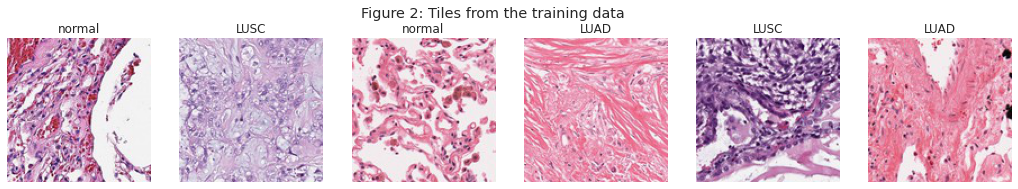

In [63]:
training_data_list = pd.read_csv(os.path.join(input_dir, 'train_norm_luad_lscc.csv'))
labels = {0:'normal', 1:'LUAD', 2:'LUSC'} # internal representation of classes is numeric
fig2, axes = plt.subplots(1,6, figsize=(18,3))
fig2.suptitle('Figure 2: Tiles from the training data')
for i, idx in enumerate([2000*x for x in range(6)]): 
    axes[i].imshow(plt.imread(os.path.join(input_dir, training_data_list['path'][idx])))
    axes[i].set_title(labels[training_data_list['reference_value'][idx]])
    axes[i].axis('off')

Further, we inspect visually how many tiles there are per patient (due to different sizes of slides and amount of slides per patient): 

Total number of tiles: 713,929


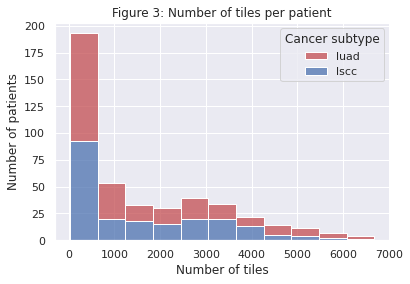

In [64]:
patient_metadata = pd.read_csv(os.path.join(input_dir, 'patient_metadata.csv'))
print('Total number of tiles: {:,}'.format(patient_metadata['nr_tiles_total'].sum()))

fig3 = sns.histplot(data=patient_metadata, x='nr_tiles_total', hue='cancer_subtype', multiple='stack', palette=['r', 'b'])
fig3.set_title('Figure 3: Number of tiles per patient')
fig3.update({'xlabel': 'Number of tiles', 'ylabel': 'Number of patients'})
legend = fig3.get_legend()
legend.set_title('Cancer subtype')

### Training

**Network training**: Following Coudray *et al.*, we use the InceptionV3 network architecture as implemented by Keras and depicted in the figure below [[Szegedy et al., 2015]](https://arxiv.org/abs/1512.00567). The loss function is here defined as categorical cross entropy between the true labels and the network's predictions. RMSprop optimizer is utilized for learning with a learning rate of 0.1, weight decay of 0.9, momentum of 0.9 and epsilon of 1.0. Model checkpoints are automatically saved at each epoch in which the validation loss improves. 

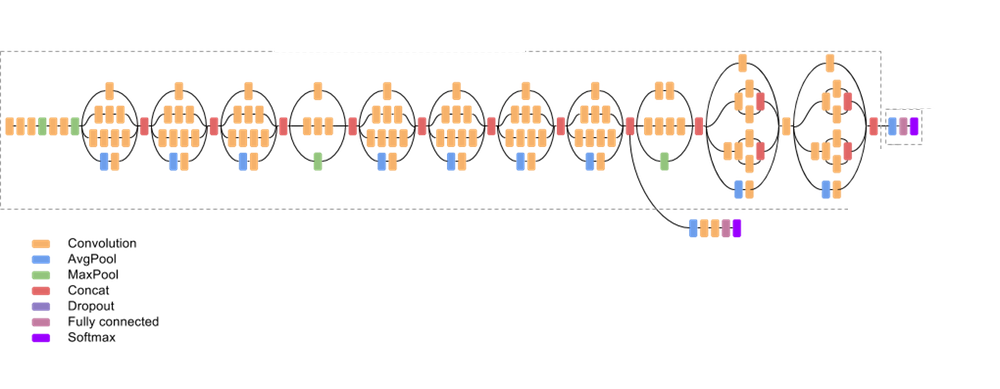

In [65]:
from idc_pathomics.data.data_set import Dataset
from idc_pathomics.model.inceptionv3_model import InceptionModel

output_dir_experiment = os.path.join(output_dir, time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(output_dir_experiment)

# Load datasets
dataset_train = Dataset(os.path.join(input_dir, 'train_norm_luad_lscc.csv'), num_classes=3)
dataset_valid = Dataset(os.path.join(input_dir, 'valid_norm_luad_lscc.csv'), num_classes=3)

# Model set-up and training
model = InceptionModel(num_classes=3, input_shape=(128,128,3), learning_rate=0.1)
model.train(dataset_train, batch_size=512, epochs=30, output_path=output_dir_experiment, validation_dataset=dataset_valid) 

2021-09-28 08:28:27.955006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
964/964 [==============================] - 1111s 1s/step - loss: 0.5696 - auc: 0.9193 - val_loss: 2.0096 - val_auc: 0.8252


2021-09-28 08:47:11.473085: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210928_082822/checkpoint_001/assets
Epoch 2/30
964/964 [==============================] - 1096s 1s/step - loss: 0.4344 - auc: 0.9473 - val_loss: 0.9522 - val_auc: 0.8330
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210928_082822/checkpoint_002/assets
Epoch 3/30
964/964 [==============================] - 1095s 1s/step - loss: 0.3948 - auc: 0.9563 - val_loss: 1.0450 - val_auc: 0.7926
Epoch 4/30
964/964 [==============================] - 1094s 1s/step - loss: 0.4834 - auc: 0.9362 - val_loss: 0.8732 - val_auc: 0.8256
INFO:tensorflow:Assets written to: /home/jupyter/idc_output/20210928_082822/checkpoint_004/assets
Epoch 5/30
964/964 [==============================] - 1095s 1s/step - loss: 0.4030 - auc: 0.9547 - val_loss: 0.9740 - val_auc: 0.8289
Epoch 6/30
964/964 [==============================] - 1094s 1s/step - loss: 0.3639 - auc: 0.9628 - val_loss: 1.2020 - val_auc: 0.8344
Epoch 7/30
964/964 [================

KeyboardInterrupt: 

### Evaluation

The final model is selected as the one with the best (minimal) loss on the validation dataset. The performance of this model is evaluated quantitatively by means of receiver operating characteristic (ROC) curves and observed qualitatively using heatmap visualization. First, the model makes predictions for the entire test set and stores them in the experiment's output directory to make subsequent evaluation easily repeatable. 

**ROC analysis** for each of the three classes (normal, LUAD, LSCC) is performed on **tile-level** (tile-based ROC) and on **slide-level** (slide-based ROC). For slide-level analysis the probabilities for each slide are aggregated either by averaging the probabilities of the corresponding tiles, or by counting the percentage of tiles positively classified. Respective Area under the ROC curve (AUC) values are reported in the table below and the slide-based ROC curves are visualized in Figure 4. In addition to the ROC curves for each class, a micro-average ROC is computed and visualized. 

**Heatmaps** for visually inspecting the network's predictions for some of the slides. The color of each tile corresponds to the class assigned by our model, with the hue indicating how confident the network is in this classification. Hereby a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. The generation of a thumbnail image takes ~1min, thus we limit ourselves to showing heatmaps for only 4 random slides from the testset. 

In [66]:
# Load the best model 
checkpoints = glob.glob(os.path.join(output_dir_experiment, 'checkpoint*/'))
checkpoints.sort()
best_model_dir = checkpoints[-1] # last checkpoint is the one with the best validation loss 
best_model = InceptionModel.load(best_model_dir)

In [73]:
from idc_pathomics.evaluation.predictions import Predictions

test_dataset = Dataset(os.path.join(input_dir, 'test_norm_luad_lscc.csv'), num_classes=3)
#test_dataset = Dataset('/home/jupyter/idc_input_vm/test_norm_luad_lscc_10slide_20tile_2.csv', num_classes=3)

predictions = Predictions(best_model, test_dataset, batch_size=512) 
predictions.save(os.path.join(output_dir_experiment, 'predictions.json'))

tile-based AUC     slide-based AUC                    
                      average probability percentage positive
Normal          0.880               0.958               0.915
LUAD            0.620               0.757               0.758
LUSC            0.704               0.842               0.848
Micro           0.718               0.797               0.799

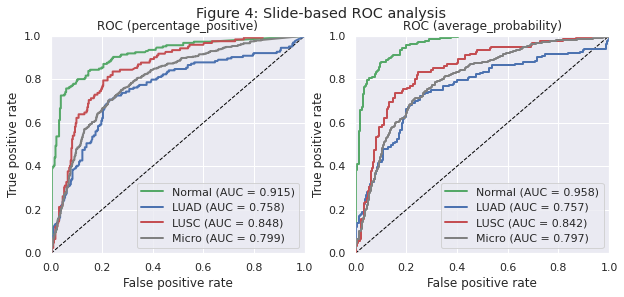

In [74]:
from idc_pathomics.evaluation.roc import ROCAnalysis

roc_analysis = ROCAnalysis(predictions)
roc_analysis.print_and_save_tabluar_results(os.path.join(output_dir_experiment, 'results_table.html'))
roc_analysis.plot_and_save(output_dir_experiment) 

In [ ]:
%%capture --no-display
from idc_pathomics.data.utils import get_random_testset_slide_ids, get_thumbnail, get_slide_tissue_type
from idc_pathomics.evaluation.heatmap import get_heatmap, plot_colormap_legend
from idc_pathomics.evaluation.predictions import Predictions

# Select slides and download thumbnails 
heatmap_slide_ids = get_random_testset_slide_ids(slides_metadata)
get_thumbnail(heatmap_slide_ids, slides_metadata_path, slides_dir, google_cloud_project_id=my_project_id) # NOTE: lasts ~1min per slide

# Generate figure 
plot_colormap_legend()
fig5, axes = plt.subplots(4, 2, figsize=(10, 9))
fig5.suptitle('Figure 5: Heatmap visualization')
for i in range(4):
    slide_id = heatmap_slide_ids[i]#'C3L-00913-22'#
    slide = plt.imread(os.path.join(slides_dir, slide_id + '.png'))
    true_tissue_type = get_slide_tissue_type(slide_id, slides_metadata)
    axes[i,0].imshow(get_heatmap(predictions, slide_id))
    axes[i,1].imshow(slide1)
    axes[i,1].set_title(true_tissue_type.upper())
    axes[i,0].axis('off')
    axes[i,1].axis('off')

Copying gs://idc_dev/c2627b06-f2c8-4117-b091-44c143803bdd.dcm...
| [1 files][172.8 MiB/172.8 MiB]                                                
Operation completed over 1 objects/172.8 MiB.                                    
